## プリンターとグルア―を分離

In [1]:
# 自分のマイドライブにマウントする
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
%cd "/content/drive/MyDrive/マナビDX_Quest/PBL05/data"

/content/drive/MyDrive/マナビDX_Quest/PBL05/data


In [3]:
#必要なモジュールをインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gc
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import datetime

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import os
from sklearn.preprocessing import LabelEncoder

pd.set_option('max_rows', 400)
pd.set_option('max_columns', 200)

In [ ]:
df_actual_train = pd.read_csv('train/actual_train.csv')
base_train = pd.read_csv('train/base_train.csv')
processing_train = pd.read_csv('train/processing_train.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,9,15,24,33,34,35,38,39,43,45,46,48,49,50) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (12,13,15,16,22,23,30,33,34,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,61,63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_actual_test = pd.read_csv('test/actual_test.csv')
base_test = pd.read_csv('test/base_test.csv')
processing_test = pd.read_csv('test/processing_test.csv')

## actual_train

In [ ]:
machine_list = ['2号機', '4号機', '6号機', '7号機', '8号機', 'グルアー']
df_actual_train = df_actual_train.loc[df_actual_train["号機名"].isin(machine_list)]
df_actual_train

,作業実績番号,作業日,受注番号,号機名,号機コード,事業所コード,部門コード,工程コード,工程名,得意先コード,作業者コード,工程作業コード,工程作業名,工程作業詳細コード,工程作業詳細名,作業人数,開始時刻,終了時刻,所要時間,作業時間,残業時間,合計時間,製造完成数量,完了区分,完了区分名,作成日,作成担当者コード,作成端末コード,更新日,更新回数,更新担当者コード,更新端末コード,削除日,削除フラグ,削除担当者コード,削除端末コード,取込キー
142,E18011985,2018-11-05,227907-00,4号機,12,1.0,4010.0,21,印刷（一般）,06075-000,149,1201.0,本作業 一般紙,« NULL »,« NULL »,1,2018-11-05 15:38:00,2018-11-05 16:35:00,57.0,3,0,3,« NULL »,1,完了,2018-11-05 16:33:28.173,149.0,MHC217-M-4GOUKI,2018-11-05 16:33:28.173,1.0,149.0,MHC217-M-4GOUKI,« NULL »,0.0,« NULL »,« NULL »,« NULL »
143,E18012054,2018-11-05,227907-00,6号機,13,1.0,4010.0,21,印刷（一般）,06075-000,61,1301.0,本作業 一般紙,« NULL »,« NULL »,1,2018-11-05 17:32:00,2018-11-05 18:21:00,49.0,14,0,14,« NULL »,1,完了,2018-11-05 18:21:46.907,61.0,MHC219-M-6GOUKI,2018-11-05 18:21:46.907,1.0,61.0,MHC219-M-6GOUKI,« NULL »,0.0,« NULL »,« NULL »,« NULL »
159,E18003144,2018-10-04,229738-00,グルアー,37,1.0,4020.0,34,貼り,24015-002,191,3704.0,既存本作業 ワンタッチ,« NULL »,« NULL »,1,2018-10-04 17:00:00,2018-10-04 17:34:00,34.0,9,0,9,« NULL »,1,完了,2018-10-04 22:28:58.543,191.0,MHC226-M-GLUER,2018-10-04 22:28:58.543,1.0,191.0,MHC226-M-GLUER,« NULL »,0.0,« NULL »,« NULL »,« NULL »
166,E18003153,2018-10-04,230138-00,グルアー,37,1.0,4020.0,34,貼り,24015-002,191,3704.0,既存本作業 ワンタッチ,« NULL »,« NULL »,1,2018-10-04 18:05:00,2018-10-04 18:29:00,24.0,14,0,14,« NULL »,1,完了,2018-10-04 22:34:50.657,191.0,MHC226-M-GLUER,2018-10-04 22:34:50.657,1.0,191.0,MHC226-M-GLUER,« NULL »,0.0,« NULL »,« NULL »,« NULL »
167,E18014738,2018-11-13,230432-00,6号機,13,1.0,4010.0,21,印刷（一般）,06001-004,61,1303.0,本作業 厚紙,« NULL »,« NULL »,1,2018-11-13 13:04:00,2018-11-13 14:03:00,59.0,20,0,20,« NULL »,1,完了,2018-11-13 14:06:12.213,61.0,MHC219-M-6GOUKI,2018-11-13 14:06:12.213,1.0,61.0,MHC219-M-6GOUKI,« NULL »,0.0,« NULL »,« NULL »,« NULL »
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110864,E18003414,2018-10-05,« NULL »,4号機,12,1.0,4010.0,21,印刷（一般）,« NULL »,149,1214.0,故障・修理,« NULL »,« NULL »,1,2018-10-05 14:00:00,2018-10-05 23:00:00,540.0,0,0,0,« NULL »,1,完了,2018-10-06 02:31:18.200,149.0,MHC217-M-4GOUKI,2018-10-06 02:31:18.200,1.0,149.0,MHC217-M-4GOUKI,« NULL »,0.0,« NULL »,« NULL »,« NULL »
110865,E19020258,2019-03-08,« NULL »,6号機,13,1.0,4010.0,21,印刷（一般）,« NULL »,162,1320.0,手待ち（紙）,« NULL »,« NULL »,1,2019-03-08 11:23:00,2019-03-08 18:50:00,447.0,447,0,447,« NULL »,1,完了,2019-03-08 18:51:04.313,162.0,MHC219-M-6GOUKI,2019-03-08 18:51:04.313,1.0,162.0,MHC219-M-6GOUKI,« NULL »,0.0,« NULL »,« NULL »,« NULL »
110866,E18023093,2018-12-07,« NULL »,7号機,14,1.0,4010.0,21,印刷（一般）,« NULL »,133,1415.0,メンテナンス,« NULL »,« NULL »,1,2018-12-07 08:30:00,2018-12-07 17:30:00,540.0,0,0,0,« NULL »,1,完了,2018-12-07 19:21:18.087,133.0,MHC220-M-7GOUKI,2018-12-07 19:21:18.087,1.0,133.0,MHC220-M-7GOUKI,« NULL »,0.0,« NULL »,« NULL »,« NULL »
110867,E18004625,2018-10-14,« NULL »,8号機,15,1.0,4010.0,21,印刷（一般）,« NULL »,149,1513.0,メンテナンス,« NULL »,« NULL »,1,2018-10-14 08:30:00,2018-10-14 17:30:00,540.0,0,0,0,« NULL »,1,完了,2018-10-14 16:49:33.953,149.0,MHC370-TYOSHIZA,2018-10-14 16:49:33.953,1.0,149.0,MHC370-TYOSHIZA,« NULL »,0.0,« NULL »,« NULL »,« NULL »


In [ ]:
df_actual_train["作業日"] = pd.to_datetime(df_actual_train['作業日'])
df_actual_train.loc[df_actual_train['作業時間'] < 0, '作業時間'] = 0
df_actual_train.loc[df_actual_train['合計時間'] < 0, '合計時間'] = 0
df_actual_train = df_actual_train[(df_actual_train['作業時間']>0) & (df_actual_train['合計時間']>0)]
tmp1 = df_actual_train[df_actual_train["作業日"]<="2020-2-3"]
tmp1["正味作業時間"] = tmp1["作業時間"]
tmp1["付帯作業時間"] = tmp1["所要時間"] - (tmp1["作業時間"] + tmp1["残業時間"])
tmp2 = df_actual_train[df_actual_train["作業日"]>="2020-2-4"]
tmp2["正味作業時間"] = tmp2["作業時間"]
tmp2["付帯作業時間"] = tmp2["合計時間"]
df_actual_train = pd.concat([tmp1, tmp2])

df_actual_train.loc[df_actual_train['付帯作業時間'] < 0, '付帯作業時間'] = 0
df_actual_train = df_actual_train[["作業日","受注番号","号機名","正味作業時間","付帯作業時間"]]
"""
machine_list = ['2号機', '4号機', '6号機', '7号機', '8号機', 'グルアー']
df_actual_train = df_actual_train.loc[df_actual_train["号機名"].isin(machine_list)]
"""

df_actual_train
#df_actual_train

<ipython-input-32-3948a2d96114>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1["正味作業時間"] = tmp1["作業時間"]
<ipython-input-32-3948a2d96114>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1["付帯作業時間"] = tmp1["所要時間"] - (tmp1["作業時間"] + tmp1["残業時間"])
<ipython-input-32-3948a2d96114>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,作業日,受注番号,号機名,正味作業時間,付帯作業時間
142,2018-11-05,227907-00,4号機,3,54.0
143,2018-11-05,227907-00,6号機,14,35.0
159,2018-10-04,229738-00,グルアー,9,25.0
166,2018-10-04,230138-00,グルアー,14,10.0
167,2018-11-13,230432-00,6号機,20,39.0
...,...,...,...,...,...
110856,2020-07-29,b20013789,2号機,4,28.0
110857,2020-07-31,b20013798,7号機,3,29.0
110858,2020-07-30,b20013866,4号機,5,13.0
110859,2020-07-31,b20013869,8号機,25,15.0


In [ ]:
df_actual_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23711 entries, 142 to 110861
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   作業日     23711 non-null  datetime64[ns]
 1   受注番号    23711 non-null  object        
 2   号機名     23711 non-null  object        
 3   正味作業時間  23711 non-null  int64         
 4   付帯作業時間  23711 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
df_actual_train.to_csv("df_actual_train.csv")

### processing_train

In [ ]:
processing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22095 entries, 0 to 22094
Data columns (total 67 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   受注番号       22095 non-null  object 
 1   号機名        22095 non-null  object 
 2   号機コード      22095 non-null  int64  
 3   数量1        22069 non-null  object 
 4   数量項目名1     20527 non-null  object 
 5   数量2        20593 non-null  object 
 6   数量項目名2     7582 non-null   object 
 7   数量3        20592 non-null  object 
 8   数量項目名3     7576 non-null   object 
 9   数量4        14734 non-null  object 
 10  数量項目名4     0 non-null      float64
 11  合計数量       14621 non-null  float64
 12  予備数量       14621 non-null  object 
 13  仕上数量       14621 non-null  object 
 14  連量         8790 non-null   float64
 15  加工数量       14621 non-null  object 
 16  台数         20289 non-null  object 
 17  通し実数       7299 non-null   float64
 18  刷了数        7299 non-null   float64
 19  印刷予備数      7293 non-null   float64
 20  加工予備数 

In [ ]:
from IPython.core.interactiveshell import Instance
def set_processing(processing):
    # -------------------------------------------------------------------------------------------------
    processing.loc[processing["数量1"]=="« NULL »","数量1"]=0
    processing.loc[processing["数量2"]=="« NULL »","数量2"]=0
    processing.loc[processing["数量3"]=="« NULL »","数量3"]=0
    processing.loc[processing["数量4"]=="« NULL »","数量4"]=0
    processing.loc[processing["予備数量"]=="« NULL »","予備数量"]=0
    processing.loc[processing["仕上数量"]=="« NULL »","仕上数量"]=0
    processing.loc[processing["加工数量"]=="« NULL »","加工数量"]=0
    processing.loc[processing["台数"]=="« NULL »","台数"]=0
    processing.loc[processing["部品仕様番号"]=="« NULL »","部品仕様番号"]=0
    processing.loc[processing["協力会社親コード"]=="« NULL »","協力会社親コード"]=-999
    processing.loc[processing["協力会社子コード"]=="« NULL »","協力会社子コード"]=-9
    processing.loc[processing["サイズ区分"]=="« NULL »","サイズ区分"]=-999
    processing.loc[processing["サイズ幅"]=="« NULL »","サイズ幅"]=0
    processing.loc[processing["サイズ長さ"]=="« NULL »","サイズ長さ"]=0
    processing.loc[processing["抜型区分"]=="« NULL »","抜型区分"]=-9
    processing.loc[processing["ストリッパー区分"]=="« NULL »","ストリッパー区分"]=-9
    processing.loc[processing["ブランキング区分"]=="« NULL »","ブランキング区分"]=-9
    processing.loc[processing["加工表裏指定区分"]=="« NULL »","加工表裏指定区分"]=-9
    processing.loc[processing["単位区分"]=="« NULL »","単位区分"]=-9


    # -------------------------------------------------------------------------------------------------
    processing.loc[processing["数量項目名1"].isnull(),"数量項目名1"]="« NULL »"
    processing.loc[processing["数量項目名2"].isnull(),"数量項目名2"]="« NULL »"
    processing.loc[processing["数量項目名3"].isnull(),"数量項目名3"]="« NULL »"
    processing.loc[processing["数量項目名4"].isnull(),"数量項目名4"]="« NULL »"
    processing.loc[processing["合計数量"].isnull(),"合計数量"]=processing.loc[processing["合計数量"].isnull(),"数量1"]
    processing["予備数量"]=processing["予備数量"].fillna(0)
    processing["加工数量"]=processing["加工数量"].fillna(0)
    processing.loc[processing["合計数量"]==0,"合計数量"] = processing.loc[processing["合計数量"]==0,"予備数量"].astype(int) + processing.loc[processing["合計数量"]==0,"加工数量"].astype(int)
    processing.loc[processing["カテゴリ名1"].isnull(),"カテゴリ名1"]="« NULL »"
    processing.loc[processing["カテゴリ名2"].isnull(),"カテゴリ名2"]="« NULL »"
    processing.loc[processing["部品区分"].isnull(),"部品区分"]="« NULL »"
    processing.loc[processing["部品区分名"].isnull(),"部品区分名"]="« NULL »"
    processing.loc[processing["部品仕様コード"].isnull(),"部品仕様コード"]="« NULL »"
    processing.loc[processing["印刷前工程フラグ"].isnull(),"印刷前工程フラグ"]="« NULL »"
    processing.loc[processing["加工単位区分名"].isnull(),"加工単位区分名"]="« NULL »"
    processing.loc[processing["協力会社コード"].isnull(),"協力会社コード"]="« NULL »"
    processing.loc[processing["サイズ区分名"].isnull(),"サイズ区分名"]="« NULL »"
    processing.loc[processing["抜型区分名"].isnull(),"抜型区分名"]="« NULL »"
    processing.loc[processing["抜型納入日"].isnull(),"抜型納入日"]="« NULL »"
    processing.loc[processing["ストリッパー区分名"].isnull(),"ストリッパー区分名"]="« NULL »"
    processing.loc[processing["ブランキング区分名"].isnull(),"ブランキング区分名"]="« NULL »"
    processing.loc[processing["加工表裏指定区分名"].isnull(),"加工表裏指定区分名"]="« NULL »"
    processing.loc[processing["単位区分名"].isnull(),"単位区分名"]="« NULL »"
    processing.loc[processing["仕分区分名"].isnull(),"仕分区分名"]="« NULL »"
    processing.loc[processing["間紙区分名"].isnull(),"間紙区分名"]="« NULL »"
    processing.loc[processing["紙帯区分名"].isnull(),"紙帯区分名"]="« NULL »"

    # -------------------------------------------------------------------------------------------------
    processing["数量1"]=processing["数量1"].fillna(0)
    processing["数量2"]=processing["数量2"].fillna(0)
    processing["数量3"]=processing["数量3"].fillna(0)
    processing["数量4"]=processing["数量4"].fillna(0)
    processing["合計数量"]=processing["合計数量"].fillna(0)
    processing["予備数量"]=processing["予備数量"].fillna(0)
    processing["仕上数量"]=processing["仕上数量"].fillna(0)
    processing["連量"]=processing["連量"].fillna(0)
    processing["加工数量"]=processing["加工数量"].fillna(0)
    processing["台数"]=processing["台数"].fillna(0)
    processing["通し実数"]=processing["通し実数"].fillna(0)
    processing["刷了数"]=processing["刷了数"].fillna(0)
    processing["印刷予備数"]=processing["印刷予備数"].fillna(0)
    processing["加工予備数"]=processing["加工予備数"].fillna(0)
    processing["製品仕様コード"]=processing["製品仕様コード"].fillna(0)
    processing["表色数"]=processing["表色数"].fillna(0)
    processing["裏色数"]=processing["裏色数"].fillna(0)
    processing["刷本寸法長さ"]=processing["刷本寸法長さ"].fillna(0)
    processing["刷本寸法幅"]=processing["刷本寸法幅"].fillna(0)
    processing["部品行番号"]=processing["部品行番号"].fillna(0)
    processing["部品仕様番号"]=processing["部品仕様番号"].fillna(0)
    processing["表示順"]=processing["表示順"].fillna(-999)
    processing["印刷前工程フラグ"]=processing["印刷前工程フラグ"].fillna(0)
    processing["加工行番号"]=processing["加工行番号"].fillna(0)
    processing["加工順"]=processing["加工順"].fillna(-999)
    processing["加工単位区分"]=processing["加工単位区分"].fillna(-9)
    processing["協力会社親コード"]=processing["協力会社親コード"].fillna(-999)
    processing["協力会社子コード"]=processing["協力会社子コード"].fillna(-9)
    processing["サイズ区分"]=processing["サイズ区分"].fillna(-999)
    processing["サイズ幅"]=processing["サイズ幅"].fillna(0)
    processing["サイズ長さ"]=processing["サイズ長さ"].fillna(0)
    processing["抜型区分"]=processing["抜型区分"].fillna(-9)
    processing["ストリッパー区分"]=processing["ストリッパー区分"].fillna(-9)
    processing["ブランキング区分"]=processing["ブランキング区分"].fillna(-9)
    processing["加工表裏指定区分"]=processing["加工表裏指定区分"].fillna(-9)
    processing["単位区分"]=processing["単位区分"].fillna(-9)
    processing["仕分区分"]=processing["仕分区分"].fillna(-9)
    processing["間紙区分"]=processing["間紙区分"].fillna(-9)
    processing["紙帯区分"]=processing["紙帯区分"].fillna(-9)


    # -------------------------------------------------------------------------------------------------
    # -------------------------------------------------------------------------------------------------
    processing["数量1"] = processing["数量1"].astype(float)
    processing["数量2"] = processing["数量2"].astype(float)
    processing["数量3"] = processing["数量3"].astype(float)
    processing["数量4"] = processing["数量4"].astype(float)
    processing["合計数量"] = processing["合計数量"].astype(float).astype(int)
    processing["予備数量"] = processing["数量1"].astype(int)
    processing["仕上数量"] = processing["仕上数量"].astype(int)
    processing["加工数量"] = processing["加工数量"].astype(int)
    processing["台数"] = processing["台数"].astype(float)
    processing["通し実数"] = processing["通し実数"].astype(int)
    processing["刷了数"] = processing["刷了数"].astype(int)
    processing["印刷予備数"] = processing["印刷予備数"].astype(int)
    processing["加工予備数"] = processing["加工予備数"].astype(int)
    processing["製品仕様コード"] = processing["製品仕様コード"].astype(str)
    processing["工程コード"] = processing["工程コード"].astype(str)
    processing["表色数"] = processing["表色数"].astype(int)
    processing["裏色数"] = processing["裏色数"].astype(int)
    processing["部品行番号"] = processing["部品行番号"].astype(int)
    processing["部品仕様番号"] = processing["部品仕様番号"].astype(int)
    processing["表示順"] = processing["表示順"].astype(int)
    processing["加工行番号"] = processing["加工行番号"].astype(int)
    processing["加工順"] = processing["加工順"].astype(int)
    processing["加工単位区分"] = processing["加工単位区分"].astype(str)
    processing["サイズ幅"] = processing["サイズ幅"].astype(float)
    processing["サイズ長さ"] = processing["サイズ長さ"].astype(float)
    processing["仕分区分"] = processing["仕分区分"].astype(str)
    processing["間紙区分"] = processing["間紙区分"].astype(str)
    processing["紙帯区分"] = processing["紙帯区分"].astype(str)

    #processing = processing.drop(["抜型番号"], axis=1)

    return processing

In [ ]:
#processing_train = set_processing(processing_train)

In [ ]:
#processing_train = processing_train.drop(["抜型番号"], axis=1)

In [ ]:
processing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22095 entries, 0 to 22094
Data columns (total 66 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   受注番号       22095 non-null  object 
 1   号機名        22095 non-null  object 
 2   号機コード      22095 non-null  int64  
 3   数量1        22095 non-null  float64
 4   数量項目名1     22095 non-null  object 
 5   数量2        22095 non-null  float64
 6   数量項目名2     22095 non-null  object 
 7   数量3        22095 non-null  float64
 8   数量項目名3     22095 non-null  object 
 9   数量4        22095 non-null  float64
 10  数量項目名4     22095 non-null  object 
 11  合計数量       22095 non-null  int64  
 12  予備数量       22095 non-null  int64  
 13  仕上数量       22095 non-null  int64  
 14  連量         22095 non-null  float64
 15  加工数量       22095 non-null  int64  
 16  台数         22095 non-null  float64
 17  通し実数       22095 non-null  int64  
 18  刷了数        22095 non-null  int64  
 19  印刷予備数      22095 non-null  int64  
 20  加工予備数 

In [ ]:
processing_train.to_csv("/content/drive/MyDrive/マナビDX_Quest/PBL05/data/加工データ/df_processing_train.csv")

## base_train

In [ ]:
def set_base(df_base):
    df_base.loc[df_base["実績数量"]=="« NULL »","実績数量"]=0
    df_base.loc[df_base["頁数"]=="« NULL »","頁数"]=0
    df_base.loc[df_base["受注区分"]=="« NULL »","受注区分"]=-9
    df_base.loc[df_base["事業所親コード"]=="« NULL »","事業所親コード"]=-9
    df_base.loc[df_base["事業所子コード"]=="« NULL »","事業所子コード"]=-9
    df_base.loc[df_base["事業所コード"]=="« NULL »","事業所コード"]=-9
    df_base.loc[df_base["部門コード"]=="« NULL »","事業所コード"]=-9999
    df_base.loc[df_base["仕上寸法区分"]=="« NULL »","仕上寸法区分"]=-999
    df_base.loc[df_base["仕上寸法幅"]=="« NULL »","仕上寸法幅"]=0
    df_base.loc[df_base["仕上寸法長さ"]=="« NULL »","仕上寸法長さ"]=0
    df_base.loc[df_base["仕上寸法厚さ"]=="« NULL »","仕上寸法厚さ"]=0
    df_base.loc[df_base["展開寸法区分"]=="« NULL »","展開寸法区分"]=-999
    df_base.loc[df_base["仕上寸法長さ"]=="« NULL »","仕上寸法長さ"]=0
    df_base.loc[df_base["展開寸法幅"]=="« NULL »","展開寸法幅"]=0
    df_base.loc[df_base["展開寸法長さ"]=="« NULL »","展開寸法長さ"]=0
    df_base.loc[df_base["展開寸法厚さ"]=="« NULL »","展開寸法厚さ"]=0
    df_base.loc[df_base["製品区分"]=="« NULL »","製品区分"]=-9
    df_base.loc[df_base["リピート区分"]=="« NULL »","リピート区分"]=-9
    df_base.loc[df_base["仕様登録者コード"]=="« NULL »","仕様登録者コード"]=-999
    df_base.loc[df_base["単位区分"]=="« NULL »","単位区分"]=-9
    df_base.loc[df_base["客先サンプル数量"]=="« NULL »","客先サンプル数量"]=0
    df_base.loc[df_base["版区分"]=="« NULL »","版区分"]=-9
    df_base.loc[df_base["預在区分"]=="« NULL »","預在区分"]=-9
    df_base.loc[df_base["上長確認フラグ"]=="« NULL »","上長確認フラグ"]=-9
    df_base.loc[df_base["受注キャンセルフラグ"]=="« NULL »","受注キャンセルフラグ"]=-9

    df_base.loc[df_base["営業サンプル数量"]=="« NULL »","営業サンプル数量"]=-9
    # ------------------------------------------------------------------------------------
    df_base.loc[df_base["製品仕様コード"].isnull(),"製品仕様コード"]="« NULL »"
    df_base.loc[df_base["下版予定日"].isnull(),"下版予定日"]="« NULL »"
    df_base.loc[df_base["流用受注番号"].isnull(),"流用受注番号"]="« NULL »"
    df_base.loc[df_base["流用受注日"].isnull(),"流用受注日"]="« NULL »"
    df_base.loc[df_base["流用製品仕様コード"].isnull(),"流用製品仕様コード"]="« NULL »"
    df_base['流用製品仕様コード'] = df_base['流用製品仕様コード'].astype(str)
    df_base.loc[df_base["流用製品仕様コード"].isnull(),"流用製品仕様コード"]="« NULL »"
    df_base.loc[df_base["キャンペーン番号"].isnull(),"キャンペーン番号"]="« NULL »"
    df_base.loc[df_base["受注キャンペーン番号"].isnull(),"受注キャンペーン番号"]="« NULL »"
    df_base.loc[df_base["付合受注番号"].isnull(),"付合受注番号"]="« NULL »"
    df_base.loc[df_base["受注区分名"].isnull(),"受注区分名"]="« NULL »"
    df_base.loc[df_base["納期"].isnull(),"納期"]="« NULL »"
    df_base.loc[df_base["納期詳細"].isnull(),"納期詳細"]="« NULL »"
    df_base.loc[df_base["初回出荷日"].isnull(),"初回出荷日"]="« NULL »"
    df_base.loc[df_base["先方注文番号"].isnull(),"先方注文番号"]="« NULL »"
    df_base.loc[df_base["得意先コード"].isnull(),"得意先コード"]="« NULL »"
    df_base.loc[df_base["版番号"].isnull(),"版番号"]="« NULL »"
    df_base.loc[df_base["ロット番号"].isnull(),"ロット番号"]="« NULL »"
    df_base.loc[df_base["仕上寸法区分名"].isnull(),"仕上寸法区分名"]="« NULL »"
    df_base.loc[df_base["展開寸法区分名"].isnull(),"展開寸法区分名"]="« NULL »"
    df_base.loc[df_base["製品区分名"].isnull(),"製品区分名"]="« NULL »"
    df_base.loc[df_base["リピート区分名"].isnull(),"リピート区分名"]="« NULL »"
    df_base.loc[df_base["単位区分名"].isnull(),"リピート区分単位区分名"]="« NULL »"
    df_base.loc[df_base["版区分名"].isnull(),"版区分名"]="« NULL »"
    df_base.loc[df_base["預在区分名"].isnull(),"預在区分名"]="« NULL »"
    df_base.loc[df_base["受注伝票発行年月日"].isnull(),"受注伝票発行年月日"]="« NULL »"
    df_base.loc[df_base["制作伝票発行年月日"].isnull(),"制作伝票発行年月日"]="« NULL »"
    df_base.loc[df_base["特練インキ発行年月日"].isnull(),"特練インキ発行年月日"]="« NULL »"
    df_base.loc[df_base["規格書発行年月日"].isnull(),"規格書発行年月日"]="« NULL »"
    df_base.loc[df_base["作業伝票チェックシート発行年月日"].isnull(),"作業伝票チェックシート発行年月日"]="« NULL »"
    df_base.loc[df_base["送品書発行年月日"].isnull(),"送品書発行年月日"]="« NULL »"
    df_base.loc[df_base["下版予定日詳細"].isnull(),"下版予定日詳細"]="« NULL »"
    df_base.loc[df_base["受注キャンセル日"].isnull(),"受注キャンセル日"]="« NULL »"

    # ------------------------------------------------------------------------------------
    df_base["受注数量"]=df_base["受注数量"].fillna(0)
    df_base["頁数"]=df_base["頁数"].fillna(0)
    df_base["キャンペーンフラグ"]=df_base["キャンペーンフラグ"].fillna(-9)
    df_base["付合フラグ"]=df_base["付合フラグ"].fillna(-9)
    df_base["受注区分"]=df_base["受注区分"].fillna(-9)
    df_base["事業所親コード"]=df_base["事業所親コード"].fillna(-9)
    df_base["事業所コード"]=df_base["事業所コード"].fillna(-9)
    df_base["部門コード"]=df_base["部門コード"].fillna(-9999)
    df_base["営業担当者コード"]=df_base["営業担当者コード"].fillna(-9999)
    df_base["得意先親コード"]=df_base["得意先親コード"].fillna(-9999)
    df_base["得意先子コード"]=df_base["得意先子コード"].fillna(-9999)
    df_base["仕上寸法区分"]=df_base["仕上寸法区分"].fillna(-999)
    df_base["仕上寸法幅"]=df_base["仕上寸法幅"].fillna(0)
    df_base["仕上寸法長さ"]=df_base["仕上寸法長さ"].fillna(0)
    df_base["仕上寸法厚さ"]=df_base["仕上寸法厚さ"].fillna(0)
    df_base["展開寸法区分"]=df_base["展開寸法区分"].fillna(0)
    df_base["展開寸法幅"]=df_base["展開寸法幅"].fillna(0)
    df_base["展開寸法長さ"]=df_base["展開寸法長さ"].fillna(0)
    df_base["展開寸法厚さ"]=df_base["展開寸法厚さ"].fillna(0)
    df_base["製品区分"]=df_base["製品区分"].fillna(-9)
    df_base["リピート区分"]=df_base["リピート区分"].fillna(-9)
    df_base["仕様登録者コード"]=df_base["仕様登録者コード"].fillna(-9)
    df_base["単位区分"]=df_base["単位区分"].fillna(-9)
    df_base["客先サンプル数量"]=df_base["客先サンプル数量"].fillna(0)
    df_base["版区分"]=df_base["版区分"].fillna(-9)
    df_base["預在区分"]=df_base["預在区分"].fillna(-9)
    df_base["上長確認フラグ"]=df_base["上長確認フラグ"].fillna(-9)
    df_base["受注キャンセルフラグ"]=df_base["受注キャンセルフラグ"].fillna(-9)
    df_base["完納フラグ"]=df_base["完納フラグ"].fillna(-9)
    df_base["受注伝票発行済フラグ"]=df_base["受注伝票発行済フラグ"].fillna(-9)
    df_base["受注伝票発行回数"]=df_base["受注伝票発行回数"].fillna(0)
    df_base["制作伝票発行済フラグ"]=df_base["制作伝票発行済フラグ"].fillna(-9)
    df_base["制作伝票発行回数"]=df_base["制作伝票発行回数"].fillna(0)
    df_base["特練インキ発行済フラグ"]=df_base["特練インキ発行済フラグ"].fillna(0)
    df_base["特練インキ発行回数"]=df_base["特練インキ発行回数"].fillna(0)
    df_base["規格書発行済フラグ"]=df_base["規格書発行済フラグ"].fillna(0)
    df_base["規格書発行回数"]=df_base["規格書発行回数"].fillna(0)
    df_base["作業伝票チェックシート発行年月日"]=df_base["作業伝票チェックシート発行年月日"].fillna(0)
    df_base["作業伝票チェックシート発行回数"]=df_base["作業伝票チェックシート発行回数"].fillna(0)
    df_base["送品書発行済フラグ"]=df_base["送品書発行済フラグ"].fillna(0)
    df_base["送品書発行回数"]=df_base["送品書発行回数"].fillna(0)
    df_base["予定組反映フラグ"]=df_base["予定組反映フラグ"].fillna(0)

    df_base["営業サンプル数量"]=df_base["営業サンプル数量"].fillna(0)
    df_base = df_base.dropna(subset=["実績数量"])

    # ------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------
    df_base["受注数量"] = df_base["受注数量"].astype(int)
    df_base["実績数量"] = df_base["実績数量"].astype(float)
    df_base["頁数"] = df_base["頁数"].astype(float)
    df_base["キャンペーンフラグ"] = df_base["キャンペーンフラグ"].astype(str)
    df_base["付合フラグ"] = df_base["付合フラグ"].astype(str)
    df_base["営業担当者コード"] = df_base["営業担当者コード"].astype(str)
    df_base["得意先親コード"] = df_base["得意先親コード"].astype(str)
    df_base["得意先子コード"] = df_base["得意先子コード"].astype(str)
    df_base["仕上寸法幅"] = df_base["仕上寸法幅"].astype(float)
    df_base["仕上寸法長さ"] = df_base["仕上寸法長さ"].astype(float)
    df_base["仕上寸法厚さ"] = df_base["仕上寸法厚さ"].astype(float)
    df_base["展開寸法幅"] = df_base["展開寸法幅"].astype(float)
    df_base["展開寸法長さ"] = df_base["展開寸法長さ"].astype(float)
    df_base["展開寸法厚さ"] = df_base["展開寸法厚さ"].astype(float)

    df_base["客先サンプル数量"] = df_base["客先サンプル数量"].astype(int)
    df_base["営業サンプル数量"] = df_base["営業サンプル数量"].astype(int)
    df_base["上長確認フラグ"] = df_base["上長確認フラグ"].astype(str)
    df_base["受注キャンセルフラグ"] = df_base["受注キャンセルフラグ"].astype(str)
    df_base["完納フラグ"] = df_base["完納フラグ"].astype(str)
    df_base["受注伝票発行済フラグ"] = df_base["受注伝票発行済フラグ"].astype(str)
    df_base["受注伝票発行回数"] = df_base["受注伝票発行回数"].astype(int)
    df_base["制作伝票発行済フラグ"] = df_base["制作伝票発行済フラグ"].astype(str)
    df_base["特練インキ発行済フラグ"] = df_base["特練インキ発行済フラグ"].astype(str)
    df_base["特練インキ発行回数"] = df_base["特練インキ発行回数"].astype(int)
    df_base["規格書発行済フラグ"] = df_base["規格書発行済フラグ"].astype(str)
    df_base["規格書発行回数"] = df_base["規格書発行回数"].astype(int)
    df_base["作業伝票チェックシート発行済フラグ"] = df_base["作業伝票チェックシート発行済フラグ"].astype(str)
    df_base["作業伝票チェックシート発行回数"] = df_base["作業伝票チェックシート発行回数"].astype(int)
    df_base["送品書発行済フラグ"] = df_base["送品書発行済フラグ"].astype(str)
    df_base["送品書発行回数"] = df_base["送品書発行回数"].astype(int)
    df_base["予定組反映フラグ"] = df_base["予定組反映フラグ"].astype(str)

    #df_base = df_base.drop(["最終売上日"], axis=1)
    return df_base

In [ ]:
#base_train = set_base(base_train)

<ipython-input-13-3f473b1271e8>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base["受注数量"] = df_base["受注数量"].astype(int)
<ipython-input-13-3f473b1271e8>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base["実績数量"] = df_base["実績数量"].astype(float)
<ipython-input-13-3f473b1271e8>:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
#base_train = base_train.drop(["最終売上日","製品仕様コード","単位区分", "単位区分名"], axis=1)

In [ ]:
"""
base_test = set_base(base_test)
base_test = base_test.drop(["最終売上日","製品仕様コード","単位区分", "単位区分名"], axis=1)
"""

<ipython-input-13-3f473b1271e8>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base["受注数量"] = df_base["受注数量"].astype(int)
<ipython-input-13-3f473b1271e8>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base["実績数量"] = df_base["実績数量"].astype(float)
<ipython-input-13-3f473b1271e8>:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
df_merge_train = pd.merge(df_actual_train, processing_train, on=['受注番号', '号機名'], how='left')
df_merge_train.columns

Index(['作業日', '受注番号', '号機名', '正味作業時間', '付帯作業時間', '号機コード', '数量1', '数量項目名1',
       '数量2', '数量項目名2', '数量3', '数量項目名3', '数量4', '数量項目名4', '合計数量', '予備数量',
       '仕上数量', '連量', '加工数量', '台数', '通し実数', '刷了数', '印刷予備数', '加工予備数', '製品仕様コード',
       'カテゴリ名1', 'カテゴリ名2', '工程コード', '工程名', '表色数', '裏色数', '刷本寸法長さ', '刷本寸法幅',
       '部品区分', '部品区分名', '部品行番号', '部品仕様番号', '部品仕様コード', '表示順', '印刷前工程フラグ',
       '加工行番号', '加工順', '加工単位区分', '加工単位区分名', '協力会社親コード', '協力会社子コード', '協力会社コード',
       'サイズ区分', 'サイズ区分名', 'サイズ幅', 'サイズ長さ', '抜型番号', '抜型区分', '抜型区分名', '抜型納入日',
       'ストリッパー区分', 'ストリッパー区分名', 'ブランキング区分', 'ブランキング区分名', '加工表裏指定区分',
       '加工表裏指定区分名', '単位区分', '単位区分名', '仕分区分', '仕分区分名', '間紙区分', '間紙区分名', '紙帯区分',
       '紙帯区分名', '予定組ラベルキー'],
      dtype='object')

In [ ]:
df_merge_train = pd.merge(df_merge_train, base_train, on="受注番号", how="left")

In [ ]:
df_merge_train.columns

Index(['作業日', '受注番号', '号機名', '正味作業時間', '付帯作業時間', '号機コード', '数量1', '数量項目名1',
       '数量2', '数量項目名2',
       ...
       '作業伝票チェックシート発行済フラグ', '作業伝票チェックシート発行年月日', '作業伝票チェックシート発行回数', '送品書発行済フラグ',
       '送品書発行年月日', '送品書発行回数', '最終売上日', '予定組反映フラグ', '下版予定日詳細', '受注キャンセル日'],
      dtype='object', length=148)

In [ ]:
df_merge_train = df_merge_train.replace("« NULL »", np.nan)
df_merge_train = df_merge_train.dropna(how='all', axis=1)

df_merge_train = df_merge_train.dropna(subset=["数量1"])
df_merge_train

,作業日,受注番号,号機名,正味作業時間,付帯作業時間,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード_x,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,協力会社親コード,協力会社子コード,協力会社コード,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,抜型区分,抜型区分名,ストリッパー区分,ストリッパー区分名,ブランキング区分,ブランキング区分名,加工表裏指定区分,加工表裏指定区分名,単位区分_x,単位区分名_x,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー,受注日,製品仕様コード_y,受注数量,実績数量,下版予定日,流用受注番号,流用受注日,流用製品仕様コード,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合受注番号,付合フラグ,受注区分,受注区分名,納期,納期詳細,初回出荷日,先方注文番号,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,版番号,ロット番号,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,単位区分_y,単位区分名_y,客先サンプル数量,営業サンプル数量,版区分,版区分名,預在区分,預在区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行年月日,特練インキ発行回数,規格書発行済フラグ,規格書発行年月日,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行年月日,送品書発行回数,予定組反映フラグ,下版予定日詳細,受注キャンセル日
333,2018-11-01,B18001195,グルアー,59,30.0,37.0,2400,枚数,NaN,NaN,NaN,NaN,NaN,2750.0,350,2400,NaN,2400,1,NaN,NaN,NaN,NaN,100727.0,NaN,NaN,34.0,貼り,NaN,NaN,NaN,NaN,0,本体①,1.0,01,100727-01,2.0,0.0,2.0,2.0,0.0,部品単位,NaN,NaN,NaN,999,その他,294,384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,無,0.0,無,0.0,無,B180011950010234,2018-10-01 00:00:00,100727,2400.0,NaN,2018-10-26 00:00:00,NaN,NaN,NaN,1,NaN,NaN,0.0,NaN,0.0,0,一般,2018-11-09 00:00:00,NaN,NaN,NaN,00000,000,000,1010,1064.0,18089.0,1.0,18089-001,NaN,NaN,999,その他,294,384,0,999,その他,379,782,0,0,製品,1,有,1187,1,枚,10,10,0,再版,0,無,1.0,0.0,0.0,1.0,2020-04-27 09:39:40,17.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,1.0,2018-10-24 10:43:34,1.0,0.0,NaN,0.0,1.0,NaN,NaN
341,2018-10-16,B18001246,グルアー,24,25.0,37.0,3681,枚数,NaN,NaN,NaN,NaN,NaN,4000.0,309,3691,NaN,3691,1,NaN,NaN,NaN,NaN,92083.0,NaN,NaN,34.0,貼り,NaN,NaN,NaN,NaN,901,自由設計1,1.0,01,092083-01,3.0,0.0,2.0,3.0,0.0,部品単位,NaN,NaN,NaN,999,その他,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,,0.0,無,0.0,無,0.0,無,B180012460010234,2018-10-01 00:00:00,100747,3571.0,0,2018-10-10 00:00:00,231846-00,2018-10-01 00:00:00,092083,0,NaN,NaN,0.0,NaN,0.0,1,一般,2018-10-17 00:00:00,11,NaN,3850002,00000,000,000,1010,1084.0,26019.0,0.0,26019-000,NaN,3850002,NaN,NaN,0,0,0,NaN,NaN,176,207,NaN,3,パッケージ,1,有,1350,1,枚,110,10,1,新版,0,無,1.0,0.0,0.0,1.0,2020-04-27 09:39:40,24.0,1.0,2018-10-01 19:28:25,2.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,1.0,NaN,NaN
367,2018-10-17,B18001376,グルアー,420,26.0,37.0,60000,枚数,NaN,NaN,NaN,NaN,NaN,63000.0,3000,60000,NaN,60000,1,NaN,NaN,NaN,NaN,100936.0,NaN,NaN,34.0,貼り,NaN,NaN,NaN,NaN,NaN,NaN,1.0,04,100936-04,2.0,0.0,2.0,2.0,0.0,部品加工,NaN,NaN,NaN,999,その他,284.5,327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,無,0.0,無,0.0,無,B180013760010234,2018-10-02 00:00:00,100936,60000.0,NaN,2018-10-05 00:00:00,NaN,NaN,NaN,1,NaN,NaN,0.0,NaN,0.0,0,一般,2018-10-23 00:00:00,NaN,NaN,NaN,00000,000,000,1010,1153.0,61.0,0.0,00061-000,M37,NaN,999,その他,284.5,327,0,999,その他,284.5,327,0,3,パッケージ,1,有,1098,1,枚,0,5,0,再版,NaN,NaN,1.0,0.0,0.0,1.0,2020-04-27 09:39:40,8.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,1.0,NaN,NaN
375,2018-11-02,B18001389,グルアー,65,22.0,37.0,2000,枚数,NaN,NaN,NaN,NaN,NaN,2250.0,250,2000,NaN,2000,1,NaN,NaN,NaN,NaN,101053.0,NaN,NaN,34.0,貼り,NaN,NaN,NaN,NaN,NaN,NaN,1.0,01,101053-01,2.0,0.0,2.0,2.0,0.0,部品加工,NaN,NaN,NaN,999,その他,784,446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,個,0.0,無,0.0,無,0.0,無,B180013890010234,2018-10-02 00:00:00,101053,2000.0,NaN,2018-10-24 00:00:00,NaN,NaN,NaN,1,NaN,NaN,0.0,NaN,0.0,0,一般,2018-11-05 00:00:00,NaN,NaN,NaN,00000,000,000,1010,1164.0,24015.0,2.0,24015-002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,784,446,NaN,0,製品,1,有,1368,1,枚,0,5,0,再版,NaN,NaN,1.0,0.0,0.0,1.0,2020-04-27 09:39:40,19.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,1.0,NaN,NaN
377,2018-11-01,B18001390,グルアー,29,27.0,37.0,2000,枚数,NaN,NaN,NaN,NaN,NaN,2300.0,300,2000,NaN,2000,1,NaN,NaN,NaN,NaN,100980.0,NaN,NaN,34.0,貼り,NaN,NaN,NaN,NaN,NaN,NaN,2.0,01,100980-01,3.0,0.0,3.0,3.0,0.0,部品

In [ ]:
#df_merge_test = pd.merge(df_actual_test, processing_test, on=['受注番号', '号機名'], how='left')
df_merge_test = pd.merge(df_actual_test, processing_test, on=['受注番号', '号機名'], how='left')
df_merge_test = pd.merge(df_merge_test, base_test, on="受注番号", how="left")
df_merge_test.columns

Index(['index', '受注番号', '号機名', '作業日', '号機コード', '数量1', '数量項目名1', '数量2',
       '数量項目名2', '数量3',
       ...
       '作業伝票チェックシート発行済フラグ', '作業伝票チェックシート発行年月日', '作業伝票チェックシート発行回数', '送品書発行済フラグ',
       '送品書発行年月日', '送品書発行回数', '最終売上日', '予定組反映フラグ', '下版予定日詳細', '受注キャンセル日'],
      dtype='object', length=147)

In [ ]:
df_merge_test

,index,受注番号,号機名,作業日,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,数量項目名4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード_x,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,協力会社親コード,協力会社子コード,協力会社コード,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,抜型番号,抜型区分,抜型区分名,抜型納入日,ストリッパー区分,ストリッパー区分名,ブランキング区分,ブランキング区分名,加工表裏指定区分,加工表裏指定区分名,単位区分_x,単位区分名_x,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー,受注日,製品仕様コード_y,受注数量,実績数量,下版予定日,流用受注番号,流用受注日,流用製品仕様コード,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合受注番号,付合フラグ,受注区分,受注区分名,納期,納期詳細,初回出荷日,先方注文番号,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,版番号,ロット番号,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,単位区分_y,単位区分名_y,客先サンプル数量,営業サンプル数量,版区分,版区分名,預在区分,預在区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行年月日,特練インキ発行回数,規格書発行済フラグ,規格書発行年月日,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行年月日,送品書発行回数,最終売上日,予定組反映フラグ,下版予定日詳細,受注キャンセル日
0,0,B20013240,2号機,2020-08-01,11,1400.0,通し数,1.0,色数(一般),4.0,色数(特殊),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,848.0,960.0,440.0,112.0,118552.0,その他,NaN,21.0,印刷（一般）,5.0,5.0,325.0,475.0,0.0,本体①,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B200132400010021,2020/07/14 0:00:00,118552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,B20013068,6号機,2020-08-01,13,5000.0,通し数,1.0,色数(一般),0.0,色数(特殊),NaN,NaN,NaN,NaN,NaN,44.5,NaN,1.0,4500.0,4600.0,400.0,100.0,120432.0,平判,上質紙,21.0,印刷（一般）,1.0,0.0,625.0,880.0,0.0,本体①,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B200130680010021,2020/07/10 0:00:00,120432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420.0,297.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,B20014058,8号機,2020-08-01,15,2000.0,通し数,4.0,色数(一般),0.0,色数(特殊),NaN,NaN,NaN,NaN,NaN,35.0,NaN,1.0,1500.0,1700.0,300.0,200.0,114989.0,平判,上質紙,21.0,印刷（一般）,2.0,2.0,625.0,880.0,0.0,本体①,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B200140580010021,2020/07/29 0:00:00,114989,NaN,NaN,NaN,b20012397,2020/07/02 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,297.0,210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,B20013916,8号機,2020-08-01,15,2000.0,通し数,5.0,色数(一般),0.0,色数(特殊),NaN,NaN,NaN,NaN,NaN,200.0,NaN,1.0,1362.0,1428.0,572.0,66.0,120117.0,平判,FSC認証紙,21.0,印刷（一般）,2.0,3.0,392.0,544.0,0.0,本体①,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B200139160010021,2020/07/28 0:00:00,120117,NaN,NaN,NaN,b20011751,2020/06/23 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,B20012626,6号機,2020-08-01,13,900.0,通し数,0.0,色数(一般),2.0,色数(特殊),NaN,NaN,NaN,NaN,NaN,35.0,NaN,1.0,NaN,NaN,NaN,NaN,92310.0,平判,上質紙,21.0,印刷（一般）,1.0,1.0,625.0,880.0,901.0,本体①,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## ここからprinterとgluerを分離

In [ ]:
printer_list = ['2号機', '4号機', '6号機', '7号機', '8号機']
df_train_printer = df_merge_train[df_merge_train["号機名"].isin(printer_list)]
df_train_gluer = df_merge_train[df_merge_train["号機名"]=='グルアー']

In [ ]:
# 不要カラムを一掃
df_train_printer = df_train_printer.dropna(how='all', axis=1)
df_train_gluer = df_train_gluer.dropna(how='all', axis=1)

In [ ]:
df_merge_test

,index,受注番号,号機名,作業日,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,数量項目名4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード_x,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,協力会社親コード,協力会社子コード,協力会社コード,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,抜型番号,抜型区分,抜型区分名,抜型納入日,ストリッパー区分,ストリッパー区分名,ブランキング区分,ブランキング区分名,加工表裏指定区分,加工表裏指定区分名,単位区分_x,単位区分名_x,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー,受注日,製品仕様コード_y,受注数量,実績数量,下版予定日,流用受注番号,流用受注日,流用製品仕様コード,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合受注番号,付合フラグ,受注区分,受注区分名,納期,納期詳細,初回出荷日,先方注文番号,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,版番号,ロット番号,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,単位区分_y,単位区分名_y,客先サンプル数量,営業サンプル数量,版区分,版区分名,預在区分,預在区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行年月日,特練インキ発行回数,規格書発行済フラグ,規格書発行年月日,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行年月日,送品書発行回数,最終売上日,予定組反映フラグ,下版予定日詳細,受注キャンセル日
0,0,B20013240,2号機,2020-08-01,11,1400.0,通し数,1.0,色数(一般),4.0,色数(特殊),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,848.0,960.0,440.0,112.0,118552.0,その他,NaN,21.0,印刷（一般）,5.0,5.0,325.0,475.0,0.0,本体①,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B200132400010021,2020/07/14 0:00:00,118552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,B20013068,6号機,2020-08-01,13,5000.0,通し数,1.0,色数(一般),0.0,色数(特殊),NaN,NaN,NaN,NaN,NaN,44.5,NaN,1.0,4500.0,4600.0,400.0,100.0,120432.0,平判,上質紙,21.0,印刷（一般）,1.0,0.0,625.0,880.0,0.0,本体①,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B200130680010021,2020/07/10 0:00:00,120432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420.0,297.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,B20014058,8号機,2020-08-01,15,2000.0,通し数,4.0,色数(一般),0.0,色数(特殊),NaN,NaN,NaN,NaN,NaN,35.0,NaN,1.0,1500.0,1700.0,300.0,200.0,114989.0,平判,上質紙,21.0,印刷（一般）,2.0,2.0,625.0,880.0,0.0,本体①,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B200140580010021,2020/07/29 0:00:00,114989,NaN,NaN,NaN,b20012397,2020/07/02 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,297.0,210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,B20013916,8号機,2020-08-01,15,2000.0,通し数,5.0,色数(一般),0.0,色数(特殊),NaN,NaN,NaN,NaN,NaN,200.0,NaN,1.0,1362.0,1428.0,572.0,66.0,120117.0,平判,FSC認証紙,21.0,印刷（一般）,2.0,3.0,392.0,544.0,0.0,本体①,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B200139160010021,2020/07/28 0:00:00,120117,NaN,NaN,NaN,b20011751,2020/06/23 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,B20012626,6号機,2020-08-01,13,900.0,通し数,0.0,色数(一般),2.0,色数(特殊),NaN,NaN,NaN,NaN,NaN,35.0,NaN,1.0,NaN,NaN,NaN,NaN,92310.0,平判,上質紙,21.0,印刷（一般）,1.0,1.0,625.0,880.0,901.0,本体①,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
# testデータもそれぞれ同一カラムを抽出
printer_col = list(df_train_printer.columns)
printer_col.append("index") #indexは必要
printer_col.remove("正味作業時間")
printer_col.remove("付帯作業時間")
print(printer_col)
df_test_printer = df_merge_test[printer_col]
printer_list = ['2号機', '4号機', '6号機', '7号機', '8号機']
df_test_printer = df_test_printer[df_test_printer["号機名"].isin(printer_list)]


gluer_col = list(df_train_gluer.columns)
gluer_col.append("index") #indexは必要
gluer_col.remove("正味作業時間")
gluer_col.remove("付帯作業時間")
print(gluer_col)
df_test_gluer = df_merge_test[gluer_col]
df_test_gluer = df_test_gluer[df_test_gluer["号機名"]=='グルアー']

['作業日', '受注番号', '号機名', '号機コード', '数量1', '数量項目名1', '数量2', '数量項目名2', '数量3', '数量項目名3', '数量4', '合計数量', '予備数量', '仕上数量', '連量', '加工数量', '台数', '通し実数', '刷了数', '印刷予備数', '加工予備数', '製品仕様コード_x', 'カテゴリ名1', 'カテゴリ名2', '工程コード', '工程名', '表色数', '裏色数', '刷本寸法長さ', '刷本寸法幅', '部品区分', '部品区分名', '部品行番号', '部品仕様番号', '部品仕様コード', '表示順', '印刷前工程フラグ', '加工行番号', '加工順', '加工単位区分', '加工単位区分名', 'サイズ区分', 'サイズ区分名', 'サイズ幅', 'サイズ長さ', '仕分区分', '仕分区分名', '間紙区分', '間紙区分名', '紙帯区分', '紙帯区分名', '予定組ラベルキー', '受注日', '製品仕様コード_y', '受注数量', '下版予定日', '流用受注番号', '流用受注日', '頁数', 'キャンペーン番号', '受注キャンペーン番号', 'キャンペーンフラグ', '付合フラグ', '受注区分', '受注区分名', '納期', '事業所親コード', '事業所子コード', '事業所コード', '部門コード', '営業担当者コード', '得意先親コード', '得意先子コード', '得意先コード', '仕上寸法区分', '仕上寸法区分名', '仕上寸法幅', '仕上寸法長さ', '仕上寸法厚さ', '展開寸法区分', '展開寸法区分名', '展開寸法幅', '展開寸法長さ', '展開寸法厚さ', '製品区分', '製品区分名', 'リピート区分', 'リピート区分名', '仕様登録者コード', '単位区分_y', '単位区分名_y', '客先サンプル数量', '営業サンプル数量', '版区分', '版区分名', '上長確認フラグ', '受注キャンセルフラグ', '完納フラグ', '受注伝票発行済フラグ', '受注伝票発行年月日', '受注伝票発行回数', '制作伝票発行済フラグ', '制作伝票発行年月日', '制作伝票発行回数', '特練インキ発行済

In [ ]:
# 連結後に分離出来るようフラグセット
df_train_printer["Type"]="Train"
df_train_gluer["Type"]="Train"
df_test_printer["Type"]="Test"
df_test_gluer["Type"]="Test"

In [ ]:
# testにあわせてindex列を追加しとく
df_train_printer["index"] = df_train_printer.index
df_train_gluer["index"] = df_train_gluer.index

In [ ]:
# そのまま縦連結
df_printer = pd.concat([df_train_printer, df_test_printer], axis=0)
df_gluer = pd.concat([df_train_gluer, df_test_gluer], axis=0)

In [ ]:
# 号機名を保管 ⇒ ラベルエンコーディングはスキップ
df_printer["Machine"] = df_printer["号機名"]
df_gluer["Machine"] = df_gluer["号機名"]

In [ ]:
# Label Encoding
def LE(df, target_col, rm_cols=None, num_cols=None):
  for col in target_col:
    #if col not in num_cols:
    print(col)
    if (col == "Type") or (col == "Machine"):
        continue
    if df[col].dtype == "object":
        df.loc[:, col] = df[col].astype(str).fillna('NONE')
        le = LabelEncoder()
        le.fit(df[col])
        df.loc[:, col] = le.transform(df[col])
  return df

In [ ]:
#df_merge_All["作業日"] = df_merge_All["作業日"].astype(str)

In [ ]:
# プリンターとグルア―それぞれでラベルエンコード
df_printer = LE(df_printer, df_printer.columns)
df_gluer = LE(df_gluer, df_gluer.columns)

作業日
受注番号
号機名
正味作業時間
付帯作業時間
号機コード
数量1
数量項目名1
数量2
数量項目名2
数量3
数量項目名3
数量4
合計数量
予備数量
仕上数量
連量
加工数量
台数
通し実数
刷了数
印刷予備数
加工予備数
製品仕様コード_x
カテゴリ名1
カテゴリ名2
工程コード
工程名
表色数
裏色数
刷本寸法長さ
刷本寸法幅
部品区分
部品区分名
部品行番号
部品仕様番号
部品仕様コード
表示順
印刷前工程フラグ
加工行番号
加工順
加工単位区分
加工単位区分名
サイズ区分
サイズ区分名
サイズ幅
サイズ長さ
仕分区分
仕分区分名
間紙区分
間紙区分名
紙帯区分
紙帯区分名
予定組ラベルキー
受注日
製品仕様コード_y
受注数量
下版予定日
流用受注番号
流用受注日
頁数
キャンペーン番号
受注キャンペーン番号
キャンペーンフラグ
付合フラグ
受注区分
受注区分名
納期
事業所親コード
事業所子コード
事業所コード
部門コード
営業担当者コード
得意先親コード
得意先子コード
得意先コード
仕上寸法区分
仕上寸法区分名
仕上寸法幅
仕上寸法長さ
仕上寸法厚さ
展開寸法区分
展開寸法区分名
展開寸法幅
展開寸法長さ
展開寸法厚さ
製品区分
製品区分名
リピート区分
リピート区分名
仕様登録者コード
単位区分_y
単位区分名_y
客先サンプル数量
営業サンプル数量
版区分
版区分名
上長確認フラグ
受注キャンセルフラグ
完納フラグ
受注伝票発行済フラグ
受注伝票発行年月日
受注伝票発行回数
制作伝票発行済フラグ
制作伝票発行年月日
制作伝票発行回数
特練インキ発行済フラグ
特練インキ発行回数
規格書発行済フラグ
規格書発行回数
作業伝票チェックシート発行済フラグ
作業伝票チェックシート発行年月日
作業伝票チェックシート発行回数
送品書発行済フラグ
送品書発行回数
予定組反映フラグ
Type
index
Machine
作業日
受注番号
号機名
正味作業時間
付帯作業時間
号機コード
数量1
数量項目名1
合計数量
予備数量
仕上数量
連量
加工数量
台数
製品仕様コード_x
カテゴリ名1
カテゴリ名2
工程コード
工程名
部品区分
部品区分名
部品行番号
部品仕様番号
部品仕様コード
表示順
印刷前工程フラグ
加工行番号
加工順
加工単位区分
加工単位区

In [ ]:
# ラベルエンコード済みのものをtrain とtestに分離
df_train_printer = df_printer[df_printer["Type"]=="Train"]
df_test_printer = df_printer[df_printer["Type"]=="Test"]

df_train_gluer = df_gluer[df_gluer["Type"]=="Train"]
df_test_gluer = df_gluer[df_gluer["Type"]=="Test"]

In [ ]:
# 分離用のTypeカラムは削除
df_train_printer = df_train_printer.drop(["Type"], axis=1)
df_test_printer = df_test_printer.drop(["Type"], axis=1)

df_train_gluer = df_train_gluer.drop(["Type"], axis=1)
df_test_gluer = df_test_gluer.drop(["Type"], axis=1)

In [ ]:
df_mac_name = df_train_printer[["号機名","Machine"]]
df_mac_name = df_mac_name[~df_mac_name.duplicated()]
df_mac_name

,号機名,Machine
9824,1,4号機
10565,3,7号機
12574,4,8号機
12900,2,6号機
12970,0,2号機


In [ ]:
df_mac_name = df_train_gluer[["号機名","Machine"]]
df_mac_name = df_mac_name[~df_mac_name.duplicated()]
df_mac_name

,号機名,Machine
333,0,グルアー


In [ ]:
# AutoFeat用
df_printer_tmp = df_train_printer.fillna(0)
df_gluer_tmp = df_train_gluer.fillna(0)

In [ ]:
# AutoFeat用
!pip install autofeat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# AutoFeat用
from autofeat import AutoFeatRegressor                 #AutoFeat

In [ ]:
# AutoFeat用
df_printer_main_y = df_printer_tmp["正味作業時間"]
df_printer_sub_y = df_printer_tmp["付帯作業時間"]

df_gluer_main_y = df_gluer_tmp["正味作業時間"]
df_gluer_sub_y = df_gluer_tmp["付帯作業時間"]

In [ ]:
# AutoFeat用
df_printer = df_printer_tmp.drop(["正味作業時間","付帯作業時間","index"], axis=1)
df_gluer = df_gluer_tmp.drop(["正味作業時間","付帯作業時間","index"], axis=1)
df_printer = df_printer.replace([np.inf, -np.inf], np.nan)
df_printer = df_printer.fillna(0)
df_gluer = df_gluer.replace([np.inf, -np.inf], np.nan)
df_gluer = df_gluer.fillna(0)

In [ ]:
# AutoFeat用
autofeat_printer_main_mdl = AutoFeatRegressor(verbose=1)
autofeat_printer_sub_mdl = AutoFeatRegressor(verbose=1)
autofeat_gluer_main_mdl = AutoFeatRegressor(verbose=1)
autofeat_gluer_sub_mdl = AutoFeatRegressor(verbose=1)

In [ ]:
"""
df_printer = df_printer.drop("受注番号", axis=1)
df_printer
"""

,作業日,号機名,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,数量項目名4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,協力会社親コード,協力会社子コード,協力会社コード,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,抜型区分,抜型区分名,抜型納入日,ストリッパー区分,ストリッパー区分名,ブランキング区分,ブランキング区分名,加工表裏指定区分,加工表裏指定区分名,単位区分,単位区分名,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー,受注日,受注数量,実績数量,下版予定日,流用受注番号,流用受注日,流用製品仕様コード,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合受注番号,付合フラグ,受注区分,受注区分名,納期,納期詳細,初回出荷日,先方注文番号,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,版番号,ロット番号,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,客先サンプル数量,営業サンプル数量,版区分,版区分名,預在区分,預在区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行年月日,特練インキ発行回数,規格書発行済フラグ,規格書発行年月日,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行年月日,送品書発行回数,予定組反映フラグ,下版予定日詳細,受注キャンセル日,リピート区分単位区分名
9824,189,1,12.0,250.0,3,0.0,1,1.0,1,0.0,0,50.0,250.0,10.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,1183,0,1,1,1,0.0,0.0,0.0,0.0,2,14,2.0,2.0,431,2.0,0,2.0,2.0,1,3,0,0,1,2,2,939.0,636.0,0,0,0,0,0,0,0,0,0,0,1,1,2,1,1,1,2,1725,184,1.0,0.0,182,536,178,204,48.0,6,6,2,4,1,2,2,206,5,22,89,2,5,7,4,1,1,4,8,14,146,2,3,939.0,636.0,0.0,4,3,939.0,636.0,0.0,2,4,2,3,15,0.0,0.0,6,3,0,1,2,1,1,1,18,28.0,2,147,1.0,0,42,0.0,0,9,0.0,1,893,1.0,0,1,0.0,1,4,181,0
10565,318,3,14.0,750.0,3,2.0,1,2.0,1,0.0,0,750.0,750.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,264,3,1,0,0,4.0,0.0,650.0,950.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1860,244,0.0,0.0,251,535,177,203,0.0,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,0.0,0.0,0.0,6,0,0.0,0.0,0.0,4,0,5,0,37,0.0,0.0,8,0,3,0,3,3,2,2,36,0.0,3,195,0.0,2,41,0.0,2,8,0.0,2,1042,0.0,1,0,0.0,2,3,180,0
10567,318,3,14.0,750.0,3,2.0,1,2.0,1,0.0,0,750.0,750.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,266,3,1,0,0,4.0,0.0,650.0,950.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1862,244,0.0,0.0,251,535,177,203,0.0,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,0.0,0.0,0.0,6,0,0.0,0.0,0.0,4,0,5,0,37,0.0,0.0,8,0,3,0,3,3,2,2,36,0.0,3,195,0.0,2,41,0.0,2,8,0.0,2,1042,0.0,1,0,0.0,2,3,180,0
12574,319,4,15.0,2500.0,3,8.0,1,0.0,1,0.0,0,2500.0,2500.0,0.0,48.5,0.0,1.0,2003.0,2100.0,400.0,97.0,1123,3,14,0,0,4.0,4.0,636.0,939.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2222,244,0.0,0.0,251,535,177,203,0.0,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,0.0,0.0,0.0,6,0,0.0,0.0,0.0,4,0,5,0,37,0.0,0.0,8,0,3,0,3,3,2,2,36,0.0,3,195,0.0,2,41,0.0,2,8,0.0,2,1042,0.0,1,0,0.0,2,3,180,0
12900,258,2,13.0,2000.0,3,4.0,1,0.0,1,0.0,0,2000.0,2000.0,0.0,45.0,0.0,1.0,1000.0,1000.0,1000.0,0.0,151,3,14,0,0,1.0,1.0,544.0,788.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2277,244,0.0,0.0,251,535,177,203,0.0,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,0.0,0.0,0.0,6,0,0.0,0.0,0.0,4,0,5,0,37,0.0,0.0,8,0,3,0,3,3,2,2,36,0.0,3,195,0.0,2,41,0.0,2,8,0.0,2,1042,0.0,1,0,0.0,2,3,180,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23705,497,3,14.0,2000.0,3,4.0,1,1.0,1,0.0,0,2000.0,2000.0,0.0,135.0,0.0,2.0,1501.0,1700.0,300.0,199.0,3414,3,10,0,0,5.0,0.0,544.0,788.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

In [ ]:
# AutoFeat用
X_train_main_printer_feature = autofeat_printer_main_mdl.fit_transform(df_printer, df_printer_main_y)
print("------------------------------------------------")
X_train_main_printer_feature.columns
print("------------------------------------------------")
X_train_main_printer_feature

[AutoFeat] The 2 step feature engineering process could generate up to 487578 features.
[AutoFeat] With 7824 data points this new feature matrix would use about 15.26 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 80 transformed features from 141 original features - done.
[feateng] Step 2: first combination of features


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[feateng] Generated 12564 feature combinations from 24310 original feature tuples - done.
[feateng] Generated altogether 24375 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 3196 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5


ValueError: ignored

In [ ]:
# AutoFeat用
X_test_main_printer_feature = autofeat_printer_main_mdl.transform(df_test_printer)

In [ ]:
# AutoFeat用
X_train_sub_printer_feature = autofeat_printer_sub_mdl.fit_transform(df_printer, df_printer_sub_y)
print("------------------------------------------------")
X_train_sub_printer_feature.columns
print("------------------------------------------------")
X_train_sub_printer_feature

In [ ]:
# AutoFeat用
X_test_sub_printer_feature = autofeat_printer_main_mdl.transform(df_test_printer)

In [ ]:
# AutoFeat用
X_train_main_gluer_feature = autofeat_gluer_main_mdl.fit_transform(df_gluer, df_gluer_main_y)
print("------------------------------------------------")
X_train_main_gluer_feature.columns
print("------------------------------------------------")
X_train_main_gluer_feature

In [ ]:
# AutoFeat用
X_test_main_gluer_feature = autofeat_gluer_main_mdl.transform(df_test_gluer)

In [ ]:
# AutoFeat用
X_train_sub_gluer_feature = autofeat_gluer_sub_mdl.fit_transform(df_gluer, df_gluer_sub_y)
print("------------------------------------------------")
X_train_sub_gluer_feature.columns
print("------------------------------------------------")
X_train_sub_gluer_feature

In [ ]:
# AutoFeat用
X_test_sub_gluer_feature = autofeat_gluer_main_mdl.transform(df_test_gluer)

In [ ]:
"""
df_test_printer = df_test[df_test["Machine"].isin(printer_list)]
df_test_printer = df_test_printer.drop(["Machine"], axis=1)

df_test_gluer = df_test[df_test["Machine"]=="グルアー"]
df_test_gluer = df_test_gluer.drop(["Machine"], axis=1)
"""

In [ ]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_train_printer_main = df_train_printer.copy()
df_train_printer_sub = df_train_printer.copy()


df_train_printer_main = df_train_printer_main.drop(["index","付帯作業時間"], axis=1)
df_train_printer_sub = df_train_printer_sub.drop(["index","正味作業時間"], axis=1)
df_train_printer_corr = df_train_printer.corr()
df_train_printer_main_corr = df_train_printer_main.corr()
df_train_printer_sub_corr = df_train_printer_sub.corr()

In [ ]:
df_test_printer

,作業日,受注番号,号機名,正味作業時間,付帯作業時間,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード_x,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー,受注日,製品仕様コード_y,受注数量,下版予定日,流用受注番号,流用受注日,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合フラグ,受注区分,受注区分名,納期,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,単位区分_y,単位区分名_y,客先サンプル数量,営業サンプル数量,版区分,版区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行回数,規格書発行済フラグ,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行回数,予定組反映フラグ,index,Machine
0,246,7194,0,NaN,NaN,11.0,98,2,3,1,11,1,3,NaN,86,114,NaN,99,1,848.0,960.0,440.0,112.0,118552.0,1,1,21.0,0,5.0,5.0,325.0,475.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,7249,226,2869,NaN,49,3444,561,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,1,343,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,2号機
1,246,7113,2,NaN,NaN,13.0,494,2,3,1,1,1,3,NaN,86,114,44.5,99,1,4500.0,4600.0,400.0,100.0,120432.0,3,14,21.0,0,1.0,0.0,625.0,880.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,7168,224,3284,NaN,49,3444,561,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,320,186,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,6号機
2,246,7534,4,NaN,NaN,15.0,206,2,12,1,1,1,3,NaN,86,114,35.0,99,1,1500.0,1700.0,300.0,200.0,114989.0,3,14,21.0,0,2.0,2.0,625.0,880.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,7614,235,1631,NaN,49,3116,421,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,214,108,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,8号機
3,246,7485,4,NaN,NaN,15.0,206,2,14,1,1,1,3,NaN,86,114,200.0,99,1,1362.0,1428.0,572.0,66.0,120117.0,3,0,21.0,0,2.0,3.0,392.0,544.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,7563,234,3214,NaN,49,3104,415,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,391,487,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,8号機
4,246,6913,2,NaN,NaN,13.0,663,2,1,1,7,1,3,NaN,86,114,35.0,99,1,NaN,NaN,NaN,NaN,92310.0,3,14,21.0,0,1.0,1.0,625.0,880.0,13,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,6964,220,4729,NaN,49,3110,418,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,0,0,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,6号機
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,406,12332,0,NaN,NaN,11.0,517,2,8,1,7,1,3,NaN,86,114,7.0,99,1,167.0,350.0,200.0,183.0,116495.0,3,9,21.0,0,4.0,0.0,550.0,400.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,13297,366,2300,NaN,49,3444,561,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,67,208,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,2号機
5979,406,12362,0,NaN,NaN,11.0,628,2,3,1,1,1,3,NaN,86,114,35.0,99,1,167.0,400.0,400.0,233.0,116192.0,3,17,21.0,0,4.0,1.0,548.0,398.0,13,27,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,13327,367,2064,NaN,49,3444,561,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,62,468,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,2号機

In [ ]:
df_train_printer_x = df_train_printer.drop(["index","正味作業時間","付帯作業時間","Machine"], axis=1)
df_train_printer_main_y = df_train_printer["正味作業時間"]
df_train_printer_sub_y = df_train_printer["付帯作業時間"]

df_train_gluer_x = df_train_gluer.drop(["index","正味作業時間","付帯作業時間","Machine"], axis=1)
df_train_gluer_main_y = df_train_gluer["正味作業時間"]
df_train_gluer_sub_y = df_train_gluer["付帯作業時間"]

df_test_printer = df_test_printer.drop(["正味作業時間","付帯作業時間"], axis=1)
df_test_gluer = df_test_gluer.drop(["正味作業時間","付帯作業時間"], axis=1)

## 全カラム

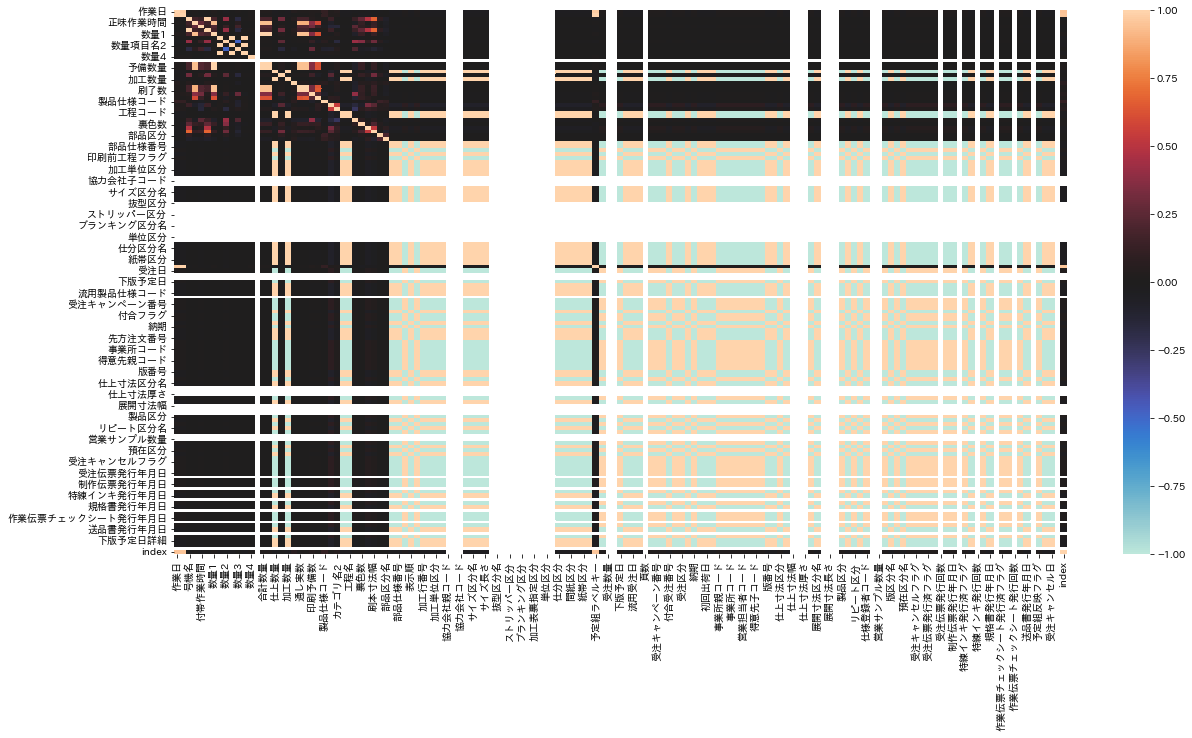

In [ ]:
import japanize_matplotlib
import seaborn as sns
#print("setosa")
plt.figure(figsize=(20, 10))
sns.heatmap(df_train_printer_corr, center=0)


## 正味作業時間

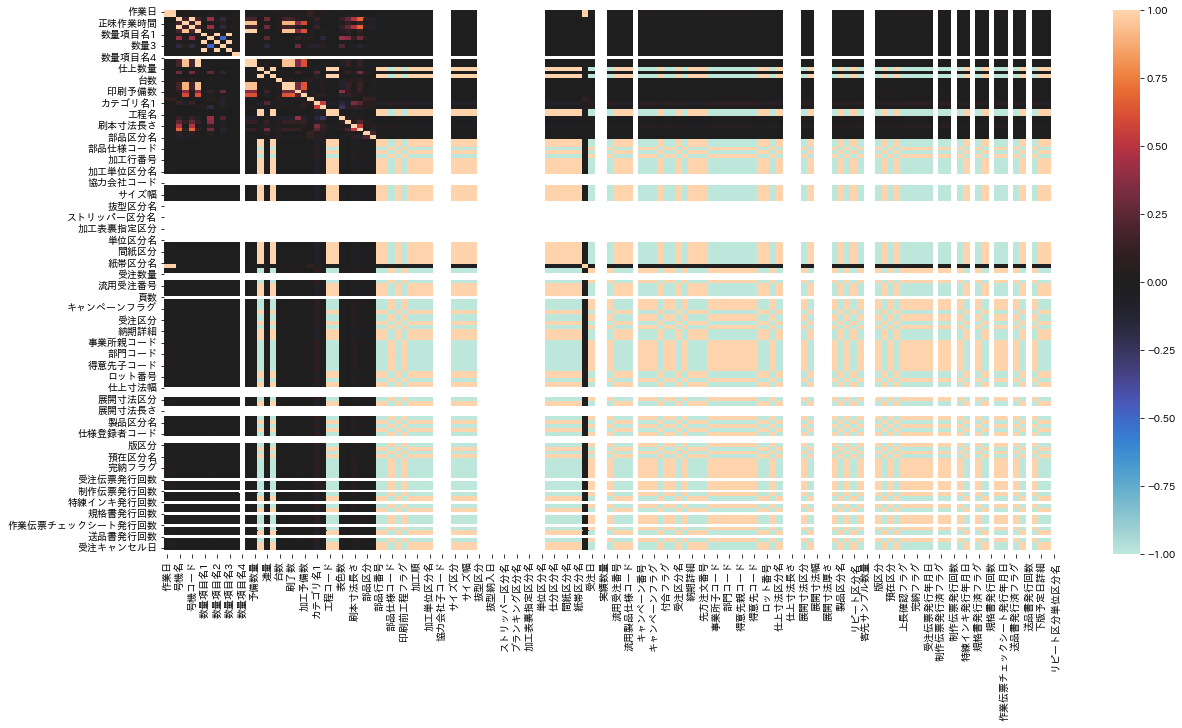

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_train_printer_main_corr, center=0)

In [ ]:
df_train_printer_main_corr_top20 = df_train_printer_main_corr.loc[:, ['正味作業時間']].assign(abs_value=lambda d: np.abs(d['正味作業時間']))\
                    .sort_values('abs_value', ascending=False)\
                    .iloc[1:31, :].index.tolist()
df_train_printer_main_corr_top20

['合計数量',
 '予備数量',
 '数量1',
 '刷了数',
 '通し実数',
 '加工予備数',
 '印刷予備数',
 '号機名',
 '号機コード',
 '刷本寸法幅',
 '裏色数',
 'カテゴリ名1',
 '数量3',
 '部品区分名',
 '表色数',
 '製品仕様コード',
 '作業日',
 '台数',
 '連量',
 '予定組ラベルキー',
 '受注番号',
 '数量2',
 '部品区分',
 '刷本寸法長さ',
 '流用受注番号',
 '受注キャンセル日',
 '流用受注日',
 'ロット番号',
 '流用製品仕様コード',
 '先方注文番号']

## 印刷機ー正味作業時間ー相関係数ー上位３０位を再描画

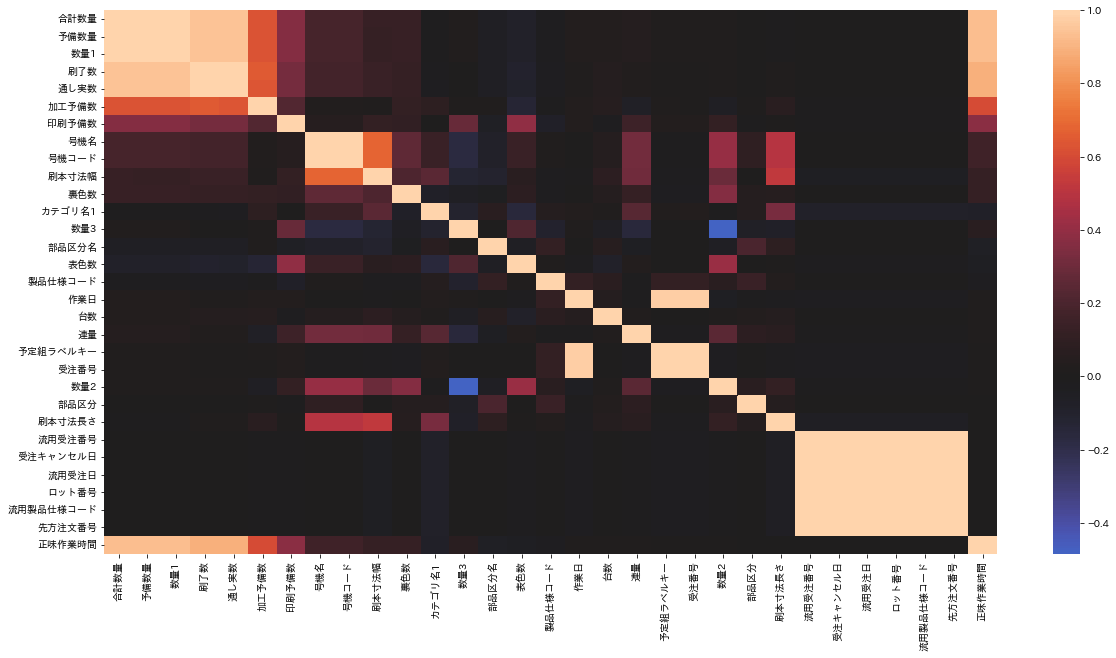

In [ ]:
plt.figure(figsize=(20, 10))
list_tmp=[]
list_tmp = df_train_printer_main_corr_top20.copy()
list_tmp.append("正味作業時間")
df_tmp = df_train_printer_main[list_tmp]
df_tmp_corr = df_tmp.corr()
sns.heatmap(df_tmp_corr, center=0)

In [ ]:
df_train_printer_sub_corr_top20 = df_train_printer_sub_corr.loc[:, ['付帯作業時間']].assign(abs_value=lambda d: np.abs(d['付帯作業時間']))\
                    .sort_values('abs_value', ascending=False)\
                    .iloc[1:31, :].index.tolist()
df_train_printer_sub_corr_top20

['印刷予備数',
 '表色数',
 '合計数量',
 '数量1',
 '予備数量',
 '通し実数',
 '刷了数',
 '数量3',
 'カテゴリ名2',
 '刷本寸法幅',
 '加工予備数',
 'カテゴリ名1',
 '数量2',
 '号機名',
 '号機コード',
 '裏色数',
 '連量',
 '部品区分名',
 '刷本寸法長さ',
 '製品仕様コード',
 '台数',
 '受注番号',
 '受注キャンセル日',
 'ロット番号',
 '流用受注日',
 '流用製品仕様コード',
 '先方注文番号',
 '作業伝票チェックシート発行年月日',
 '部品仕様コード',
 '事業所親コード']

## 印刷機ー付帯作業時間ー相関係数ー上位３０位を再描画

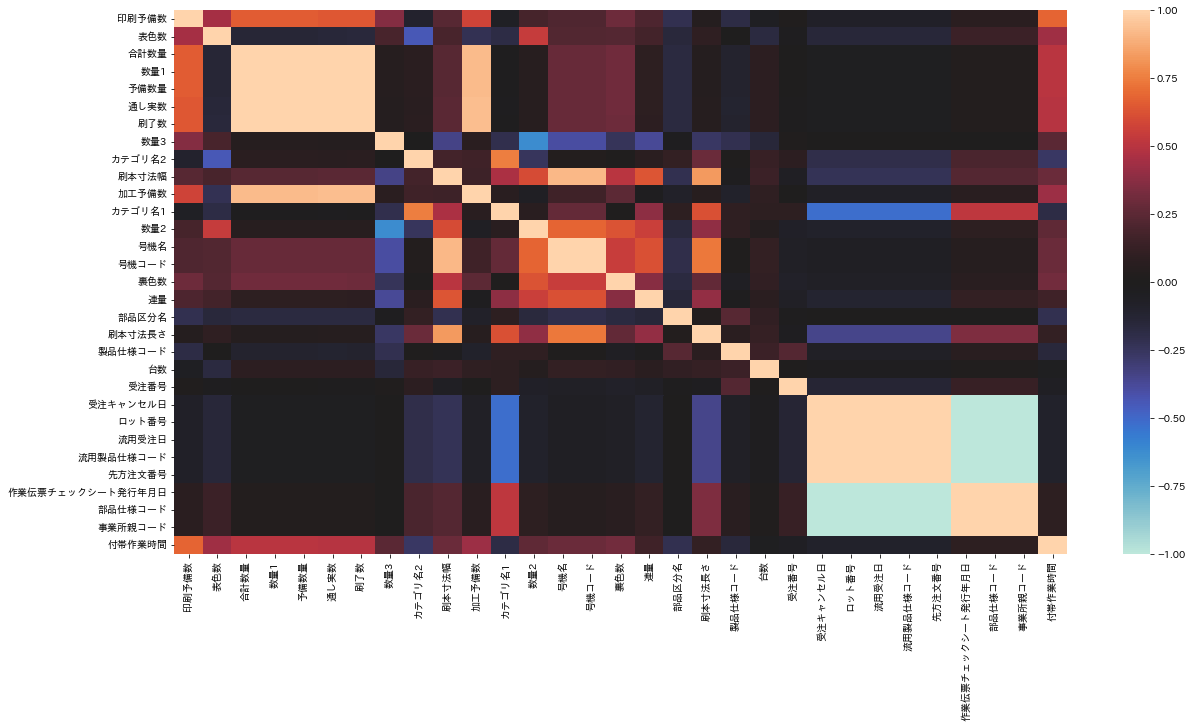

In [ ]:
plt.figure(figsize=(20, 10))
list_tmp = []
list_tmp = df_train_printer_sub_corr_top20.copy()
list_tmp.append("付帯作業時間")
df_tmp = df_train_printer_sub_corr[list_tmp]
df_tmp_corr = df_tmp.corr()
sns.heatmap(df_tmp_corr, center=0)

In [ ]:
df_train_gluer_main = df_train_gluer.copy()
df_train_gluer_sub = df_train_gluer.copy()


df_main = df_train_gluer_main.drop(["index","付帯作業時間"], axis=1)
df_sub  = df_train_gluer_sub.drop(["index","正味作業時間"], axis=1)
df_train_gluer_corr = df_train_gluer.corr()
df_train_gluer_main_corr = df_main.corr()
df_train_gluer_sub_corr = df_sub.corr()

In [ ]:
df_train_gluer_main_corr_top20 = df_train_gluer_main_corr.loc[:, ['正味作業時間']].assign(abs_value=lambda d: np.abs(d['正味作業時間']))\
                    .sort_values('abs_value', ascending=False)\
                    .iloc[1:31, :].index.tolist()
df_train_gluer_main_corr_top20

['数量1',
 '予備数量',
 '合計数量',
 '加工数量',
 '仕上数量',
 '受注数量',
 '営業担当者コード',
 '作業伝票チェックシート発行回数',
 '受注伝票発行回数',
 '実績数量',
 '版番号',
 '特練インキ発行年月日',
 '得意先子コード',
 '受注キャンセルフラグ',
 '部品仕様番号',
 '特練インキ発行回数',
 '受注キャンセル日',
 '頁数',
 '流用製品仕様コード',
 '納期詳細',
 '単位区分',
 '展開寸法厚さ',
 '作業伝票チェックシート発行年月日',
 '得意先親コード',
 '営業サンプル数量',
 '流用受注日',
 '作業伝票チェックシート発行済フラグ',
 '仕上寸法厚さ',
 '流用受注番号',
 '制作伝票発行回数']

## グルア―ー正味作業時間ー相関係数ー上位３０位を再描画

In [ ]:
df_train_gluer_main_corr_top20

['数量1',
 '予備数量',
 '合計数量',
 '加工数量',
 '仕上数量',
 '受注数量',
 '営業担当者コード',
 '作業伝票チェックシート発行回数',
 '受注伝票発行回数',
 '実績数量',
 '版番号',
 '特練インキ発行年月日',
 '得意先子コード',
 '受注キャンセルフラグ',
 '部品仕様番号',
 '特練インキ発行回数',
 '受注キャンセル日',
 '頁数',
 '流用製品仕様コード',
 '納期詳細',
 '単位区分',
 '展開寸法厚さ',
 '作業伝票チェックシート発行年月日',
 '得意先親コード',
 '営業サンプル数量',
 '流用受注日',
 '作業伝票チェックシート発行済フラグ',
 '仕上寸法厚さ',
 '流用受注番号',
 '制作伝票発行回数']

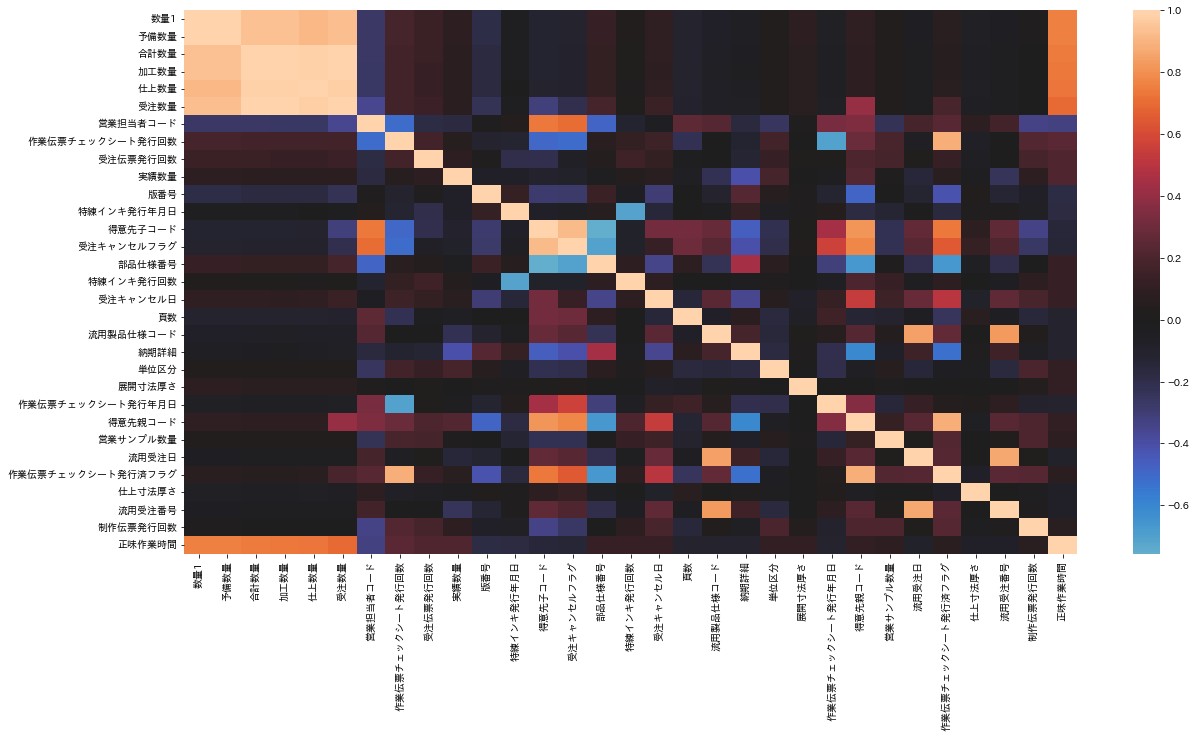

In [ ]:
plt.figure(figsize=(20, 10))
list_tmp=[]
list_tmp = df_train_gluer_main_corr_top20.copy()
list_tmp.append("正味作業時間")
df_tmp = df_train_gluer_main[list_tmp]
df_tmp_corr = df_tmp.corr()
sns.heatmap(df_tmp_corr, center=0)

In [ ]:
df_train_gluer_sub_corr_top20 = df_train_gluer_sub_corr.loc[:, ['付帯作業時間']].assign(abs_value=lambda d: np.abs(d['付帯作業時間']))\
                    .sort_values('abs_value', ascending=False)\
                    .iloc[1:31, :].index.tolist()
df_train_gluer_sub_corr_top20

['カテゴリ名2',
 '数量1',
 '予備数量',
 '得意先親コード',
 '合計数量',
 '加工数量',
 '仕上数量',
 '受注伝票発行年月日',
 '特練インキ発行済フラグ',
 '作業日',
 '受注区分',
 '紙帯区分名',
 'サイズ区分',
 '仕分区分名',
 '印刷前工程フラグ',
 '間紙区分',
 '間紙区分名',
 'カテゴリ名1',
 '仕分区分',
 '受注区分名',
 '部門コード',
 'リピート区分名',
 '紙帯区分',
 '送品書発行済フラグ',
 '送品書発行年月日',
 '表示順',
 '加工順',
 '規格書発行済フラグ',
 'キャンペーンフラグ',
 '作業伝票チェックシート発行済フラグ']

## グルア―ー付帯作業時間ー相関係数ー上位３０位を再描画

In [ ]:
df_train_gluer_sub_corr_top20

['カテゴリ名2',
 '数量1',
 '予備数量',
 '得意先親コード',
 '合計数量',
 '加工数量',
 '仕上数量',
 '受注伝票発行年月日',
 '特練インキ発行済フラグ',
 '作業日',
 '受注区分',
 '紙帯区分名',
 'サイズ区分',
 '仕分区分名',
 '印刷前工程フラグ',
 '間紙区分',
 '間紙区分名',
 'カテゴリ名1',
 '仕分区分',
 '受注区分名',
 '部門コード',
 'リピート区分名',
 '紙帯区分',
 '送品書発行済フラグ',
 '送品書発行年月日',
 '表示順',
 '加工順',
 '規格書発行済フラグ',
 'キャンペーンフラグ',
 '作業伝票チェックシート発行済フラグ']

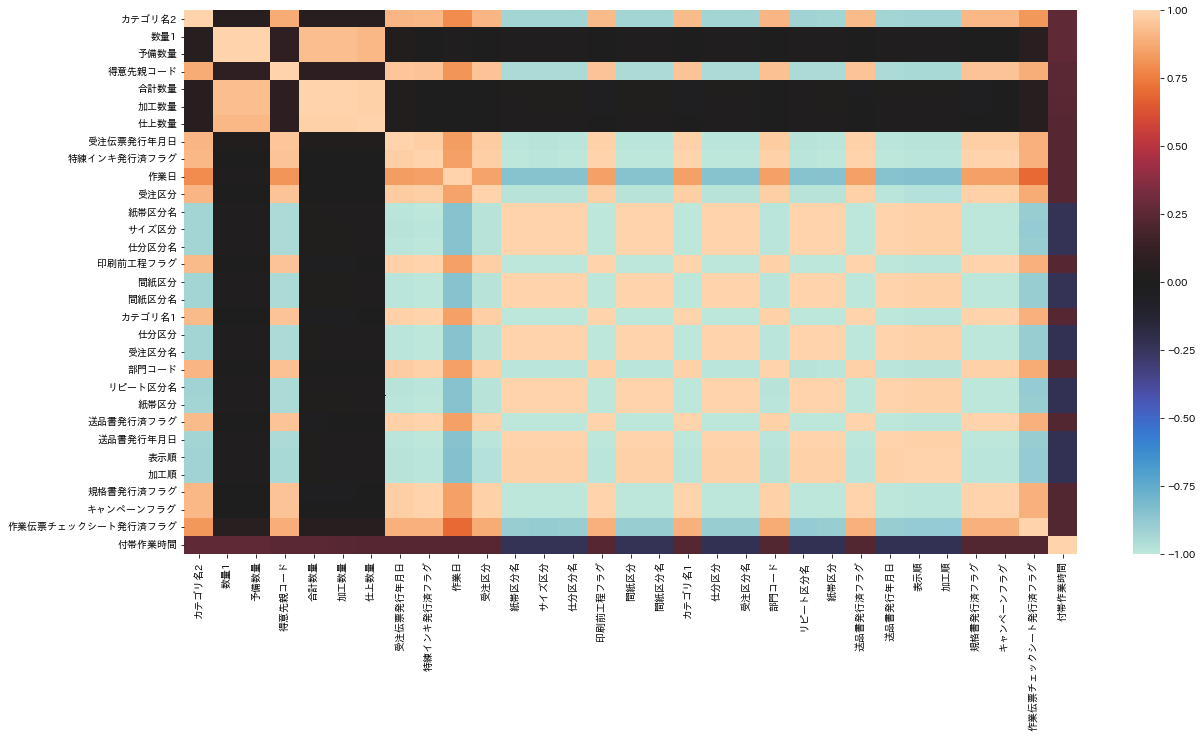

In [ ]:
plt.figure(figsize=(20, 10))
list_tmp=[]
list_tmp = df_train_gluer_sub_corr_top20.copy()
list_tmp.append("付帯作業時間")
df_tmp = df_train_gluer_sub[list_tmp]
df_tmp_corr = df_tmp.corr()
sns.heatmap(df_tmp_corr, center=0)

In [ ]:
df_train_printer_main_corr_top20
df_train_printer_sub_corr_top20
df_train_gluer_main_corr_top20
df_train_gluer_sub_corr_top20

In [ ]:
df_train_printer_main

,作業日,受注番号,号機名,正味作業時間,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,数量項目名4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,協力会社親コード,協力会社子コード,協力会社コード,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,抜型区分,抜型区分名,抜型納入日,ストリッパー区分,ストリッパー区分名,ブランキング区分,ブランキング区分名,加工表裏指定区分,加工表裏指定区分名,単位区分,単位区分名,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー,受注日,受注数量,実績数量,下版予定日,流用受注番号,流用受注日,流用製品仕様コード,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合受注番号,付合フラグ,受注区分,受注区分名,納期,納期詳細,初回出荷日,先方注文番号,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,版番号,ロット番号,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,客先サンプル数量,営業サンプル数量,版区分,版区分名,預在区分,預在区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行年月日,特練インキ発行回数,規格書発行済フラグ,規格書発行年月日,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行年月日,送品書発行回数,予定組反映フラグ,下版予定日詳細,受注キャンセル日,リピート区分単位区分名
9824,189,1725,1,1.0,12.0,250.0,3,0.0,1,1.0,1,0.0,0,50.0,250.0,10.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,1183,0,1,1,1,0.0,0.0,0.0,0.0,2,14,2.0,2.0,431,2.0,0,2.0,2.0,1,3,0,0,1,2,2,939.0,636.0,0,0,0,0,0,0,0,0,0,0,1,1,2,1,1,1,2,1725,184,1.0,0.0,182,536,178,204,48.0,6,6,2,4,1,2,2,206,5,22,89,2,5,7,4,1,1,4,8,14,146,2,3,939.0,636.0,0.0,4,3,939.0,636.0,0.0,2,4,2,3,15,0.0,0.0,6,3,0,1,2,1,1,1,18,28.0,2,147,1.0,0,42,0.0,0,9,0.0,1,893,1.0,0,1,0.0,1,4,181,0
10565,318,1860,3,5.0,14.0,750.0,3,2.0,1,2.0,1,0.0,0,750.0,750.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,264,3,1,0,0,4.0,0.0,650.0,950.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1860,244,NaN,NaN,251,535,177,203,NaN,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,NaN,NaN,NaN,6,0,NaN,NaN,NaN,4,0,5,0,37,NaN,NaN,8,0,3,0,3,3,2,2,36,NaN,3,195,NaN,2,41,NaN,2,8,NaN,2,1042,NaN,1,0,NaN,2,3,180,0
10567,318,1861,3,5.0,14.0,750.0,3,2.0,1,2.0,1,0.0,0,750.0,750.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,266,3,1,0,0,4.0,0.0,650.0,950.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1862,244,NaN,NaN,251,535,177,203,NaN,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,NaN,NaN,NaN,6,0,NaN,NaN,NaN,4,0,5,0,37,NaN,NaN,8,0,3,0,3,3,2,2,36,NaN,3,195,NaN,2,41,NaN,2,8,NaN,2,1042,NaN,1,0,NaN,2,3,180,0
12574,319,2220,4,18.0,15.0,2500.0,3,8.0,1,0.0,1,0.0,0,2500.0,2500.0,0.0,48.5,0.0,1.0,2003.0,2100.0,400.0,97.0,1123,3,14,0,0,4.0,4.0,636.0,939.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2222,244,NaN,NaN,251,535,177,203,NaN,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,NaN,NaN,NaN,6,0,NaN,NaN,NaN,4,0,5,0,37,NaN,NaN,8,0,3,0,3,3,2,2,36,NaN,3,195,NaN,2,41,NaN,2,8,NaN,2,1042,NaN,1,0,NaN,2,3,180,0
12900,258,2275,2,25.0,13.0,2000.0,3,4.0,1,0.0,1,0.0,0,2000.0,2000.0,0.0,45.0,0.0,1.0,1000.0,1000.0,1000.0,0.0,151,3,14,0,0,1.0,1.0,544.0,788.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2277,244,NaN,NaN,251,535,177,203,NaN,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,NaN,NaN,NaN,6,0,NaN,NaN,NaN,4,0,5,0,37,NaN,NaN,8,0,3,0,3,3,2,2,36,NaN,3,195,NaN,2,41,NaN,2,8,NaN,2,1042,NaN,1,0,NaN,2,3,180,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23705,497,9887,3,15.0,14.0,2000.0,3,4.0,1,1.0,1,0.0,0,2000.0,2000.0,0.0,135.0,0.0,2.0,1501.0,1700.0,300.0,199.0,3414,3,10,0,0,5.0,0.0,544.0,788.0,1,13,0.0,0

In [ ]:
class config:
    run_type = 'colab'
    random_seed = 1026
    nfold = 5
    main_target = '正味作業時間'
    sub_target = '付帯作業時間'

In [ ]:
def group_kfold_split(df, col_group, n_splits, random_state):

    group_id = df[col_group].value_counts().reset_index()
    group_id.columns = [col_group, 'count']
    group_id_list = group_id[col_group].unique()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    kf_list = list(kf.split(group_id_list))
    cv_idx = [(df[col_group].isin(group_id_list[idx_trn]), df[col_group].isin(group_id_list[idx_val])) for idx_trn, idx_val in kf_list]

    return [(df[idx_trn].index.tolist(), df[idx_val].index.tolist()) for idx_trn, idx_val in cv_idx]

In [ ]:
kf = KFold(n_splits=config.nfold, shuffle=True, random_state=config.random_seed)
#kf_cv = list(kf.split(df_train))
#gkf_cv = group_kfold_split(df_train, config.main_target, n_splits=config.nfold, random_state=config.random_seed)
#gkf_cv = group_kfold_split(df_train, 'cluster', n_splits=config.nfold, random_state=config.random_seed)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 25.4 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 210 kB 52.9 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 147 kB 73.5 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 112 kB 53.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=e8ac57c0b2baa598f8f51a811e90b05905204754d81417bccb49641ca8397b31
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled importlib-metadata-5.1.0


In [ ]:
"""

SEED = 0
params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}
"""

In [ ]:
optuna_model_params = {'boosting_type': 'gbdt',
                    #'metric': 'rmse',
                    'metric': 'l1',
                    'learning_rate': 0.035,
                    'random_state': config.random_seed,
                    'verbose': -1,
                    'show_progress_bar ': False,
                    'device': 'cpu',
                    'min_child_samples': 100, 
                    }

oputuna_fit_params ={'num_boost_rounds': 600,
                 'early_stopping_rounds': 400,
                 'verbose_eval': 100,
                }
"""
oputuna_fit_params ={
    'objective': 'regression',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate':0.035,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
                }
"""

'\noputuna_fit_params ={\n    \'objective\': \'regression\',\n    \'num_leaves\': 42,\n    \'max_depth\': 7,\n    "feature_fraction": 0.8,\n    \'subsample_freq\': 1,\n    "bagging_fraction": 0.95,\n    \'min_data_in_leaf\': 2,\n    \'learning_rate\':0.035,\n    "boosting": "gbdt",\n    "lambda_l1": 0.1,\n    "lambda_l2": 10,\n    "verbosity": -1,\n    "random_state": 42,\n    "num_boost_round": 50000,\n    "early_stopping_rounds": 100\n                }\n'

In [ ]:
from sklearn.metrics import mean_absolute_error
def cal_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [ ]:
def cal_rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
"""
CF = ['受注番号', '号機名', '数量項目名1', '数量項目名2', '数量項目名3', '数量項目名4', '製品仕様コード', 'カテゴリ名1', 'カテゴリ名2', '工程コード', '工程名', '部品区分', '部品区分名', '部品仕様コード',
 '印刷前工程フラグ', '加工単位区分', '加工単位区分名', '協力会社親コード', '協力会社子コード', '協力会社コード', 'サイズ区分', 'サイズ区分名',
'抜型区分名', '抜型納入日', 'ストリッパー区分', 'ストリッパー区分名', 'ブランキング区分', 'ブランキング区分名', '加工表裏指定区分', '加工表裏指定区分名',
'単位区分', '単位区分名', '仕分区分', '仕分区分名', '間紙区分', '間紙区分名', '紙帯区分', '紙帯区分名',
'予定組ラベルキー', '受注日', '下版予定日', '流用受注番号', '流用受注日', '流用製品仕様コード', 'キャンペーン番号', '受注キャンペーン番号',
'キャンペーンフラグ', '付合受注番号', '付合フラグ', '受注区分', '受注区分名', '納期', '納期詳細', '初回出荷日',
'先方注文番号', '事業所親コード', '事業所子コード', '事業所コード', '部門コード', '営業担当者コード', '得意先親コード', '得意先子コード', '得意先コード',
'版番号', 'ロット番号', '仕上寸法区分', '仕上寸法区分名', '展開寸法区分', '展開寸法区分名', '製品区分', '製品区分名', 'リピート区分', 'リピート区分名', '仕様登録者コード',
'版区分', '版区分名', '預在区分', '預在区分名', '上長確認フラグ', '受注キャンセルフラグ', '完納フラグ', '受注伝票発行済フラグ', '受注伝票発行年月日', '制作伝票発行済フラグ', '制作伝票発行年月日',
'特練インキ発行済フラグ', '特練インキ発行年月日', '規格書発行済フラグ', '規格書発行年月日', '作業伝票チェックシート発行済フラグ', '作業伝票チェックシート発行年月日', '送品書発行済フラグ', '送品書発行年月日',
'予定組反映フラグ', '下版予定日詳細', '受注キャンセル日', 'リピート区分単位区分名'
]
"""

In [ ]:
import optuna.integration.lightgbm as opt_lgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files
from tqdm.notebook import tqdm
import warnings
import re
warnings.simplefilter('ignore')
lgb_results = {} 
_loss_train = None
_loss_test = None
def fit_lgb_oputuna(x, y, cv, model_params, fit_params, fobj=None, feval=None):

    models = []
    n_records = y.shape[0]
    oof_pred = np.zeros(n_records, dtype=np.float32)
    fold = 0
    data_labels = [re.sub(r'[",\[\]{}:()]', '_', c) for c in x.columns.tolist()]
    print("data_labels:",data_labels)
    
    model_params.update(deterministic = True)

    best_params, history = {}, []
    best_params_list = []

    for trn_idx, val_idx in cv:

        fold += 1
        print("\n★★★★★　　　　　Fold {}　　　　　★★★★★".format(fold))
        #print(f"trn_idx :{trn_idx}")
        #print(f"val_idx :{val_idx}")

        x_train, x_valid = x.iloc[trn_idx].values, x.iloc[val_idx].values
        y_train, y_valid = np.array(y.iloc[trn_idx]), np.array(y.iloc[val_idx])

        lgb_train = lgb.Dataset(x_train, y_train, feature_name=data_labels)
        lgb_valid = lgb.Dataset(x_valid, y_valid, feature_name=data_labels, reference=lgb_train)

        lgb_results = {}                                    # 学習の履歴を入れる入物

        lgb_model = opt_lgb.train(model_params,
                              train_set=lgb_train,
                              valid_sets=[lgb_train, lgb_valid],
                              valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                              evals_result=lgb_results,
                              verbose_eval=-1,
                              num_boost_round=5000,
                              early_stopping_rounds=1000,         # アーリーストッピング設定
                              show_progress_bar = False,
                              time_budget = 10000,
                              #categorical_feature = CF
                              )

        #callbacks=[opt_lgb.early_stopping(oputuna_fit_params['early_stopping_rounds'])],
        pred_valid = lgb_model.predict(x_valid, num_iteration=lgb_model.best_iteration)
        oof_pred[val_idx] = pred_valid
        models.append(lgb_model)

        try:  
            best_params = lgb_model.params
            best_params_list.append(best_params)

            print("▼▼▼▼▼　　　　　Fold {}　　　　　▼▼▼▼▼".format(fold))
            print("best_params：",best_params)
            print("▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲")
        except:
            print('★★★★★　best_param output Error')


        # 損失推移を表示
        """
        loss_train = lgb_results['Train']['rmse']
        loss_test = lgb_results['Test']['rmse']   
        """
        loss_train = lgb_results['Train']['l1']
        loss_test = lgb_results['Test']['l1'] 
        _loss_train = loss_train
        _loss_test = loss_test
        
        fig = plt.figure()
        
        plt.xlabel('Iteration')
        plt.ylabel('rmse')

        plt.title(f"fold:{fold}")
        plt.plot(loss_train, label='train loss')
        plt.plot(loss_test, label='test loss')

        ax = plt.gca() # get current axes 現在の軸設定データを取得する
        #ax.set_ylim(18.0, 20.0)

        plt.legend()
        plt.show()


        #print(f' - fold{fold}_RMSE : {cal_rmse(y_valid, pred_valid):4f}')
        print(f' - fold{fold}_MAE : {cal_mae(y_valid, pred_valid):4f}')
        
        # modelの保存
        try:        
            file_path = f'models/models_gpu_' + str(fold -1) + '.pkl'
            with open(file_path, 'wb') as f:
                pickle.dump(lgb_model, f)
            
            file_path = f'models/models_gpu_all.pkl'
            with open(file_path, 'wb') as f:
                pickle.dump(models, f)

            file_path = f'models/oof_pred.pkl'
            with open(file_path, 'wb') as f:
                pickle.dump(oof_pred, f)


            file_path = f'models/opt_lgb_gpu.pkl'
            with open(file_path, 'wb') as f:
                pickle.dump(lgb_model, f)
        except:
            print('★★★★★　opt_lgb.pkl Save Error')


    #print(f' - CV_MAE : {cal_rmse(oof_pred, np.array(y)):4f}') 
    print(f' - CV_MAE : {cal_mae(oof_pred, np.array(y)):4f}') 

    file_path = f'models/lgb_models1.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(models, f)

    file_path = f'models/oof_valid_lgb1.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(oof_pred, f)

    return oof_pred, models

In [ ]:
df_train_printer.columns

Index(['作業日', '受注番号', '号機名', '正味作業時間', '付帯作業時間', '号機コード', '数量1', '数量項目名1',
       '数量2', '数量項目名2',
       ...
       '作業伝票チェックシート発行年月日', '作業伝票チェックシート発行回数', '送品書発行済フラグ', '送品書発行年月日',
       '送品書発行回数', '予定組反映フラグ', '下版予定日詳細', '受注キャンセル日', 'リピート区分単位区分名', 'index'],
      dtype='object', length=145)

## 正味作業時間 ー 印刷機　の学習

In [ ]:
df_main_printer = df_train_printer_main[df_train_printer_main_corr_top20]
target = df_train_printer[config.main_target]

In [ ]:
target

9824      1.0
10565     5.0
10567     5.0
12574    18.0
12900    25.0
         ... 
23705    15.0
23706     4.0
23707     3.0
23708     5.0
23710     3.0
Name: 正味作業時間, Length: 7824, dtype: float64

In [ ]:
#autofeat_printer_main_mdl = AutoFeatRegressor(verbose=1)

In [ ]:
"""
df_tmp_main = df_main_printer.copy()
df_tmp_main = df_tmp_main.fillna(0)
df_tmp_main
"""

,合計数量,予備数量,数量1,刷了数,通し実数,加工予備数,印刷予備数,号機名,号機コード,刷本寸法幅,裏色数,カテゴリ名1,数量3,部品区分名,表色数,製品仕様コード,作業日,台数,連量,予定組ラベルキー,受注番号,数量2,部品区分,刷本寸法長さ,流用受注番号,受注キャンセル日,流用受注日,ロット番号,流用製品仕様コード,先方注文番号
9824,50.0,250.0,250.0,0.0,0.0,0.0,0.0,1,12.0,0.0,0.0,0,1.0,14,0.0,1183,189,1.0,0.0,1725,1725,0.0,2,0.0,536,181,178,146,204,89
10565,750.0,750.0,750.0,450.0,300.0,150.0,300.0,3,14.0,950.0,0.0,3,2.0,13,4.0,264,318,1.0,27.5,1860,1860,2.0,1,650.0,535,180,177,145,203,88
10567,750.0,750.0,750.0,450.0,300.0,150.0,300.0,3,14.0,950.0,0.0,3,2.0,13,4.0,266,318,1.0,27.5,1862,1861,2.0,1,650.0,535,180,177,145,203,88
12574,2500.0,2500.0,2500.0,2100.0,2003.0,97.0,400.0,4,15.0,939.0,4.0,3,0.0,13,4.0,1123,319,1.0,48.5,2222,2220,8.0,1,636.0,535,180,177,145,203,88
12900,2000.0,2000.0,2000.0,1000.0,1000.0,0.0,1000.0,2,13.0,788.0,1.0,3,0.0,13,1.0,151,258,1.0,45.0,2277,2275,4.0,1,544.0,535,180,177,145,203,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23705,2000.0,2000.0,2000.0,1700.0,1501.0,199.0,300.0,3,14.0,788.0,0.0,3,1.0,13,5.0,3414,497,2.0,135.0,11410,9887,4.0,1,544.0,535,180,177,145,203,88
23706,800.0,800.0,800.0,400.0,334.0,66.0,400.0,0,11.0,640.0,1.0,3,0.0,13,4.0,804,499,1.0,15.5,11456,9927,1.0,1,468.0,535,180,177,145,203,88
23707,600.0,600.0,600.0,200.0,32.0,168.0,400.0,3,14.0,800.0,1.0,3,0.0,13,5.0,2485,501,1.0,35.0,11460,9931,1.0,1,548.0,535,180,177,145,203,88
23708,300.0,300.0,300.0,15.0,5.0,10.0,285.0,1,12.0,940.0,0.0,3,0.0,13,4.0,3526,500,3.0,16.0,11491,9955,4.0,21,640.0,535,180,177,145,203,88


In [ ]:
"""
# 特徴量生成（学習データ利用）
X_train_feature = autofeat_printer_main_mdl.fit_transform(df_tmp_main, target)
X_train_feature.columns
X_train_feature
"""

[AutoFeat] The 2 step feature engineering process could generate up to 22155 features.
[AutoFeat] With 7824 data points this new feature matrix would use about 0.69 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 81 transformed features from 30 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 5937 feature combinations from 6105 original feature tuples - done.
[feateng] Generated altogether 6169 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 3129 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 27 features after 5 feature selection runs
[featsel] 15 features after correlation filtering
[featsel] 12 features after noise filterin

,合計数量,予備数量,数量1,刷了数,通し実数,加工予備数,印刷予備数,号機名,号機コード,刷本寸法幅,裏色数,カテゴリ名1,数量3,部品区分名,表色数,製品仕様コード,作業日,台数,連量,予定組ラベルキー,受注番号,数量2,部品区分,刷本寸法長さ,流用受注番号,受注キャンセル日,流用受注日,ロット番号,流用製品仕様コード,先方注文番号,刷了数*数量3,刷了数/部品区分,sqrt(刷了数)*sqrt(印刷予備数),sqrt(合計数量)/部品区分名,合計数量*sqrt(製品仕様コード),刷了数*表色数,sqrt(数量1)*sqrt(表色数),カテゴリ名1**3*sqrt(台数),sqrt(加工予備数)*sqrt(数量1),sqrt(作業日)*exp(カテゴリ名1)
0,50.0,250.0,250.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0,0.0,0.0,1.0,14.0,0.0,1183.0,189.0,1.0,0.0,1725.0,1725.0,0.0,2.0,0.0,536.0,181.0,178.0,146.0,204.0,89.0,0.0,0.000000,0.000000,0.505076,1719.738352,0.0,0.000000,0.000000,0.000000,13.747727
1,750.0,750.0,750.0,450.0,300.0,150.0,300.0,3.0,14.0,950.0,0.0,3.0,2.0,13.0,4.0,264.0,318.0,1.0,27.5,1860.0,1860.0,2.0,1.0,650.0,535.0,180.0,177.0,145.0,203.0,88.0,900.0,450.000000,367.423461,2.106625,12186.057607,1800.0,54.772256,27.000000,335.410197,358.176432
2,750.0,750.0,750.0,450.0,300.0,150.0,300.0,3.0,14.0,950.0,0.0,3.0,2.0,13.0,4.0,266.0,318.0,1.0,27.5,1862.0,1861.0,2.0,1.0,650.0,535.0,180.0,177.0,145.0,203.0,88.0,900.0,450.000000,367.423461,2.106625,12232.129823,1800.0,54.772256,27.000000,335.410197,358.176432
3,2500.0,2500.0,2500.0,2100.0,2003.0,97.0,400.0,4.0,15.0,939.0,4.0,3.0,0.0,13.0,4.0,1123.0,319.0,1.0,48.5,2222.0,2220.0,8.0,1.0,636.0,535.0,180.0,177.0,145.0,203.0,88.0,0.0,2100.000000,916.515139,3.846154,83777.980401,8400.0,100.000000,27.000000,492.442890,358.739160
4,2000.0,2000.0,2000.0,1000.0,1000.0,0.0,1000.0,2.0,13.0,788.0,1.0,3.0,0.0,13.0,1.0,151.0,258.0,1.0,45.0,2277.0,2275.0,4.0,1.0,544.0,535.0,180.0,177.0,145.0,203.0,88.0,0.0,1000.000000,1000.000000,3.440105,24576.411455,1000.0,44.721360,27.000000,0.000000,322.621495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7819,2000.0,2000.0,2000.0,1700.0,1501.0,199.0,300.0,3.0,14.0,788.0,0.0,3.0,1.0,13.0,5.0,3414.0,497.0,2.0,135.0,11410.0,9887.0,4.0,1.0,544.0,535.0,180.0,177.0,145.0,203.0,88.0,1700.0,1700.000000,714.142843,3.440105,116858.889264,8500.0,100.000000,38.183766,630.872412,447.776853
7820,800.0,800.0,800.0,400.0,334.0,66.0,400.0,0.0,11.0,640.0,1.0,3.0,0.0,13.0,4.0,804.0,499.0,1.0,15.5,11456.0,9927.0,1.0,1.0,468.0,535.0,180.0,177.0,145.0,203.0,88.0,0.0,400.000000,400.000000,2.175713,22683.915006,1600.0,56.568542,27.000000,229.782506,448.676908
7821,600.0,600.0,600.0,200.0,32.0,168.0,400.0,3.0,14.0,800.0,1.0,3.0,0.0,13.0,5.0,2485.0,501.0,1.0,35.0,11460.0,9931.0,1.0,1.0,548.0,535.0,180.0,177.0,145.0,203.0,88.0,0.0,200.000000,282.842712,1.884223,29909.864593,1000.0,54.772256,27.000000,317.490157,449.575161
7822,300.0,300.0,300.0,15.0,5.0,10.0,285.0,1.0,12.0,940.0,0.0,3.0,0.0,13.0,4.0,3526.0,500.0,3.0,16.0,11491.0,9955.0,4.0,21.0,640.0,535.0,180.0,177.0,145.0,203.0,88.0,0.0,0.714286,65.383484,1.332347,17814.039407,60.0,34.641016,46.765372,54.772256,449.126259


In [ ]:
"""
df_main_printer_test = df_test_printer[df_train_printer_main_corr_top20]
df_sub_printer_test = df_test_printer[df_train_printer_sub_corr_top20]
df_main_gluer_test = df_test_gluer[df_train_printer_main_corr_top20]
df_sub_gluer_test = df_test_gluer[df_train_printer_sub_corr_top20]
"""

In [ ]:
X_test_main_printer_feature = autofeat_printer_main_mdl.transform(df_main_printer_test)

[AutoFeat] Computing 10 new features.
[AutoFeat]    10/   10 new features ...done.


In [ ]:
autofeat_printer_sub_mdl = AutoFeatRegressor(verbose=1)

In [ ]:
df_sub_printer = df_train_printer_sub[df_train_printer_sub_corr_top20]
sub_target = df_train_printer[config.sub_target]

In [ ]:
df_tmp_sub = df_sub_printer.copy()
df_tmp_sub = df_tmp_sub.fillna(0)
df_tmp_sub

,印刷予備数,表色数,合計数量,数量1,予備数量,通し実数,刷了数,数量3,カテゴリ名2,刷本寸法幅,加工予備数,カテゴリ名1,数量2,号機名,号機コード,裏色数,連量,部品区分名,刷本寸法長さ,製品仕様コード,台数,受注番号,受注キャンセル日,ロット番号,流用受注日,流用製品仕様コード,先方注文番号,作業伝票チェックシート発行年月日,部品仕様コード,事業所親コード
9824,0.0,0.0,50.0,250.0,250.0,0.0,0.0,1.0,1,0.0,0.0,0,0.0,1,12.0,0.0,0.0,14,0.0,1183,1.0,1725,181,146,178,204,89,893,431,2
10565,300.0,4.0,750.0,750.0,750.0,300.0,450.0,2.0,1,950.0,150.0,3,2.0,3,14.0,0.0,27.5,13,650.0,264,1.0,1860,180,145,177,203,88,1042,465,3
10567,300.0,4.0,750.0,750.0,750.0,300.0,450.0,2.0,1,950.0,150.0,3,2.0,3,14.0,0.0,27.5,13,650.0,266,1.0,1861,180,145,177,203,88,1042,465,3
12574,400.0,4.0,2500.0,2500.0,2500.0,2003.0,2100.0,0.0,14,939.0,97.0,3,8.0,4,15.0,4.0,48.5,13,636.0,1123,1.0,2220,180,145,177,203,88,1042,465,3
12900,1000.0,1.0,2000.0,2000.0,2000.0,1000.0,1000.0,0.0,14,788.0,0.0,3,4.0,2,13.0,1.0,45.0,13,544.0,151,1.0,2275,180,145,177,203,88,1042,465,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23705,300.0,5.0,2000.0,2000.0,2000.0,1501.0,1700.0,1.0,10,788.0,199.0,3,4.0,3,14.0,0.0,135.0,13,544.0,3414,2.0,9887,180,145,177,203,88,1042,465,3
23706,400.0,4.0,800.0,800.0,800.0,334.0,400.0,0.0,8,640.0,66.0,3,1.0,0,11.0,1.0,15.5,13,468.0,804,1.0,9927,180,145,177,203,88,1042,465,3
23707,400.0,5.0,600.0,600.0,600.0,32.0,200.0,0.0,17,800.0,168.0,3,1.0,3,14.0,1.0,35.0,13,548.0,2485,1.0,9931,180,145,177,203,88,1042,465,3
23708,285.0,4.0,300.0,300.0,300.0,5.0,15.0,0.0,17,940.0,10.0,3,4.0,1,12.0,0.0,16.0,13,640.0,3526,3.0,9955,180,145,177,203,88,1042,465,3


In [ ]:
# 特徴量生成（学習データ利用）
X_printer_sub_feature = autofeat_printer_sub_mdl.fit_transform(df_tmp_sub, sub_target)
X_printer_sub_feature.columns
X_printer_sub_feature

[AutoFeat] The 2 step feature engineering process could generate up to 22155 features.
[AutoFeat] With 7824 data points this new feature matrix would use about 0.69 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 70 transformed features from 30 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 4757 feature combinations from 4950 original feature tuples - done.
[feateng] Generated altogether 5013 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 2465 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 24 features after 5 feature selection runs
[featsel] 17 features after correlation filtering
[featsel] 13 features after noise filterin

,印刷予備数,表色数,合計数量,数量1,予備数量,通し実数,刷了数,数量3,カテゴリ名2,刷本寸法幅,加工予備数,カテゴリ名1,数量2,号機名,号機コード,裏色数,連量,部品区分名,刷本寸法長さ,製品仕様コード,台数,受注番号,受注キャンセル日,ロット番号,流用受注日,流用製品仕様コード,先方注文番号,作業伝票チェックシート発行年月日,部品仕様コード,事業所親コード,sqrt(カテゴリ名2)/号機コード,sqrt(刷本寸法幅)*sqrt(印刷予備数),数量3*exp(号機名),sqrt(刷本寸法幅)*sqrt(表色数),sqrt(予備数量)*表色数,数量3*sqrt(通し実数),加工予備数**3*sqrt(裏色数),数量3**2*exp(号機名),sqrt(刷了数)*数量3**2,sqrt(印刷予備数)/部品区分名,加工予備数**3*sqrt(数量3),sqrt(印刷予備数)*log(製品仕様コード)
0,0.0,0.0,50.0,250.0,250.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0,0.0,14.0,0.0,1183.0,1.0,1725.0,181.0,146.0,178.0,204.0,89.0,893.0,431.0,2.0,0.083333,0.000000,2.718282,0.000000,0.000000,0.000000,0.000000e+00,2.718282,0.000000,0.000000,0.000000e+00,0.000000
1,300.0,4.0,750.0,750.0,750.0,300.0,450.0,2.0,1.0,950.0,150.0,3.0,2.0,3.0,14.0,0.0,27.5,13.0,650.0,264.0,1.0,1860.0,180.0,145.0,177.0,203.0,88.0,1042.0,465.0,3.0,0.071429,533.853913,40.171074,61.644140,109.544512,34.641016,0.000000e+00,80.342148,84.852814,1.332347,4.772971e+06,96.578271
2,300.0,4.0,750.0,750.0,750.0,300.0,450.0,2.0,1.0,950.0,150.0,3.0,2.0,3.0,14.0,0.0,27.5,13.0,650.0,266.0,1.0,1861.0,180.0,145.0,177.0,203.0,88.0,1042.0,465.0,3.0,0.071429,533.853913,40.171074,61.644140,109.544512,34.641016,0.000000e+00,80.342148,84.852814,1.332347,4.772971e+06,96.708993
3,400.0,4.0,2500.0,2500.0,2500.0,2003.0,2100.0,0.0,14.0,939.0,97.0,3.0,8.0,4.0,15.0,4.0,48.5,13.0,636.0,1123.0,1.0,2220.0,180.0,145.0,177.0,203.0,88.0,1042.0,465.0,3.0,0.249444,612.862138,0.000000,61.286214,200.000000,0.000000,1.825346e+06,0.000000,0.000000,1.538462,0.000000e+00,140.475179
4,1000.0,1.0,2000.0,2000.0,2000.0,1000.0,1000.0,0.0,14.0,788.0,0.0,3.0,4.0,2.0,13.0,1.0,45.0,13.0,544.0,151.0,1.0,2275.0,180.0,145.0,177.0,203.0,88.0,1042.0,465.0,3.0,0.287820,887.693641,0.000000,28.071338,44.721360,0.000000,0.000000e+00,0.000000,0.000000,2.432521,0.000000e+00,158.660319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7819,300.0,5.0,2000.0,2000.0,2000.0,1501.0,1700.0,1.0,10.0,788.0,199.0,3.0,4.0,3.0,14.0,0.0,135.0,13.0,544.0,3414.0,2.0,9887.0,180.0,145.0,177.0,203.0,88.0,1042.0,465.0,3.0,0.225877,486.209831,20.085537,62.769419,223.606798,38.742741,0.000000e+00,20.085537,41.231056,1.332347,7.880599e+06,140.913417
7820,400.0,4.0,800.0,800.0,800.0,334.0,400.0,0.0,8.0,640.0,66.0,3.0,1.0,0.0,11.0,1.0,15.5,13.0,468.0,804.0,1.0,9927.0,180.0,145.0,177.0,203.0,88.0,1042.0,465.0,3.0,0.257130,505.964426,0.000000,50.596443,113.137085,0.000000,2.874960e+05,0.000000,0.000000,1.538462,0.000000e+00,133.791985
7821,400.0,5.0,600.0,600.0,600.0,32.0,200.0,0.0,17.0,800.0,168.0,3.0,1.0,3.0,14.0,1.0,35.0,13.0,548.0,2485.0,1.0,9931.0,180.0,145.0,177.0,203.0,88.0,1042.0,465.0,3.0,0.294508,565.685425,0.000000,63.245553,122.474487,0.000000,4.741632e+06,0.000000,0.000000,1.538462,0.000000e+00,156.360559
7822,285.0,4.0,300.0,300.0,300.0,5.0,15.0,0.0,17.0,940.0,10.0,3.0,4.0,1.0,12.0,0.0,16.0,13.0,640.0,3526.0,3.0,9955.0,180.0,145.0,177.0,203.0,88.0,1042.0,465.0,3.0,0.343592,517.590572,0.000000,61.318839,69.282032,0.000000,0.000000e+00,0.000000,0.000000,1.298611,0.000000e+00,137.890349


In [ ]:
X_test_sub_printer_feature = autofeat_printer_sub_mdl.transform(df_sub_printer_test)

[AutoFeat] Computing 12 new features.
[AutoFeat]    12/   12 new features ...done.


In [ ]:
target.shape

(7824,)

In [ ]:
df_main_printer

,合計数量,予備数量,数量1,刷了数,通し実数,加工予備数,印刷予備数,号機名,号機コード,刷本寸法幅,裏色数,カテゴリ名1,数量3,部品区分名,表色数,製品仕様コード,作業日,台数,連量,予定組ラベルキー,受注番号,数量2,部品区分,刷本寸法長さ,流用受注番号,受注キャンセル日,流用受注日,ロット番号,流用製品仕様コード,先方注文番号
9824,50.0,250.0,250.0,0.0,0.0,0.0,0.0,1,12.0,0.0,0.0,0,1.0,14,0.0,1183,189,1.0,0.0,1725,1725,0.0,2,0.0,536,181,178,146,204,89
10565,750.0,750.0,750.0,450.0,300.0,150.0,300.0,3,14.0,950.0,0.0,3,2.0,13,4.0,264,318,1.0,27.5,1860,1860,2.0,1,650.0,535,180,177,145,203,88
10567,750.0,750.0,750.0,450.0,300.0,150.0,300.0,3,14.0,950.0,0.0,3,2.0,13,4.0,266,318,1.0,27.5,1862,1861,2.0,1,650.0,535,180,177,145,203,88
12574,2500.0,2500.0,2500.0,2100.0,2003.0,97.0,400.0,4,15.0,939.0,4.0,3,0.0,13,4.0,1123,319,1.0,48.5,2222,2220,8.0,1,636.0,535,180,177,145,203,88
12900,2000.0,2000.0,2000.0,1000.0,1000.0,0.0,1000.0,2,13.0,788.0,1.0,3,0.0,13,1.0,151,258,1.0,45.0,2277,2275,4.0,1,544.0,535,180,177,145,203,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23705,2000.0,2000.0,2000.0,1700.0,1501.0,199.0,300.0,3,14.0,788.0,0.0,3,1.0,13,5.0,3414,497,2.0,135.0,11410,9887,4.0,1,544.0,535,180,177,145,203,88
23706,800.0,800.0,800.0,400.0,334.0,66.0,400.0,0,11.0,640.0,1.0,3,0.0,13,4.0,804,499,1.0,15.5,11456,9927,1.0,1,468.0,535,180,177,145,203,88
23707,600.0,600.0,600.0,200.0,32.0,168.0,400.0,3,14.0,800.0,1.0,3,0.0,13,5.0,2485,501,1.0,35.0,11460,9931,1.0,1,548.0,535,180,177,145,203,88
23708,300.0,300.0,300.0,15.0,5.0,10.0,285.0,1,12.0,940.0,0.0,3,0.0,13,4.0,3526,500,3.0,16.0,11491,9955,4.0,21,640.0,535,180,177,145,203,88


In [ ]:
df_train_printer_x

,作業日,受注番号,号機名,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード_x,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー,受注日,製品仕様コード_y,受注数量,下版予定日,流用受注番号,流用受注日,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合フラグ,受注区分,受注区分名,納期,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,単位区分_y,単位区分名_y,客先サンプル数量,営業サンプル数量,版区分,版区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行回数,規格書発行済フラグ,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行回数,予定組反映フラグ,Machine
9824,0,0,1,12.0,264,2,0,1,2,1,3,50.0,65,1,NaN,1,0,NaN,NaN,NaN,NaN,110850.0,0,1,23.0,1,NaN,NaN,NaN,NaN,1,14,2.0,0,0,2.0,0.0,2.0,2.0,0.0,1,0,1,0,0,0.0,1,0.0,1,0.0,1,0,33,1066,1.0,36,3444,561,1,0,0,1.0,0.0,0,1,34,0,0,0,0,1018.0,12020.0,2.0,0,0,1,0,0,0,0,1,498,427,0,0,1,0,1,0,0,1,0,0,0,1,1.0,0.0,0.0,1.0,0,28.0,1.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,4号機
10565,66,1,3,14.0,608,2,8,1,7,1,3,NaN,86,114,27.5,99,1,300.0,450.0,300.0,150.0,101892.0,3,1,21.0,0,4.0,NaN,650.0,950.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,1,34,248,NaN,49,3444,561,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,392,229,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,7号機
10567,66,2,3,14.0,608,2,8,1,7,1,3,NaN,86,114,27.5,99,1,300.0,450.0,300.0,150.0,101902.0,3,1,21.0,0,4.0,NaN,650.0,950.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,2,34,250,NaN,49,3444,561,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,392,220,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,7号機
12574,67,3,4,15.0,267,2,21,1,1,1,3,NaN,86,114,48.5,99,1,2003.0,2100.0,400.0,97.0,110192.0,3,14,21.0,0,4.0,4.0,636.0,939.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,3,68,1016,NaN,49,2278,169,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,0,0,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,8号機
12900,11,4,2,13.0,206,2,12,1,1,1,3,NaN,86,114,45.0,99,1,1000.0,1000.0,1000.0,NaN,101211.0,3,14,21.0,0,1.0,1.0,544.0,788.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,4,54,143,NaN,49,169,127,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,320,186,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,6号機
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23472,137,12383,3,14.0,150,2,12,1,1,1,3,NaN,86,114,NaN,99,1,1104.0,1400.0,300.0,296.0,113543.0,2,1,21.0,0,4.0,0.0,545.0,395.0,2,11,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,13348,144,1264,NaN,49,799,294,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,452,23,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,7号機
23532,206,12384,2,13.0,606,2,8,1,1,1,3,NaN,86,114,35.0,99,1,9500.0,10500.0,400.0,1000.0,109731.0,3,14,21.0,0,1.0,1.0,625.0,880.0,11,19,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,13349,185,985,NaN,49,2258,153,2,1,1,NaN,NaN,1,0,46,1,1,1,1,NaN,NaN,NaN,1,2,0,1,1,1,1,0,511,498,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,6号機
23533,206,12385,2,13.0,26,2,8,1,1,1,3,NaN,86,114,35.0,99,1,9500.0,10500.0,400.0,1000.0,109730.0,3,14,21.0,0,1.0,1.0,625.0,880.0,11,19,

[I 2022-12-17 15:41:34,522] A new study created in memory with name: no-name-2a0b5c4d-a5fb-4717-b002-335fc8143735


data_labels: ['作業日', '受注番号', '号機名', '号機コード', '数量1', '数量項目名1', '数量2', '数量項目名2', '数量3', '数量項目名3', '数量4', '合計数量', '予備数量', '仕上数量', '連量', '加工数量', '台数', '通し実数', '刷了数', '印刷予備数', '加工予備数', '製品仕様コード_x', 'カテゴリ名1', 'カテゴリ名2', '工程コード', '工程名', '表色数', '裏色数', '刷本寸法長さ', '刷本寸法幅', '部品区分', '部品区分名', '部品行番号', '部品仕様番号', '部品仕様コード', '表示順', '印刷前工程フラグ', '加工行番号', '加工順', '加工単位区分', '加工単位区分名', 'サイズ区分', 'サイズ区分名', 'サイズ幅', 'サイズ長さ', '仕分区分', '仕分区分名', '間紙区分', '間紙区分名', '紙帯区分', '紙帯区分名', '予定組ラベルキー', '受注日', '製品仕様コード_y', '受注数量', '下版予定日', '流用受注番号', '流用受注日', '頁数', 'キャンペーン番号', '受注キャンペーン番号', 'キャンペーンフラグ', '付合フラグ', '受注区分', '受注区分名', '納期', '事業所親コード', '事業所子コード', '事業所コード', '部門コード', '営業担当者コード', '得意先親コード', '得意先子コード', '得意先コード', '仕上寸法区分', '仕上寸法区分名', '仕上寸法幅', '仕上寸法長さ', '仕上寸法厚さ', '展開寸法区分', '展開寸法区分名', '展開寸法幅', '展開寸法長さ', '展開寸法厚さ', '製品区分', '製品区分名', 'リピート区分', 'リピート区分名', '仕様登録者コード', '単位区分_y', '単位区分名_y', '客先サンプル数量', '営業サンプル数量', '版区分', '版区分名', '上長確認フラグ', '受注キャンセルフラグ', '完納フラグ', '受注伝票発行済フラグ', '受注伝票発行年月日', '受注伝票発行回数', '制作伝票発行済フラグ', '制作伝票発行年月日', '制作伝票発行回

[I 2022-12-17 15:41:40,958] Trial 0 finished with value: 6.437524822915968 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 6.437524822915968.


Early stopping, best iteration is:
[438]	Train's l1: 5.06734	Test's l1: 6.43752
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:41:46,674] Trial 1 finished with value: 6.445861543077621 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 6.437524822915968.


Early stopping, best iteration is:
[368]	Train's l1: 5.2298	Test's l1: 6.44586
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:41:53,322] Trial 2 finished with value: 6.433041883818513 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 6.433041883818513.


Early stopping, best iteration is:
[391]	Train's l1: 5.14917	Test's l1: 6.43304
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:41:58,025] Trial 3 finished with value: 6.594461082237685 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 6.433041883818513.


Early stopping, best iteration is:
[678]	Train's l1: 4.74823	Test's l1: 6.59446
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:42:03,484] Trial 4 finished with value: 6.562855781588029 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 6.433041883818513.


Early stopping, best iteration is:
[715]	Train's l1: 4.61495	Test's l1: 6.56286
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:42:09,296] Trial 5 finished with value: 6.465392161589896 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 6.433041883818513.


Early stopping, best iteration is:
[478]	Train's l1: 4.98397	Test's l1: 6.46539
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:42:15,767] Trial 6 finished with value: 6.5300545061661115 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 6.433041883818513.


Early stopping, best iteration is:
[773]	Train's l1: 4.52311	Test's l1: 6.53005
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:42:24,268] Trial 7 finished with value: 6.448139391759983 and parameters: {'num_leaves': 237}. Best is trial 7 with value: 6.448139391759983.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:42:32,599] Trial 8 finished with value: 6.448139391759983 and parameters: {'num_leaves': 98}. Best is trial 7 with value: 6.448139391759983.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:42:37,631] Trial 9 finished with value: 6.416866379845208 and parameters: {'num_leaves': 9}. Best is trial 9 with value: 6.416866379845208.


Early stopping, best iteration is:
[1682]	Train's l1: 4.98877	Test's l1: 6.41687
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:42:44,003] Trial 10 finished with value: 6.4152520138814495 and parameters: {'num_leaves': 30}. Best is trial 10 with value: 6.4152520138814495.


Early stopping, best iteration is:
[362]	Train's l1: 5.25839	Test's l1: 6.41525
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:42:52,427] Trial 11 finished with value: 6.448139391759983 and parameters: {'num_leaves': 63}. Best is trial 10 with value: 6.4152520138814495.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:43:00,707] Trial 12 finished with value: 6.448139391759983 and parameters: {'num_leaves': 52}. Best is trial 10 with value: 6.4152520138814495.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:43:09,116] Trial 13 finished with value: 6.448139391759983 and parameters: {'num_leaves': 95}. Best is trial 10 with value: 6.4152520138814495.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:43:17,570] Trial 14 finished with value: 6.448139391759983 and parameters: {'num_leaves': 192}. Best is trial 10 with value: 6.4152520138814495.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:43:25,940] Trial 15 finished with value: 6.448139391759983 and parameters: {'num_leaves': 79}. Best is trial 10 with value: 6.4152520138814495.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:43:34,483] Trial 16 finished with value: 6.448139391759983 and parameters: {'num_leaves': 194}. Best is trial 10 with value: 6.4152520138814495.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:43:39,090] Trial 17 finished with value: 6.413859430805894 and parameters: {'num_leaves': 8}. Best is trial 17 with value: 6.413859430805894.


Early stopping, best iteration is:
[1711]	Train's l1: 5.07843	Test's l1: 6.41386
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:43:42,403] Trial 18 finished with value: 6.382013986355744 and parameters: {'num_leaves': 7}. Best is trial 18 with value: 6.382013986355744.


Early stopping, best iteration is:
[1105]	Train's l1: 5.43094	Test's l1: 6.38201
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:43:50,865] Trial 19 finished with value: 6.448139391759983 and parameters: {'num_leaves': 151}. Best is trial 18 with value: 6.382013986355744.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:43:53,620] Trial 20 finished with value: 6.488468854615333 and parameters: {'num_leaves': 5}. Best is trial 18 with value: 6.382013986355744.


Early stopping, best iteration is:
[1203]	Train's l1: 5.6946	Test's l1: 6.48847
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:02,004] Trial 21 finished with value: 6.448139391759983 and parameters: {'num_leaves': 123}. Best is trial 18 with value: 6.382013986355744.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:08,649] Trial 22 finished with value: 6.4564958938428445 and parameters: {'num_leaves': 29}. Best is trial 18 with value: 6.382013986355744.


Early stopping, best iteration is:
[438]	Train's l1: 5.101	Test's l1: 6.4565
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:16,699] Trial 23 finished with value: 6.486587678907564 and parameters: {'num_leaves': 43}. Best is trial 18 with value: 6.382013986355744.


Early stopping, best iteration is:
[358]	Train's l1: 5.12711	Test's l1: 6.48659
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:19,045] Trial 24 finished with value: 6.628824255597455 and parameters: {'num_leaves': 4}. Best is trial 18 with value: 6.382013986355744.


Early stopping, best iteration is:
[1182]	Train's l1: 6.05441	Test's l1: 6.62882
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:27,469] Trial 25 finished with value: 6.448139391759983 and parameters: {'num_leaves': 151}. Best is trial 18 with value: 6.382013986355744.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:35,767] Trial 26 finished with value: 6.448139391759983 and parameters: {'num_leaves': 71}. Best is trial 18 with value: 6.382013986355744.


Early stopping, best iteration is:
[391]	Train's l1: 5.0022	Test's l1: 6.44814
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:39,109] Trial 27 finished with value: 6.819026984852679 and parameters: {'bagging_fraction': 0.49318526320128325, 'bagging_freq': 7}. Best is trial 27 with value: 6.819026984852679.


Early stopping, best iteration is:
[1028]	Train's l1: 6.07673	Test's l1: 6.81903
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:43,879] Trial 28 finished with value: 6.749089223647036 and parameters: {'bagging_fraction': 0.6278299905897872, 'bagging_freq': 1}. Best is trial 28 with value: 6.749089223647036.


Early stopping, best iteration is:
[1898]	Train's l1: 5.48925	Test's l1: 6.74909
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:48,352] Trial 29 finished with value: 6.371461343487868 and parameters: {'bagging_fraction': 0.9560481593517194, 'bagging_freq': 6}. Best is trial 29 with value: 6.371461343487868.


Early stopping, best iteration is:
[1452]	Train's l1: 5.28116	Test's l1: 6.37146
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:53,843] Trial 30 finished with value: 6.612201377794911 and parameters: {'bagging_fraction': 0.7063042646751501, 'bagging_freq': 1}. Best is trial 29 with value: 6.371461343487868.


Early stopping, best iteration is:
[2340]	Train's l1: 5.20667	Test's l1: 6.6122
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:44:57,929] Trial 31 finished with value: 6.3623486047199105 and parameters: {'bagging_fraction': 0.9422319978305125, 'bagging_freq': 7}. Best is trial 31 with value: 6.3623486047199105.


Early stopping, best iteration is:
[1268]	Train's l1: 5.32957	Test's l1: 6.36235
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:02,101] Trial 32 finished with value: 6.351934692711096 and parameters: {'bagging_fraction': 0.9903496414474594, 'bagging_freq': 2}. Best is trial 32 with value: 6.351934692711096.


Early stopping, best iteration is:
[1204]	Train's l1: 5.33765	Test's l1: 6.35193
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:05,982] Trial 33 finished with value: 6.735518059279371 and parameters: {'bagging_fraction': 0.5793761340181416, 'bagging_freq': 2}. Best is trial 32 with value: 6.351934692711096.


Early stopping, best iteration is:
[1234]	Train's l1: 5.83495	Test's l1: 6.73552
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:10,383] Trial 34 finished with value: 6.727104255560503 and parameters: {'bagging_fraction': 0.5853285452340256, 'bagging_freq': 6}. Best is trial 32 with value: 6.351934692711096.


Early stopping, best iteration is:
[1602]	Train's l1: 5.70007	Test's l1: 6.7271
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:18,030] Trial 35 finished with value: 6.783127770380428 and parameters: {'bagging_fraction': 0.5949604289743095, 'bagging_freq': 2}. Best is trial 32 with value: 6.351934692711096.


Early stopping, best iteration is:
[1654]	Train's l1: 5.63016	Test's l1: 6.78313
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:21,835] Trial 36 finished with value: 6.69000394202793 and parameters: {'bagging_fraction': 0.687336030033505, 'bagging_freq': 2}. Best is trial 32 with value: 6.351934692711096.


Early stopping, best iteration is:
[1182]	Train's l1: 5.77464	Test's l1: 6.69
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:25,536] Trial 37 finished with value: 6.409246010543618 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 6.409246010543618.


Early stopping, best iteration is:
[1069]	Train's l1: 5.41437	Test's l1: 6.40925
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:29,105] Trial 38 finished with value: 6.391076080801318 and parameters: {'feature_fraction': 0.92}. Best is trial 38 with value: 6.391076080801318.


Early stopping, best iteration is:
[1029]	Train's l1: 5.42672	Test's l1: 6.39108
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:34,036] Trial 39 finished with value: 6.378488223872104 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 39 with value: 6.378488223872104.


Early stopping, best iteration is:
[1091]	Train's l1: 5.41466	Test's l1: 6.37849
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:39,501] Trial 40 finished with value: 6.351934692081543 and parameters: {'lambda_l1': 4.4171890078876547e-08, 'lambda_l2': 5.719546675378336e-07}. Best is trial 40 with value: 6.351934692081543.


Early stopping, best iteration is:
[1204]	Train's l1: 5.33765	Test's l1: 6.35193
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:45,074] Trial 41 finished with value: 6.4241855366626694 and parameters: {'lambda_l1': 1.5811430841118761e-06, 'lambda_l2': 0.7691931242525605}. Best is trial 40 with value: 6.351934692081543.


Early stopping, best iteration is:
[1286]	Train's l1: 5.31412	Test's l1: 6.42419
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:49,215] Trial 42 finished with value: 6.351934683576762 and parameters: {'lambda_l1': 3.611185879727638e-08, 'lambda_l2': 2.3895479145845254e-05}. Best is trial 42 with value: 6.351934683576762.


Early stopping, best iteration is:
[1204]	Train's l1: 5.33765	Test's l1: 6.35193
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:53,333] Trial 43 finished with value: 6.35193446368538 and parameters: {'lambda_l1': 0.0013577806942378886, 'lambda_l2': 2.923773024768152e-05}. Best is trial 43 with value: 6.35193446368538.


Early stopping, best iteration is:
[1204]	Train's l1: 5.33765	Test's l1: 6.35193
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:45:57,930] Trial 44 finished with value: 6.380011615548124 and parameters: {'lambda_l1': 0.728513444952472, 'lambda_l2': 0.0001311639785106568}. Best is trial 43 with value: 6.35193446368538.


Early stopping, best iteration is:
[1462]	Train's l1: 5.23967	Test's l1: 6.38001
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:02,041] Trial 45 finished with value: 6.3519329390973445 and parameters: {'lambda_l1': 0.010910372115492986, 'lambda_l2': 5.108256856725878e-08}. Best is trial 45 with value: 6.3519329390973445.


Early stopping, best iteration is:
[1204]	Train's l1: 5.33766	Test's l1: 6.35193
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:06,701] Trial 46 finished with value: 6.355034620459555 and parameters: {'lambda_l1': 0.2930747869282136, 'lambda_l2': 0.00010120872835134024}. Best is trial 45 with value: 6.3519329390973445.


Early stopping, best iteration is:
[1518]	Train's l1: 5.21897	Test's l1: 6.35503
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:10,758] Trial 47 finished with value: 6.364522127010484 and parameters: {'lambda_l1': 1.0543290647055325e-07, 'lambda_l2': 0.008740483403357405}. Best is trial 45 with value: 6.3519329390973445.


Early stopping, best iteration is:
[1180]	Train's l1: 5.37184	Test's l1: 6.36452
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:14,859] Trial 48 finished with value: 6.351933254504954 and parameters: {'lambda_l1': 0.008937886708770482, 'lambda_l2': 2.077868180421636e-06}. Best is trial 45 with value: 6.3519329390973445.


Early stopping, best iteration is:
[1204]	Train's l1: 5.33766	Test's l1: 6.35193
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:18,961] Trial 49 finished with value: 6.372680983880336 and parameters: {'lambda_l1': 1.6441579508759467e-07, 'lambda_l2': 0.20178925464674077}. Best is trial 45 with value: 6.3519329390973445.


Early stopping, best iteration is:
[1176]	Train's l1: 5.36333	Test's l1: 6.37268
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:23,148] Trial 50 finished with value: 6.351934689182865 and parameters: {'lambda_l1': 1.8649191714233932e-05, 'lambda_l2': 1.0542180677481539e-08}. Best is trial 45 with value: 6.3519329390973445.


Early stopping, best iteration is:
[1204]	Train's l1: 5.33765	Test's l1: 6.35193
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:27,257] Trial 51 finished with value: 6.351934044218896 and parameters: {'lambda_l1': 0.004019611390476588, 'lambda_l2': 1.1584018600934358e-07}. Best is trial 45 with value: 6.3519329390973445.


Early stopping, best iteration is:
[1204]	Train's l1: 5.33766	Test's l1: 6.35193
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:31,088] Trial 52 finished with value: 6.335315915475912 and parameters: {'lambda_l1': 0.024064989814664983, 'lambda_l2': 1.64093639697644e-06}. Best is trial 52 with value: 6.335315915475912.


Early stopping, best iteration is:
[1032]	Train's l1: 5.42446	Test's l1: 6.33532
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:35,229] Trial 53 finished with value: 6.380938693590709 and parameters: {'lambda_l1': 9.9087079906951, 'lambda_l2': 1.5934268120041097e-08}. Best is trial 52 with value: 6.335315915475912.


Early stopping, best iteration is:
[1207]	Train's l1: 5.33858	Test's l1: 6.38094
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:39,308] Trial 54 finished with value: 6.351934680019911 and parameters: {'lambda_l1': 7.131413805007199e-05, 'lambda_l2': 2.3176585425287125e-06}. Best is trial 52 with value: 6.335315915475912.


Early stopping, best iteration is:
[1204]	Train's l1: 5.33765	Test's l1: 6.35193
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:43,473] Trial 55 finished with value: 6.361617092664679 and parameters: {'lambda_l1': 0.05883001442078601, 'lambda_l2': 1.720488462808252e-07}. Best is trial 52 with value: 6.335315915475912.


Early stopping, best iteration is:
[1208]	Train's l1: 5.34314	Test's l1: 6.36162
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:47,519] Trial 56 finished with value: 6.351933498593549 and parameters: {'lambda_l1': 0.0003112801014168816, 'lambda_l2': 0.003420914937170957}. Best is trial 52 with value: 6.335315915475912.


Early stopping, best iteration is:
[1204]	Train's l1: 5.33766	Test's l1: 6.35193
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:51,618] Trial 57 finished with value: 6.331801990908945 and parameters: {'lambda_l1': 0.038885034448243934, 'lambda_l2': 6.065614424340481e-06}. Best is trial 57 with value: 6.331801990908945.


Early stopping, best iteration is:
[1175]	Train's l1: 5.35382	Test's l1: 6.3318
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:46:56,209] Trial 58 finished with value: 6.392126856058316 and parameters: {'lambda_l1': 0.17767114217228488, 'lambda_l2': 0.0025994541181283836}. Best is trial 57 with value: 6.331801990908945.


Early stopping, best iteration is:
[1462]	Train's l1: 5.23106	Test's l1: 6.39213
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:00,244] Trial 59 finished with value: 6.33180235088297 and parameters: {'lambda_l1': 0.03728713738204525, 'lambda_l2': 5.902450590953776e-06}. Best is trial 57 with value: 6.331801990908945.


Early stopping, best iteration is:
[1175]	Train's l1: 5.35382	Test's l1: 6.3318
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:04,344] Trial 60 finished with value: 6.331801990908945 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 6.331801990908945.


Early stopping, best iteration is:
[1175]	Train's l1: 5.35382	Test's l1: 6.3318
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:08,418] Trial 61 finished with value: 6.331801990908945 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 6.331801990908945.


Early stopping, best iteration is:
[1175]	Train's l1: 5.35382	Test's l1: 6.3318
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:12,466] Trial 62 finished with value: 6.331801990908945 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 6.331801990908945.


Early stopping, best iteration is:
[1175]	Train's l1: 5.35382	Test's l1: 6.3318
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:16,573] Trial 63 finished with value: 6.331801990908945 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 6.331801990908945.


Early stopping, best iteration is:
[1175]	Train's l1: 5.35382	Test's l1: 6.3318
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:20,701] Trial 64 finished with value: 6.331801990908945 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 6.331801990908945.


Early stopping, best iteration is:
[1175]	Train's l1: 5.35382	Test's l1: 6.3318
▼▼▼▼▼　　　　　Fold 1　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.038885034448243934, 'lambda_l2': 6.065614424340481e-06, 'num_leaves': 7, 'feature_fraction': 1.0, 'bagging_fraction': 0.9903496414474594, 'bagging_freq': 2, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


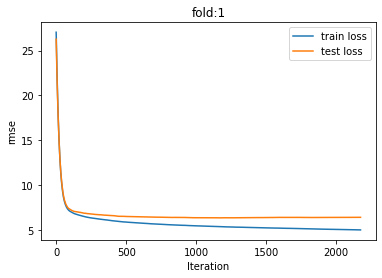

[I 2022-12-17 15:47:21,126] A new study created in memory with name: no-name-80980cf7-8b22-4c4f-8e13-e0d652848d9a


 - fold1_MAE : 6.331802

★★★★★　　　　　Fold 2　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:26,964] Trial 0 finished with value: 6.510650397584168 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 6.510650397584168.


Early stopping, best iteration is:
[457]	Train's l1: 5.20266	Test's l1: 6.51065
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:31,393] Trial 1 finished with value: 6.516537167340629 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 6.510650397584168.


Early stopping, best iteration is:
[347]	Train's l1: 5.51263	Test's l1: 6.51654
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:37,401] Trial 2 finished with value: 6.482268375776535 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 6.482268375776535.


Early stopping, best iteration is:
[349]	Train's l1: 5.39325	Test's l1: 6.48227
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:43,466] Trial 3 finished with value: 6.517357026492032 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 6.482268375776535.


Early stopping, best iteration is:
[413]	Train's l1: 5.28537	Test's l1: 6.51736
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:49,355] Trial 4 finished with value: 6.513010920806312 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 6.482268375776535.


Early stopping, best iteration is:
[605]	Train's l1: 4.91464	Test's l1: 6.51301
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:47:53,199] Trial 5 finished with value: 6.530620176076937 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 6.482268375776535.


Early stopping, best iteration is:
[341]	Train's l1: 5.58928	Test's l1: 6.53062
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:48:00,018] Trial 6 finished with value: 6.525822696003091 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 6.482268375776535.


Early stopping, best iteration is:
[409]	Train's l1: 5.2622	Test's l1: 6.52582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:48:08,166] Trial 7 finished with value: 6.524272105502782 and parameters: {'num_leaves': 225}. Best is trial 7 with value: 6.524272105502782.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:48:16,482] Trial 8 finished with value: 6.524272105502782 and parameters: {'num_leaves': 202}. Best is trial 7 with value: 6.524272105502782.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:48:24,833] Trial 9 finished with value: 6.524272105502782 and parameters: {'num_leaves': 159}. Best is trial 7 with value: 6.524272105502782.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:48:33,019] Trial 10 finished with value: 6.524272105502782 and parameters: {'num_leaves': 180}. Best is trial 7 with value: 6.524272105502782.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:48:41,213] Trial 11 finished with value: 6.524272105502782 and parameters: {'num_leaves': 162}. Best is trial 7 with value: 6.524272105502782.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:48:49,728] Trial 12 finished with value: 6.524272105502782 and parameters: {'num_leaves': 214}. Best is trial 7 with value: 6.524272105502782.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:48:57,996] Trial 13 finished with value: 6.524272105502782 and parameters: {'num_leaves': 175}. Best is trial 7 with value: 6.524272105502782.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:49:06,303] Trial 14 finished with value: 6.524272105502782 and parameters: {'num_leaves': 114}. Best is trial 7 with value: 6.524272105502782.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:49:14,484] Trial 15 finished with value: 6.524272105502782 and parameters: {'num_leaves': 119}. Best is trial 7 with value: 6.524272105502782.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:49:22,744] Trial 16 finished with value: 6.524272105502782 and parameters: {'num_leaves': 182}. Best is trial 7 with value: 6.524272105502782.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:49:29,475] Trial 17 finished with value: 6.523282979153423 and parameters: {'num_leaves': 37}. Best is trial 17 with value: 6.523282979153423.


Early stopping, best iteration is:
[348]	Train's l1: 5.34367	Test's l1: 6.52328
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:49:34,773] Trial 18 finished with value: 6.4585035180983095 and parameters: {'num_leaves': 26}. Best is trial 18 with value: 6.4585035180983095.


Early stopping, best iteration is:
[340]	Train's l1: 5.4975	Test's l1: 6.4585
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:49:42,514] Trial 19 finished with value: 6.450662510334177 and parameters: {'num_leaves': 21}. Best is trial 19 with value: 6.450662510334177.


Early stopping, best iteration is:
[404]	Train's l1: 5.45952	Test's l1: 6.45066
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:49:45,533] Trial 20 finished with value: 6.549400522822025 and parameters: {'num_leaves': 11}. Best is trial 19 with value: 6.450662510334177.


Early stopping, best iteration is:
[443]	Train's l1: 5.79462	Test's l1: 6.5494
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:49:53,616] Trial 21 finished with value: 6.524272105502782 and parameters: {'num_leaves': 64}. Best is trial 19 with value: 6.450662510334177.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:50:01,856] Trial 22 finished with value: 6.524272105502782 and parameters: {'num_leaves': 77}. Best is trial 19 with value: 6.450662510334177.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:50:02,808] Trial 23 finished with value: 7.264758783935441 and parameters: {'num_leaves': 2}. Best is trial 19 with value: 6.450662510334177.


Early stopping, best iteration is:
[472]	Train's l1: 7.45226	Test's l1: 7.26476
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:50:11,082] Trial 24 finished with value: 6.524272105502782 and parameters: {'num_leaves': 83}. Best is trial 19 with value: 6.450662510334177.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:50:17,813] Trial 25 finished with value: 6.489060857634256 and parameters: {'num_leaves': 38}. Best is trial 19 with value: 6.450662510334177.


Early stopping, best iteration is:
[304]	Train's l1: 5.43863	Test's l1: 6.48906
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:50:26,230] Trial 26 finished with value: 6.524272105502782 and parameters: {'num_leaves': 256}. Best is trial 19 with value: 6.450662510334177.


Early stopping, best iteration is:
[469]	Train's l1: 4.96802	Test's l1: 6.52427
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:50:32,182] Trial 27 finished with value: 6.5420545772035545 and parameters: {'bagging_fraction': 0.6135731682968516, 'bagging_freq': 5}. Best is trial 27 with value: 6.5420545772035545.


Early stopping, best iteration is:
[665]	Train's l1: 5.58906	Test's l1: 6.54205
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:50:37,804] Trial 28 finished with value: 6.464541089230677 and parameters: {'bagging_fraction': 0.7159772898354645, 'bagging_freq': 3}. Best is trial 28 with value: 6.464541089230677.


Early stopping, best iteration is:
[582]	Train's l1: 5.4581	Test's l1: 6.46454
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:50:43,629] Trial 29 finished with value: 6.498330911320947 and parameters: {'bagging_fraction': 0.9973835138217397, 'bagging_freq': 4}. Best is trial 28 with value: 6.464541089230677.


Early stopping, best iteration is:
[490]	Train's l1: 5.3414	Test's l1: 6.49833
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:50:49,279] Trial 30 finished with value: 6.443559020399162 and parameters: {'bagging_fraction': 0.9285393904935487, 'bagging_freq': 6}. Best is trial 30 with value: 6.443559020399162.


Early stopping, best iteration is:
[508]	Train's l1: 5.37926	Test's l1: 6.44356
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:50:54,753] Trial 31 finished with value: 6.684775722280134 and parameters: {'bagging_fraction': 0.5158207417426159, 'bagging_freq': 6}. Best is trial 30 with value: 6.443559020399162.


Early stopping, best iteration is:
[654]	Train's l1: 5.89968	Test's l1: 6.68478
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:00,709] Trial 32 finished with value: 6.424483829021352 and parameters: {'bagging_fraction': 0.9007605773077757, 'bagging_freq': 6}. Best is trial 32 with value: 6.424483829021352.


Early stopping, best iteration is:
[563]	Train's l1: 5.27853	Test's l1: 6.42448
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:06,931] Trial 33 finished with value: 6.712917646184988 and parameters: {'bagging_fraction': 0.5395913124556011, 'bagging_freq': 7}. Best is trial 32 with value: 6.424483829021352.


Early stopping, best iteration is:
[903]	Train's l1: 5.42885	Test's l1: 6.71292
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:11,937] Trial 34 finished with value: 6.499286574230501 and parameters: {'bagging_fraction': 0.4003598340061021, 'bagging_freq': 5}. Best is trial 32 with value: 6.424483829021352.


Early stopping, best iteration is:
[805]	Train's l1: 5.8637	Test's l1: 6.49929
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:17,630] Trial 35 finished with value: 6.627069894749677 and parameters: {'bagging_fraction': 0.48999573420994214, 'bagging_freq': 5}. Best is trial 32 with value: 6.424483829021352.


Early stopping, best iteration is:
[763]	Train's l1: 5.71361	Test's l1: 6.62707
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:23,931] Trial 36 finished with value: 6.688295152318614 and parameters: {'bagging_fraction': 0.4978312276553065, 'bagging_freq': 6}. Best is trial 32 with value: 6.424483829021352.


Early stopping, best iteration is:
[931]	Train's l1: 5.52147	Test's l1: 6.6883
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:29,988] Trial 37 finished with value: 6.432132147652799 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 6.432132147652799.


Early stopping, best iteration is:
[580]	Train's l1: 5.22692	Test's l1: 6.43213
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:36,394] Trial 38 finished with value: 6.445086555208677 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 6.432132147652799.


Early stopping, best iteration is:
[580]	Train's l1: 5.24771	Test's l1: 6.44509
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:42,736] Trial 39 finished with value: 6.46053710713273 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 6.432132147652799.


Early stopping, best iteration is:
[582]	Train's l1: 5.23806	Test's l1: 6.46054
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:48,727] Trial 40 finished with value: 6.424483829021352 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 40 with value: 6.424483829021352.


Early stopping, best iteration is:
[563]	Train's l1: 5.27853	Test's l1: 6.42448
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:53,952] Trial 41 finished with value: 6.421091901726982 and parameters: {'feature_fraction': 0.82}. Best is trial 41 with value: 6.421091901726982.


Early stopping, best iteration is:
[422]	Train's l1: 5.58319	Test's l1: 6.42109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:51:59,439] Trial 42 finished with value: 6.432582284438018 and parameters: {'feature_fraction': 0.852}. Best is trial 41 with value: 6.421091901726982.


Early stopping, best iteration is:
[448]	Train's l1: 5.50505	Test's l1: 6.43258
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:04,615] Trial 43 finished with value: 6.421091844625544 and parameters: {'lambda_l1': 0.00024388585174236005, 'lambda_l2': 3.8163291202031666e-05}. Best is trial 43 with value: 6.421091844625544.


Early stopping, best iteration is:
[422]	Train's l1: 5.5832	Test's l1: 6.42109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:09,827] Trial 44 finished with value: 6.421090961741134 and parameters: {'lambda_l1': 0.004197200830146697, 'lambda_l2': 0.0001721695423128245}. Best is trial 44 with value: 6.421090961741134.


Early stopping, best iteration is:
[422]	Train's l1: 5.5832	Test's l1: 6.42109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:15,154] Trial 45 finished with value: 6.430207128027378 and parameters: {'lambda_l1': 0.000670050765527522, 'lambda_l2': 2.6786751725649465}. Best is trial 44 with value: 6.421090961741134.


Early stopping, best iteration is:
[450]	Train's l1: 5.51355	Test's l1: 6.43021
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:20,629] Trial 46 finished with value: 6.440604273742087 and parameters: {'lambda_l1': 0.11823814870048656, 'lambda_l2': 1.7125528191788775}. Best is trial 44 with value: 6.421090961741134.


Early stopping, best iteration is:
[499]	Train's l1: 5.43385	Test's l1: 6.4406
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:25,811] Trial 47 finished with value: 6.421091229934053 and parameters: {'lambda_l1': 1.267151260733461e-07, 'lambda_l2': 0.006782772112097898}. Best is trial 44 with value: 6.421090961741134.


Early stopping, best iteration is:
[422]	Train's l1: 5.58323	Test's l1: 6.42109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:31,569] Trial 48 finished with value: 6.424710965609128 and parameters: {'lambda_l1': 9.622036711969736, 'lambda_l2': 0.0832998885192571}. Best is trial 44 with value: 6.421090961741134.


Early stopping, best iteration is:
[583]	Train's l1: 5.23875	Test's l1: 6.42471
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:36,723] Trial 49 finished with value: 6.378464091458634 and parameters: {'lambda_l1': 0.6239711535853162, 'lambda_l2': 0.00020061609052058455}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[420]	Train's l1: 5.56774	Test's l1: 6.37846
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:42,018] Trial 50 finished with value: 6.409068570434547 and parameters: {'lambda_l1': 9.275725284645742e-08, 'lambda_l2': 0.07022803021547246}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[455]	Train's l1: 5.51949	Test's l1: 6.40907
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:48,015] Trial 51 finished with value: 6.4160890932861 and parameters: {'lambda_l1': 3.038283347801796, 'lambda_l2': 0.05611819843784735}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[581]	Train's l1: 5.25973	Test's l1: 6.41609
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:53,237] Trial 52 finished with value: 6.421091900643519 and parameters: {'lambda_l1': 1.0957738549310402e-08, 'lambda_l2': 1.323432468686614e-06}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[422]	Train's l1: 5.58319	Test's l1: 6.42109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:52:58,429] Trial 53 finished with value: 6.421091899585715 and parameters: {'lambda_l1': 1.0668577564746234e-05, 'lambda_l2': 1.52035653627104e-08}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[422]	Train's l1: 5.58319	Test's l1: 6.42109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:53:03,650] Trial 54 finished with value: 6.421091619835685 and parameters: {'lambda_l1': 1.7011621142746287e-06, 'lambda_l2': 0.002842166009148612}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[422]	Train's l1: 5.58321	Test's l1: 6.42109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:53:09,012] Trial 55 finished with value: 6.42335287411185 and parameters: {'lambda_l1': 0.038577747044449016, 'lambda_l2': 4.659008401615314e-05}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[450]	Train's l1: 5.51941	Test's l1: 6.42335
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:53:14,266] Trial 56 finished with value: 6.421091897396786 and parameters: {'lambda_l1': 1.84794782748636e-05, 'lambda_l2': 1.8334207150179545e-06}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[422]	Train's l1: 5.58319	Test's l1: 6.42109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:53:20,271] Trial 57 finished with value: 6.404669723061567 and parameters: {'lambda_l1': 0.23950686735721116, 'lambda_l2': 0.005096780821751574}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[611]	Train's l1: 5.19007	Test's l1: 6.40467
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:53:25,566] Trial 58 finished with value: 6.410746769559454 and parameters: {'lambda_l1': 0.5124368186997861, 'lambda_l2': 0.0014644047126098293}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[421]	Train's l1: 5.58314	Test's l1: 6.41075
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:53:31,829] Trial 59 finished with value: 6.424187256796315 and parameters: {'lambda_l1': 0.00818323727456752, 'lambda_l2': 6.020992500529211e-06}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[700]	Train's l1: 5.06599	Test's l1: 6.42419
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:53:37,034] Trial 60 finished with value: 6.42955069967073 and parameters: {'lambda_l1': 0.32460655207461475, 'lambda_l2': 5.2030801467995614e-08}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[420]	Train's l1: 5.57904	Test's l1: 6.42955
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:53:42,337] Trial 61 finished with value: 6.385905890608302 and parameters: {'lambda_l1': 1.2079535617773747, 'lambda_l2': 0.00035313065274617363}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[420]	Train's l1: 5.58755	Test's l1: 6.38591
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:53:47,796] Trial 62 finished with value: 6.400002769396601 and parameters: {'lambda_l1': 1.614089872174811, 'lambda_l2': 1.566567260859315e-07}. Best is trial 49 with value: 6.378464091458634.


Early stopping, best iteration is:
[462]	Train's l1: 5.49733	Test's l1: 6.4
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:53:53,200] Trial 63 finished with value: 6.378464091458634 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.378464091458634.


Early stopping, best iteration is:
[420]	Train's l1: 5.56774	Test's l1: 6.37846
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:54:01,516] Trial 64 finished with value: 6.378464091458634 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 6.378464091458634.


Early stopping, best iteration is:
[420]	Train's l1: 5.56774	Test's l1: 6.37846
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:54:06,693] Trial 65 finished with value: 6.378464091458634 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 6.378464091458634.


Early stopping, best iteration is:
[420]	Train's l1: 5.56774	Test's l1: 6.37846
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:54:11,941] Trial 66 finished with value: 6.378464091458634 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.378464091458634.


Early stopping, best iteration is:
[420]	Train's l1: 5.56774	Test's l1: 6.37846
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:54:17,180] Trial 67 finished with value: 6.378464091458634 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 6.378464091458634.


Early stopping, best iteration is:
[420]	Train's l1: 5.56774	Test's l1: 6.37846
▼▼▼▼▼　　　　　Fold 2　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.6239711535853162, 'lambda_l2': 0.00020061609052058455, 'num_leaves': 21, 'feature_fraction': 0.82, 'bagging_fraction': 0.9007605773077757, 'bagging_freq': 6, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


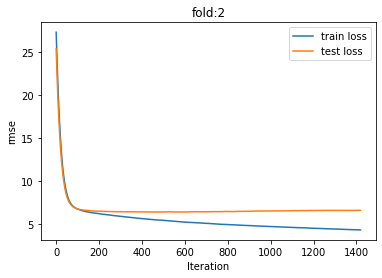

 - fold2_MAE : 6.378464


[I 2022-12-17 15:54:18,240] A new study created in memory with name: no-name-42ffdc05-34b1-49dd-ab95-0f5427479fba



★★★★★　　　　　Fold 3　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:54:23,955] Trial 0 finished with value: 6.36568217891192 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 6.36568217891192.


Early stopping, best iteration is:
[551]	Train's l1: 5.09185	Test's l1: 6.36568
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:54:31,665] Trial 1 finished with value: 6.245115209079404 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 6.245115209079404.


Early stopping, best iteration is:
[539]	Train's l1: 5.06876	Test's l1: 6.24512
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:54:36,903] Trial 2 finished with value: 6.389352683869389 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 6.245115209079404.


Early stopping, best iteration is:
[592]	Train's l1: 5.05967	Test's l1: 6.38935
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:54:42,541] Trial 3 finished with value: 6.271427480359778 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 6.245115209079404.


Early stopping, best iteration is:
[417]	Train's l1: 5.31774	Test's l1: 6.27143
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:54:49,236] Trial 4 finished with value: 6.200250166902686 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 6.200250166902686.


Early stopping, best iteration is:
[539]	Train's l1: 5.06915	Test's l1: 6.20025
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:54:54,267] Trial 5 finished with value: 6.499969619340997 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 6.200250166902686.


Early stopping, best iteration is:
[689]	Train's l1: 4.97477	Test's l1: 6.49997
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:55:00,822] Trial 6 finished with value: 6.1820281338907135 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 6 with value: 6.1820281338907135.


Early stopping, best iteration is:
[441]	Train's l1: 5.26528	Test's l1: 6.18203
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:55:09,646] Trial 7 finished with value: 6.217870533512493 and parameters: {'num_leaves': 132}. Best is trial 7 with value: 6.217870533512493.


Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787


[I 2022-12-17 15:55:18,419] Trial 8 finished with value: 6.217870533512493 and parameters: {'num_leaves': 94}. Best is trial 7 with value: 6.217870533512493.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:55:25,640] Trial 9 finished with value: 6.190244030988612 and parameters: {'num_leaves': 35}. Best is trial 9 with value: 6.190244030988612.


Early stopping, best iteration is:
[454]	Train's l1: 5.14598	Test's l1: 6.19024
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:55:29,789] Trial 10 finished with value: 6.181060115954584 and parameters: {'num_leaves': 15}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[593]	Train's l1: 5.42769	Test's l1: 6.18106
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:55:32,924] Trial 11 finished with value: 6.434231959454459 and parameters: {'num_leaves': 5}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[1773]	Train's l1: 5.72177	Test's l1: 6.43423
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:55:35,986] Trial 12 finished with value: 6.641270253812308 and parameters: {'num_leaves': 4}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[2111]	Train's l1: 5.9206	Test's l1: 6.64127
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787


[I 2022-12-17 15:55:44,799] Trial 13 finished with value: 6.217870533512493 and parameters: {'num_leaves': 229}. Best is trial 10 with value: 6.181060115954584.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:55:53,521] Trial 14 finished with value: 6.217870533512493 and parameters: {'num_leaves': 71}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:56:02,308] Trial 15 finished with value: 6.217870533512493 and parameters: {'num_leaves': 116}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787


[I 2022-12-17 15:56:11,163] Trial 16 finished with value: 6.217870533512493 and parameters: {'num_leaves': 232}. Best is trial 10 with value: 6.181060115954584.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:56:19,978] Trial 17 finished with value: 6.217870533512493 and parameters: {'num_leaves': 170}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:56:28,696] Trial 18 finished with value: 6.217870533512493 and parameters: {'num_leaves': 57}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:56:36,736] Trial 19 finished with value: 6.217172260915454 and parameters: {'num_leaves': 43}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[492]	Train's l1: 4.97424	Test's l1: 6.21717
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:56:43,381] Trial 20 finished with value: 6.213401642581376 and parameters: {'num_leaves': 33}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[396]	Train's l1: 5.33686	Test's l1: 6.2134
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:56:52,165] Trial 21 finished with value: 6.217870533512493 and parameters: {'num_leaves': 147}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:57:00,953] Trial 22 finished with value: 6.217870533512493 and parameters: {'num_leaves': 94}. Best is trial 10 with value: 6.181060115954584.


Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:57:06,868] Trial 23 finished with value: 6.17570378645559 and parameters: {'num_leaves': 24}. Best is trial 23 with value: 6.17570378645559.


Early stopping, best iteration is:
[589]	Train's l1: 5.12192	Test's l1: 6.1757
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:57:15,547] Trial 24 finished with value: 6.217870533512493 and parameters: {'num_leaves': 190}. Best is trial 23 with value: 6.17570378645559.


Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[562]	Train's l1: 4.81696	Test's l1: 6.21787


[I 2022-12-17 15:57:24,206] Trial 25 finished with value: 6.217870533512493 and parameters: {'num_leaves': 83}. Best is trial 23 with value: 6.17570378645559.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:57:29,065] Trial 26 finished with value: 6.19161970057921 and parameters: {'num_leaves': 19}. Best is trial 23 with value: 6.17570378645559.


Early stopping, best iteration is:
[566]	Train's l1: 5.31658	Test's l1: 6.19162
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:57:35,767] Trial 27 finished with value: 6.533171306239835 and parameters: {'bagging_fraction': 0.438331091043737, 'bagging_freq': 1}. Best is trial 27 with value: 6.533171306239835.


Early stopping, best iteration is:
[1146]	Train's l1: 5.42169	Test's l1: 6.53317
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:57:41,990] Trial 28 finished with value: 6.531545044392221 and parameters: {'bagging_fraction': 0.43686545315829883, 'bagging_freq': 1}. Best is trial 28 with value: 6.531545044392221.


Early stopping, best iteration is:
[1004]	Train's l1: 5.56788	Test's l1: 6.53155
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1242]	Train's l1: 5.13529	Test's l1: 6.57402


[I 2022-12-17 15:57:50,072] Trial 29 finished with value: 6.5740204377752764 and parameters: {'bagging_fraction': 0.5301926184823097, 'bagging_freq': 2}. Best is trial 28 with value: 6.531545044392221.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:57:57,149] Trial 30 finished with value: 6.497142193736216 and parameters: {'bagging_fraction': 0.6506437007856067, 'bagging_freq': 4}. Best is trial 30 with value: 6.497142193736216.


Early stopping, best iteration is:
[834]	Train's l1: 5.38065	Test's l1: 6.49714
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:58:02,846] Trial 31 finished with value: 6.328310393494181 and parameters: {'bagging_fraction': 0.9323369047149427, 'bagging_freq': 1}. Best is trial 31 with value: 6.328310393494181.


Early stopping, best iteration is:
[488]	Train's l1: 5.39368	Test's l1: 6.32831
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1244]	Train's l1: 5.12207	Test's l1: 6.56245


[I 2022-12-17 15:58:10,826] Trial 32 finished with value: 6.562449601625036 and parameters: {'bagging_fraction': 0.5370176568607078, 'bagging_freq': 2}. Best is trial 31 with value: 6.328310393494181.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:58:17,430] Trial 33 finished with value: 6.559025658698331 and parameters: {'bagging_fraction': 0.4341837874365098, 'bagging_freq': 1}. Best is trial 31 with value: 6.328310393494181.


Early stopping, best iteration is:
[1146]	Train's l1: 5.4715	Test's l1: 6.55903
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:58:28,317] Trial 34 finished with value: 6.316375578753044 and parameters: {'bagging_fraction': 0.8793631710849061, 'bagging_freq': 2}. Best is trial 34 with value: 6.316375578753044.


Early stopping, best iteration is:
[828]	Train's l1: 4.96336	Test's l1: 6.31638
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:58:35,980] Trial 35 finished with value: 6.3247245977879425 and parameters: {'bagging_fraction': 0.8402155104550704, 'bagging_freq': 5}. Best is trial 34 with value: 6.316375578753044.


Early stopping, best iteration is:
[830]	Train's l1: 5.00771	Test's l1: 6.32472
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:58:42,963] Trial 36 finished with value: 6.492622650479576 and parameters: {'bagging_fraction': 0.6363280710149349, 'bagging_freq': 5}. Best is trial 34 with value: 6.316375578753044.


Early stopping, best iteration is:
[793]	Train's l1: 5.44028	Test's l1: 6.49262
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:58:49,081] Trial 37 finished with value: 6.175727803879634 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 6.175727803879634.


Early stopping, best iteration is:
[568]	Train's l1: 5.15279	Test's l1: 6.17573
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:58:55,375] Trial 38 finished with value: 6.205206017925876 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 6.175727803879634.


Early stopping, best iteration is:
[561]	Train's l1: 5.16916	Test's l1: 6.20521
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:00,712] Trial 39 finished with value: 6.198200432892145 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 6.175727803879634.


Early stopping, best iteration is:
[480]	Train's l1: 5.31479	Test's l1: 6.1982
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:06,599] Trial 40 finished with value: 6.17570378645559 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 40 with value: 6.17570378645559.


Early stopping, best iteration is:
[589]	Train's l1: 5.12192	Test's l1: 6.1757
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:12,381] Trial 41 finished with value: 6.185866191130625 and parameters: {'feature_fraction': 0.948}. Best is trial 40 with value: 6.17570378645559.


Early stopping, best iteration is:
[489]	Train's l1: 5.30194	Test's l1: 6.18587
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:18,381] Trial 42 finished with value: 6.166129242852803 and parameters: {'feature_fraction': 0.82}. Best is trial 42 with value: 6.166129242852803.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:24,314] Trial 43 finished with value: 6.194063293785556 and parameters: {'lambda_l1': 3.394939178727804, 'lambda_l2': 0.002447050684265882}. Best is trial 43 with value: 6.194063293785556.


Early stopping, best iteration is:
[637]	Train's l1: 5.05069	Test's l1: 6.19406
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:29,953] Trial 44 finished with value: 6.196545864182085 and parameters: {'lambda_l1': 0.00046433527277949687, 'lambda_l2': 0.005583104982812872}. Best is trial 43 with value: 6.194063293785556.


Early stopping, best iteration is:
[589]	Train's l1: 5.1304	Test's l1: 6.19655
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:35,285] Trial 45 finished with value: 6.199449057191748 and parameters: {'lambda_l1': 9.438749629131829e-07, 'lambda_l2': 0.015268256159783965}. Best is trial 43 with value: 6.194063293785556.


Early stopping, best iteration is:
[520]	Train's l1: 5.25681	Test's l1: 6.19945
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:41,219] Trial 46 finished with value: 6.16612923838357 and parameters: {'lambda_l1': 3.855307913446308e-06, 'lambda_l2': 7.131097470036691e-07}. Best is trial 46 with value: 6.16612923838357.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:47,293] Trial 47 finished with value: 6.1661290756384455 and parameters: {'lambda_l1': 0.000239327759808518, 'lambda_l2': 1.6635766386140705e-06}. Best is trial 47 with value: 6.1661290756384455.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:53,288] Trial 48 finished with value: 6.177745679459413 and parameters: {'lambda_l1': 1.0792915143735549, 'lambda_l2': 7.313655040645271}. Best is trial 47 with value: 6.1661290756384455.


Early stopping, best iteration is:
[666]	Train's l1: 5.06872	Test's l1: 6.17775
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 15:59:59,264] Trial 49 finished with value: 6.166129072004656 and parameters: {'lambda_l1': 3.819867481301168e-06, 'lambda_l2': 6.449065200238816e-05}. Best is trial 49 with value: 6.166129072004656.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:00:05,259] Trial 50 finished with value: 6.214426808408681 and parameters: {'lambda_l1': 0.14563740257601485, 'lambda_l2': 2.0476345064926866e-06}. Best is trial 49 with value: 6.166129072004656.


Early stopping, best iteration is:
[675]	Train's l1: 5.01334	Test's l1: 6.21443
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:00:11,263] Trial 51 finished with value: 6.166129242804209 and parameters: {'lambda_l1': 1.550572916357252e-08, 'lambda_l2': 3.427258342773874e-08}. Best is trial 49 with value: 6.166129072004656.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:00:16,618] Trial 52 finished with value: 6.172163863969337 and parameters: {'lambda_l1': 0.001240665613925546, 'lambda_l2': 2.8428414619315724e-08}. Best is trial 49 with value: 6.166129072004656.


Early stopping, best iteration is:
[497]	Train's l1: 5.27288	Test's l1: 6.17216
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:00:22,573] Trial 53 finished with value: 6.166129042000012 and parameters: {'lambda_l1': 1.8631113555811505e-08, 'lambda_l2': 7.722055445965554e-05}. Best is trial 53 with value: 6.166129042000012.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:00:28,695] Trial 54 finished with value: 6.166129109631043 and parameters: {'lambda_l1': 3.3983432334676336e-08, 'lambda_l2': 5.114352210842333e-05}. Best is trial 53 with value: 6.166129042000012.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:00:34,756] Trial 55 finished with value: 6.166128995205343 and parameters: {'lambda_l1': 1.524600673001931e-06, 'lambda_l2': 9.500606799682649e-05}. Best is trial 55 with value: 6.166128995205343.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:00:40,942] Trial 56 finished with value: 6.18358468440928 and parameters: {'lambda_l1': 2.8402897852445753e-07, 'lambda_l2': 0.3615933377708776}. Best is trial 55 with value: 6.166128995205343.


Early stopping, best iteration is:
[735]	Train's l1: 4.94449	Test's l1: 6.18358
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:00:47,110] Trial 57 finished with value: 6.169399114906425 and parameters: {'lambda_l1': 3.0868249159354346e-05, 'lambda_l2': 0.0002708742359804451}. Best is trial 55 with value: 6.166128995205343.


Early stopping, best iteration is:
[729]	Train's l1: 4.93447	Test's l1: 6.1694
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:00:53,456] Trial 58 finished with value: 6.1661291997060115 and parameters: {'lambda_l1': 1.0693996047290885e-07, 'lambda_l2': 1.6125176818266354e-05}. Best is trial 55 with value: 6.166128995205343.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:00:59,708] Trial 59 finished with value: 6.215435718962139 and parameters: {'lambda_l1': 1.8120790332821116e-05, 'lambda_l2': 0.05763150205962454}. Best is trial 55 with value: 6.166128995205343.


Early stopping, best iteration is:
[745]	Train's l1: 4.93066	Test's l1: 6.21544
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:01:06,130] Trial 60 finished with value: 6.177116317209153 and parameters: {'lambda_l1': 0.00975705602340786, 'lambda_l2': 0.0009261878488610411}. Best is trial 55 with value: 6.166128995205343.


Early stopping, best iteration is:
[794]	Train's l1: 4.85567	Test's l1: 6.17712
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:01:12,240] Trial 61 finished with value: 6.166129215156817 and parameters: {'lambda_l1': 1.2268090749356e-08, 'lambda_l2': 1.0440270467780794e-05}. Best is trial 55 with value: 6.166128995205343.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:01:18,385] Trial 62 finished with value: 6.166129241946644 and parameters: {'lambda_l1': 4.240888435105026e-07, 'lambda_l2': 2.581739128132504e-07}. Best is trial 55 with value: 6.166128995205343.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:01:24,514] Trial 63 finished with value: 6.166128995205343 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 6.166128995205343.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:01:30,499] Trial 64 finished with value: 6.166128995205343 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.166128995205343.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:01:36,547] Trial 65 finished with value: 6.166128995205343 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 6.166128995205343.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:01:42,481] Trial 66 finished with value: 6.166128995205343 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 6.166128995205343.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:01:48,517] Trial 67 finished with value: 6.166128995205343 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.166128995205343.


Early stopping, best iteration is:
[696]	Train's l1: 4.98913	Test's l1: 6.16613
▼▼▼▼▼　　　　　Fold 3　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 1.524600673001931e-06, 'lambda_l2': 9.500606799682649e-05, 'num_leaves': 24, 'feature_fraction': 0.82, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


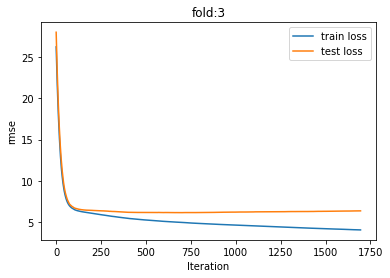

 - fold3_MAE : 6.166129


[I 2022-12-17 16:01:49,949] A new study created in memory with name: no-name-41d409e8-0541-4ae3-a2aa-9359e84bebb7



★★★★★　　　　　Fold 4　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[868]	Train's l1: 4.49294	Test's l1: 6.75715


[I 2022-12-17 16:01:59,236] Trial 0 finished with value: 6.757152931678084 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 6.757152931678084.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[907]	Train's l1: 4.41565	Test's l1: 6.7354


[I 2022-12-17 16:02:06,890] Trial 1 finished with value: 6.735404977377956 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 6.735404977377956.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:02:10,231] Trial 2 finished with value: 6.8550684176602825 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 6.735404977377956.


Early stopping, best iteration is:
[177]	Train's l1: 6.06611	Test's l1: 6.85507
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[938]	Train's l1: 4.38358	Test's l1: 6.72052


[I 2022-12-17 16:02:18,641] Trial 3 finished with value: 6.720517180867335 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 6.720517180867335.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:02:24,430] Trial 4 finished with value: 6.760224094133583 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 6.720517180867335.


Early stopping, best iteration is:
[581]	Train's l1: 4.8939	Test's l1: 6.76022
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1096]	Train's l1: 4.22449	Test's l1: 6.78432


[I 2022-12-17 16:02:31,383] Trial 5 finished with value: 6.784315700948405 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 6.720517180867335.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[843]	Train's l1: 4.51891	Test's l1: 6.70372


[I 2022-12-17 16:02:39,782] Trial 6 finished with value: 6.703719829668756 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 6 with value: 6.703719829668756.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:02:43,702] Trial 7 finished with value: 7.621098957683467 and parameters: {'num_leaves': 2}. Best is trial 7 with value: 7.621098957683467.


Early stopping, best iteration is:
[422]	Train's l1: 7.42528	Test's l1: 7.6211
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:02:52,770] Trial 8 finished with value: 6.788083513892073 and parameters: {'num_leaves': 246}. Best is trial 8 with value: 6.788083513892073.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:03:01,728] Trial 9 finished with value: 6.788083513892073 and parameters: {'num_leaves': 99}. Best is trial 8 with value: 6.788083513892073.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:03:10,889] Trial 10 finished with value: 6.788083513892073 and parameters: {'num_leaves': 160}. Best is trial 8 with value: 6.788083513892073.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:03:17,741] Trial 11 finished with value: 6.704584933539917 and parameters: {'num_leaves': 16}. Best is trial 11 with value: 6.704584933539917.


Early stopping, best iteration is:
[1477]	Train's l1: 4.56561	Test's l1: 6.70458
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:03:26,893] Trial 12 finished with value: 6.788083513892073 and parameters: {'num_leaves': 223}. Best is trial 11 with value: 6.704584933539917.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:03:35,919] Trial 13 finished with value: 6.788083513892073 and parameters: {'num_leaves': 157}. Best is trial 11 with value: 6.704584933539917.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[830]	Train's l1: 4.52246	Test's l1: 6.71348


[I 2022-12-17 16:03:44,349] Trial 14 finished with value: 6.713476484125481 and parameters: {'num_leaves': 32}. Best is trial 11 with value: 6.704584933539917.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:03:53,618] Trial 15 finished with value: 6.788083513892073 and parameters: {'num_leaves': 82}. Best is trial 11 with value: 6.704584933539917.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:04:02,838] Trial 16 finished with value: 6.788083513892073 and parameters: {'num_leaves': 133}. Best is trial 11 with value: 6.704584933539917.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:04:12,021] Trial 17 finished with value: 6.788083513892073 and parameters: {'num_leaves': 55}. Best is trial 11 with value: 6.704584933539917.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:04:17,299] Trial 18 finished with value: 6.580586213544387 and parameters: {'num_leaves': 5}. Best is trial 18 with value: 6.580586213544387.


Early stopping, best iteration is:
[3541]	Train's l1: 5.19779	Test's l1: 6.58059
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:04:22,532] Trial 19 finished with value: 6.529206643194592 and parameters: {'num_leaves': 7}. Best is trial 19 with value: 6.529206643194592.


Early stopping, best iteration is:
[2521]	Train's l1: 5.07036	Test's l1: 6.52921
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:04:31,666] Trial 20 finished with value: 6.788083513892073 and parameters: {'num_leaves': 56}. Best is trial 19 with value: 6.529206643194592.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:04:39,750] Trial 21 finished with value: 6.775785392141201 and parameters: {'num_leaves': 48}. Best is trial 19 with value: 6.529206643194592.


Early stopping, best iteration is:
[480]	Train's l1: 4.87928	Test's l1: 6.77579
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:04:48,823] Trial 22 finished with value: 6.788083513892073 and parameters: {'num_leaves': 90}. Best is trial 19 with value: 6.529206643194592.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2734]	Train's l1: 4.56829	Test's l1: 6.57408


[I 2022-12-17 16:04:56,017] Trial 23 finished with value: 6.57407593040664 and parameters: {'num_leaves': 10}. Best is trial 19 with value: 6.529206643194592.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:05:05,210] Trial 24 finished with value: 6.788083513892073 and parameters: {'num_leaves': 202}. Best is trial 19 with value: 6.529206643194592.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[655]	Train's l1: 4.56748	Test's l1: 6.78808


[I 2022-12-17 16:05:14,365] Trial 25 finished with value: 6.788083513892073 and parameters: {'num_leaves': 73}. Best is trial 19 with value: 6.529206643194592.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1279]	Train's l1: 3.9468	Test's l1: 6.73385


[I 2022-12-17 16:05:25,273] Trial 26 finished with value: 6.733845670096898 and parameters: {'num_leaves': 33}. Best is trial 19 with value: 6.529206643194592.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2908]	Train's l1: 4.88905	Test's l1: 6.65267


[I 2022-12-17 16:05:32,425] Trial 27 finished with value: 6.652674679811356 and parameters: {'bagging_fraction': 0.9638912004352607, 'bagging_freq': 2}. Best is trial 27 with value: 6.652674679811356.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:05:36,602] Trial 28 finished with value: 6.9151781264453325 and parameters: {'bagging_fraction': 0.46548724884346365, 'bagging_freq': 7}. Best is trial 27 with value: 6.652674679811356.


Early stopping, best iteration is:
[1748]	Train's l1: 5.75889	Test's l1: 6.91518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:05:39,568] Trial 29 finished with value: 7.0024030696308435 and parameters: {'bagging_fraction': 0.4904892050315294, 'bagging_freq': 2}. Best is trial 27 with value: 6.652674679811356.


Early stopping, best iteration is:
[884]	Train's l1: 6.13276	Test's l1: 7.0024
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:05:43,857] Trial 30 finished with value: 6.833336040428084 and parameters: {'bagging_fraction': 0.7241517988588065, 'bagging_freq': 1}. Best is trial 27 with value: 6.652674679811356.


Early stopping, best iteration is:
[1720]	Train's l1: 5.42608	Test's l1: 6.83334
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:05:49,004] Trial 31 finished with value: 6.910422452946926 and parameters: {'bagging_fraction': 0.6315519238126829, 'bagging_freq': 5}. Best is trial 27 with value: 6.652674679811356.


Early stopping, best iteration is:
[2251]	Train's l1: 5.35389	Test's l1: 6.91042
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:05:52,624] Trial 32 finished with value: 6.93623644704045 and parameters: {'bagging_fraction': 0.640103464709198, 'bagging_freq': 2}. Best is trial 27 with value: 6.652674679811356.


Early stopping, best iteration is:
[1204]	Train's l1: 5.72296	Test's l1: 6.93624
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:05:56,005] Trial 33 finished with value: 6.975422056217722 and parameters: {'bagging_fraction': 0.5467130392987372, 'bagging_freq': 2}. Best is trial 27 with value: 6.652674679811356.


Early stopping, best iteration is:
[1088]	Train's l1: 5.9431	Test's l1: 6.97542
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:01,913] Trial 34 finished with value: 6.569076927756655 and parameters: {'bagging_fraction': 0.9990170608067496, 'bagging_freq': 4}. Best is trial 34 with value: 6.569076927756655.


Early stopping, best iteration is:
[2417]	Train's l1: 5.10827	Test's l1: 6.56908
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:05,228] Trial 35 finished with value: 6.927676920359516 and parameters: {'bagging_fraction': 0.6729605555234628, 'bagging_freq': 1}. Best is trial 34 with value: 6.569076927756655.


Early stopping, best iteration is:
[1123]	Train's l1: 5.77088	Test's l1: 6.92768
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:09,593] Trial 36 finished with value: 6.8717491695845965 and parameters: {'bagging_fraction': 0.6816578296728566, 'bagging_freq': 7}. Best is trial 34 with value: 6.569076927756655.


Early stopping, best iteration is:
[1701]	Train's l1: 5.51136	Test's l1: 6.87175
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:15,151] Trial 37 finished with value: 6.562625281272001 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 6.562625281272001.


Early stopping, best iteration is:
[2750]	Train's l1: 5.02215	Test's l1: 6.56263
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:20,274] Trial 38 finished with value: 6.545307817541786 and parameters: {'feature_fraction': 0.852}. Best is trial 38 with value: 6.545307817541786.


Early stopping, best iteration is:
[2573]	Train's l1: 5.05902	Test's l1: 6.54531
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:25,094] Trial 39 finished with value: 6.5622018422435735 and parameters: {'feature_fraction': 0.948}. Best is trial 38 with value: 6.545307817541786.


Early stopping, best iteration is:
[2129]	Train's l1: 5.18561	Test's l1: 6.5622
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:30,518] Trial 40 finished with value: 6.558712224161703 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 38 with value: 6.545307817541786.


Early stopping, best iteration is:
[2578]	Train's l1: 5.05712	Test's l1: 6.55871
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:35,590] Trial 41 finished with value: 6.529206643194592 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 41 with value: 6.529206643194592.


Early stopping, best iteration is:
[2521]	Train's l1: 5.07036	Test's l1: 6.52921
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:40,176] Trial 42 finished with value: 6.554694110213558 and parameters: {'feature_fraction': 0.82}. Best is trial 41 with value: 6.529206643194592.


Early stopping, best iteration is:
[2303]	Train's l1: 5.1482	Test's l1: 6.55469
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:45,633] Trial 43 finished with value: 6.535735659509914 and parameters: {'lambda_l1': 1.2071944840465103e-08, 'lambda_l2': 0.04848841729697352}. Best is trial 43 with value: 6.535735659509914.


Early stopping, best iteration is:
[2710]	Train's l1: 5.03045	Test's l1: 6.53574
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:50,626] Trial 44 finished with value: 6.5741672224776275 and parameters: {'lambda_l1': 3.1515788862917655e-06, 'lambda_l2': 5.716389650679642}. Best is trial 43 with value: 6.535735659509914.


Early stopping, best iteration is:
[2422]	Train's l1: 5.11881	Test's l1: 6.57417
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:06:55,603] Trial 45 finished with value: 6.538831905757179 and parameters: {'lambda_l1': 0.007613916088269694, 'lambda_l2': 7.689308607100138e-08}. Best is trial 43 with value: 6.535735659509914.


Early stopping, best iteration is:
[2425]	Train's l1: 5.11734	Test's l1: 6.53883
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:07:03,797] Trial 46 finished with value: 6.528368100803252 and parameters: {'lambda_l1': 0.38047216319509025, 'lambda_l2': 5.246769153355748e-06}. Best is trial 46 with value: 6.528368100803252.


Early stopping, best iteration is:
[2532]	Train's l1: 5.07524	Test's l1: 6.52837
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:07:08,821] Trial 47 finished with value: 6.573000831493429 and parameters: {'lambda_l1': 2.3700772682434905e-05, 'lambda_l2': 8.915179838851857}. Best is trial 46 with value: 6.528368100803252.


Early stopping, best iteration is:
[2411]	Train's l1: 5.12601	Test's l1: 6.573
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:07:14,079] Trial 48 finished with value: 6.5517718868563195 and parameters: {'lambda_l1': 0.6417641172828251, 'lambda_l2': 8.388927907668748e-05}. Best is trial 46 with value: 6.528368100803252.


Early stopping, best iteration is:
[2557]	Train's l1: 5.06469	Test's l1: 6.55177
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:07:19,294] Trial 49 finished with value: 6.529206599943665 and parameters: {'lambda_l1': 9.783826612048153e-05, 'lambda_l2': 6.54253877919872e-08}. Best is trial 46 with value: 6.528368100803252.


Early stopping, best iteration is:
[2521]	Train's l1: 5.07036	Test's l1: 6.52921
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:07:24,347] Trial 50 finished with value: 6.525297255514997 and parameters: {'lambda_l1': 5.687022661452514, 'lambda_l2': 4.953264920798676e-06}. Best is trial 50 with value: 6.525297255514997.


Early stopping, best iteration is:
[2392]	Train's l1: 5.10881	Test's l1: 6.5253
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:07:29,215] Trial 51 finished with value: 6.515666019308608 and parameters: {'lambda_l1': 0.04772973524927813, 'lambda_l2': 0.045135997404448853}. Best is trial 51 with value: 6.515666019308608.


Early stopping, best iteration is:
[2270]	Train's l1: 5.16645	Test's l1: 6.51567
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2681]	Train's l1: 5.04023	Test's l1: 6.55354


[I 2022-12-17 16:07:34,521] Trial 52 finished with value: 6.553542224971588 and parameters: {'lambda_l1': 0.038750652980182244, 'lambda_l2': 0.8462595755269137}. Best is trial 51 with value: 6.515666019308608.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:07:39,218] Trial 53 finished with value: 6.549629476603309 and parameters: {'lambda_l1': 0.002361180137685128, 'lambda_l2': 0.010441376755187954}. Best is trial 51 with value: 6.515666019308608.


Early stopping, best iteration is:
[2229]	Train's l1: 5.16276	Test's l1: 6.54963
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:07:44,203] Trial 54 finished with value: 6.530881121168395 and parameters: {'lambda_l1': 3.3080189317719677, 'lambda_l2': 0.0007270632011973417}. Best is trial 51 with value: 6.515666019308608.


Early stopping, best iteration is:
[2356]	Train's l1: 5.11273	Test's l1: 6.53088
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:07:49,005] Trial 55 finished with value: 6.590943226887556 and parameters: {'lambda_l1': 6.321562721310552, 'lambda_l2': 3.7099295109014293e-06}. Best is trial 51 with value: 6.515666019308608.


Early stopping, best iteration is:
[2206]	Train's l1: 5.1902	Test's l1: 6.59094
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2711]	Train's l1: 5.03251	Test's l1: 6.52862


[I 2022-12-17 16:07:54,375] Trial 56 finished with value: 6.528616942503211 and parameters: {'lambda_l1': 0.0820410124187106, 'lambda_l2': 0.0019074545581785004}. Best is trial 51 with value: 6.515666019308608.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:07:59,472] Trial 57 finished with value: 6.5292061954346945 and parameters: {'lambda_l1': 0.0009690788194347676, 'lambda_l2': 3.204239412133712e-05}. Best is trial 51 with value: 6.515666019308608.


Early stopping, best iteration is:
[2521]	Train's l1: 5.07036	Test's l1: 6.52921
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:08:04,087] Trial 58 finished with value: 6.545473172495388 and parameters: {'lambda_l1': 9.719822347753764, 'lambda_l2': 0.12655280308883915}. Best is trial 51 with value: 6.515666019308608.


Early stopping, best iteration is:
[2099]	Train's l1: 5.2046	Test's l1: 6.54547
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2830]	Train's l1: 5.00785	Test's l1: 6.55559


[I 2022-12-17 16:08:09,639] Trial 59 finished with value: 6.555590567321659 and parameters: {'lambda_l1': 0.040078961009813736, 'lambda_l2': 3.025267185481064e-06}. Best is trial 51 with value: 6.515666019308608.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:08:14,247] Trial 60 finished with value: 6.526582242717021 and parameters: {'lambda_l1': 0.47384195642980503, 'lambda_l2': 1.1803799197044336e-08}. Best is trial 51 with value: 6.515666019308608.


Early stopping, best iteration is:
[2142]	Train's l1: 5.18922	Test's l1: 6.52658
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:08:19,301] Trial 61 finished with value: 6.533844411015183 and parameters: {'lambda_l1': 6.810126174301929e-08, 'lambda_l2': 0.00395458057149923}. Best is trial 51 with value: 6.515666019308608.


Early stopping, best iteration is:
[2466]	Train's l1: 5.09683	Test's l1: 6.53384
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:08:24,291] Trial 62 finished with value: 6.538831540992425 and parameters: {'lambda_l1': 0.008281907651586838, 'lambda_l2': 0.00012653608783858193}. Best is trial 51 with value: 6.515666019308608.


Early stopping, best iteration is:
[2425]	Train's l1: 5.11734	Test's l1: 6.53883
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:08:29,041] Trial 63 finished with value: 6.515666019308608 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.515666019308608.


Early stopping, best iteration is:
[2270]	Train's l1: 5.16645	Test's l1: 6.51567
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:08:33,825] Trial 64 finished with value: 6.515666019308608 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 6.515666019308608.


Early stopping, best iteration is:
[2270]	Train's l1: 5.16645	Test's l1: 6.51567
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:08:38,531] Trial 65 finished with value: 6.515666019308608 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.515666019308608.


Early stopping, best iteration is:
[2270]	Train's l1: 5.16645	Test's l1: 6.51567
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:08:43,316] Trial 66 finished with value: 6.515666019308608 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 6.515666019308608.


Early stopping, best iteration is:
[2270]	Train's l1: 5.16645	Test's l1: 6.51567
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:08:48,140] Trial 67 finished with value: 6.515666019308608 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 6.515666019308608.


Early stopping, best iteration is:
[2270]	Train's l1: 5.16645	Test's l1: 6.51567
▼▼▼▼▼　　　　　Fold 4　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.04772973524927813, 'lambda_l2': 0.045135997404448853, 'num_leaves': 7, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


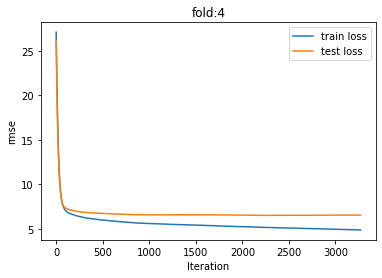

 - fold4_MAE : 6.515666


[I 2022-12-17 16:08:49,803] A new study created in memory with name: no-name-f07c001f-cfaf-4e88-a115-e9bd44d9faa1



★★★★★　　　　　Fold 5　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:08:54,784] Trial 0 finished with value: 6.976120728164045 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 6.976120728164045.


Early stopping, best iteration is:
[759]	Train's l1: 4.87741	Test's l1: 6.97612
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:09:00,072] Trial 1 finished with value: 6.859829393902185 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 6.859829393902185.


Early stopping, best iteration is:
[652]	Train's l1: 4.97069	Test's l1: 6.85983
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:09:07,153] Trial 2 finished with value: 6.778606855316062 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 6.778606855316062.


Early stopping, best iteration is:
[696]	Train's l1: 4.84039	Test's l1: 6.77861
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:09:15,144] Trial 3 finished with value: 6.818406540511202 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 6.778606855316062.


Early stopping, best iteration is:
[812]	Train's l1: 4.68057	Test's l1: 6.81841
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:09:23,593] Trial 4 finished with value: 6.803028930515617 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 6.778606855316062.


Early stopping, best iteration is:
[730]	Train's l1: 4.81621	Test's l1: 6.80303
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:09:29,805] Trial 5 finished with value: 6.838339176690255 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 6.778606855316062.


Early stopping, best iteration is:
[753]	Train's l1: 4.79433	Test's l1: 6.83834
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:09:35,785] Trial 6 finished with value: 6.818784298806353 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 6.778606855316062.


Early stopping, best iteration is:
[542]	Train's l1: 5.10765	Test's l1: 6.81878
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:09:41,093] Trial 7 finished with value: 6.750224941624841 and parameters: {'num_leaves': 17}. Best is trial 7 with value: 6.750224941624841.


Early stopping, best iteration is:
[990]	Train's l1: 5.00205	Test's l1: 6.75022
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:09:50,080] Trial 8 finished with value: 6.814279282840412 and parameters: {'num_leaves': 108}. Best is trial 7 with value: 6.750224941624841.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:09:54,957] Trial 9 finished with value: 6.721375969757651 and parameters: {'num_leaves': 12}. Best is trial 9 with value: 6.721375969757651.


Early stopping, best iteration is:
[1339]	Train's l1: 5.13424	Test's l1: 6.72138
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:10:02,059] Trial 10 finished with value: 6.807726126715038 and parameters: {'num_leaves': 26}. Best is trial 9 with value: 6.721375969757651.


Early stopping, best iteration is:
[923]	Train's l1: 4.69082	Test's l1: 6.80773
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:10:08,309] Trial 11 finished with value: 6.762424026780923 and parameters: {'num_leaves': 24}. Best is trial 9 with value: 6.721375969757651.


Early stopping, best iteration is:
[800]	Train's l1: 4.90651	Test's l1: 6.76242
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:10:17,327] Trial 12 finished with value: 6.814279282840412 and parameters: {'num_leaves': 214}. Best is trial 9 with value: 6.721375969757651.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:10:26,436] Trial 13 finished with value: 6.814279282840412 and parameters: {'num_leaves': 149}. Best is trial 9 with value: 6.721375969757651.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:10:35,405] Trial 14 finished with value: 6.814279282840412 and parameters: {'num_leaves': 180}. Best is trial 9 with value: 6.721375969757651.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:10:44,410] Trial 15 finished with value: 6.814279282840412 and parameters: {'num_leaves': 246}. Best is trial 9 with value: 6.721375969757651.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:10:53,386] Trial 16 finished with value: 6.814279282840412 and parameters: {'num_leaves': 245}. Best is trial 9 with value: 6.721375969757651.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:11:02,314] Trial 17 finished with value: 6.814279282840412 and parameters: {'num_leaves': 80}. Best is trial 9 with value: 6.721375969757651.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 4.92324	Test's l1: 6.47936


[I 2022-12-17 16:11:08,487] Trial 18 finished with value: 6.479356155701572 and parameters: {'num_leaves': 6}. Best is trial 18 with value: 6.479356155701572.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:11:20,456] Trial 19 finished with value: 6.814279282840412 and parameters: {'num_leaves': 73}. Best is trial 18 with value: 6.479356155701572.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:11:29,215] Trial 20 finished with value: 6.814279282840412 and parameters: {'num_leaves': 52}. Best is trial 18 with value: 6.479356155701572.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 6.04341	Test's l1: 6.87134


[I 2022-12-17 16:11:33,150] Trial 21 finished with value: 6.87134362692759 and parameters: {'num_leaves': 3}. Best is trial 18 with value: 6.479356155701572.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:11:42,023] Trial 22 finished with value: 6.814279282840412 and parameters: {'num_leaves': 118}. Best is trial 18 with value: 6.479356155701572.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:11:51,058] Trial 23 finished with value: 6.814279282840412 and parameters: {'num_leaves': 52}. Best is trial 18 with value: 6.479356155701572.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:11:59,875] Trial 24 finished with value: 6.814279282840412 and parameters: {'num_leaves': 49}. Best is trial 18 with value: 6.479356155701572.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	Train's l1: 4.57213	Test's l1: 6.81428


[I 2022-12-17 16:12:08,694] Trial 25 finished with value: 6.814279282840412 and parameters: {'num_leaves': 90}. Best is trial 18 with value: 6.479356155701572.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 4.92324	Test's l1: 6.47936


[I 2022-12-17 16:12:14,753] Trial 26 finished with value: 6.479356155701572 and parameters: {'num_leaves': 6}. Best is trial 18 with value: 6.479356155701572.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:12:19,509] Trial 27 finished with value: 6.9944255930358015 and parameters: {'bagging_fraction': 0.5137110188348314, 'bagging_freq': 1}. Best is trial 27 with value: 6.9944255930358015.


Early stopping, best iteration is:
[2724]	Train's l1: 5.65309	Test's l1: 6.99443
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:12:24,340] Trial 28 finished with value: 7.131338355036119 and parameters: {'bagging_fraction': 0.4492446088409989, 'bagging_freq': 4}. Best is trial 27 with value: 6.9944255930358015.


Early stopping, best iteration is:
[2676]	Train's l1: 5.70012	Test's l1: 7.13134
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3210]	Train's l1: 5.17222	Test's l1: 6.43371


[I 2022-12-17 16:12:30,287] Trial 29 finished with value: 6.4337113227163245 and parameters: {'bagging_fraction': 0.963166133266139, 'bagging_freq': 7}. Best is trial 29 with value: 6.4337113227163245.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:12:34,962] Trial 30 finished with value: 6.4716428596641045 and parameters: {'bagging_fraction': 0.9465968223005404, 'bagging_freq': 6}. Best is trial 29 with value: 6.4337113227163245.


Early stopping, best iteration is:
[2250]	Train's l1: 5.44078	Test's l1: 6.47164
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:12:40,710] Trial 31 finished with value: 6.733132174437934 and parameters: {'bagging_fraction': 0.7571649412542298, 'bagging_freq': 4}. Best is trial 29 with value: 6.4337113227163245.


Early stopping, best iteration is:
[3159]	Train's l1: 5.36146	Test's l1: 6.73313
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:12:45,107] Trial 32 finished with value: 7.031981702404129 and parameters: {'bagging_fraction': 0.4695124896336982, 'bagging_freq': 1}. Best is trial 29 with value: 6.4337113227163245.


Early stopping, best iteration is:
[2094]	Train's l1: 5.82131	Test's l1: 7.03198
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:12:50,803] Trial 33 finished with value: 6.438065585815578 and parameters: {'bagging_fraction': 0.9729634333405704, 'bagging_freq': 2}. Best is trial 29 with value: 6.4337113227163245.


Early stopping, best iteration is:
[2817]	Train's l1: 5.24545	Test's l1: 6.43807
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:12:55,367] Trial 34 finished with value: 6.938787595798882 and parameters: {'bagging_fraction': 0.6265369671642614, 'bagging_freq': 4}. Best is trial 29 with value: 6.4337113227163245.


Early stopping, best iteration is:
[2387]	Train's l1: 5.69781	Test's l1: 6.93879
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:13:00,541] Trial 35 finished with value: 6.630391349762553 and parameters: {'bagging_fraction': 0.8561548539881475, 'bagging_freq': 6}. Best is trial 29 with value: 6.4337113227163245.


Early stopping, best iteration is:
[2682]	Train's l1: 5.3824	Test's l1: 6.63039
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:13:05,379] Trial 36 finished with value: 6.561278707421649 and parameters: {'bagging_fraction': 0.8789282586704348, 'bagging_freq': 3}. Best is trial 29 with value: 6.4337113227163245.


Early stopping, best iteration is:
[2361]	Train's l1: 5.45619	Test's l1: 6.56128
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 4.80931	Test's l1: 6.47526


[I 2022-12-17 16:13:12,317] Trial 37 finished with value: 6.475259776665401 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 6.475259776665401.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3210]	Train's l1: 5.17222	Test's l1: 6.43371


[I 2022-12-17 16:13:18,359] Trial 38 finished with value: 6.4337113227163245 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 6.4337113227163245.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 4.78023	Test's l1: 6.45709


[I 2022-12-17 16:13:25,416] Trial 39 finished with value: 6.457089903559753 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 6.4337113227163245.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:13:30,628] Trial 40 finished with value: 6.421013232712938 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 40 with value: 6.421013232712938.


Early stopping, best iteration is:
[2600]	Train's l1: 5.30898	Test's l1: 6.42101
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 4.77851	Test's l1: 6.43405


[I 2022-12-17 16:13:38,082] Trial 41 finished with value: 6.434047339008467 and parameters: {'feature_fraction': 0.88}. Best is trial 40 with value: 6.421013232712938.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3283]	Train's l1: 5.18003	Test's l1: 6.45099


[I 2022-12-17 16:13:43,840] Trial 42 finished with value: 6.450987375481641 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 40 with value: 6.421013232712938.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 4.78891	Test's l1: 6.42283


[I 2022-12-17 16:13:51,262] Trial 43 finished with value: 6.422833954887326 and parameters: {'lambda_l1': 9.46992775981647, 'lambda_l2': 0.0018053792078447644}. Best is trial 43 with value: 6.422833954887326.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:13:56,492] Trial 44 finished with value: 6.421013232508735 and parameters: {'lambda_l1': 2.5679644751076346e-07, 'lambda_l2': 2.413672435790273e-07}. Best is trial 44 with value: 6.421013232508735.


Early stopping, best iteration is:
[2600]	Train's l1: 5.30898	Test's l1: 6.42101
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:14:02,462] Trial 45 finished with value: 6.421113017775272 and parameters: {'lambda_l1': 8.34578833051923, 'lambda_l2': 8.460490846634085e-08}. Best is trial 44 with value: 6.421013232508735.


Early stopping, best iteration is:
[3122]	Train's l1: 5.16941	Test's l1: 6.42111
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 4.80381	Test's l1: 6.43528


[I 2022-12-17 16:14:09,793] Trial 46 finished with value: 6.43527710187682 and parameters: {'lambda_l1': 8.907035723941672e-06, 'lambda_l2': 0.026021536862705485}. Best is trial 44 with value: 6.421013232508735.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:14:14,978] Trial 47 finished with value: 6.421013205153287 and parameters: {'lambda_l1': 1.5907888024804342e-06, 'lambda_l2': 0.00016472557914635604}. Best is trial 47 with value: 6.421013205153287.


Early stopping, best iteration is:
[2600]	Train's l1: 5.30898	Test's l1: 6.42101
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:14:20,294] Trial 48 finished with value: 6.421013161040658 and parameters: {'lambda_l1': 0.00024004184014892214, 'lambda_l2': 3.701058511088773e-07}. Best is trial 48 with value: 6.421013161040658.


Early stopping, best iteration is:
[2600]	Train's l1: 5.30898	Test's l1: 6.42101
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3186]	Train's l1: 5.17153	Test's l1: 6.42572


[I 2022-12-17 16:14:26,363] Trial 49 finished with value: 6.42572285876406 and parameters: {'lambda_l1': 0.041855993349842205, 'lambda_l2': 0.005456369795141377}. Best is trial 48 with value: 6.421013161040658.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:14:31,679] Trial 50 finished with value: 6.421012976228684 and parameters: {'lambda_l1': 0.0008488650188837379, 'lambda_l2': 5.975017457475176e-06}. Best is trial 50 with value: 6.421012976228684.


Early stopping, best iteration is:
[2600]	Train's l1: 5.30898	Test's l1: 6.42101
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:14:36,922] Trial 51 finished with value: 6.421012993349649 and parameters: {'lambda_l1': 0.0007919079875125306, 'lambda_l2': 9.03359111158203e-06}. Best is trial 50 with value: 6.421012976228684.


Early stopping, best iteration is:
[2600]	Train's l1: 5.30898	Test's l1: 6.42101
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3186]	Train's l1: 5.1931	Test's l1: 6.40991


[I 2022-12-17 16:14:43,013] Trial 52 finished with value: 6.409912530041649 and parameters: {'lambda_l1': 5.881207601007454e-06, 'lambda_l2': 6.1012253842734365}. Best is trial 52 with value: 6.409912530041649.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[4999]	Train's l1: 4.82201	Test's l1: 6.39849


[I 2022-12-17 16:14:50,474] Trial 53 finished with value: 6.398491937036116 and parameters: {'lambda_l1': 2.2860304460649222e-08, 'lambda_l2': 5.165675042938362}. Best is trial 53 with value: 6.398491937036116.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 4.82416	Test's l1: 6.46626


[I 2022-12-17 16:14:57,817] Trial 54 finished with value: 6.466262107623516 and parameters: {'lambda_l1': 2.1663199543790352e-08, 'lambda_l2': 8.209784501259096}. Best is trial 53 with value: 6.398491937036116.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:15:02,771] Trial 55 finished with value: 6.447933074229021 and parameters: {'lambda_l1': 1.6051844032479925e-08, 'lambda_l2': 7.839275091594398}. Best is trial 53 with value: 6.398491937036116.


Early stopping, best iteration is:
[2378]	Train's l1: 5.41168	Test's l1: 6.44793
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3207]	Train's l1: 5.1743	Test's l1: 6.4171


[I 2022-12-17 16:15:08,963] Trial 56 finished with value: 6.4171046691842575 and parameters: {'lambda_l1': 1.4893151968832786e-05, 'lambda_l2': 0.2117001179623987}. Best is trial 53 with value: 6.398491937036116.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:15:14,187] Trial 57 finished with value: 6.4482777539605385 and parameters: {'lambda_l1': 7.243435316573157e-07, 'lambda_l2': 0.2050856332554375}. Best is trial 53 with value: 6.398491937036116.


Early stopping, best iteration is:
[2597]	Train's l1: 5.32096	Test's l1: 6.44828
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3811]	Train's l1: 5.02919	Test's l1: 6.43644


[I 2022-12-17 16:15:24,257] Trial 58 finished with value: 6.436444036783179 and parameters: {'lambda_l1': 1.08745286947753e-07, 'lambda_l2': 0.5703838948063251}. Best is trial 53 with value: 6.398491937036116.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:15:29,719] Trial 59 finished with value: 6.4560215743560025 and parameters: {'lambda_l1': 4.42166666808766e-05, 'lambda_l2': 0.8508234373472637}. Best is trial 53 with value: 6.398491937036116.


Early stopping, best iteration is:
[2744]	Train's l1: 5.28418	Test's l1: 6.45602
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:15:34,709] Trial 60 finished with value: 6.432841308023933 and parameters: {'lambda_l1': 0.01496968813444074, 'lambda_l2': 0.029414511194471492}. Best is trial 53 with value: 6.398491937036116.


Early stopping, best iteration is:
[2414]	Train's l1: 5.37155	Test's l1: 6.43284
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 4.83218	Test's l1: 6.40223


[I 2022-12-17 16:15:42,041] Trial 61 finished with value: 6.402231397639049 and parameters: {'lambda_l1': 2.1241532591897196e-06, 'lambda_l2': 9.738015769469644}. Best is trial 53 with value: 6.398491937036116.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:15:47,398] Trial 62 finished with value: 6.421013207100266 and parameters: {'lambda_l1': 7.365981541186625e-08, 'lambda_l2': 0.00016021581694894364}. Best is trial 53 with value: 6.398491937036116.


Early stopping, best iteration is:
[2600]	Train's l1: 5.30898	Test's l1: 6.42101
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[4999]	Train's l1: 4.82201	Test's l1: 6.39849


[I 2022-12-17 16:15:54,747] Trial 63 finished with value: 6.398491937036116 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.398491937036116.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[4999]	Train's l1: 4.82201	Test's l1: 6.39849


[I 2022-12-17 16:16:02,091] Trial 64 finished with value: 6.398491937036116 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 6.398491937036116.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[4999]	Train's l1: 4.82201	Test's l1: 6.39849


[I 2022-12-17 16:16:09,396] Trial 65 finished with value: 6.398491937036116 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 6.398491937036116.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[4999]	Train's l1: 4.82201	Test's l1: 6.39849


[I 2022-12-17 16:16:16,767] Trial 66 finished with value: 6.398491937036116 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.398491937036116.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[4999]	Train's l1: 4.82201	Test's l1: 6.39849


[I 2022-12-17 16:16:24,110] Trial 67 finished with value: 6.398491937036116 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 6.398491937036116.


▼▼▼▼▼　　　　　Fold 5　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 2.2860304460649222e-08, 'lambda_l2': 5.165675042938362, 'num_leaves': 6, 'feature_fraction': 0.8480000000000001, 'bagging_fraction': 0.963166133266139, 'bagging_freq': 7, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


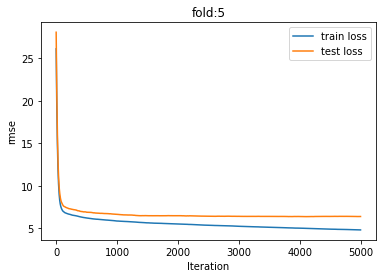

 - fold5_MAE : 6.398492
 - CV_MAE : 6.358105


In [ ]:
# 印刷機 ー 正味作業時間
kf_cv = list(kf.split(df_train_printer_x))
oof_valid_lgb_main_printer, lgb_models_main_printer = fit_lgb_oputuna(x=df_train_printer_x, y=df_train_printer_main_y, cv=kf_cv,
                                      model_params=optuna_model_params, fit_params=oputuna_fit_params
                                     )

[I 2022-12-14 15:31:52,191] A new study created in memory with name: no-name-1d784e73-9434-4d7e-aff1-13db5333b097


data_labels: ['合計数量', '予備数量', '数量1', '刷了数', '通し実数', '加工予備数', '印刷予備数', '号機名', '号機コード', '刷本寸法幅', '裏色数', 'カテゴリ名1', '数量3', '部品区分名', '表色数', '製品仕様コード', '作業日', '台数', '連量', '予定組ラベルキー', '受注番号', '数量2', '部品区分', '刷本寸法長さ', '流用受注番号', '受注キャンセル日', '流用受注日', 'ロット番号', '流用製品仕様コード', '先方注文番号']

★★★★★　　　　　Fold 1　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:31:56,346] Trial 0 finished with value: 6.493770006186415 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 6.493770006186415.


Early stopping, best iteration is:
[291]	Train's l1: 5.56875	Test's l1: 6.49377
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:31:59,690] Trial 1 finished with value: 6.480192691596939 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:03,892] Trial 2 finished with value: 6.49482681041082 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 6.480192691596939.


Early stopping, best iteration is:
[376]	Train's l1: 5.40675	Test's l1: 6.49483
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:06,707] Trial 3 finished with value: 6.579359892325087 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 6.480192691596939.


Early stopping, best iteration is:
[337]	Train's l1: 5.54645	Test's l1: 6.57936
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:10,405] Trial 4 finished with value: 6.5059053289550315 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 6.480192691596939.


Early stopping, best iteration is:
[342]	Train's l1: 5.47108	Test's l1: 6.50591
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:13,477] Trial 5 finished with value: 6.493646350564429 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 6.480192691596939.


Early stopping, best iteration is:
[303]	Train's l1: 5.5662	Test's l1: 6.49365
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:18,044] Trial 6 finished with value: 6.493575063855146 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 6.480192691596939.


Early stopping, best iteration is:
[320]	Train's l1: 5.51691	Test's l1: 6.49358
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:22,510] Trial 7 finished with value: 6.49921733434638 and parameters: {'num_leaves': 189}. Best is trial 7 with value: 6.49921733434638.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:26,839] Trial 8 finished with value: 6.49921733434638 and parameters: {'num_leaves': 228}. Best is trial 7 with value: 6.49921733434638.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:31,285] Trial 9 finished with value: 6.49921733434638 and parameters: {'num_leaves': 228}. Best is trial 7 with value: 6.49921733434638.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:35,646] Trial 10 finished with value: 6.49921733434638 and parameters: {'num_leaves': 81}. Best is trial 7 with value: 6.49921733434638.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:40,061] Trial 11 finished with value: 6.49921733434638 and parameters: {'num_leaves': 74}. Best is trial 7 with value: 6.49921733434638.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:44,496] Trial 12 finished with value: 6.49921733434638 and parameters: {'num_leaves': 246}. Best is trial 7 with value: 6.49921733434638.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:49,033] Trial 13 finished with value: 6.49921733434638 and parameters: {'num_leaves': 206}. Best is trial 7 with value: 6.49921733434638.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:53,295] Trial 14 finished with value: 6.49921733434638 and parameters: {'num_leaves': 86}. Best is trial 7 with value: 6.49921733434638.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:32:56,805] Trial 15 finished with value: 6.504445409740477 and parameters: {'num_leaves': 36}. Best is trial 7 with value: 6.49921733434638.


Early stopping, best iteration is:
[291]	Train's l1: 5.52343	Test's l1: 6.50445
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:00,260] Trial 16 finished with value: 6.480192691596939 and parameters: {'num_leaves': 31}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:01,572] Trial 17 finished with value: 6.698374022880847 and parameters: {'num_leaves': 4}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[984]	Train's l1: 6.10012	Test's l1: 6.69837
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:05,890] Trial 18 finished with value: 6.49921733434638 and parameters: {'num_leaves': 152}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:10,289] Trial 19 finished with value: 6.49921733434638 and parameters: {'num_leaves': 174}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:14,648] Trial 20 finished with value: 6.49921733434638 and parameters: {'num_leaves': 120}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:19,016] Trial 21 finished with value: 6.49921733434638 and parameters: {'num_leaves': 175}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:23,350] Trial 22 finished with value: 6.49921733434638 and parameters: {'num_leaves': 119}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:27,376] Trial 23 finished with value: 6.513362030888847 and parameters: {'num_leaves': 45}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[299]	Train's l1: 5.44287	Test's l1: 6.51336
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:31,841] Trial 24 finished with value: 6.49921733434638 and parameters: {'num_leaves': 192}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:33,736] Trial 25 finished with value: 6.583163510116522 and parameters: {'num_leaves': 12}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[411]	Train's l1: 5.82763	Test's l1: 6.58316
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:38,092] Trial 26 finished with value: 6.49921733434638 and parameters: {'num_leaves': 138}. Best is trial 16 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.37607	Test's l1: 6.49922
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:42,450] Trial 27 finished with value: 6.5501003823573525 and parameters: {'bagging_fraction': 0.8951869432048805, 'bagging_freq': 3}. Best is trial 27 with value: 6.5501003823573525.


Early stopping, best iteration is:
[356]	Train's l1: 5.56924	Test's l1: 6.5501
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:46,761] Trial 28 finished with value: 6.571945921864007 and parameters: {'bagging_fraction': 0.8592307460598737, 'bagging_freq': 3}. Best is trial 27 with value: 6.5501003823573525.


Early stopping, best iteration is:
[369]	Train's l1: 5.61365	Test's l1: 6.57195
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:51,384] Trial 29 finished with value: 7.1477009657637165 and parameters: {'bagging_fraction': 0.52439842371733, 'bagging_freq': 2}. Best is trial 27 with value: 6.5501003823573525.


Early stopping, best iteration is:
[868]	Train's l1: 5.91124	Test's l1: 7.1477
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:55,504] Trial 30 finished with value: 6.572948419223447 and parameters: {'bagging_fraction': 0.9306381534060467, 'bagging_freq': 7}. Best is trial 27 with value: 6.5501003823573525.


Early stopping, best iteration is:
[306]	Train's l1: 5.63091	Test's l1: 6.57295
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:33:59,721] Trial 31 finished with value: 7.293876345300662 and parameters: {'bagging_fraction': 0.4979879082513673, 'bagging_freq': 4}. Best is trial 27 with value: 6.5501003823573525.


Early stopping, best iteration is:
[872]	Train's l1: 6.0547	Test's l1: 7.29388
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:03,712] Trial 32 finished with value: 6.590799754191082 and parameters: {'bagging_fraction': 0.8611306241570535, 'bagging_freq': 5}. Best is trial 27 with value: 6.5501003823573525.


Early stopping, best iteration is:
[295]	Train's l1: 5.72108	Test's l1: 6.5908
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:08,395] Trial 33 finished with value: 6.686272632728453 and parameters: {'bagging_fraction': 0.7248415893624591, 'bagging_freq': 7}. Best is trial 27 with value: 6.5501003823573525.


Early stopping, best iteration is:
[621]	Train's l1: 5.47608	Test's l1: 6.68627
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:12,540] Trial 34 finished with value: 6.519510192404279 and parameters: {'bagging_fraction': 0.9799243766480039, 'bagging_freq': 6}. Best is trial 34 with value: 6.519510192404279.


Early stopping, best iteration is:
[305]	Train's l1: 5.56142	Test's l1: 6.51951
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:16,630] Trial 35 finished with value: 7.259578644196066 and parameters: {'bagging_fraction': 0.5013007461131981, 'bagging_freq': 2}. Best is trial 34 with value: 6.519510192404279.


Early stopping, best iteration is:
[804]	Train's l1: 6.10346	Test's l1: 7.25958
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1380]	Train's l1: 5.89899	Test's l1: 7.45848


[I 2022-12-14 15:34:21,765] Trial 36 finished with value: 7.458476850033305 and parameters: {'bagging_fraction': 0.4635800233671128, 'bagging_freq': 5}. Best is trial 34 with value: 6.519510192404279.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:29,303] Trial 37 finished with value: 6.480192691596939 and parameters: {'feature_fraction': 0.616}. Best is trial 37 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:32,779] Trial 38 finished with value: 6.480192691596939 and parameters: {'feature_fraction': 0.584}. Best is trial 37 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:36,110] Trial 39 finished with value: 6.49592019832215 and parameters: {'feature_fraction': 0.552}. Best is trial 37 with value: 6.480192691596939.


Early stopping, best iteration is:
[357]	Train's l1: 5.45354	Test's l1: 6.49592
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:39,702] Trial 40 finished with value: 6.5094947212387275 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 6.480192691596939.


Early stopping, best iteration is:
[315]	Train's l1: 5.54266	Test's l1: 6.50949
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:42,934] Trial 41 finished with value: 6.493646350564429 and parameters: {'feature_fraction': 0.52}. Best is trial 37 with value: 6.480192691596939.


Early stopping, best iteration is:
[303]	Train's l1: 5.5662	Test's l1: 6.49365
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:46,680] Trial 42 finished with value: 6.5059053289550315 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 37 with value: 6.480192691596939.


Early stopping, best iteration is:
[342]	Train's l1: 5.47108	Test's l1: 6.50591
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:50,112] Trial 43 finished with value: 6.501275764622144 and parameters: {'lambda_l1': 5.394842698095551e-06, 'lambda_l2': 9.35821423728848}. Best is trial 43 with value: 6.501275764622144.


Early stopping, best iteration is:
[337]	Train's l1: 5.54088	Test's l1: 6.50128
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:53,630] Trial 44 finished with value: 6.48019270022488 and parameters: {'lambda_l1': 1.3846436598209781e-06, 'lambda_l2': 1.2519688020284669e-05}. Best is trial 44 with value: 6.48019270022488.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:34:56,951] Trial 45 finished with value: 6.488886079292081 and parameters: {'lambda_l1': 5.8246694946980866e-05, 'lambda_l2': 0.0005596061726305954}. Best is trial 44 with value: 6.48019270022488.


Early stopping, best iteration is:
[303]	Train's l1: 5.55529	Test's l1: 6.48889
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:00,256] Trial 46 finished with value: 6.488886736029535 and parameters: {'lambda_l1': 3.8538907102889755e-06, 'lambda_l2': 0.0014230318143641737}. Best is trial 44 with value: 6.48019270022488.


Early stopping, best iteration is:
[303]	Train's l1: 5.55529	Test's l1: 6.48889
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:03,778] Trial 47 finished with value: 6.48019269190256 and parameters: {'lambda_l1': 2.7018553774849854e-06, 'lambda_l2': 1.4225630412077762e-08}. Best is trial 47 with value: 6.48019269190256.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:07,141] Trial 48 finished with value: 6.481843350910489 and parameters: {'lambda_l1': 5.393794542822871e-05, 'lambda_l2': 0.02421385340103651}. Best is trial 47 with value: 6.48019269190256.


Early stopping, best iteration is:
[290]	Train's l1: 5.59364	Test's l1: 6.48184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:10,523] Trial 49 finished with value: 6.488885738683347 and parameters: {'lambda_l1': 0.0007791608603795701, 'lambda_l2': 6.750498467322885e-06}. Best is trial 47 with value: 6.48019269190256.


Early stopping, best iteration is:
[303]	Train's l1: 5.55529	Test's l1: 6.48889
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:13,877] Trial 50 finished with value: 6.5286296139676265 and parameters: {'lambda_l1': 0.0848277664219099, 'lambda_l2': 0.3655735201810944}. Best is trial 47 with value: 6.48019269190256.


Early stopping, best iteration is:
[285]	Train's l1: 5.61184	Test's l1: 6.52863
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:17,342] Trial 51 finished with value: 6.480192691601261 and parameters: {'lambda_l1': 2.581438849972648e-07, 'lambda_l2': 3.3589714551226965e-07}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:20,806] Trial 52 finished with value: 6.492093275669171 and parameters: {'lambda_l1': 2.676615086152248e-06, 'lambda_l2': 0.29661155022686597}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[360]	Train's l1: 5.4476	Test's l1: 6.49209
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:24,329] Trial 53 finished with value: 6.480192691816453 and parameters: {'lambda_l1': 4.210568155519738e-08, 'lambda_l2': 3.1753449217864465e-08}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:27,658] Trial 54 finished with value: 6.480192691844406 and parameters: {'lambda_l1': 1.3552253421522822e-08, 'lambda_l2': 1.544166192562448e-08}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:31,054] Trial 55 finished with value: 6.480192691956794 and parameters: {'lambda_l1': 1.2062523627634217e-08, 'lambda_l2': 7.8990378611069e-07}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:34,555] Trial 56 finished with value: 6.480192691949973 and parameters: {'lambda_l1': 9.842312918283848e-08, 'lambda_l2': 3.651016097652075e-07}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:37,876] Trial 57 finished with value: 6.5063391933714945 and parameters: {'lambda_l1': 0.012938525466212292, 'lambda_l2': 2.8293662198000594e-07}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[278]	Train's l1: 5.61554	Test's l1: 6.50634
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:41,345] Trial 58 finished with value: 6.480192704166425 and parameters: {'lambda_l1': 9.324169082065648e-08, 'lambda_l2': 1.687346001791495e-05}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:44,823] Trial 59 finished with value: 6.51276331304036 and parameters: {'lambda_l1': 5.593184476875209, 'lambda_l2': 8.47863458436705e-08}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[327]	Train's l1: 5.53039	Test's l1: 6.51276
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:48,291] Trial 60 finished with value: 6.480192735307551 and parameters: {'lambda_l1': 2.5504294112861704e-07, 'lambda_l2': 5.9243031983653764e-05}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:51,718] Trial 61 finished with value: 6.480192718433178 and parameters: {'lambda_l1': 0.0004900830375798145, 'lambda_l2': 1.5075526363340561e-06}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:55,242] Trial 62 finished with value: 6.480192691740274 and parameters: {'lambda_l1': 2.495613531106365e-07, 'lambda_l2': 6.319874715174622e-08}. Best is trial 51 with value: 6.480192691601261.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:35:58,650] Trial 63 finished with value: 6.480192691596939 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:02,167] Trial 64 finished with value: 6.480192691596939 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:05,647] Trial 65 finished with value: 6.480192691596939 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:09,132] Trial 66 finished with value: 6.480192691596939 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:12,473] Trial 67 finished with value: 6.480192691596939 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 6.480192691596939.


Early stopping, best iteration is:
[321]	Train's l1: 5.51984	Test's l1: 6.48019
▼▼▼▼▼　　　　　Fold 1　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


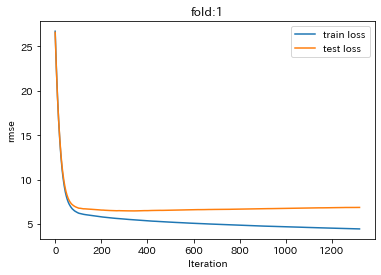

[I 2022-12-14 15:36:12,890] A new study created in memory with name: no-name-bb3abe52-12d7-475d-b4fe-dd3574313fdb


 - fold1_MAE : 6.480193

★★★★★　　　　　Fold 2　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:16,297] Trial 0 finished with value: 6.298134712292181 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 6.298134712292181.


Early stopping, best iteration is:
[288]	Train's l1: 5.72822	Test's l1: 6.29813
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:19,172] Trial 1 finished with value: 6.293165632744271 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 6.293165632744271.


Early stopping, best iteration is:
[309]	Train's l1: 5.72596	Test's l1: 6.29317
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:23,622] Trial 2 finished with value: 6.295432077246104 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 6.293165632744271.


Early stopping, best iteration is:
[251]	Train's l1: 5.81719	Test's l1: 6.29543
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:27,478] Trial 3 finished with value: 6.293853585978652 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 6.293165632744271.


Early stopping, best iteration is:
[272]	Train's l1: 5.75799	Test's l1: 6.29385
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:30,677] Trial 4 finished with value: 6.343055559337622 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 6.293165632744271.


Early stopping, best iteration is:
[274]	Train's l1: 5.7785	Test's l1: 6.34306
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:34,436] Trial 5 finished with value: 6.30716094467747 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 6.293165632744271.


Early stopping, best iteration is:
[325]	Train's l1: 5.65206	Test's l1: 6.30716
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:38,643] Trial 6 finished with value: 6.313731096680323 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 6.293165632744271.


Early stopping, best iteration is:
[277]	Train's l1: 5.74131	Test's l1: 6.31373
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:39,936] Trial 7 finished with value: 6.491084208728821 and parameters: {'num_leaves': 5}. Best is trial 7 with value: 6.491084208728821.


Early stopping, best iteration is:
[846]	Train's l1: 6.16196	Test's l1: 6.49108
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:43,079] Trial 8 finished with value: 6.282963619741132 and parameters: {'num_leaves': 219}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:46,390] Trial 9 finished with value: 6.282963619741132 and parameters: {'num_leaves': 149}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:48,292] Trial 10 finished with value: 6.395759345119314 and parameters: {'num_leaves': 15}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[366]	Train's l1: 5.93582	Test's l1: 6.39576
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:51,529] Trial 11 finished with value: 6.282963619741132 and parameters: {'num_leaves': 151}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:54,649] Trial 12 finished with value: 6.282963619741132 and parameters: {'num_leaves': 110}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:36:57,787] Trial 13 finished with value: 6.282963619741132 and parameters: {'num_leaves': 103}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:00,948] Trial 14 finished with value: 6.282963619741132 and parameters: {'num_leaves': 215}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:04,222] Trial 15 finished with value: 6.282963619741132 and parameters: {'num_leaves': 231}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:07,102] Trial 16 finished with value: 6.284730647927849 and parameters: {'num_leaves': 37}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 6.03087	Test's l1: 6.28473
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:10,280] Trial 17 finished with value: 6.282963619741132 and parameters: {'num_leaves': 194}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:13,442] Trial 18 finished with value: 6.282963619741132 and parameters: {'num_leaves': 163}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:16,673] Trial 19 finished with value: 6.282963619741132 and parameters: {'num_leaves': 248}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:19,899] Trial 20 finished with value: 6.282963619741132 and parameters: {'num_leaves': 182}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:23,037] Trial 21 finished with value: 6.282963619741132 and parameters: {'num_leaves': 92}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:26,183] Trial 22 finished with value: 6.282963619741132 and parameters: {'num_leaves': 141}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:29,265] Trial 23 finished with value: 6.282963619741132 and parameters: {'num_leaves': 68}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:32,457] Trial 24 finished with value: 6.282963619741132 and parameters: {'num_leaves': 77}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:35,696] Trial 25 finished with value: 6.282963619741132 and parameters: {'num_leaves': 250}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:38,891] Trial 26 finished with value: 6.282963619741132 and parameters: {'num_leaves': 255}. Best is trial 8 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:41,865] Trial 27 finished with value: 7.598025369754745 and parameters: {'bagging_fraction': 0.42103088875424977, 'bagging_freq': 4}. Best is trial 27 with value: 7.598025369754745.


Early stopping, best iteration is:
[604]	Train's l1: 6.97994	Test's l1: 7.59803
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:45,669] Trial 28 finished with value: 6.503819284701673 and parameters: {'bagging_fraction': 0.821812489779882, 'bagging_freq': 7}. Best is trial 28 with value: 6.503819284701673.


Early stopping, best iteration is:
[295]	Train's l1: 5.8843	Test's l1: 6.50382
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:49,263] Trial 29 finished with value: 7.411618814884256 and parameters: {'bagging_fraction': 0.5426962783091648, 'bagging_freq': 1}. Best is trial 28 with value: 6.503819284701673.


Early stopping, best iteration is:
[699]	Train's l1: 6.29552	Test's l1: 7.41162
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:53,734] Trial 30 finished with value: 6.335501616028137 and parameters: {'bagging_fraction': 0.9672065214497677, 'bagging_freq': 4}. Best is trial 30 with value: 6.335501616028137.


Early stopping, best iteration is:
[283]	Train's l1: 5.72071	Test's l1: 6.3355
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:37:57,406] Trial 31 finished with value: 6.488858515820126 and parameters: {'bagging_fraction': 0.7998905602985897, 'bagging_freq': 5}. Best is trial 30 with value: 6.335501616028137.


Early stopping, best iteration is:
[252]	Train's l1: 6.02858	Test's l1: 6.48886
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:00,929] Trial 32 finished with value: 6.514731117062122 and parameters: {'bagging_fraction': 0.8019815197974328, 'bagging_freq': 2}. Best is trial 30 with value: 6.335501616028137.


Early stopping, best iteration is:
[172]	Train's l1: 6.22869	Test's l1: 6.51473
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:03,978] Trial 33 finished with value: 6.4961297282349975 and parameters: {'bagging_fraction': 0.7825776045559366, 'bagging_freq': 1}. Best is trial 30 with value: 6.335501616028137.


Early stopping, best iteration is:
[251]	Train's l1: 6.02921	Test's l1: 6.49613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:07,896] Trial 34 finished with value: 6.485657230551942 and parameters: {'bagging_fraction': 0.8433922076789453, 'bagging_freq': 7}. Best is trial 30 with value: 6.335501616028137.


Early stopping, best iteration is:
[315]	Train's l1: 5.83443	Test's l1: 6.48566
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:11,780] Trial 35 finished with value: 7.225100392474488 and parameters: {'bagging_fraction': 0.5967559400182688, 'bagging_freq': 4}. Best is trial 30 with value: 6.335501616028137.


Early stopping, best iteration is:
[588]	Train's l1: 6.19144	Test's l1: 7.2251
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:15,379] Trial 36 finished with value: 6.4436785542346176 and parameters: {'bagging_fraction': 0.7720735313767729, 'bagging_freq': 5}. Best is trial 30 with value: 6.335501616028137.


Early stopping, best iteration is:
[286]	Train's l1: 5.99591	Test's l1: 6.44368
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:19,256] Trial 37 finished with value: 6.304896338484223 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 6.304896338484223.


Early stopping, best iteration is:
[248]	Train's l1: 5.70784	Test's l1: 6.3049
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:22,630] Trial 38 finished with value: 6.306418707818991 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 6.304896338484223.


Early stopping, best iteration is:
[171]	Train's l1: 5.95755	Test's l1: 6.30642
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:25,781] Trial 39 finished with value: 6.282963619741132 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 39 with value: 6.282963619741132.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:28,973] Trial 40 finished with value: 6.293193876806787 and parameters: {'lambda_l1': 0.1390693387418595, 'lambda_l2': 0.0001330824715772825}. Best is trial 40 with value: 6.293193876806787.


Early stopping, best iteration is:
[173]	Train's l1: 5.97247	Test's l1: 6.29319
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:32,261] Trial 41 finished with value: 6.295976962496348 and parameters: {'lambda_l1': 1.1627473912339745e-07, 'lambda_l2': 0.5565353118191207}. Best is trial 40 with value: 6.293193876806787.


Early stopping, best iteration is:
[171]	Train's l1: 5.99578	Test's l1: 6.29598
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:35,429] Trial 42 finished with value: 6.283781598770588 and parameters: {'lambda_l1': 0.0007301990663273033, 'lambda_l2': 0.00020446480782641415}. Best is trial 42 with value: 6.283781598770588.


Early stopping, best iteration is:
[158]	Train's l1: 6.03851	Test's l1: 6.28378
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:38,830] Trial 43 finished with value: 6.280404514899103 and parameters: {'lambda_l1': 2.249343596612517e-06, 'lambda_l2': 0.05314556196240623}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[249]	Train's l1: 5.75463	Test's l1: 6.2804
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:42,031] Trial 44 finished with value: 6.2837813191806156 and parameters: {'lambda_l1': 1.4255050583566692e-07, 'lambda_l2': 0.0005775053447236204}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[158]	Train's l1: 6.03851	Test's l1: 6.28378
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:45,282] Trial 45 finished with value: 6.282963632501629 and parameters: {'lambda_l1': 1.5528608007493122e-08, 'lambda_l2': 8.043828226042481e-05}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:48,507] Trial 46 finished with value: 6.290968712557937 and parameters: {'lambda_l1': 0.012811593591051433, 'lambda_l2': 1.0403776897371826e-08}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[176]	Train's l1: 5.96266	Test's l1: 6.29097
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:52,113] Trial 47 finished with value: 6.2868515017668685 and parameters: {'lambda_l1': 0.0019016588332144118, 'lambda_l2': 0.002899590209966067}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[289]	Train's l1: 5.63334	Test's l1: 6.28685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:55,324] Trial 48 finished with value: 6.2829636193739695 and parameters: {'lambda_l1': 1.8126555143808207e-06, 'lambda_l2': 3.7964660967732076e-05}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:38:58,600] Trial 49 finished with value: 6.282963607638816 and parameters: {'lambda_l1': 5.600639240982391e-06, 'lambda_l2': 6.694501433387656e-07}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:01,769] Trial 50 finished with value: 6.306098435330566 and parameters: {'lambda_l1': 5.251610621918171, 'lambda_l2': 7.511083015419844}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[177]	Train's l1: 6.04844	Test's l1: 6.3061
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:05,000] Trial 51 finished with value: 6.282963612156914 and parameters: {'lambda_l1': 1.390641156586342e-05, 'lambda_l2': 1.6565880462805555e-07}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:08,418] Trial 52 finished with value: 6.285445920077288 and parameters: {'lambda_l1': 1.9179242268822673e-05, 'lambda_l2': 0.042682207690381675}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[248]	Train's l1: 5.75509	Test's l1: 6.28545
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:11,653] Trial 53 finished with value: 6.282963619730791 and parameters: {'lambda_l1': 2.531729621577009e-05, 'lambda_l2': 1.3840504187719483e-06}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:15,051] Trial 54 finished with value: 6.295078169571827 and parameters: {'lambda_l1': 9.201996869662767e-07, 'lambda_l2': 0.023816986311505865}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[249]	Train's l1: 5.75001	Test's l1: 6.29508
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:18,296] Trial 55 finished with value: 6.282963760141447 and parameters: {'lambda_l1': 0.000150624793331518, 'lambda_l2': 5.22320968294945e-06}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:21,554] Trial 56 finished with value: 6.283462178206814 and parameters: {'lambda_l1': 1.3147661980460336e-06, 'lambda_l2': 0.01074062195527142}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[171]	Train's l1: 5.98109	Test's l1: 6.28346
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:25,069] Trial 57 finished with value: 6.2901496977862745 and parameters: {'lambda_l1': 1.8606295992356007e-08, 'lambda_l2': 0.8397804615468548}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[271]	Train's l1: 5.69704	Test's l1: 6.29015
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:28,347] Trial 58 finished with value: 6.282963665893265 and parameters: {'lambda_l1': 0.00010880906100448756, 'lambda_l2': 1.2315946533371972e-08}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[171]	Train's l1: 5.9899	Test's l1: 6.28296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:31,989] Trial 59 finished with value: 6.286758517525778 and parameters: {'lambda_l1': 0.009333388264713955, 'lambda_l2': 4.1191394980473696e-07}. Best is trial 43 with value: 6.280404514899103.


Early stopping, best iteration is:
[289]	Train's l1: 5.63338	Test's l1: 6.28676
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:35,440] Trial 60 finished with value: 6.280404514899103 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 6.280404514899103.


Early stopping, best iteration is:
[249]	Train's l1: 5.75463	Test's l1: 6.2804
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:38,918] Trial 61 finished with value: 6.280404514899103 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 6.280404514899103.


Early stopping, best iteration is:
[249]	Train's l1: 5.75463	Test's l1: 6.2804
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:42,514] Trial 62 finished with value: 6.280404514899103 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 6.280404514899103.


Early stopping, best iteration is:
[249]	Train's l1: 5.75463	Test's l1: 6.2804
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:46,029] Trial 63 finished with value: 6.280404514899103 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 6.280404514899103.


Early stopping, best iteration is:
[249]	Train's l1: 5.75463	Test's l1: 6.2804
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:49,542] Trial 64 finished with value: 6.280404514899103 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 6.280404514899103.


Early stopping, best iteration is:
[249]	Train's l1: 5.75463	Test's l1: 6.2804
▼▼▼▼▼　　　　　Fold 2　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 2.249343596612517e-06, 'lambda_l2': 0.05314556196240623, 'num_leaves': 219, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


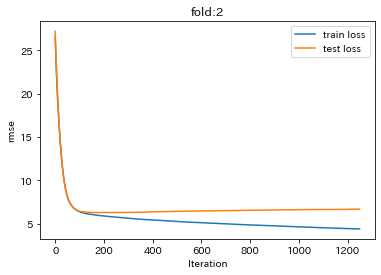

[I 2022-12-14 15:39:49,977] A new study created in memory with name: no-name-baf58f93-6036-4cba-af17-696206e6d796


 - fold2_MAE : 6.280405

★★★★★　　　　　Fold 3　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:54,900] Trial 0 finished with value: 6.488648650071054 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 6.488648650071054.


Early stopping, best iteration is:
[355]	Train's l1: 5.492	Test's l1: 6.48865
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:39:58,669] Trial 1 finished with value: 6.5014420174978165 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 6.488648650071054.


Early stopping, best iteration is:
[338]	Train's l1: 5.53821	Test's l1: 6.50144
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:02,429] Trial 2 finished with value: 6.470361350511477 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 6.470361350511477.


Early stopping, best iteration is:
[397]	Train's l1: 5.42441	Test's l1: 6.47036
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:06,811] Trial 3 finished with value: 6.456440306402715 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 6.456440306402715.


Early stopping, best iteration is:
[350]	Train's l1: 5.49232	Test's l1: 6.45644
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:11,121] Trial 4 finished with value: 6.482385200384038 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 6.456440306402715.


Early stopping, best iteration is:
[390]	Train's l1: 5.41107	Test's l1: 6.48239
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:14,601] Trial 5 finished with value: 6.498618787423631 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 6.456440306402715.


Early stopping, best iteration is:
[399]	Train's l1: 5.44033	Test's l1: 6.49862
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:22,079] Trial 6 finished with value: 6.466673853557117 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 6.456440306402715.


Early stopping, best iteration is:
[451]	Train's l1: 5.39072	Test's l1: 6.46667
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:27,782] Trial 7 finished with value: 6.468497822631332 and parameters: {'num_leaves': 208}. Best is trial 7 with value: 6.468497822631332.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:33,313] Trial 8 finished with value: 6.468497822631332 and parameters: {'num_leaves': 109}. Best is trial 7 with value: 6.468497822631332.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:38,997] Trial 9 finished with value: 6.468497822631332 and parameters: {'num_leaves': 186}. Best is trial 7 with value: 6.468497822631332.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:44,675] Trial 10 finished with value: 6.468497822631332 and parameters: {'num_leaves': 98}. Best is trial 7 with value: 6.468497822631332.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:49,987] Trial 11 finished with value: 6.455198285375084 and parameters: {'num_leaves': 40}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[381]	Train's l1: 5.32244	Test's l1: 6.4552
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:40:55,696] Trial 12 finished with value: 6.468497822631332 and parameters: {'num_leaves': 86}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:01,060] Trial 13 finished with value: 6.482387516264625 and parameters: {'num_leaves': 47}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[297]	Train's l1: 5.47581	Test's l1: 6.48239
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:04,350] Trial 14 finished with value: 6.476539649780613 and parameters: {'num_leaves': 21}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[355]	Train's l1: 5.65539	Test's l1: 6.47654
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:10,044] Trial 15 finished with value: 6.468497822631332 and parameters: {'num_leaves': 102}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:15,697] Trial 16 finished with value: 6.468497822631332 and parameters: {'num_leaves': 130}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:17,574] Trial 17 finished with value: 6.56876901838799 and parameters: {'num_leaves': 4}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[1262]	Train's l1: 6.01964	Test's l1: 6.56877
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:23,225] Trial 18 finished with value: 6.468497822631332 and parameters: {'num_leaves': 238}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:28,789] Trial 19 finished with value: 6.468497822631332 and parameters: {'num_leaves': 190}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:34,431] Trial 20 finished with value: 6.468497822631332 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:40,003] Trial 21 finished with value: 6.468497822631332 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:45,448] Trial 22 finished with value: 6.468497822631332 and parameters: {'num_leaves': 53}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:51,310] Trial 23 finished with value: 6.468497822631332 and parameters: {'num_leaves': 216}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:41:57,019] Trial 24 finished with value: 6.468497822631332 and parameters: {'num_leaves': 155}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:02,578] Trial 25 finished with value: 6.468497822631332 and parameters: {'num_leaves': 64}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:08,119] Trial 26 finished with value: 6.468497822631332 and parameters: {'num_leaves': 148}. Best is trial 11 with value: 6.455198285375084.


Early stopping, best iteration is:
[328]	Train's l1: 5.3748	Test's l1: 6.4685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:13,614] Trial 27 finished with value: 6.44194052607931 and parameters: {'bagging_fraction': 0.9866472558808052, 'bagging_freq': 1}. Best is trial 27 with value: 6.44194052607931.


Early stopping, best iteration is:
[424]	Train's l1: 5.23291	Test's l1: 6.44194
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:19,298] Trial 28 finished with value: 6.55342576081064 and parameters: {'bagging_fraction': 0.8676567722708686, 'bagging_freq': 5}. Best is trial 27 with value: 6.44194052607931.


Early stopping, best iteration is:
[322]	Train's l1: 5.63312	Test's l1: 6.55343
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:23,369] Trial 29 finished with value: 7.111207667185577 and parameters: {'bagging_fraction': 0.4735208893617748, 'bagging_freq': 2}. Best is trial 27 with value: 6.44194052607931.


Early stopping, best iteration is:
[588]	Train's l1: 6.4975	Test's l1: 7.11121
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:28,176] Trial 30 finished with value: 7.198228913264617 and parameters: {'bagging_fraction': 0.4960941390225296, 'bagging_freq': 7}. Best is trial 27 with value: 6.44194052607931.


Early stopping, best iteration is:
[803]	Train's l1: 6.26979	Test's l1: 7.19823
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:32,638] Trial 31 finished with value: 6.886283177567563 and parameters: {'bagging_fraction': 0.55599961032301, 'bagging_freq': 6}. Best is trial 27 with value: 6.44194052607931.


Early stopping, best iteration is:
[498]	Train's l1: 6.29063	Test's l1: 6.88628
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:38,367] Trial 32 finished with value: 6.6836165093370825 and parameters: {'bagging_fraction': 0.7035343001463836, 'bagging_freq': 6}. Best is trial 27 with value: 6.44194052607931.


Early stopping, best iteration is:
[568]	Train's l1: 5.59151	Test's l1: 6.68362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:45,322] Trial 33 finished with value: 6.491244360670473 and parameters: {'bagging_fraction': 0.9508435656508271, 'bagging_freq': 7}. Best is trial 27 with value: 6.44194052607931.


Early stopping, best iteration is:
[494]	Train's l1: 5.14048	Test's l1: 6.49124
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:51,408] Trial 34 finished with value: 6.69971423045861 and parameters: {'bagging_fraction': 0.702692259196648, 'bagging_freq': 7}. Best is trial 27 with value: 6.44194052607931.


Early stopping, best iteration is:
[631]	Train's l1: 5.5244	Test's l1: 6.69971
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:42:56,162] Trial 35 finished with value: 6.701301136465248 and parameters: {'bagging_fraction': 0.6759184528667533, 'bagging_freq': 3}. Best is trial 27 with value: 6.44194052607931.


Early stopping, best iteration is:
[303]	Train's l1: 6.08818	Test's l1: 6.7013
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:01,602] Trial 36 finished with value: 6.642514965846402 and parameters: {'bagging_fraction': 0.7389918501333317, 'bagging_freq': 5}. Best is trial 27 with value: 6.44194052607931.


Early stopping, best iteration is:
[411]	Train's l1: 5.74405	Test's l1: 6.64251
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:07,184] Trial 37 finished with value: 6.4583928500400125 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 6.4583928500400125.


Early stopping, best iteration is:
[356]	Train's l1: 5.38861	Test's l1: 6.45839
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:12,207] Trial 38 finished with value: 6.461051207746794 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 6.4583928500400125.


Early stopping, best iteration is:
[365]	Train's l1: 5.36278	Test's l1: 6.46105
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:17,060] Trial 39 finished with value: 6.486455022729015 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 6.4583928500400125.


Early stopping, best iteration is:
[305]	Train's l1: 5.48279	Test's l1: 6.48646
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:22,589] Trial 40 finished with value: 6.44194052607931 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 40 with value: 6.44194052607931.


Early stopping, best iteration is:
[424]	Train's l1: 5.23291	Test's l1: 6.44194
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:27,990] Trial 41 finished with value: 6.443293828246027 and parameters: {'feature_fraction': 0.948}. Best is trial 40 with value: 6.44194052607931.


Early stopping, best iteration is:
[351]	Train's l1: 5.38959	Test's l1: 6.44329
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:33,704] Trial 42 finished with value: 6.44194052607931 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 40 with value: 6.44194052607931.


Early stopping, best iteration is:
[424]	Train's l1: 5.23291	Test's l1: 6.44194
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:39,067] Trial 43 finished with value: 6.427861692006375 and parameters: {'lambda_l1': 0.0004479251229846313, 'lambda_l2': 0.0030096615690180127}. Best is trial 43 with value: 6.427861692006375.


Early stopping, best iteration is:
[396]	Train's l1: 5.28938	Test's l1: 6.42786
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:44,334] Trial 44 finished with value: 6.463612485670889 and parameters: {'lambda_l1': 5.135261742755442e-05, 'lambda_l2': 0.5259317543471805}. Best is trial 43 with value: 6.427861692006375.


Early stopping, best iteration is:
[351]	Train's l1: 5.3879	Test's l1: 6.46361
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:49,722] Trial 45 finished with value: 6.452891811671956 and parameters: {'lambda_l1': 0.0034620464037378273, 'lambda_l2': 2.788667402204904e-05}. Best is trial 43 with value: 6.427861692006375.


Early stopping, best iteration is:
[383]	Train's l1: 5.30365	Test's l1: 6.45289
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:43:55,270] Trial 46 finished with value: 6.441940524722734 and parameters: {'lambda_l1': 3.957710580018921e-08, 'lambda_l2': 9.329309737172186e-07}. Best is trial 43 with value: 6.427861692006375.


Early stopping, best iteration is:
[424]	Train's l1: 5.23291	Test's l1: 6.44194
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:00,723] Trial 47 finished with value: 6.424588418033202 and parameters: {'lambda_l1': 0.04240347604618617, 'lambda_l2': 6.874203446482889e-07}. Best is trial 47 with value: 6.424588418033202.


Early stopping, best iteration is:
[388]	Train's l1: 5.30393	Test's l1: 6.42459
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:06,019] Trial 48 finished with value: 6.44399034616002 and parameters: {'lambda_l1': 0.0002875039576654254, 'lambda_l2': 2.9902413291039824}. Best is trial 47 with value: 6.424588418033202.


Early stopping, best iteration is:
[388]	Train's l1: 5.32971	Test's l1: 6.44399
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:11,581] Trial 49 finished with value: 6.441940523877661 and parameters: {'lambda_l1': 2.232185491880162e-06, 'lambda_l2': 9.772587369475107e-07}. Best is trial 47 with value: 6.424588418033202.


Early stopping, best iteration is:
[424]	Train's l1: 5.23291	Test's l1: 6.44194
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:17,002] Trial 50 finished with value: 6.4394798093634655 and parameters: {'lambda_l1': 7.973936084497376e-06, 'lambda_l2': 0.004855661707193816}. Best is trial 47 with value: 6.424588418033202.


Early stopping, best iteration is:
[392]	Train's l1: 5.29572	Test's l1: 6.43948
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:22,302] Trial 51 finished with value: 6.439799929240393 and parameters: {'lambda_l1': 0.06403994775413273, 'lambda_l2': 0.4780575704998628}. Best is trial 47 with value: 6.424588418033202.


Early stopping, best iteration is:
[349]	Train's l1: 5.39486	Test's l1: 6.4398
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:27,669] Trial 52 finished with value: 6.454527371351126 and parameters: {'lambda_l1': 0.23109467237296705, 'lambda_l2': 0.004058512516298641}. Best is trial 47 with value: 6.424588418033202.


Early stopping, best iteration is:
[367]	Train's l1: 5.34929	Test's l1: 6.45453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:33,150] Trial 53 finished with value: 6.4362757488506 and parameters: {'lambda_l1': 3.5081375404485775, 'lambda_l2': 1.6334278113199245e-08}. Best is trial 47 with value: 6.424588418033202.


Early stopping, best iteration is:
[388]	Train's l1: 5.30963	Test's l1: 6.43628
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:38,450] Trial 54 finished with value: 6.421860442928126 and parameters: {'lambda_l1': 0.007050087792982976, 'lambda_l2': 0.00033380403988374094}. Best is trial 54 with value: 6.421860442928126.


Early stopping, best iteration is:
[361]	Train's l1: 5.35525	Test's l1: 6.42186
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:43,942] Trial 55 finished with value: 6.436957280739613 and parameters: {'lambda_l1': 0.013852203626312485, 'lambda_l2': 4.926588822724407e-05}. Best is trial 54 with value: 6.421860442928126.


Early stopping, best iteration is:
[388]	Train's l1: 5.28871	Test's l1: 6.43696
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:49,265] Trial 56 finished with value: 6.450023725716624 and parameters: {'lambda_l1': 5.2422765165437575, 'lambda_l2': 1.9191718357432356e-08}. Best is trial 54 with value: 6.421860442928126.


Early stopping, best iteration is:
[388]	Train's l1: 5.30277	Test's l1: 6.45002
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:54,637] Trial 57 finished with value: 6.437517415021342 and parameters: {'lambda_l1': 0.15894401106894787, 'lambda_l2': 1.5220784881115815e-06}. Best is trial 54 with value: 6.421860442928126.


Early stopping, best iteration is:
[378]	Train's l1: 5.32023	Test's l1: 6.43752
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:44:59,995] Trial 58 finished with value: 6.4196257186951975 and parameters: {'lambda_l1': 0.005063680777642097, 'lambda_l2': 0.00023832605661784176}. Best is trial 58 with value: 6.4196257186951975.


Early stopping, best iteration is:
[395]	Train's l1: 5.28611	Test's l1: 6.41963
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:05,376] Trial 59 finished with value: 6.4528922421220924 and parameters: {'lambda_l1': 0.0014238236241655604, 'lambda_l2': 0.00034620082988118185}. Best is trial 58 with value: 6.4196257186951975.


Early stopping, best iteration is:
[383]	Train's l1: 5.30365	Test's l1: 6.45289
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:10,588] Trial 60 finished with value: 6.4528927774821865 and parameters: {'lambda_l1': 3.1004241573801675e-07, 'lambda_l2': 0.0003503784161056922}. Best is trial 58 with value: 6.4196257186951975.


Early stopping, best iteration is:
[383]	Train's l1: 5.30365	Test's l1: 6.45289
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:15,959] Trial 61 finished with value: 6.466864703311551 and parameters: {'lambda_l1': 4.401884852837174e-05, 'lambda_l2': 0.07371879722179847}. Best is trial 58 with value: 6.4196257186951975.


Early stopping, best iteration is:
[388]	Train's l1: 5.31151	Test's l1: 6.46686
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:21,165] Trial 62 finished with value: 6.42635172828915 and parameters: {'lambda_l1': 0.47764236841712615, 'lambda_l2': 3.0237163282131968e-05}. Best is trial 58 with value: 6.4196257186951975.


Early stopping, best iteration is:
[367]	Train's l1: 5.34572	Test's l1: 6.42635
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:26,513] Trial 63 finished with value: 6.4196257186951975 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.4196257186951975.


Early stopping, best iteration is:
[395]	Train's l1: 5.28611	Test's l1: 6.41963
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:31,964] Trial 64 finished with value: 6.4196257186951975 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 6.4196257186951975.


Early stopping, best iteration is:
[395]	Train's l1: 5.28611	Test's l1: 6.41963
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:37,370] Trial 65 finished with value: 6.4196257186951975 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 6.4196257186951975.


Early stopping, best iteration is:
[395]	Train's l1: 5.28611	Test's l1: 6.41963
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:42,738] Trial 66 finished with value: 6.4196257186951975 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.4196257186951975.


Early stopping, best iteration is:
[395]	Train's l1: 5.28611	Test's l1: 6.41963
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:48,161] Trial 67 finished with value: 6.4196257186951975 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 6.4196257186951975.


Early stopping, best iteration is:
[395]	Train's l1: 5.28611	Test's l1: 6.41963
▼▼▼▼▼　　　　　Fold 3　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.005063680777642097, 'lambda_l2': 0.00023832605661784176, 'num_leaves': 40, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.9866472558808052, 'bagging_freq': 1, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


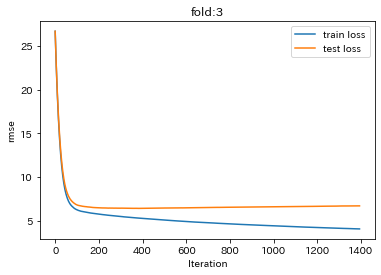

 - fold3_MAE : 6.419626


[I 2022-12-14 15:45:48,869] A new study created in memory with name: no-name-d9029cb6-5b2d-4415-9bd8-1603432390bf



★★★★★　　　　　Fold 4　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:51,755] Trial 0 finished with value: 6.601243750339297 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 6.601243750339297.


Early stopping, best iteration is:
[201]	Train's l1: 5.83653	Test's l1: 6.60124
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:54,414] Trial 1 finished with value: 6.59352529632909 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 6.59352529632909.


Early stopping, best iteration is:
[208]	Train's l1: 5.85012	Test's l1: 6.59353
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:45:58,127] Trial 2 finished with value: 6.5879831894755965 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 6.5879831894755965.


Early stopping, best iteration is:
[263]	Train's l1: 5.63144	Test's l1: 6.58798
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:01,297] Trial 3 finished with value: 6.613902020316604 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 6.5879831894755965.


Early stopping, best iteration is:
[196]	Train's l1: 5.83877	Test's l1: 6.6139
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:05,725] Trial 4 finished with value: 6.639352769108121 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 6.5879831894755965.


Early stopping, best iteration is:
[295]	Train's l1: 5.55225	Test's l1: 6.63935
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:08,870] Trial 5 finished with value: 6.616741108566059 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 6.5879831894755965.


Early stopping, best iteration is:
[136]	Train's l1: 6.03613	Test's l1: 6.61674
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:13,334] Trial 6 finished with value: 6.615512011906587 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 6.5879831894755965.


Early stopping, best iteration is:
[413]	Train's l1: 5.33431	Test's l1: 6.61551
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:22,706] Trial 7 finished with value: 6.615284411941254 and parameters: {'num_leaves': 51}. Best is trial 7 with value: 6.615284411941254.


Early stopping, best iteration is:
[338]	Train's l1: 5.33451	Test's l1: 6.61528
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:24,610] Trial 8 finished with value: 6.70013088365025 and parameters: {'num_leaves': 6}. Best is trial 7 with value: 6.615284411941254.


Early stopping, best iteration is:
[915]	Train's l1: 5.9052	Test's l1: 6.70013
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:29,602] Trial 9 finished with value: 6.609780122061535 and parameters: {'num_leaves': 167}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:34,693] Trial 10 finished with value: 6.609780122061535 and parameters: {'num_leaves': 55}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:39,901] Trial 11 finished with value: 6.609780122061535 and parameters: {'num_leaves': 221}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:45,142] Trial 12 finished with value: 6.609780122061535 and parameters: {'num_leaves': 152}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:50,207] Trial 13 finished with value: 6.609780122061535 and parameters: {'num_leaves': 108}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:55,438] Trial 14 finished with value: 6.609780122061535 and parameters: {'num_leaves': 241}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:46:58,514] Trial 15 finished with value: 6.629376387442113 and parameters: {'num_leaves': 21}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[367]	Train's l1: 5.59455	Test's l1: 6.62938
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:03,654] Trial 16 finished with value: 6.609780122061535 and parameters: {'num_leaves': 131}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:08,928] Trial 17 finished with value: 6.609780122061535 and parameters: {'num_leaves': 188}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:14,106] Trial 18 finished with value: 6.609780122061535 and parameters: {'num_leaves': 79}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:19,369] Trial 19 finished with value: 6.609780122061535 and parameters: {'num_leaves': 180}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:24,420] Trial 20 finished with value: 6.609780122061535 and parameters: {'num_leaves': 85}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:29,541] Trial 21 finished with value: 6.609780122061535 and parameters: {'num_leaves': 157}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:34,372] Trial 22 finished with value: 6.6148941525257285 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[318]	Train's l1: 5.41707	Test's l1: 6.61489
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:39,422] Trial 23 finished with value: 6.609780122061535 and parameters: {'num_leaves': 115}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:45,106] Trial 24 finished with value: 6.609780122061535 and parameters: {'num_leaves': 127}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:50,314] Trial 25 finished with value: 6.609780122061535 and parameters: {'num_leaves': 201}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:47:55,377] Trial 26 finished with value: 6.609780122061535 and parameters: {'num_leaves': 127}. Best is trial 9 with value: 6.609780122061535.


Early stopping, best iteration is:
[310]	Train's l1: 5.39214	Test's l1: 6.60978
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:00,039] Trial 27 finished with value: 6.821822403024463 and parameters: {'bagging_fraction': 0.6279798432774358, 'bagging_freq': 3}. Best is trial 27 with value: 6.821822403024463.


Early stopping, best iteration is:
[465]	Train's l1: 5.88279	Test's l1: 6.82182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:05,738] Trial 28 finished with value: 6.581681515440859 and parameters: {'bagging_fraction': 0.9175724211754418, 'bagging_freq': 5}. Best is trial 28 with value: 6.581681515440859.


Early stopping, best iteration is:
[155]	Train's l1: 6.03222	Test's l1: 6.58168
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:10,026] Trial 29 finished with value: 6.741061186975117 and parameters: {'bagging_fraction': 0.6718251662409568, 'bagging_freq': 1}. Best is trial 28 with value: 6.581681515440859.


Early stopping, best iteration is:
[292]	Train's l1: 6.01771	Test's l1: 6.74106
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:13,838] Trial 30 finished with value: 6.9791802743397096 and parameters: {'bagging_fraction': 0.5243193457379939, 'bagging_freq': 2}. Best is trial 28 with value: 6.581681515440859.


Early stopping, best iteration is:
[326]	Train's l1: 6.57477	Test's l1: 6.97918
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:19,887] Trial 31 finished with value: 6.732042444060159 and parameters: {'bagging_fraction': 0.686453155897349, 'bagging_freq': 7}. Best is trial 28 with value: 6.581681515440859.


Early stopping, best iteration is:
[329]	Train's l1: 5.96189	Test's l1: 6.73204
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:24,282] Trial 32 finished with value: 7.3605223365343 and parameters: {'bagging_fraction': 0.418611862482101, 'bagging_freq': 3}. Best is trial 28 with value: 6.581681515440859.


Early stopping, best iteration is:
[730]	Train's l1: 6.59329	Test's l1: 7.36052
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:28,404] Trial 33 finished with value: 7.394450821539113 and parameters: {'bagging_fraction': 0.40395985643607324, 'bagging_freq': 4}. Best is trial 28 with value: 6.581681515440859.


Early stopping, best iteration is:
[845]	Train's l1: 6.52536	Test's l1: 7.39445
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:33,165] Trial 34 finished with value: 6.597398956444896 and parameters: {'bagging_fraction': 0.8809552689517652, 'bagging_freq': 5}. Best is trial 28 with value: 6.581681515440859.


Early stopping, best iteration is:
[230]	Train's l1: 5.85404	Test's l1: 6.5974
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:37,767] Trial 35 finished with value: 6.599860621558629 and parameters: {'bagging_fraction': 0.8798933691697368, 'bagging_freq': 3}. Best is trial 28 with value: 6.581681515440859.


Early stopping, best iteration is:
[222]	Train's l1: 5.87003	Test's l1: 6.59986
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:42,223] Trial 36 finished with value: 6.617191273825336 and parameters: {'bagging_fraction': 0.7906569344859911, 'bagging_freq': 3}. Best is trial 28 with value: 6.581681515440859.


Early stopping, best iteration is:
[223]	Train's l1: 5.97579	Test's l1: 6.61719
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:46,495] Trial 37 finished with value: 6.562344014951895 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 6.562344014951895.


Early stopping, best iteration is:
[155]	Train's l1: 6.02097	Test's l1: 6.56234
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:50,823] Trial 38 finished with value: 6.5407145621093425 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 38 with value: 6.5407145621093425.


Early stopping, best iteration is:
[155]	Train's l1: 6.02108	Test's l1: 6.54071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:55,182] Trial 39 finished with value: 6.581681515440859 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 6.5407145621093425.


Early stopping, best iteration is:
[155]	Train's l1: 6.03222	Test's l1: 6.58168
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:48:59,375] Trial 40 finished with value: 6.562344014951895 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 6.5407145621093425.


Early stopping, best iteration is:
[155]	Train's l1: 6.02097	Test's l1: 6.56234
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:04,221] Trial 41 finished with value: 6.561153072760062 and parameters: {'feature_fraction': 0.88}. Best is trial 38 with value: 6.5407145621093425.


Early stopping, best iteration is:
[155]	Train's l1: 6.023	Test's l1: 6.56115
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:08,807] Trial 42 finished with value: 6.569531931224896 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 38 with value: 6.5407145621093425.


Early stopping, best iteration is:
[155]	Train's l1: 6.02765	Test's l1: 6.56953
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:12,950] Trial 43 finished with value: 6.540714585938199 and parameters: {'lambda_l1': 1.1554900483085382e-08, 'lambda_l2': 1.7944789085581557e-05}. Best is trial 43 with value: 6.540714585938199.


Early stopping, best iteration is:
[155]	Train's l1: 6.02108	Test's l1: 6.54071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:17,083] Trial 44 finished with value: 6.566972419228384 and parameters: {'lambda_l1': 4.887146573768983, 'lambda_l2': 5.155949327400812}. Best is trial 43 with value: 6.540714585938199.


Early stopping, best iteration is:
[155]	Train's l1: 6.08641	Test's l1: 6.56697
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:21,862] Trial 45 finished with value: 6.5468173321295335 and parameters: {'lambda_l1': 0.03520671839220468, 'lambda_l2': 1.4687458407531159e-08}. Best is trial 43 with value: 6.540714585938199.


Early stopping, best iteration is:
[280]	Train's l1: 5.66532	Test's l1: 6.54682
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:25,876] Trial 46 finished with value: 6.540714562448636 and parameters: {'lambda_l1': 4.553140528700772e-07, 'lambda_l2': 1.7751052381125046e-07}. Best is trial 46 with value: 6.540714562448636.


Early stopping, best iteration is:
[155]	Train's l1: 6.02108	Test's l1: 6.54071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:30,087] Trial 47 finished with value: 6.547695525735467 and parameters: {'lambda_l1': 1.0007435044350346, 'lambda_l2': 4.505796977628734e-05}. Best is trial 46 with value: 6.540714562448636.


Early stopping, best iteration is:
[155]	Train's l1: 6.02318	Test's l1: 6.5477
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:34,474] Trial 48 finished with value: 6.558926513012219 and parameters: {'lambda_l1': 0.014760105453042424, 'lambda_l2': 0.8291216563467587}. Best is trial 46 with value: 6.540714562448636.


Early stopping, best iteration is:
[187]	Train's l1: 5.9234	Test's l1: 6.55893
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:38,990] Trial 49 finished with value: 6.537374930070125 and parameters: {'lambda_l1': 3.0984413866684988, 'lambda_l2': 0.7497480509389373}. Best is trial 49 with value: 6.537374930070125.


Early stopping, best iteration is:
[267]	Train's l1: 5.7304	Test's l1: 6.53737
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:43,211] Trial 50 finished with value: 6.54071456217972 and parameters: {'lambda_l1': 5.774422931411775e-08, 'lambda_l2': 1.0586077271793741e-08}. Best is trial 49 with value: 6.537374930070125.


Early stopping, best iteration is:
[155]	Train's l1: 6.02108	Test's l1: 6.54071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:47,491] Trial 51 finished with value: 6.525738548366284 and parameters: {'lambda_l1': 0.0018749545394695431, 'lambda_l2': 1.4916054337864049}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[155]	Train's l1: 6.02713	Test's l1: 6.52574
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:51,699] Trial 52 finished with value: 6.561504253644339 and parameters: {'lambda_l1': 5.9600642154237543e-08, 'lambda_l2': 0.1553929877500897}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[170]	Train's l1: 5.9788	Test's l1: 6.5615
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:49:56,240] Trial 53 finished with value: 6.543485906336068 and parameters: {'lambda_l1': 2.5971199552132613e-05, 'lambda_l2': 0.005974852438794728}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[269]	Train's l1: 5.70037	Test's l1: 6.54349
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:00,481] Trial 54 finished with value: 6.54172036569825 and parameters: {'lambda_l1': 0.00022431835148305353, 'lambda_l2': 0.012190368370693733}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[155]	Train's l1: 6.02845	Test's l1: 6.54172
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:04,789] Trial 55 finished with value: 6.537521056103024 and parameters: {'lambda_l1': 0.029866083305574963, 'lambda_l2': 6.737965214490371}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[194]	Train's l1: 5.94623	Test's l1: 6.53752
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:09,288] Trial 56 finished with value: 6.563994767970753 and parameters: {'lambda_l1': 1.6034319877169572e-05, 'lambda_l2': 0.029823928293200123}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[273]	Train's l1: 5.68807	Test's l1: 6.56399
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:13,598] Trial 57 finished with value: 6.550388050510864 and parameters: {'lambda_l1': 0.37703301340632367, 'lambda_l2': 0.0008189091390535771}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[155]	Train's l1: 6.0178	Test's l1: 6.55039
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:17,816] Trial 58 finished with value: 6.56700110558937 and parameters: {'lambda_l1': 0.0014692309450194362, 'lambda_l2': 0.2981972825419582}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[155]	Train's l1: 6.02125	Test's l1: 6.567
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:21,900] Trial 59 finished with value: 6.540715528139202 and parameters: {'lambda_l1': 0.0015391624961163027, 'lambda_l2': 0.00040002256474763195}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[155]	Train's l1: 6.02108	Test's l1: 6.54072
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:26,432] Trial 60 finished with value: 6.563058531804749 and parameters: {'lambda_l1': 8.339907949463228, 'lambda_l2': 1.4560640771481064}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[280]	Train's l1: 5.68786	Test's l1: 6.56306
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:31,130] Trial 61 finished with value: 6.546900154702352 and parameters: {'lambda_l1': 0.2901376926412456, 'lambda_l2': 0.06612262403134588}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[281]	Train's l1: 5.66267	Test's l1: 6.5469
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:35,681] Trial 62 finished with value: 6.543486906192 and parameters: {'lambda_l1': 2.6842654668422332e-05, 'lambda_l2': 0.0035215359121927906}. Best is trial 51 with value: 6.525738548366284.


Early stopping, best iteration is:
[269]	Train's l1: 5.70036	Test's l1: 6.54349
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:39,711] Trial 63 finished with value: 6.525738548366284 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 6.525738548366284.


Early stopping, best iteration is:
[155]	Train's l1: 6.02713	Test's l1: 6.52574
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:44,067] Trial 64 finished with value: 6.525738548366284 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 6.525738548366284.


Early stopping, best iteration is:
[155]	Train's l1: 6.02713	Test's l1: 6.52574
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:48,193] Trial 65 finished with value: 6.525738548366284 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.525738548366284.


Early stopping, best iteration is:
[155]	Train's l1: 6.02713	Test's l1: 6.52574
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:52,238] Trial 66 finished with value: 6.525738548366284 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.525738548366284.


Early stopping, best iteration is:
[155]	Train's l1: 6.02713	Test's l1: 6.52574
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:50:56,375] Trial 67 finished with value: 6.525738548366284 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 6.525738548366284.


Early stopping, best iteration is:
[155]	Train's l1: 6.02713	Test's l1: 6.52574
▼▼▼▼▼　　　　　Fold 4　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.0018749545394695431, 'lambda_l2': 1.4916054337864049, 'num_leaves': 31, 'feature_fraction': 0.7200000000000001, 'bagging_fraction': 0.9175724211754418, 'bagging_freq': 5, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


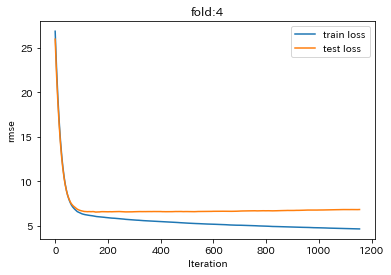

 - fold4_MAE : 6.525739


[I 2022-12-14 15:50:56,930] A new study created in memory with name: no-name-53333338-078f-48cd-beff-339e42210eb4



★★★★★　　　　　Fold 5　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:02,609] Trial 0 finished with value: 6.526596762409936 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 6.526596762409936.


Early stopping, best iteration is:
[657]	Train's l1: 5.0739	Test's l1: 6.5266
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:06,668] Trial 1 finished with value: 6.554071405598088 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 6.526596762409936.


Early stopping, best iteration is:
[546]	Train's l1: 5.26883	Test's l1: 6.55407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:09,835] Trial 2 finished with value: 6.5493363003043745 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 6.526596762409936.


Early stopping, best iteration is:
[414]	Train's l1: 5.50429	Test's l1: 6.54934
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:14,622] Trial 3 finished with value: 6.491123620931778 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 6.491123620931778.


Early stopping, best iteration is:
[464]	Train's l1: 5.35144	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:19,323] Trial 4 finished with value: 6.5627217205070885 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 6.491123620931778.


Early stopping, best iteration is:
[722]	Train's l1: 5.0638	Test's l1: 6.56272
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:23,945] Trial 5 finished with value: 6.542386641887601 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 6.491123620931778.


Early stopping, best iteration is:
[616]	Train's l1: 5.16306	Test's l1: 6.54239
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:29,587] Trial 6 finished with value: 6.514018335890859 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 6.491123620931778.


Early stopping, best iteration is:
[493]	Train's l1: 5.29179	Test's l1: 6.51402
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:35,623] Trial 7 finished with value: 6.518000238833667 and parameters: {'num_leaves': 207}. Best is trial 7 with value: 6.518000238833667.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:39,091] Trial 8 finished with value: 6.495859786579116 and parameters: {'num_leaves': 21}. Best is trial 8 with value: 6.495859786579116.


Early stopping, best iteration is:
[486]	Train's l1: 5.51742	Test's l1: 6.49586
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:45,254] Trial 9 finished with value: 6.518000238833667 and parameters: {'num_leaves': 142}. Best is trial 8 with value: 6.495859786579116.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:51,266] Trial 10 finished with value: 6.518000238833667 and parameters: {'num_leaves': 252}. Best is trial 8 with value: 6.495859786579116.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:51:57,301] Trial 11 finished with value: 6.518000238833667 and parameters: {'num_leaves': 99}. Best is trial 8 with value: 6.495859786579116.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:03,280] Trial 12 finished with value: 6.518000238833667 and parameters: {'num_leaves': 85}. Best is trial 8 with value: 6.495859786579116.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:09,257] Trial 13 finished with value: 6.518000238833667 and parameters: {'num_leaves': 129}. Best is trial 8 with value: 6.495859786579116.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:12,860] Trial 14 finished with value: 6.495542183130297 and parameters: {'num_leaves': 22}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[485]	Train's l1: 5.48446	Test's l1: 6.49554
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:23,120] Trial 15 finished with value: 6.518000238833667 and parameters: {'num_leaves': 145}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:29,197] Trial 16 finished with value: 6.518000238833667 and parameters: {'num_leaves': 212}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:31,626] Trial 17 finished with value: 6.498766777017262 and parameters: {'num_leaves': 4}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[1944]	Train's l1: 6.01663	Test's l1: 6.49877
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:34,249] Trial 18 finished with value: 6.523877433397835 and parameters: {'num_leaves': 8}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[1192]	Train's l1: 5.65821	Test's l1: 6.52388
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:39,124] Trial 19 finished with value: 6.564375067147752 and parameters: {'num_leaves': 45}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[248]	Train's l1: 5.66672	Test's l1: 6.56438
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:45,049] Trial 20 finished with value: 6.518000238833667 and parameters: {'num_leaves': 54}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:50,689] Trial 21 finished with value: 6.541340972587626 and parameters: {'num_leaves': 46}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[419]	Train's l1: 5.26431	Test's l1: 6.54134
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:52:56,558] Trial 22 finished with value: 6.518000238833667 and parameters: {'num_leaves': 77}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:53:01,302] Trial 23 finished with value: 6.5028923494660456 and parameters: {'num_leaves': 27}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[609]	Train's l1: 5.2191	Test's l1: 6.50289
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:53:07,119] Trial 24 finished with value: 6.518000238833667 and parameters: {'num_leaves': 112}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:53:13,177] Trial 25 finished with value: 6.518000238833667 and parameters: {'num_leaves': 175}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:53:19,233] Trial 26 finished with value: 6.518000238833667 and parameters: {'num_leaves': 68}. Best is trial 14 with value: 6.495542183130297.


Early stopping, best iteration is:
[435]	Train's l1: 5.2142	Test's l1: 6.518
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1025]	Train's l1: 5.90643	Test's l1: 7.4365


[I 2022-12-14 15:53:25,061] Trial 27 finished with value: 7.436502089776935 and parameters: {'bagging_fraction': 0.5245500629472789, 'bagging_freq': 5}. Best is trial 27 with value: 7.436502089776935.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:53:29,443] Trial 28 finished with value: 6.852147166669132 and parameters: {'bagging_fraction': 0.8000946913490395, 'bagging_freq': 5}. Best is trial 28 with value: 6.852147166669132.


Early stopping, best iteration is:
[219]	Train's l1: 6.02067	Test's l1: 6.85215
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1285]	Train's l1: 5.98362	Test's l1: 7.74806


[I 2022-12-14 15:53:35,595] Trial 29 finished with value: 7.748055352937097 and parameters: {'bagging_fraction': 0.4613138260463341, 'bagging_freq': 1}. Best is trial 28 with value: 6.852147166669132.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:53:41,766] Trial 30 finished with value: 6.587918428200493 and parameters: {'bagging_fraction': 0.9546870349365378, 'bagging_freq': 5}. Best is trial 30 with value: 6.587918428200493.


Early stopping, best iteration is:
[536]	Train's l1: 5.27768	Test's l1: 6.58792
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:53:46,446] Trial 31 finished with value: 6.996794598142617 and parameters: {'bagging_fraction': 0.7017087635374002, 'bagging_freq': 4}. Best is trial 30 with value: 6.587918428200493.


Early stopping, best iteration is:
[312]	Train's l1: 6.00917	Test's l1: 6.99679
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1761]	Train's l1: 6.02761	Test's l1: 7.89425


[I 2022-12-14 15:53:52,945] Trial 32 finished with value: 7.894246792746368 and parameters: {'bagging_fraction': 0.40183726685695487, 'bagging_freq': 3}. Best is trial 30 with value: 6.587918428200493.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:53:57,602] Trial 33 finished with value: 6.894826782841071 and parameters: {'bagging_fraction': 0.750618976244473, 'bagging_freq': 7}. Best is trial 30 with value: 6.587918428200493.


Early stopping, best iteration is:
[281]	Train's l1: 5.91419	Test's l1: 6.89483
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2295]	Train's l1: 5.4547	Test's l1: 7.71101


[I 2022-12-14 15:54:06,505] Trial 34 finished with value: 7.711010895552657 and parameters: {'bagging_fraction': 0.4741041145214452, 'bagging_freq': 4}. Best is trial 30 with value: 6.587918428200493.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:54:11,278] Trial 35 finished with value: 7.0404967598077794 and parameters: {'bagging_fraction': 0.6717168676918683, 'bagging_freq': 3}. Best is trial 30 with value: 6.587918428200493.


Early stopping, best iteration is:
[393]	Train's l1: 5.9389	Test's l1: 7.0405
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:54:17,832] Trial 36 finished with value: 6.60664213147823 and parameters: {'bagging_fraction': 0.9168741915558964, 'bagging_freq': 3}. Best is trial 30 with value: 6.587918428200493.


Early stopping, best iteration is:
[736]	Train's l1: 5.0937	Test's l1: 6.60664
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:54:22,678] Trial 37 finished with value: 6.491123620931778 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 6.491123620931778.


Early stopping, best iteration is:
[464]	Train's l1: 5.35144	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:54:28,198] Trial 38 finished with value: 6.526596762409936 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 6.491123620931778.


Early stopping, best iteration is:
[657]	Train's l1: 5.0739	Test's l1: 6.5266
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:54:33,419] Trial 39 finished with value: 6.51142135627433 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 6.491123620931778.


Early stopping, best iteration is:
[545]	Train's l1: 5.21812	Test's l1: 6.51142
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:54:37,943] Trial 40 finished with value: 6.517751685275933 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 6.491123620931778.


Early stopping, best iteration is:
[471]	Train's l1: 5.32884	Test's l1: 6.51775
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:54:42,380] Trial 41 finished with value: 6.536936388154117 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 6.491123620931778.


Early stopping, best iteration is:
[447]	Train's l1: 5.38238	Test's l1: 6.53694
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:54:46,940] Trial 42 finished with value: 6.517751685275933 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 6.491123620931778.


Early stopping, best iteration is:
[471]	Train's l1: 5.32884	Test's l1: 6.51775
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:54:51,843] Trial 43 finished with value: 6.491123620171065 and parameters: {'lambda_l1': 3.52376329329535e-06, 'lambda_l2': 5.48478553028362e-08}. Best is trial 43 with value: 6.491123620171065.


Early stopping, best iteration is:
[464]	Train's l1: 5.35144	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:54:56,537] Trial 44 finished with value: 6.491123602445685 and parameters: {'lambda_l1': 6.013658962737483e-05, 'lambda_l2': 2.1059822558037285e-07}. Best is trial 44 with value: 6.491123602445685.


Early stopping, best iteration is:
[464]	Train's l1: 5.35144	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:01,312] Trial 45 finished with value: 6.491122434444272 and parameters: {'lambda_l1': 0.0033686702998292775, 'lambda_l2': 0.00014150155127969942}. Best is trial 45 with value: 6.491122434444272.


Early stopping, best iteration is:
[464]	Train's l1: 5.35145	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:06,118] Trial 46 finished with value: 6.491123492982213 and parameters: {'lambda_l1': 0.00042269365219401, 'lambda_l2': 1.3274991651313867e-08}. Best is trial 45 with value: 6.491122434444272.


Early stopping, best iteration is:
[464]	Train's l1: 5.35144	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:10,750] Trial 47 finished with value: 6.491122550816081 and parameters: {'lambda_l1': 2.0025967793205568e-08, 'lambda_l2': 0.0010041118056432073}. Best is trial 45 with value: 6.491122434444272.


Early stopping, best iteration is:
[464]	Train's l1: 5.35145	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:15,481] Trial 48 finished with value: 6.491123616177391 and parameters: {'lambda_l1': 1.3547588188200641e-07, 'lambda_l2': 5.2665701083876185e-06}. Best is trial 45 with value: 6.491122434444272.


Early stopping, best iteration is:
[464]	Train's l1: 5.35144	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:20,303] Trial 49 finished with value: 6.491123619077417 and parameters: {'lambda_l1': 5.260733462573649e-06, 'lambda_l2': 4.6456583286777165e-07}. Best is trial 45 with value: 6.491122434444272.


Early stopping, best iteration is:
[464]	Train's l1: 5.35144	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:25,002] Trial 50 finished with value: 6.4911236205122 and parameters: {'lambda_l1': 9.159999105667021e-07, 'lambda_l2': 4.614367004557605e-07}. Best is trial 45 with value: 6.491122434444272.


Early stopping, best iteration is:
[464]	Train's l1: 5.35144	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:29,586] Trial 51 finished with value: 6.52787084385788 and parameters: {'lambda_l1': 0.04994722131681805, 'lambda_l2': 0.05074149956438093}. Best is trial 45 with value: 6.491122434444272.


Early stopping, best iteration is:
[459]	Train's l1: 5.36013	Test's l1: 6.52787
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:34,980] Trial 52 finished with value: 6.528235798116611 and parameters: {'lambda_l1': 2.316000197747189e-08, 'lambda_l2': 0.421843289081698}. Best is trial 45 with value: 6.491122434444272.


Early stopping, best iteration is:
[643]	Train's l1: 5.10125	Test's l1: 6.52824
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:39,597] Trial 53 finished with value: 6.507906446846808 and parameters: {'lambda_l1': 2.0624766314436025, 'lambda_l2': 0.0002449667628725549}. Best is trial 45 with value: 6.491122434444272.


Early stopping, best iteration is:
[471]	Train's l1: 5.3205	Test's l1: 6.50791
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:44,198] Trial 54 finished with value: 6.491118676231355 and parameters: {'lambda_l1': 0.00830795016046473, 'lambda_l2': 0.0022354137775439935}. Best is trial 54 with value: 6.491118676231355.


Early stopping, best iteration is:
[464]	Train's l1: 5.35147	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:49,030] Trial 55 finished with value: 6.491120413400193 and parameters: {'lambda_l1': 0.007581410466507603, 'lambda_l2': 0.0008200392416771654}. Best is trial 54 with value: 6.491118676231355.


Early stopping, best iteration is:
[464]	Train's l1: 5.35146	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:54,141] Trial 56 finished with value: 6.518977230933762 and parameters: {'lambda_l1': 0.04374681011379587, 'lambda_l2': 0.014198210815036758}. Best is trial 54 with value: 6.491118676231355.


Early stopping, best iteration is:
[550]	Train's l1: 5.21427	Test's l1: 6.51898
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:55:58,896] Trial 57 finished with value: 6.5083943214837285 and parameters: {'lambda_l1': 2.137707499937948, 'lambda_l2': 5.374746095860983}. Best is trial 54 with value: 6.491118676231355.


Early stopping, best iteration is:
[501]	Train's l1: 5.32415	Test's l1: 6.50839
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:56:04,007] Trial 58 finished with value: 6.515455787995645 and parameters: {'lambda_l1': 0.03215714044692055, 'lambda_l2': 2.6112313335746387e-05}. Best is trial 54 with value: 6.491118676231355.


Early stopping, best iteration is:
[555]	Train's l1: 5.21136	Test's l1: 6.51546
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:56:08,683] Trial 59 finished with value: 6.491118633622316 and parameters: {'lambda_l1': 0.0016342169378383811, 'lambda_l2': 0.00419739463402777}. Best is trial 59 with value: 6.491118633622316.


Early stopping, best iteration is:
[464]	Train's l1: 5.35146	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:56:13,441] Trial 60 finished with value: 6.500744161530248 and parameters: {'lambda_l1': 0.00021331789825599498, 'lambda_l2': 0.010540448329657703}. Best is trial 59 with value: 6.491118633622316.


Early stopping, best iteration is:
[486]	Train's l1: 5.29699	Test's l1: 6.50074
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:56:18,127] Trial 61 finished with value: 6.51450820196974 and parameters: {'lambda_l1': 0.3066488205180518, 'lambda_l2': 0.1943624960214221}. Best is trial 59 with value: 6.491118633622316.


Early stopping, best iteration is:
[454]	Train's l1: 5.35378	Test's l1: 6.51451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:56:22,807] Trial 62 finished with value: 6.49111768597781 and parameters: {'lambda_l1': 0.0017407874458600775, 'lambda_l2': 0.005053332923709571}. Best is trial 62 with value: 6.49111768597781.


Early stopping, best iteration is:
[464]	Train's l1: 5.35147	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:56:27,518] Trial 63 finished with value: 6.49111768597781 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 6.49111768597781.


Early stopping, best iteration is:
[464]	Train's l1: 5.35147	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:56:32,323] Trial 64 finished with value: 6.49111768597781 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.49111768597781.


Early stopping, best iteration is:
[464]	Train's l1: 5.35147	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:56:37,181] Trial 65 finished with value: 6.49111768597781 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.49111768597781.


Early stopping, best iteration is:
[464]	Train's l1: 5.35147	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:56:41,832] Trial 66 finished with value: 6.49111768597781 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 6.49111768597781.


Early stopping, best iteration is:
[464]	Train's l1: 5.35147	Test's l1: 6.49112
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-14 15:56:46,718] Trial 67 finished with value: 6.49111768597781 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 6.49111768597781.


Early stopping, best iteration is:
[464]	Train's l1: 5.35147	Test's l1: 6.49112
▼▼▼▼▼　　　　　Fold 5　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.0017407874458600775, 'lambda_l2': 0.005053332923709571, 'num_leaves': 31, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


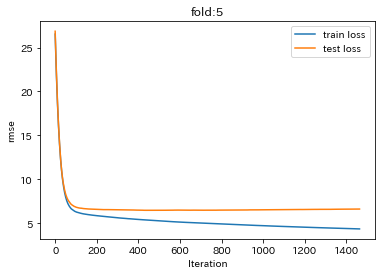

 - fold5_MAE : 6.491118
 - CV_MAE : 6.439409


In [ ]:
"""
kf_cv = list(kf.split(df_main_printer))
oof_valid_lgb_main_printer, lgb_models_main_printer = fit_lgb_oputuna(x=df_main_printer, y=target, cv=kf_cv,
                                      model_params=optuna_model_params, fit_params=oputuna_fit_params
                                     )
"""

In [ ]:
!pwd

/content/drive/MyDrive/マナビDX_Quest/PBL05/data/models2


In [ ]:
#oof_valid_lgb_main_printer, lgb_models_main_printer
file_path = f'oof_valid_lgb_main_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_main_printer, f)

file_path = f'lgb_models_main_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_main_printer, f)

## 付帯作業時間 ー 印刷機　の学習

In [ ]:
df_sub_printer = df_train_printer_sub[df_train_printer_sub_corr_top20]
sub_target = df_train_printer[config.sub_target]
kf_cv = list(kf.split(df_sub_printer))

[I 2022-12-17 16:18:15,741] A new study created in memory with name: no-name-278be286-3082-4cc4-83bd-1712eaac3081


data_labels: ['作業日', '受注番号', '号機名', '号機コード', '数量1', '数量項目名1', '数量2', '数量項目名2', '数量3', '数量項目名3', '数量4', '合計数量', '予備数量', '仕上数量', '連量', '加工数量', '台数', '通し実数', '刷了数', '印刷予備数', '加工予備数', '製品仕様コード_x', 'カテゴリ名1', 'カテゴリ名2', '工程コード', '工程名', '表色数', '裏色数', '刷本寸法長さ', '刷本寸法幅', '部品区分', '部品区分名', '部品行番号', '部品仕様番号', '部品仕様コード', '表示順', '印刷前工程フラグ', '加工行番号', '加工順', '加工単位区分', '加工単位区分名', 'サイズ区分', 'サイズ区分名', 'サイズ幅', 'サイズ長さ', '仕分区分', '仕分区分名', '間紙区分', '間紙区分名', '紙帯区分', '紙帯区分名', '予定組ラベルキー', '受注日', '製品仕様コード_y', '受注数量', '下版予定日', '流用受注番号', '流用受注日', '頁数', 'キャンペーン番号', '受注キャンペーン番号', 'キャンペーンフラグ', '付合フラグ', '受注区分', '受注区分名', '納期', '事業所親コード', '事業所子コード', '事業所コード', '部門コード', '営業担当者コード', '得意先親コード', '得意先子コード', '得意先コード', '仕上寸法区分', '仕上寸法区分名', '仕上寸法幅', '仕上寸法長さ', '仕上寸法厚さ', '展開寸法区分', '展開寸法区分名', '展開寸法幅', '展開寸法長さ', '展開寸法厚さ', '製品区分', '製品区分名', 'リピート区分', 'リピート区分名', '仕様登録者コード', '単位区分_y', '単位区分名_y', '客先サンプル数量', '営業サンプル数量', '版区分', '版区分名', '上長確認フラグ', '受注キャンセルフラグ', '完納フラグ', '受注伝票発行済フラグ', '受注伝票発行年月日', '受注伝票発行回数', '制作伝票発行済フラグ', '制作伝票発行年月日', '制作伝票発行回

[I 2022-12-17 16:18:20,346] Trial 0 finished with value: 14.73823840622107 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 14.73823840622107.


Early stopping, best iteration is:
[626]	Train's l1: 10.8886	Test's l1: 14.7382
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:18:25,013] Trial 1 finished with value: 14.73421569326005 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 14.73421569326005.


Early stopping, best iteration is:
[466]	Train's l1: 11.4797	Test's l1: 14.7342
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:18:30,787] Trial 2 finished with value: 14.754057875420559 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 14.73421569326005.


Early stopping, best iteration is:
[512]	Train's l1: 11.1447	Test's l1: 14.7541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:18:36,538] Trial 3 finished with value: 14.753612027274086 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 14.73421569326005.


Early stopping, best iteration is:
[420]	Train's l1: 11.53	Test's l1: 14.7536
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:18:43,073] Trial 4 finished with value: 14.74073814594596 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 14.73421569326005.


Early stopping, best iteration is:
[509]	Train's l1: 11.0437	Test's l1: 14.7407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:18:48,874] Trial 5 finished with value: 14.6749007004753 and parameters: {'feature_fraction': 0.6}. Best is trial 5 with value: 14.6749007004753.


Early stopping, best iteration is:
[614]	Train's l1: 10.7275	Test's l1: 14.6749
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:18:55,868] Trial 6 finished with value: 14.827067200537536 and parameters: {'feature_fraction': 1.0}. Best is trial 5 with value: 14.6749007004753.


Early stopping, best iteration is:
[449]	Train's l1: 11.3629	Test's l1: 14.8271
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:19:02,706] Trial 7 finished with value: 14.697548702245673 and parameters: {'num_leaves': 256}. Best is trial 7 with value: 14.697548702245673.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:19:09,048] Trial 8 finished with value: 14.726806714737071 and parameters: {'num_leaves': 47}. Best is trial 7 with value: 14.697548702245673.


Early stopping, best iteration is:
[473]	Train's l1: 10.5981	Test's l1: 14.7268
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:19:15,723] Trial 9 finished with value: 14.697548702245673 and parameters: {'num_leaves': 127}. Best is trial 7 with value: 14.697548702245673.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:19:27,367] Trial 10 finished with value: 14.697548702245673 and parameters: {'num_leaves': 237}. Best is trial 7 with value: 14.697548702245673.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:19:34,118] Trial 11 finished with value: 14.697548702245673 and parameters: {'num_leaves': 142}. Best is trial 7 with value: 14.697548702245673.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:19:37,406] Trial 12 finished with value: 14.748419663259304 and parameters: {'num_leaves': 12}. Best is trial 7 with value: 14.697548702245673.


Early stopping, best iteration is:
[830]	Train's l1: 12.3901	Test's l1: 14.7484
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:19:44,127] Trial 13 finished with value: 14.697548702245673 and parameters: {'num_leaves': 175}. Best is trial 7 with value: 14.697548702245673.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:19:50,915] Trial 14 finished with value: 14.697548702245673 and parameters: {'num_leaves': 209}. Best is trial 7 with value: 14.697548702245673.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:19:55,730] Trial 15 finished with value: 14.747478240190896 and parameters: {'num_leaves': 27}. Best is trial 7 with value: 14.697548702245673.


Early stopping, best iteration is:
[528]	Train's l1: 11.4276	Test's l1: 14.7475
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:20:01,594] Trial 16 finished with value: 14.696481257374657 and parameters: {'num_leaves': 37}. Best is trial 16 with value: 14.696481257374657.


Early stopping, best iteration is:
[488]	Train's l1: 10.8866	Test's l1: 14.6965
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:20:08,321] Trial 17 finished with value: 14.697548702245673 and parameters: {'num_leaves': 78}. Best is trial 16 with value: 14.696481257374657.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975


[I 2022-12-17 16:20:15,174] Trial 18 finished with value: 14.697548702245673 and parameters: {'num_leaves': 98}. Best is trial 16 with value: 14.696481257374657.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:20:31,195] Trial 19 finished with value: 14.697548702245673 and parameters: {'num_leaves': 249}. Best is trial 16 with value: 14.696481257374657.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:20:38,012] Trial 20 finished with value: 14.697548702245673 and parameters: {'num_leaves': 185}. Best is trial 16 with value: 14.696481257374657.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:20:44,818] Trial 21 finished with value: 14.697548702245673 and parameters: {'num_leaves': 70}. Best is trial 16 with value: 14.696481257374657.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:20:51,545] Trial 22 finished with value: 14.697548702245673 and parameters: {'num_leaves': 129}. Best is trial 16 with value: 14.696481257374657.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:20:58,313] Trial 23 finished with value: 14.697548702245673 and parameters: {'num_leaves': 169}. Best is trial 16 with value: 14.696481257374657.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:21:05,077] Trial 24 finished with value: 14.697548702245673 and parameters: {'num_leaves': 222}. Best is trial 16 with value: 14.696481257374657.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:21:11,801] Trial 25 finished with value: 14.697548702245673 and parameters: {'num_leaves': 98}. Best is trial 16 with value: 14.696481257374657.


Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[545]	Train's l1: 10.2187	Test's l1: 14.6975


[I 2022-12-17 16:21:18,490] Trial 26 finished with value: 14.697548702245673 and parameters: {'num_leaves': 151}. Best is trial 16 with value: 14.696481257374657.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[939]	Train's l1: 11.035	Test's l1: 15.0495


[I 2022-12-17 16:21:24,541] Trial 27 finished with value: 15.049527934437725 and parameters: {'bagging_fraction': 0.572496961611633, 'bagging_freq': 2}. Best is trial 27 with value: 15.049527934437725.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:21:30,324] Trial 28 finished with value: 14.742890587266672 and parameters: {'bagging_fraction': 0.9989716116017318, 'bagging_freq': 7}. Best is trial 28 with value: 14.742890587266672.


Early stopping, best iteration is:
[415]	Train's l1: 11.6471	Test's l1: 14.7429
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:21:36,356] Trial 29 finished with value: 14.689342283622985 and parameters: {'bagging_fraction': 0.9643473510968308, 'bagging_freq': 6}. Best is trial 29 with value: 14.689342283622985.


Early stopping, best iteration is:
[492]	Train's l1: 11.2919	Test's l1: 14.6893
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:21:40,899] Trial 30 finished with value: 15.118488896164912 and parameters: {'bagging_fraction': 0.6021738904360012, 'bagging_freq': 7}. Best is trial 29 with value: 14.689342283622985.


Early stopping, best iteration is:
[426]	Train's l1: 12.6638	Test's l1: 15.1185
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:21:47,680] Trial 31 finished with value: 14.750562890276884 and parameters: {'bagging_fraction': 0.9768493999087446, 'bagging_freq': 7}. Best is trial 29 with value: 14.689342283622985.


Early stopping, best iteration is:
[644]	Train's l1: 10.5842	Test's l1: 14.7506
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1183]	Train's l1: 11.0413	Test's l1: 15.1966


[I 2022-12-17 16:21:53,675] Trial 32 finished with value: 15.196576149330074 and parameters: {'bagging_fraction': 0.5064474463654915, 'bagging_freq': 7}. Best is trial 29 with value: 14.689342283622985.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:22:00,466] Trial 33 finished with value: 14.842072020337207 and parameters: {'bagging_fraction': 0.8181070293346562, 'bagging_freq': 6}. Best is trial 29 with value: 14.689342283622985.


Early stopping, best iteration is:
[769]	Train's l1: 10.392	Test's l1: 14.8421
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[921]	Train's l1: 10.4719	Test's l1: 14.8978


[I 2022-12-17 16:22:08,056] Trial 34 finished with value: 14.897756355139688 and parameters: {'bagging_fraction': 0.6603031068420375, 'bagging_freq': 2}. Best is trial 29 with value: 14.689342283622985.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:22:14,194] Trial 35 finished with value: 14.847552085778778 and parameters: {'bagging_fraction': 0.8459719748483523, 'bagging_freq': 3}. Best is trial 29 with value: 14.689342283622985.


Early stopping, best iteration is:
[540]	Train's l1: 11.2549	Test's l1: 14.8476
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:22:18,959] Trial 36 finished with value: 15.125830739823307 and parameters: {'bagging_fraction': 0.4961154028370751, 'bagging_freq': 6}. Best is trial 29 with value: 14.689342283622985.


Early stopping, best iteration is:
[763]	Train's l1: 12.0818	Test's l1: 15.1258
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:22:24,281] Trial 37 finished with value: 14.703735503232544 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 14.703735503232544.


Early stopping, best iteration is:
[464]	Train's l1: 11.3611	Test's l1: 14.7037
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:22:29,962] Trial 38 finished with value: 14.6749007004753 and parameters: {'feature_fraction': 0.616}. Best is trial 38 with value: 14.6749007004753.


Early stopping, best iteration is:
[614]	Train's l1: 10.7275	Test's l1: 14.6749
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:22:35,375] Trial 39 finished with value: 14.701177136349617 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 38 with value: 14.6749007004753.


Early stopping, best iteration is:
[464]	Train's l1: 11.3409	Test's l1: 14.7012
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:22:39,978] Trial 40 finished with value: 14.73421569326005 and parameters: {'feature_fraction': 0.52}. Best is trial 38 with value: 14.6749007004753.


Early stopping, best iteration is:
[466]	Train's l1: 11.4797	Test's l1: 14.7342
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:22:44,902] Trial 41 finished with value: 14.699397774673324 and parameters: {'feature_fraction': 0.552}. Best is trial 38 with value: 14.6749007004753.


Early stopping, best iteration is:
[494]	Train's l1: 11.3283	Test's l1: 14.6994
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:22:50,146] Trial 42 finished with value: 14.69303712846915 and parameters: {'feature_fraction': 0.584}. Best is trial 38 with value: 14.6749007004753.


Early stopping, best iteration is:
[547]	Train's l1: 11.038	Test's l1: 14.693
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:22:55,625] Trial 43 finished with value: 14.687000924411937 and parameters: {'lambda_l1': 1.968948129545157e-06, 'lambda_l2': 1.2922633552432652}. Best is trial 43 with value: 14.687000924411937.


Early stopping, best iteration is:
[514]	Train's l1: 11.1666	Test's l1: 14.687
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:01,218] Trial 44 finished with value: 14.674899950602594 and parameters: {'lambda_l1': 0.0010291054161329404, 'lambda_l2': 2.0643819902332987e-07}. Best is trial 44 with value: 14.674899950602594.


Early stopping, best iteration is:
[614]	Train's l1: 10.7275	Test's l1: 14.6749
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:06,264] Trial 45 finished with value: 14.710768368672612 and parameters: {'lambda_l1': 1.2840313663099745, 'lambda_l2': 0.0001271072908814315}. Best is trial 44 with value: 14.674899950602594.


Early stopping, best iteration is:
[449]	Train's l1: 11.4454	Test's l1: 14.7108
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:11,442] Trial 46 finished with value: 14.649351483374879 and parameters: {'lambda_l1': 1.4563317295895364e-06, 'lambda_l2': 0.143350531847049}. Best is trial 46 with value: 14.649351483374879.


Early stopping, best iteration is:
[504]	Train's l1: 11.2057	Test's l1: 14.6494
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:16,825] Trial 47 finished with value: 14.64000692324385 and parameters: {'lambda_l1': 0.0003348687477776146, 'lambda_l2': 0.0774444840694575}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[547]	Train's l1: 10.9914	Test's l1: 14.64
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:22,402] Trial 48 finished with value: 14.674897981062623 and parameters: {'lambda_l1': 0.002958105053884937, 'lambda_l2': 0.00016942285690097015}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[614]	Train's l1: 10.7275	Test's l1: 14.6749
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:30,581] Trial 49 finished with value: 14.71920449078575 and parameters: {'lambda_l1': 8.400449262168546, 'lambda_l2': 2.589287426162628e-05}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[476]	Train's l1: 11.3422	Test's l1: 14.7192
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:35,708] Trial 50 finished with value: 14.730554720660448 and parameters: {'lambda_l1': 0.036032895966586875, 'lambda_l2': 0.00025288634558339113}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[491]	Train's l1: 11.265	Test's l1: 14.7306
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:40,950] Trial 51 finished with value: 14.7440829651802 and parameters: {'lambda_l1': 1.6611626390342282e-07, 'lambda_l2': 0.0901684981207767}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[514]	Train's l1: 11.1485	Test's l1: 14.7441
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:46,162] Trial 52 finished with value: 14.67943649408269 and parameters: {'lambda_l1': 0.06726748644785951, 'lambda_l2': 5.177973830950165e-07}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[493]	Train's l1: 11.2608	Test's l1: 14.6794
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:51,438] Trial 53 finished with value: 14.692591531035347 and parameters: {'lambda_l1': 3.156586092499715e-05, 'lambda_l2': 0.01576917756562871}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[537]	Train's l1: 11.0319	Test's l1: 14.6926
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:23:57,728] Trial 54 finished with value: 14.698677763233235 and parameters: {'lambda_l1': 1.3031599245808232e-08, 'lambda_l2': 7.360857724897573}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[526]	Train's l1: 11.1893	Test's l1: 14.6987
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:02,827] Trial 55 finished with value: 14.668062803603195 and parameters: {'lambda_l1': 1.8693522663980264e-05, 'lambda_l2': 0.036767950265008786}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[491]	Train's l1: 11.273	Test's l1: 14.6681
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:08,396] Trial 56 finished with value: 14.704557820815984 and parameters: {'lambda_l1': 2.518909427855471e-05, 'lambda_l2': 0.006280628138879161}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[529]	Train's l1: 11.093	Test's l1: 14.7046
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:13,614] Trial 57 finished with value: 14.75995538930803 and parameters: {'lambda_l1': 6.489574606915091e-07, 'lambda_l2': 0.7822443607626999}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[504]	Train's l1: 11.2043	Test's l1: 14.76
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:18,791] Trial 58 finished with value: 14.699046599909904 and parameters: {'lambda_l1': 0.00021329678465761595, 'lambda_l2': 0.004106374460534341}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[478]	Train's l1: 11.3381	Test's l1: 14.699
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:24,156] Trial 59 finished with value: 14.678569816327276 and parameters: {'lambda_l1': 1.0481951415960306e-08, 'lambda_l2': 0.26161323507622725}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[549]	Train's l1: 10.9908	Test's l1: 14.6786
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:29,818] Trial 60 finished with value: 14.674900665175867 and parameters: {'lambda_l1': 2.9809549695408538e-06, 'lambda_l2': 9.893244143983562e-06}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[614]	Train's l1: 10.7275	Test's l1: 14.6749
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:34,973] Trial 61 finished with value: 14.685999731358486 and parameters: {'lambda_l1': 0.015074302053810362, 'lambda_l2': 0.001683477978156042}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[487]	Train's l1: 11.3072	Test's l1: 14.686
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:40,152] Trial 62 finished with value: 14.668735060713352 and parameters: {'lambda_l1': 0.0003689469972377852, 'lambda_l2': 5.244310906292784}. Best is trial 47 with value: 14.64000692324385.


Early stopping, best iteration is:
[486]	Train's l1: 11.347	Test's l1: 14.6687
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:45,517] Trial 63 finished with value: 14.64000692324385 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 14.64000692324385.


Early stopping, best iteration is:
[547]	Train's l1: 10.9914	Test's l1: 14.64
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:50,914] Trial 64 finished with value: 14.64000692324385 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 14.64000692324385.


Early stopping, best iteration is:
[547]	Train's l1: 10.9914	Test's l1: 14.64
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:24:56,149] Trial 65 finished with value: 14.64000692324385 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 14.64000692324385.


Early stopping, best iteration is:
[547]	Train's l1: 10.9914	Test's l1: 14.64
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:01,471] Trial 66 finished with value: 14.64000692324385 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 14.64000692324385.


Early stopping, best iteration is:
[547]	Train's l1: 10.9914	Test's l1: 14.64
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:06,784] Trial 67 finished with value: 14.64000692324385 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 14.64000692324385.


Early stopping, best iteration is:
[547]	Train's l1: 10.9914	Test's l1: 14.64
▼▼▼▼▼　　　　　Fold 1　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.0003348687477776146, 'lambda_l2': 0.0774444840694575, 'num_leaves': 31, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


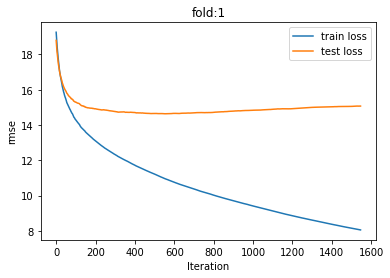

 - fold1_MAE : 14.640007


[I 2022-12-17 16:25:07,453] A new study created in memory with name: no-name-42ff8c02-de99-4bcc-88e3-09f4f2d2b766



★★★★★　　　　　Fold 2　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:12,808] Trial 0 finished with value: 15.238553139270392 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 15.238553139270392.


Early stopping, best iteration is:
[439]	Train's l1: 11.2886	Test's l1: 15.2386
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:17,459] Trial 1 finished with value: 15.235294170124007 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 15.235294170124007.


Early stopping, best iteration is:
[388]	Train's l1: 11.6323	Test's l1: 15.2353
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:21,682] Trial 2 finished with value: 15.28535969291858 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 15.235294170124007.


Early stopping, best iteration is:
[481]	Train's l1: 11.3586	Test's l1: 15.2854
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:26,262] Trial 3 finished with value: 15.309007914201626 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 15.235294170124007.


Early stopping, best iteration is:
[484]	Train's l1: 11.2037	Test's l1: 15.309
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:32,495] Trial 4 finished with value: 15.25285892506189 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 15.235294170124007.


Early stopping, best iteration is:
[481]	Train's l1: 11.0308	Test's l1: 15.2529
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:38,253] Trial 5 finished with value: 15.165833397652383 and parameters: {'feature_fraction': 0.8}. Best is trial 5 with value: 15.165833397652383.


Early stopping, best iteration is:
[421]	Train's l1: 11.362	Test's l1: 15.1658
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:44,597] Trial 6 finished with value: 15.267359692461216 and parameters: {'feature_fraction': 1.0}. Best is trial 5 with value: 15.165833397652383.


Early stopping, best iteration is:
[400]	Train's l1: 11.4622	Test's l1: 15.2674
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:51,839] Trial 7 finished with value: 15.218226741551172 and parameters: {'num_leaves': 79}. Best is trial 7 with value: 15.218226741551172.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:25:59,027] Trial 8 finished with value: 15.218226741551172 and parameters: {'num_leaves': 112}. Best is trial 7 with value: 15.218226741551172.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:26:06,266] Trial 9 finished with value: 15.218226741551172 and parameters: {'num_leaves': 68}. Best is trial 7 with value: 15.218226741551172.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182


[I 2022-12-17 16:26:20,303] Trial 10 finished with value: 15.218226741551172 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 15.218226741551172.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:26:36,521] Trial 11 finished with value: 15.218226741551172 and parameters: {'num_leaves': 120}. Best is trial 7 with value: 15.218226741551172.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:26:47,827] Trial 12 finished with value: 15.218226741551172 and parameters: {'num_leaves': 255}. Best is trial 7 with value: 15.218226741551172.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:27:01,499] Trial 13 finished with value: 15.218226741551172 and parameters: {'num_leaves': 61}. Best is trial 7 with value: 15.218226741551172.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:27:18,615] Trial 14 finished with value: 15.218226741551172 and parameters: {'num_leaves': 158}. Best is trial 7 with value: 15.218226741551172.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:27:27,569] Trial 15 finished with value: 15.145291626782454 and parameters: {'num_leaves': 30}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[462]	Train's l1: 11.2327	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:27:38,013] Trial 16 finished with value: 15.218226741551172 and parameters: {'num_leaves': 213}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:27:41,869] Trial 17 finished with value: 15.32559074225149 and parameters: {'num_leaves': 8}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[1519]	Train's l1: 11.9896	Test's l1: 15.3256
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:27:46,313] Trial 18 finished with value: 15.236650331787075 and parameters: {'num_leaves': 19}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[581]	Train's l1: 11.7106	Test's l1: 15.2367
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:27:53,577] Trial 19 finished with value: 15.218226741551172 and parameters: {'num_leaves': 61}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:28:01,063] Trial 20 finished with value: 15.218226741551172 and parameters: {'num_leaves': 86}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:28:06,914] Trial 21 finished with value: 15.196829685356807 and parameters: {'num_leaves': 35}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[312]	Train's l1: 11.8025	Test's l1: 15.1968
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:28:16,776] Trial 22 finished with value: 15.196829685356807 and parameters: {'num_leaves': 35}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[312]	Train's l1: 11.8025	Test's l1: 15.1968
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:28:23,438] Trial 23 finished with value: 15.666144676912223 and parameters: {'num_leaves': 4}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[2282]	Train's l1: 13.2975	Test's l1: 15.6661
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:28:30,933] Trial 24 finished with value: 15.277924358805071 and parameters: {'num_leaves': 41}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[402]	Train's l1: 10.9145	Test's l1: 15.2779
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:28:42,821] Trial 25 finished with value: 15.218226741551172 and parameters: {'num_leaves': 151}. Best is trial 15 with value: 15.145291626782454.


Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[422]	Train's l1: 10.6189	Test's l1: 15.2182


[I 2022-12-17 16:28:56,055] Trial 26 finished with value: 15.218226741551172 and parameters: {'num_leaves': 95}. Best is trial 15 with value: 15.145291626782454.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:29:08,519] Trial 27 finished with value: 15.236540655002981 and parameters: {'bagging_fraction': 0.979029657879215, 'bagging_freq': 6}. Best is trial 27 with value: 15.236540655002981.


Early stopping, best iteration is:
[362]	Train's l1: 11.7346	Test's l1: 15.2365
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[527]	Train's l1: 10.9013	Test's l1: 15.2368


[I 2022-12-17 16:29:17,754] Trial 28 finished with value: 15.236790438916678 and parameters: {'bagging_fraction': 0.9938978410958822, 'bagging_freq': 5}. Best is trial 27 with value: 15.236540655002981.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:29:26,418] Trial 29 finished with value: 15.781875353921757 and parameters: {'bagging_fraction': 0.4735018758825323, 'bagging_freq': 4}. Best is trial 27 with value: 15.236540655002981.


Early stopping, best iteration is:
[431]	Train's l1: 13.0717	Test's l1: 15.7819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:29:32,801] Trial 30 finished with value: 15.543604175321066 and parameters: {'bagging_fraction': 0.7495264100033279, 'bagging_freq': 6}. Best is trial 27 with value: 15.236540655002981.


Early stopping, best iteration is:
[543]	Train's l1: 11.2585	Test's l1: 15.5436
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:29:39,039] Trial 31 finished with value: 15.476660502670109 and parameters: {'bagging_fraction': 0.8318374144804894, 'bagging_freq': 7}. Best is trial 27 with value: 15.236540655002981.


Early stopping, best iteration is:
[476]	Train's l1: 11.3938	Test's l1: 15.4767
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:29:44,614] Trial 32 finished with value: 15.674909442405582 and parameters: {'bagging_fraction': 0.5938103348319868, 'bagging_freq': 5}. Best is trial 27 with value: 15.236540655002981.


Early stopping, best iteration is:
[580]	Train's l1: 11.8714	Test's l1: 15.6749
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:29:50,511] Trial 33 finished with value: 15.523977296118275 and parameters: {'bagging_fraction': 0.7768547579590305, 'bagging_freq': 3}. Best is trial 27 with value: 15.236540655002981.


Early stopping, best iteration is:
[418]	Train's l1: 11.8371	Test's l1: 15.524
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:29:56,476] Trial 34 finished with value: 15.452191048296068 and parameters: {'bagging_fraction': 0.7172279266455273, 'bagging_freq': 1}. Best is trial 27 with value: 15.236540655002981.


Early stopping, best iteration is:
[629]	Train's l1: 10.9876	Test's l1: 15.4522
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:03,787] Trial 35 finished with value: 15.391997309557887 and parameters: {'bagging_fraction': 0.9089759460227382, 'bagging_freq': 5}. Best is trial 27 with value: 15.236540655002981.


Early stopping, best iteration is:
[450]	Train's l1: 11.372	Test's l1: 15.392
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:09,365] Trial 36 finished with value: 15.514850123291257 and parameters: {'bagging_fraction': 0.7044150303973211, 'bagging_freq': 6}. Best is trial 27 with value: 15.236540655002981.


Early stopping, best iteration is:
[426]	Train's l1: 11.9038	Test's l1: 15.5149
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:14,489] Trial 37 finished with value: 15.18438507811178 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 15.18438507811178.


Early stopping, best iteration is:
[423]	Train's l1: 11.4747	Test's l1: 15.1844
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:20,141] Trial 38 finished with value: 15.220178373144664 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 15.18438507811178.


Early stopping, best iteration is:
[407]	Train's l1: 11.5078	Test's l1: 15.2202
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:25,761] Trial 39 finished with value: 15.212757896564673 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 15.18438507811178.


Early stopping, best iteration is:
[405]	Train's l1: 11.49	Test's l1: 15.2128
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:31,128] Trial 40 finished with value: 15.184233274143125 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 40 with value: 15.184233274143125.


Early stopping, best iteration is:
[457]	Train's l1: 11.2481	Test's l1: 15.1842
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:36,802] Trial 41 finished with value: 15.145291626782454 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 41 with value: 15.145291626782454.


Early stopping, best iteration is:
[462]	Train's l1: 11.2327	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:41,989] Trial 42 finished with value: 15.179929041221508 and parameters: {'feature_fraction': 0.784}. Best is trial 41 with value: 15.145291626782454.


Early stopping, best iteration is:
[393]	Train's l1: 11.5994	Test's l1: 15.1799
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:47,615] Trial 43 finished with value: 15.145291334619714 and parameters: {'lambda_l1': 1.3131226686573951e-05, 'lambda_l2': 0.00038461318016885955}. Best is trial 43 with value: 15.145291334619714.


Early stopping, best iteration is:
[462]	Train's l1: 11.2327	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:53,151] Trial 44 finished with value: 15.214969410240966 and parameters: {'lambda_l1': 0.0030833148478731603, 'lambda_l2': 0.08634288499194984}. Best is trial 43 with value: 15.145291334619714.


Early stopping, best iteration is:
[441]	Train's l1: 11.3498	Test's l1: 15.215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:30:58,732] Trial 45 finished with value: 15.224886007605615 and parameters: {'lambda_l1': 0.005355962461906461, 'lambda_l2': 0.06256018354340569}. Best is trial 43 with value: 15.145291334619714.


Early stopping, best iteration is:
[452]	Train's l1: 11.3086	Test's l1: 15.2249
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:31:08,077] Trial 46 finished with value: 15.145291619104004 and parameters: {'lambda_l1': 1.0665493591649924e-05, 'lambda_l2': 5.242666256979362e-06}. Best is trial 43 with value: 15.145291334619714.


Early stopping, best iteration is:
[462]	Train's l1: 11.2327	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:31:13,685] Trial 47 finished with value: 15.246161871011822 and parameters: {'lambda_l1': 2.6490308197900203e-05, 'lambda_l2': 0.2622394051012267}. Best is trial 43 with value: 15.145291334619714.


Early stopping, best iteration is:
[464]	Train's l1: 11.2426	Test's l1: 15.2462
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:31:19,004] Trial 48 finished with value: 15.212557005893759 and parameters: {'lambda_l1': 0.6996097804641513, 'lambda_l2': 2.0627365243799186e-07}. Best is trial 43 with value: 15.145291334619714.


Early stopping, best iteration is:
[404]	Train's l1: 11.5294	Test's l1: 15.2126
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:31:24,581] Trial 49 finished with value: 15.14529162314834 and parameters: {'lambda_l1': 2.2200114799073866e-08, 'lambda_l2': 4.915399796868216e-06}. Best is trial 43 with value: 15.145291334619714.


Early stopping, best iteration is:
[462]	Train's l1: 11.2327	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:31:30,113] Trial 50 finished with value: 15.141470926773383 and parameters: {'lambda_l1': 0.00015388210925506318, 'lambda_l2': 0.030594631848010374}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[434]	Train's l1: 11.3442	Test's l1: 15.1415
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:31:35,439] Trial 51 finished with value: 15.207813540674088 and parameters: {'lambda_l1': 1.094546640018791, 'lambda_l2': 9.54161685605974e-07}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[388]	Train's l1: 11.6172	Test's l1: 15.2078
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:31:41,087] Trial 52 finished with value: 15.232347399037918 and parameters: {'lambda_l1': 5.75667633834315, 'lambda_l2': 0.0006642173198944389}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[445]	Train's l1: 11.3373	Test's l1: 15.2323
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:31:47,554] Trial 53 finished with value: 15.258084574426153 and parameters: {'lambda_l1': 8.255298637427515e-08, 'lambda_l2': 9.889924789453516}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[426]	Train's l1: 11.5181	Test's l1: 15.2581
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:31:53,118] Trial 54 finished with value: 15.145290950780232 and parameters: {'lambda_l1': 3.7712322650570325e-06, 'lambda_l2': 0.0009009159339452878}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[462]	Train's l1: 11.2327	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:31:59,522] Trial 55 finished with value: 15.145289652710993 and parameters: {'lambda_l1': 7.014633374439727e-07, 'lambda_l2': 0.0026376296677708853}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[462]	Train's l1: 11.2328	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:32:04,994] Trial 56 finished with value: 15.158898539020155 and parameters: {'lambda_l1': 4.0659182317922083e-07, 'lambda_l2': 0.006788126870491196}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[429]	Train's l1: 11.4016	Test's l1: 15.1589
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:32:10,297] Trial 57 finished with value: 15.242309622941946 and parameters: {'lambda_l1': 0.00034331633211259294, 'lambda_l2': 1.0811308206526644}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[361]	Train's l1: 11.8028	Test's l1: 15.2423
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:32:16,037] Trial 58 finished with value: 15.145287253251098 and parameters: {'lambda_l1': 6.316345929935396e-07, 'lambda_l2': 0.00584141039736613}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[462]	Train's l1: 11.2328	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:32:21,747] Trial 59 finished with value: 15.145291467167183 and parameters: {'lambda_l1': 0.00036818272206720723, 'lambda_l2': 4.1393198177359575e-05}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[462]	Train's l1: 11.2327	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:32:27,434] Trial 60 finished with value: 15.145283366449275 and parameters: {'lambda_l1': 0.02344101573151994, 'lambda_l2': 1.2168335228362737e-08}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[462]	Train's l1: 11.2328	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:32:33,118] Trial 61 finished with value: 15.145284306252119 and parameters: {'lambda_l1': 0.020775485715040967, 'lambda_l2': 1.355347211274596e-08}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[462]	Train's l1: 11.2328	Test's l1: 15.1453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:32:38,643] Trial 62 finished with value: 15.14318463010008 and parameters: {'lambda_l1': 0.05976449764236808, 'lambda_l2': 3.6802372460558365e-05}. Best is trial 50 with value: 15.141470926773383.


Early stopping, best iteration is:
[436]	Train's l1: 11.3386	Test's l1: 15.1432
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:32:44,294] Trial 63 finished with value: 15.141470926773383 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 15.141470926773383.


Early stopping, best iteration is:
[434]	Train's l1: 11.3442	Test's l1: 15.1415
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:32:49,939] Trial 64 finished with value: 15.141470926773383 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 15.141470926773383.


Early stopping, best iteration is:
[434]	Train's l1: 11.3442	Test's l1: 15.1415
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:32:55,476] Trial 65 finished with value: 15.141470926773383 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 15.141470926773383.


Early stopping, best iteration is:
[434]	Train's l1: 11.3442	Test's l1: 15.1415
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:33:01,131] Trial 66 finished with value: 15.141470926773383 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 15.141470926773383.


Early stopping, best iteration is:
[434]	Train's l1: 11.3442	Test's l1: 15.1415
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:33:06,822] Trial 67 finished with value: 15.141470926773383 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 15.141470926773383.


Early stopping, best iteration is:
[434]	Train's l1: 11.3442	Test's l1: 15.1415
▼▼▼▼▼　　　　　Fold 2　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.00015388210925506318, 'lambda_l2': 0.030594631848010374, 'num_leaves': 30, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


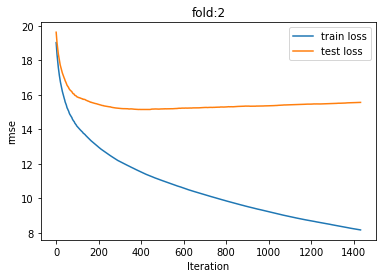

 - fold2_MAE : 15.141471


[I 2022-12-17 16:33:07,510] A new study created in memory with name: no-name-6d11fc6e-9e66-4168-8baf-6f79e9874f70



★★★★★　　　　　Fold 3　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:33:15,116] Trial 0 finished with value: 15.267922903871689 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 15.267922903871689.


Early stopping, best iteration is:
[654]	Train's l1: 10.2845	Test's l1: 15.2679
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:33:22,159] Trial 1 finished with value: 15.208538209939402 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 15.208538209939402.


Early stopping, best iteration is:
[731]	Train's l1: 10.0373	Test's l1: 15.2085
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:33:29,276] Trial 2 finished with value: 15.301265493939813 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 15.208538209939402.


Early stopping, best iteration is:
[670]	Train's l1: 10.2595	Test's l1: 15.3013
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:33:35,190] Trial 3 finished with value: 15.268772228036548 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 15.208538209939402.


Early stopping, best iteration is:
[593]	Train's l1: 10.7607	Test's l1: 15.2688
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:33:41,184] Trial 4 finished with value: 15.268424071901261 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 15.208538209939402.


Early stopping, best iteration is:
[723]	Train's l1: 10.1613	Test's l1: 15.2684
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:33:47,427] Trial 5 finished with value: 15.257193952090377 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 15.208538209939402.


Early stopping, best iteration is:
[624]	Train's l1: 10.5348	Test's l1: 15.2572
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[899]	Train's l1: 9.80852	Test's l1: 15.4452


[I 2022-12-17 16:33:52,942] Trial 6 finished with value: 15.445225603322891 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 15.208538209939402.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:34:00,878] Trial 7 finished with value: 15.362872686879301 and parameters: {'num_leaves': 205}. Best is trial 7 with value: 15.362872686879301.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:34:08,887] Trial 8 finished with value: 15.362872686879301 and parameters: {'num_leaves': 225}. Best is trial 7 with value: 15.362872686879301.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:34:15,190] Trial 9 finished with value: 15.33614354398646 and parameters: {'num_leaves': 34}. Best is trial 9 with value: 15.33614354398646.


Early stopping, best iteration is:
[432]	Train's l1: 11.154	Test's l1: 15.3361
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:34:23,205] Trial 10 finished with value: 15.362872686879301 and parameters: {'num_leaves': 137}. Best is trial 9 with value: 15.33614354398646.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:34:31,199] Trial 11 finished with value: 15.362872686879301 and parameters: {'num_leaves': 62}. Best is trial 9 with value: 15.33614354398646.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:34:38,966] Trial 12 finished with value: 15.362872686879301 and parameters: {'num_leaves': 118}. Best is trial 9 with value: 15.33614354398646.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:34:50,108] Trial 13 finished with value: 15.362872686879301 and parameters: {'num_leaves': 228}. Best is trial 9 with value: 15.33614354398646.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:34:55,966] Trial 14 finished with value: 15.184338198120114 and parameters: {'num_leaves': 27}. Best is trial 14 with value: 15.184338198120114.


Early stopping, best iteration is:
[596]	Train's l1: 10.9305	Test's l1: 15.1843
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:35:03,923] Trial 15 finished with value: 15.362872686879301 and parameters: {'num_leaves': 256}. Best is trial 14 with value: 15.184338198120114.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:35:11,744] Trial 16 finished with value: 15.362872686879301 and parameters: {'num_leaves': 53}. Best is trial 14 with value: 15.184338198120114.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:35:19,754] Trial 17 finished with value: 15.362872686879301 and parameters: {'num_leaves': 106}. Best is trial 14 with value: 15.184338198120114.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:35:23,744] Trial 18 finished with value: 15.644692939549849 and parameters: {'num_leaves': 4}. Best is trial 14 with value: 15.184338198120114.


Early stopping, best iteration is:
[3064]	Train's l1: 13.1657	Test's l1: 15.6447
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:35:28,409] Trial 19 finished with value: 15.415832416335967 and parameters: {'num_leaves': 6}. Best is trial 14 with value: 15.184338198120114.


Early stopping, best iteration is:
[2823]	Train's l1: 11.9098	Test's l1: 15.4158
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:35:36,224] Trial 20 finished with value: 15.362872686879301 and parameters: {'num_leaves': 52}. Best is trial 14 with value: 15.184338198120114.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:35:44,111] Trial 21 finished with value: 15.362872686879301 and parameters: {'num_leaves': 83}. Best is trial 14 with value: 15.184338198120114.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:35:52,075] Trial 22 finished with value: 15.362872686879301 and parameters: {'num_leaves': 157}. Best is trial 14 with value: 15.184338198120114.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:35:57,613] Trial 23 finished with value: 15.18194793091685 and parameters: {'num_leaves': 28}. Best is trial 23 with value: 15.18194793091685.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:36:05,470] Trial 24 finished with value: 15.362872686879301 and parameters: {'num_leaves': 85}. Best is trial 23 with value: 15.18194793091685.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:36:10,717] Trial 25 finished with value: 15.246601958806526 and parameters: {'num_leaves': 26}. Best is trial 23 with value: 15.18194793091685.


Early stopping, best iteration is:
[493]	Train's l1: 11.497	Test's l1: 15.2466
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:36:18,640] Trial 26 finished with value: 15.362872686879301 and parameters: {'num_leaves': 164}. Best is trial 23 with value: 15.18194793091685.


Early stopping, best iteration is:
[549]	Train's l1: 9.91759	Test's l1: 15.3629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:36:23,395] Trial 27 finished with value: 15.780115853805937 and parameters: {'bagging_fraction': 0.5613662001369945, 'bagging_freq': 5}. Best is trial 27 with value: 15.780115853805937.


Early stopping, best iteration is:
[404]	Train's l1: 12.8714	Test's l1: 15.7801
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:36:28,923] Trial 28 finished with value: 15.643070557333207 and parameters: {'bagging_fraction': 0.7153337042295769, 'bagging_freq': 7}. Best is trial 28 with value: 15.643070557333207.


Early stopping, best iteration is:
[413]	Train's l1: 12.2145	Test's l1: 15.6431
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:36:34,849] Trial 29 finished with value: 15.739253702571455 and parameters: {'bagging_fraction': 0.5605820959466159, 'bagging_freq': 4}. Best is trial 28 with value: 15.643070557333207.


Early stopping, best iteration is:
[764]	Train's l1: 11.5032	Test's l1: 15.7393
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:36:40,568] Trial 30 finished with value: 15.354982754638286 and parameters: {'bagging_fraction': 0.9177709472804622, 'bagging_freq': 7}. Best is trial 30 with value: 15.354982754638286.


Early stopping, best iteration is:
[382]	Train's l1: 11.9207	Test's l1: 15.355
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:36:45,460] Trial 31 finished with value: 15.75838501066637 and parameters: {'bagging_fraction': 0.456329072315383, 'bagging_freq': 1}. Best is trial 30 with value: 15.354982754638286.


Early stopping, best iteration is:
[681]	Train's l1: 12.3307	Test's l1: 15.7584
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:36:51,064] Trial 32 finished with value: 15.500262822143094 and parameters: {'bagging_fraction': 0.8452700801338299, 'bagging_freq': 6}. Best is trial 30 with value: 15.354982754638286.


Early stopping, best iteration is:
[378]	Train's l1: 12.1656	Test's l1: 15.5003
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:36:55,839] Trial 33 finished with value: 15.718492983978534 and parameters: {'bagging_fraction': 0.4620214577666507, 'bagging_freq': 1}. Best is trial 30 with value: 15.354982754638286.


Early stopping, best iteration is:
[613]	Train's l1: 12.5224	Test's l1: 15.7185
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:37:00,954] Trial 34 finished with value: 15.702669695750652 and parameters: {'bagging_fraction': 0.6427528458458402, 'bagging_freq': 1}. Best is trial 30 with value: 15.354982754638286.


Early stopping, best iteration is:
[478]	Train's l1: 12.0467	Test's l1: 15.7027
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:37:07,146] Trial 35 finished with value: 15.56699191371472 and parameters: {'bagging_fraction': 0.774175713250663, 'bagging_freq': 1}. Best is trial 30 with value: 15.354982754638286.


Early stopping, best iteration is:
[675]	Train's l1: 10.8325	Test's l1: 15.567
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:37:14,443] Trial 36 finished with value: 15.55692417768781 and parameters: {'bagging_fraction': 0.7968905259875283, 'bagging_freq': 6}. Best is trial 30 with value: 15.354982754638286.


Early stopping, best iteration is:
[801]	Train's l1: 10.4002	Test's l1: 15.5569
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:37:19,823] Trial 37 finished with value: 15.252250051434151 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 15.252250051434151.


Early stopping, best iteration is:
[468]	Train's l1: 11.3969	Test's l1: 15.2523
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:37:26,276] Trial 38 finished with value: 15.296068058847059 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 15.252250051434151.


Early stopping, best iteration is:
[805]	Train's l1: 10.106	Test's l1: 15.2961
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:37:31,302] Trial 39 finished with value: 15.291747856025296 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 15.252250051434151.


Early stopping, best iteration is:
[452]	Train's l1: 11.5466	Test's l1: 15.2917
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:37:36,836] Trial 40 finished with value: 15.18194793091685 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 40 with value: 15.18194793091685.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:37:42,984] Trial 41 finished with value: 15.19496632452785 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 40 with value: 15.18194793091685.


Early stopping, best iteration is:
[613]	Train's l1: 10.7382	Test's l1: 15.195
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:37:48,978] Trial 42 finished with value: 15.2498981844221 and parameters: {'feature_fraction': 0.88}. Best is trial 40 with value: 15.18194793091685.


Early stopping, best iteration is:
[509]	Train's l1: 11.1699	Test's l1: 15.2499
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:37:55,138] Trial 43 finished with value: 15.223537284637361 and parameters: {'lambda_l1': 3.723043435683158, 'lambda_l2': 0.5051507370255537}. Best is trial 43 with value: 15.223537284637361.


Early stopping, best iteration is:
[592]	Train's l1: 10.8551	Test's l1: 15.2235
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:38:00,736] Trial 44 finished with value: 15.181947930228796 and parameters: {'lambda_l1': 3.847274225335675e-07, 'lambda_l2': 1.442836350824853e-06}. Best is trial 44 with value: 15.181947930228796.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:38:06,572] Trial 45 finished with value: 15.184479998438865 and parameters: {'lambda_l1': 2.1114444724066996, 'lambda_l2': 0.03578850112550862}. Best is trial 44 with value: 15.181947930228796.


Early stopping, best iteration is:
[543]	Train's l1: 11.0805	Test's l1: 15.1845
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:38:12,199] Trial 46 finished with value: 15.181947929933955 and parameters: {'lambda_l1': 8.038002875115605e-08, 'lambda_l2': 2.1888764023897373e-06}. Best is trial 46 with value: 15.181947929933955.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:38:18,013] Trial 47 finished with value: 15.201415296544477 and parameters: {'lambda_l1': 0.0023758929995026288, 'lambda_l2': 0.03844938709696926}. Best is trial 46 with value: 15.181947929933955.


Early stopping, best iteration is:
[567]	Train's l1: 10.9769	Test's l1: 15.2014
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:38:23,999] Trial 48 finished with value: 15.182326919269016 and parameters: {'lambda_l1': 0.06774697400864345, 'lambda_l2': 1.972223617586698e-05}. Best is trial 46 with value: 15.181947929933955.


Early stopping, best iteration is:
[575]	Train's l1: 10.9112	Test's l1: 15.1823
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:38:32,608] Trial 49 finished with value: 15.181947895374483 and parameters: {'lambda_l1': 2.6421401810564616e-07, 'lambda_l2': 9.820263330012396e-05}. Best is trial 49 with value: 15.181947895374483.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:38:37,835] Trial 50 finished with value: 15.225889430003702 and parameters: {'lambda_l1': 0.1733641106799508, 'lambda_l2': 1.3017833257293439}. Best is trial 49 with value: 15.181947895374483.


Early stopping, best iteration is:
[423]	Train's l1: 11.6578	Test's l1: 15.2259
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:38:44,072] Trial 51 finished with value: 15.266232266718834 and parameters: {'lambda_l1': 0.0036341316112864287, 'lambda_l2': 0.014903946571266771}. Best is trial 49 with value: 15.181947895374483.


Early stopping, best iteration is:
[680]	Train's l1: 10.5012	Test's l1: 15.2662
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:38:49,699] Trial 52 finished with value: 15.181947409541149 and parameters: {'lambda_l1': 3.3210310433392576e-06, 'lambda_l2': 0.001447307657276136}. Best is trial 52 with value: 15.181947409541149.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:38:55,330] Trial 53 finished with value: 15.181947926862597 and parameters: {'lambda_l1': 2.3412861093819992e-05, 'lambda_l2': 3.7908652294587405e-08}. Best is trial 52 with value: 15.181947409541149.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:00,901] Trial 54 finished with value: 15.181947805972184 and parameters: {'lambda_l1': 7.915307518884612e-06, 'lambda_l2': 0.00034784348802846104}. Best is trial 52 with value: 15.181947409541149.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:06,524] Trial 55 finished with value: 15.181947390200039 and parameters: {'lambda_l1': 1.275028584419046e-05, 'lambda_l2': 0.0014982347035472725}. Best is trial 55 with value: 15.181947390200039.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:12,093] Trial 56 finished with value: 15.181947209371083 and parameters: {'lambda_l1': 2.0537293921398887e-05, 'lambda_l2': 0.001998921081326556}. Best is trial 56 with value: 15.181947209371083.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:17,728] Trial 57 finished with value: 15.18194693927766 and parameters: {'lambda_l1': 0.00018159296223801584, 'lambda_l2': 0.0026639550032698037}. Best is trial 57 with value: 15.18194693927766.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:23,588] Trial 58 finished with value: 15.265453279733963 and parameters: {'lambda_l1': 0.00038848722688022936, 'lambda_l2': 7.245276983938948}. Best is trial 57 with value: 15.18194693927766.


Early stopping, best iteration is:
[564]	Train's l1: 11.0523	Test's l1: 15.2655
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:29,375] Trial 59 finished with value: 15.1816757888085 and parameters: {'lambda_l1': 1.4463196353539065e-08, 'lambda_l2': 0.006721263006846757}. Best is trial 59 with value: 15.1816757888085.


Early stopping, best iteration is:
[544]	Train's l1: 11.0551	Test's l1: 15.1817
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:34,393] Trial 60 finished with value: 15.239271012257573 and parameters: {'lambda_l1': 3.039272780822801e-08, 'lambda_l2': 0.1668777607213219}. Best is trial 59 with value: 15.1816757888085.


Early stopping, best iteration is:
[365]	Train's l1: 11.9199	Test's l1: 15.2393
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:39,936] Trial 61 finished with value: 15.181947873865683 and parameters: {'lambda_l1': 0.00024106515370323004, 'lambda_l2': 3.552133616150611e-05}. Best is trial 59 with value: 15.1816757888085.


Early stopping, best iteration is:
[493]	Train's l1: 11.2626	Test's l1: 15.1819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:45,841] Trial 62 finished with value: 15.181675881517595 and parameters: {'lambda_l1': 1.2615217533932636e-06, 'lambda_l2': 0.006211506593669092}. Best is trial 59 with value: 15.1816757888085.


Early stopping, best iteration is:
[544]	Train's l1: 11.0551	Test's l1: 15.1817
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:51,661] Trial 63 finished with value: 15.1816757888085 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 15.1816757888085.


Early stopping, best iteration is:
[544]	Train's l1: 11.0551	Test's l1: 15.1817
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:39:57,502] Trial 64 finished with value: 15.1816757888085 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 15.1816757888085.


Early stopping, best iteration is:
[544]	Train's l1: 11.0551	Test's l1: 15.1817
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:40:03,461] Trial 65 finished with value: 15.1816757888085 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 15.1816757888085.


Early stopping, best iteration is:
[544]	Train's l1: 11.0551	Test's l1: 15.1817
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:40:09,317] Trial 66 finished with value: 15.1816757888085 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 15.1816757888085.


Early stopping, best iteration is:
[544]	Train's l1: 11.0551	Test's l1: 15.1817
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:40:15,278] Trial 67 finished with value: 15.1816757888085 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 15.1816757888085.


Early stopping, best iteration is:
[544]	Train's l1: 11.0551	Test's l1: 15.1817
▼▼▼▼▼　　　　　Fold 3　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 1.4463196353539065e-08, 'lambda_l2': 0.006721263006846757, 'num_leaves': 28, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


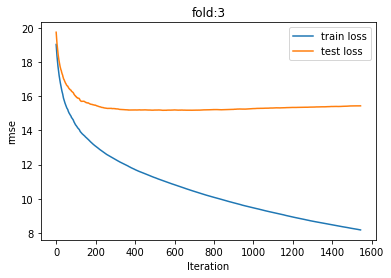

 - fold3_MAE : 15.181676


[I 2022-12-17 16:40:16,132] A new study created in memory with name: no-name-8563df71-e18a-4fdf-8f85-1cf55931d1e2



★★★★★　　　　　Fold 4　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:40:20,805] Trial 0 finished with value: 14.808399561788969 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 14.808399561788969.


Early stopping, best iteration is:
[608]	Train's l1: 10.8782	Test's l1: 14.8084
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:40:25,631] Trial 1 finished with value: 14.654558831492988 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 14.654558831492988.


Early stopping, best iteration is:
[396]	Train's l1: 11.7154	Test's l1: 14.6546
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:40:29,931] Trial 2 finished with value: 14.760081950857534 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 14.654558831492988.


Early stopping, best iteration is:
[340]	Train's l1: 12.0898	Test's l1: 14.7601
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:40:35,797] Trial 3 finished with value: 14.704250176129149 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 14.654558831492988.


Early stopping, best iteration is:
[349]	Train's l1: 11.8984	Test's l1: 14.7043
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:40:41,716] Trial 4 finished with value: 14.549597115482324 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 14.549597115482324.


Early stopping, best iteration is:
[437]	Train's l1: 11.4041	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:40:49,222] Trial 5 finished with value: 14.63608796448579 and parameters: {'feature_fraction': 1.0}. Best is trial 4 with value: 14.549597115482324.


Early stopping, best iteration is:
[587]	Train's l1: 10.6545	Test's l1: 14.6361
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:40:54,757] Trial 6 finished with value: 14.599252524979638 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 14.549597115482324.


Early stopping, best iteration is:
[449]	Train's l1: 11.3773	Test's l1: 14.5993
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:41:01,901] Trial 7 finished with value: 14.663244058633342 and parameters: {'num_leaves': 212}. Best is trial 7 with value: 14.663244058633342.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:41:09,075] Trial 8 finished with value: 14.663244058633342 and parameters: {'num_leaves': 220}. Best is trial 7 with value: 14.663244058633342.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:41:16,260] Trial 9 finished with value: 14.663244058633342 and parameters: {'num_leaves': 209}. Best is trial 7 with value: 14.663244058633342.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:41:23,386] Trial 10 finished with value: 14.663244058633342 and parameters: {'num_leaves': 229}. Best is trial 7 with value: 14.663244058633342.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:41:29,991] Trial 11 finished with value: 14.654989796441791 and parameters: {'num_leaves': 43}. Best is trial 11 with value: 14.654989796441791.


Early stopping, best iteration is:
[325]	Train's l1: 11.4441	Test's l1: 14.655
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:41:33,611] Trial 12 finished with value: 14.786862883466709 and parameters: {'num_leaves': 4}. Best is trial 11 with value: 14.654989796441791.


Early stopping, best iteration is:
[2647]	Train's l1: 13.4926	Test's l1: 14.7869
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:41:36,696] Trial 13 finished with value: 14.568517920831164 and parameters: {'num_leaves': 11}. Best is trial 13 with value: 14.568517920831164.


Early stopping, best iteration is:
[644]	Train's l1: 12.9355	Test's l1: 14.5685
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:41:43,832] Trial 14 finished with value: 14.663244058633342 and parameters: {'num_leaves': 238}. Best is trial 13 with value: 14.568517920831164.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:41:51,031] Trial 15 finished with value: 14.663244058633342 and parameters: {'num_leaves': 95}. Best is trial 13 with value: 14.568517920831164.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:41:58,189] Trial 16 finished with value: 14.663244058633342 and parameters: {'num_leaves': 246}. Best is trial 13 with value: 14.568517920831164.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632


[I 2022-12-17 16:42:05,582] Trial 17 finished with value: 14.663244058633342 and parameters: {'num_leaves': 131}. Best is trial 13 with value: 14.568517920831164.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:42:12,537] Trial 18 finished with value: 14.560162804839907 and parameters: {'num_leaves': 17}. Best is trial 18 with value: 14.560162804839907.


Early stopping, best iteration is:
[552]	Train's l1: 12.2258	Test's l1: 14.5602
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:42:15,880] Trial 19 finished with value: 14.633233240324818 and parameters: {'num_leaves': 10}. Best is trial 18 with value: 14.560162804839907.


Early stopping, best iteration is:
[869]	Train's l1: 12.6213	Test's l1: 14.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:42:22,992] Trial 20 finished with value: 14.663244058633342 and parameters: {'num_leaves': 66}. Best is trial 18 with value: 14.560162804839907.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:42:30,106] Trial 21 finished with value: 14.663244058633342 and parameters: {'num_leaves': 144}. Best is trial 18 with value: 14.560162804839907.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:42:37,149] Trial 22 finished with value: 14.640596798062333 and parameters: {'num_leaves': 46}. Best is trial 18 with value: 14.560162804839907.


Early stopping, best iteration is:
[384]	Train's l1: 10.9597	Test's l1: 14.6406
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:42:44,332] Trial 23 finished with value: 14.663244058633342 and parameters: {'num_leaves': 97}. Best is trial 18 with value: 14.560162804839907.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:42:51,672] Trial 24 finished with value: 14.663244058633342 and parameters: {'num_leaves': 166}. Best is trial 18 with value: 14.560162804839907.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:42:58,337] Trial 25 finished with value: 14.550371976769123 and parameters: {'num_leaves': 32}. Best is trial 25 with value: 14.550371976769123.


Early stopping, best iteration is:
[555]	Train's l1: 10.7202	Test's l1: 14.5504
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:43:05,540] Trial 26 finished with value: 14.663244058633342 and parameters: {'num_leaves': 84}. Best is trial 25 with value: 14.550371976769123.


Early stopping, best iteration is:
[389]	Train's l1: 10.9288	Test's l1: 14.6632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:43:11,114] Trial 27 finished with value: 14.970045326407526 and parameters: {'bagging_fraction': 0.7516257876880337, 'bagging_freq': 2}. Best is trial 27 with value: 14.970045326407526.


Early stopping, best iteration is:
[298]	Train's l1: 12.6315	Test's l1: 14.97
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:43:15,517] Trial 28 finished with value: 15.13845075705785 and parameters: {'bagging_fraction': 0.5969672692473504, 'bagging_freq': 2}. Best is trial 27 with value: 14.970045326407526.


Early stopping, best iteration is:
[200]	Train's l1: 13.8862	Test's l1: 15.1385
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:43:22,369] Trial 29 finished with value: 14.962052050505147 and parameters: {'bagging_fraction': 0.799718827406199, 'bagging_freq': 3}. Best is trial 29 with value: 14.962052050505147.


Early stopping, best iteration is:
[543]	Train's l1: 11.1798	Test's l1: 14.9621
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:43:26,405] Trial 30 finished with value: 15.252520030941989 and parameters: {'bagging_fraction': 0.49890789488090687, 'bagging_freq': 6}. Best is trial 29 with value: 14.962052050505147.


Early stopping, best iteration is:
[300]	Train's l1: 13.7026	Test's l1: 15.2525
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:43:31,662] Trial 31 finished with value: 15.276592510522896 and parameters: {'bagging_fraction': 0.5137860031222992, 'bagging_freq': 6}. Best is trial 29 with value: 14.962052050505147.


Early stopping, best iteration is:
[699]	Train's l1: 11.9908	Test's l1: 15.2766
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:43:35,957] Trial 32 finished with value: 15.23450471672095 and parameters: {'bagging_fraction': 0.5883086467470209, 'bagging_freq': 6}. Best is trial 29 with value: 14.962052050505147.


Early stopping, best iteration is:
[202]	Train's l1: 13.926	Test's l1: 15.2345
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:43:41,130] Trial 33 finished with value: 15.1404558232295 and parameters: {'bagging_fraction': 0.6551340545865254, 'bagging_freq': 7}. Best is trial 29 with value: 14.962052050505147.


Early stopping, best iteration is:
[343]	Train's l1: 12.7929	Test's l1: 15.1405
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:43:48,292] Trial 34 finished with value: 14.561637464452952 and parameters: {'bagging_fraction': 0.9964310199331324, 'bagging_freq': 5}. Best is trial 34 with value: 14.561637464452952.


Early stopping, best iteration is:
[485]	Train's l1: 11.1345	Test's l1: 14.5616
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:43:55,658] Trial 35 finished with value: 14.775459281368434 and parameters: {'bagging_fraction': 0.9528320159794298, 'bagging_freq': 4}. Best is trial 34 with value: 14.561637464452952.


Early stopping, best iteration is:
[580]	Train's l1: 10.7291	Test's l1: 14.7755
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:44:00,443] Trial 36 finished with value: 15.164901692407994 and parameters: {'bagging_fraction': 0.4409777016027035, 'bagging_freq': 6}. Best is trial 34 with value: 14.561637464452952.


Early stopping, best iteration is:
[697]	Train's l1: 12.5154	Test's l1: 15.1649
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:44:06,319] Trial 37 finished with value: 14.58002502478098 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 14.58002502478098.


Early stopping, best iteration is:
[512]	Train's l1: 11.0295	Test's l1: 14.58
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:44:12,203] Trial 38 finished with value: 14.549597115482324 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 14.549597115482324.


Early stopping, best iteration is:
[437]	Train's l1: 11.4041	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:44:18,167] Trial 39 finished with value: 14.59868145849516 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 38 with value: 14.549597115482324.


Early stopping, best iteration is:
[403]	Train's l1: 11.6151	Test's l1: 14.5987
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:44:23,641] Trial 40 finished with value: 14.599252524979638 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 38 with value: 14.549597115482324.


Early stopping, best iteration is:
[449]	Train's l1: 11.3773	Test's l1: 14.5993
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:44:29,356] Trial 41 finished with value: 14.704250176129149 and parameters: {'feature_fraction': 0.88}. Best is trial 38 with value: 14.549597115482324.


Early stopping, best iteration is:
[349]	Train's l1: 11.8984	Test's l1: 14.7043
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:44:35,131] Trial 42 finished with value: 14.550086934350896 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 14.549597115482324.


Early stopping, best iteration is:
[445]	Train's l1: 11.3762	Test's l1: 14.5501
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:44:41,119] Trial 43 finished with value: 14.621501174896581 and parameters: {'lambda_l1': 0.05074240967533841, 'lambda_l2': 1.4063145696409096}. Best is trial 43 with value: 14.621501174896581.


Early stopping, best iteration is:
[485]	Train's l1: 11.137	Test's l1: 14.6215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:44:47,866] Trial 44 finished with value: 14.642514441760104 and parameters: {'lambda_l1': 0.00011028521690568915, 'lambda_l2': 0.015214373079016876}. Best is trial 43 with value: 14.621501174896581.


Early stopping, best iteration is:
[632]	Train's l1: 10.4881	Test's l1: 14.6425
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:44:53,652] Trial 45 finished with value: 14.549597013141383 and parameters: {'lambda_l1': 9.247006477142702e-05, 'lambda_l2': 1.650740739260919e-05}. Best is trial 45 with value: 14.549597013141383.


Early stopping, best iteration is:
[437]	Train's l1: 11.4041	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:45:00,270] Trial 46 finished with value: 14.642517120014297 and parameters: {'lambda_l1': 2.281579239470877e-05, 'lambda_l2': 0.014438908511972062}. Best is trial 45 with value: 14.549597013141383.


Early stopping, best iteration is:
[632]	Train's l1: 10.4881	Test's l1: 14.6425
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:45:06,081] Trial 47 finished with value: 14.54959705932356 and parameters: {'lambda_l1': 6.982941960922325e-05, 'lambda_l2': 2.4950654887175925e-08}. Best is trial 45 with value: 14.549597013141383.


Early stopping, best iteration is:
[437]	Train's l1: 11.4041	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:45:12,039] Trial 48 finished with value: 14.546696578407945 and parameters: {'lambda_l1': 2.141203005321988, 'lambda_l2': 2.5820597110787815e-07}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[432]	Train's l1: 11.4473	Test's l1: 14.5467
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:45:17,881] Trial 49 finished with value: 14.55067475077664 and parameters: {'lambda_l1': 0.1310466184760137, 'lambda_l2': 0.0011176070797546886}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[449]	Train's l1: 11.3079	Test's l1: 14.5507
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:45:24,152] Trial 50 finished with value: 14.60991145108216 and parameters: {'lambda_l1': 0.4874252242833338, 'lambda_l2': 0.0002522785052402272}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[539]	Train's l1: 10.8483	Test's l1: 14.6099
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:45:29,895] Trial 51 finished with value: 14.549592888421254 and parameters: {'lambda_l1': 2.402502623818246e-08, 'lambda_l2': 0.0025539206639031424}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[437]	Train's l1: 11.4042	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:45:36,332] Trial 52 finished with value: 14.583695905274 and parameters: {'lambda_l1': 0.11382668375374516, 'lambda_l2': 0.6485615522427705}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[594]	Train's l1: 10.6614	Test's l1: 14.5837
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[444]	Train's l1: 11.3964	Test's l1: 14.5718


[I 2022-12-17 16:45:43,696] Trial 53 finished with value: 14.571805957049891 and parameters: {'lambda_l1': 9.069223307805151, 'lambda_l2': 1.876941746275073e-08}. Best is trial 48 with value: 14.546696578407945.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:45:51,081] Trial 54 finished with value: 14.54959711133784 and parameters: {'lambda_l1': 4.144249861457443e-08, 'lambda_l2': 2.5052699342419816e-06}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[437]	Train's l1: 11.4041	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:45:56,929] Trial 55 finished with value: 14.549597113662228 and parameters: {'lambda_l1': 1.0377756996091214e-07, 'lambda_l2': 1.1609499739501972e-06}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[437]	Train's l1: 11.4041	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:46:02,754] Trial 56 finished with value: 14.54959692301265 and parameters: {'lambda_l1': 4.878010360210256e-07, 'lambda_l2': 0.00011585358120053773}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[437]	Train's l1: 11.4041	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:46:08,217] Trial 57 finished with value: 14.624280741779042 and parameters: {'lambda_l1': 0.0018550842965608626, 'lambda_l2': 0.013350605195450156}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[378]	Train's l1: 11.7126	Test's l1: 14.6243
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:46:14,059] Trial 58 finished with value: 14.549597113215953 and parameters: {'lambda_l1': 2.417927233653482e-06, 'lambda_l2': 1.2436444384019303e-07}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[437]	Train's l1: 11.4041	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:46:19,822] Trial 59 finished with value: 14.549594135305172 and parameters: {'lambda_l1': 0.003639625821868239, 'lambda_l2': 4.322432976571488e-06}. Best is trial 48 with value: 14.546696578407945.


Early stopping, best iteration is:
[437]	Train's l1: 11.4042	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:46:25,491] Trial 60 finished with value: 14.53336889999214 and parameters: {'lambda_l1': 7.311642458259875, 'lambda_l2': 0.0014756085176627742}. Best is trial 60 with value: 14.53336889999214.


Early stopping, best iteration is:
[381]	Train's l1: 11.7209	Test's l1: 14.5334
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:46:31,753] Trial 61 finished with value: 14.529396899049019 and parameters: {'lambda_l1': 6.815684248590584, 'lambda_l2': 4.714418787228139e-05}. Best is trial 61 with value: 14.529396899049019.


Early stopping, best iteration is:
[527]	Train's l1: 10.9504	Test's l1: 14.5294
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:46:37,549] Trial 62 finished with value: 14.549586760299698 and parameters: {'lambda_l1': 0.012618499507201604, 'lambda_l2': 4.0028397555651414e-05}. Best is trial 61 with value: 14.529396899049019.


Early stopping, best iteration is:
[437]	Train's l1: 11.4042	Test's l1: 14.5496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:46:43,812] Trial 63 finished with value: 14.529396899049019 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 14.529396899049019.


Early stopping, best iteration is:
[527]	Train's l1: 10.9504	Test's l1: 14.5294
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:46:50,135] Trial 64 finished with value: 14.529396899049019 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 14.529396899049019.


Early stopping, best iteration is:
[527]	Train's l1: 10.9504	Test's l1: 14.5294
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:46:56,583] Trial 65 finished with value: 14.529396899049019 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 14.529396899049019.


Early stopping, best iteration is:
[527]	Train's l1: 10.9504	Test's l1: 14.5294
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:47:02,822] Trial 66 finished with value: 14.529396899049019 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 14.529396899049019.


Early stopping, best iteration is:
[527]	Train's l1: 10.9504	Test's l1: 14.5294
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:47:09,145] Trial 67 finished with value: 14.529396899049019 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 14.529396899049019.


Early stopping, best iteration is:
[527]	Train's l1: 10.9504	Test's l1: 14.5294
▼▼▼▼▼　　　　　Fold 4　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 6.815684248590584, 'lambda_l2': 4.714418787228139e-05, 'num_leaves': 31, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


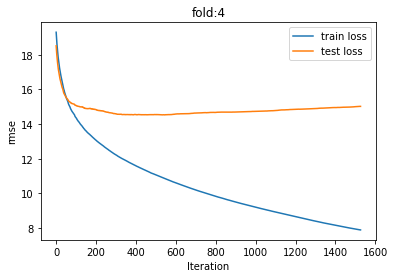

 - fold4_MAE : 14.529397


[I 2022-12-17 16:47:10,127] A new study created in memory with name: no-name-7616ce86-b50c-4e4e-995b-02497d5a7e21



★★★★★　　　　　Fold 5　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:47:15,830] Trial 0 finished with value: 14.640495544808068 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 14.640495544808068.


Early stopping, best iteration is:
[409]	Train's l1: 11.5696	Test's l1: 14.6405
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:47:20,972] Trial 1 finished with value: 14.636250877801134 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 14.636250877801134.


Early stopping, best iteration is:
[385]	Train's l1: 11.7417	Test's l1: 14.6363
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:47:27,166] Trial 2 finished with value: 14.580214121019841 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 14.580214121019841.


Early stopping, best iteration is:
[468]	Train's l1: 11.2428	Test's l1: 14.5802
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:47:32,790] Trial 3 finished with value: 14.638441333512029 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 14.580214121019841.


Early stopping, best iteration is:
[640]	Train's l1: 10.5994	Test's l1: 14.6384
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:47:37,839] Trial 4 finished with value: 14.670428798483947 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 14.580214121019841.


Early stopping, best iteration is:
[635]	Train's l1: 10.6308	Test's l1: 14.6704
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:47:42,600] Trial 5 finished with value: 14.787410587585613 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 14.580214121019841.


Early stopping, best iteration is:
[712]	Train's l1: 10.4867	Test's l1: 14.7874
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:47:49,333] Trial 6 finished with value: 14.59379688285921 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 14.580214121019841.


Early stopping, best iteration is:
[437]	Train's l1: 11.4236	Test's l1: 14.5938
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:47:56,611] Trial 7 finished with value: 14.823753377160026 and parameters: {'num_leaves': 229}. Best is trial 7 with value: 14.823753377160026.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:48:00,206] Trial 8 finished with value: 14.70996592326509 and parameters: {'num_leaves': 5}. Best is trial 8 with value: 14.70996592326509.


Early stopping, best iteration is:
[2081]	Train's l1: 12.9822	Test's l1: 14.71
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:48:07,401] Trial 9 finished with value: 14.823753377160026 and parameters: {'num_leaves': 106}. Best is trial 8 with value: 14.70996592326509.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:48:14,519] Trial 10 finished with value: 14.823753377160026 and parameters: {'num_leaves': 150}. Best is trial 8 with value: 14.70996592326509.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:48:21,697] Trial 11 finished with value: 14.823753377160026 and parameters: {'num_leaves': 223}. Best is trial 8 with value: 14.70996592326509.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:48:28,809] Trial 12 finished with value: 14.823753377160026 and parameters: {'num_leaves': 118}. Best is trial 8 with value: 14.70996592326509.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:48:35,915] Trial 13 finished with value: 14.823753377160026 and parameters: {'num_leaves': 94}. Best is trial 8 with value: 14.70996592326509.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:48:42,944] Trial 14 finished with value: 14.823753377160026 and parameters: {'num_leaves': 97}. Best is trial 8 with value: 14.70996592326509.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:48:50,070] Trial 15 finished with value: 14.847732978313012 and parameters: {'num_leaves': 43}. Best is trial 8 with value: 14.70996592326509.


Early stopping, best iteration is:
[357]	Train's l1: 11.2634	Test's l1: 14.8477
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:48:57,212] Trial 16 finished with value: 14.823753377160026 and parameters: {'num_leaves': 93}. Best is trial 8 with value: 14.70996592326509.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:49:00,630] Trial 17 finished with value: 14.575769363188462 and parameters: {'num_leaves': 8}. Best is trial 17 with value: 14.575769363188462.


Early stopping, best iteration is:
[1130]	Train's l1: 12.6395	Test's l1: 14.5758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:49:03,831] Trial 18 finished with value: 14.69029863171645 and parameters: {'num_leaves': 7}. Best is trial 17 with value: 14.575769363188462.


Early stopping, best iteration is:
[1247]	Train's l1: 12.8688	Test's l1: 14.6903
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:49:07,348] Trial 19 finished with value: 14.70996592326509 and parameters: {'num_leaves': 5}. Best is trial 17 with value: 14.575769363188462.


Early stopping, best iteration is:
[2081]	Train's l1: 12.9822	Test's l1: 14.71
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:49:14,487] Trial 20 finished with value: 14.823753377160026 and parameters: {'num_leaves': 51}. Best is trial 17 with value: 14.575769363188462.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:49:24,484] Trial 21 finished with value: 14.847732978313012 and parameters: {'num_leaves': 43}. Best is trial 17 with value: 14.575769363188462.


Early stopping, best iteration is:
[357]	Train's l1: 11.2634	Test's l1: 14.8477
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:49:31,606] Trial 22 finished with value: 14.823753377160026 and parameters: {'num_leaves': 178}. Best is trial 17 with value: 14.575769363188462.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:49:38,669] Trial 23 finished with value: 14.823753377160026 and parameters: {'num_leaves': 65}. Best is trial 17 with value: 14.575769363188462.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:49:43,143] Trial 24 finished with value: 14.47283256526441 and parameters: {'num_leaves': 18}. Best is trial 24 with value: 14.47283256526441.


Early stopping, best iteration is:
[580]	Train's l1: 11.9867	Test's l1: 14.4728
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:49:48,855] Trial 25 finished with value: 14.616929357506605 and parameters: {'num_leaves': 30}. Best is trial 24 with value: 14.47283256526441.


Early stopping, best iteration is:
[399]	Train's l1: 11.7013	Test's l1: 14.6169
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:49:56,021] Trial 26 finished with value: 14.823753377160026 and parameters: {'num_leaves': 73}. Best is trial 24 with value: 14.47283256526441.


Early stopping, best iteration is:
[345]	Train's l1: 11.3517	Test's l1: 14.8238
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:01,083] Trial 27 finished with value: 15.206407800803648 and parameters: {'bagging_fraction': 0.4163431223185762, 'bagging_freq': 3}. Best is trial 27 with value: 15.206407800803648.


Early stopping, best iteration is:
[939]	Train's l1: 12.1405	Test's l1: 15.2064
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:06,026] Trial 28 finished with value: 14.991054634245328 and parameters: {'bagging_fraction': 0.6302015333015325, 'bagging_freq': 1}. Best is trial 28 with value: 14.991054634245328.


Early stopping, best iteration is:
[714]	Train's l1: 12.0123	Test's l1: 14.9911
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:11,036] Trial 29 finished with value: 14.83511121436664 and parameters: {'bagging_fraction': 0.8000060727383549, 'bagging_freq': 4}. Best is trial 29 with value: 14.83511121436664.


Early stopping, best iteration is:
[614]	Train's l1: 12.0546	Test's l1: 14.8351
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:15,721] Trial 30 finished with value: 14.84018340864801 and parameters: {'bagging_fraction': 0.7608090357015281, 'bagging_freq': 1}. Best is trial 29 with value: 14.83511121436664.


Early stopping, best iteration is:
[629]	Train's l1: 12.0606	Test's l1: 14.8402
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:20,572] Trial 31 finished with value: 14.549751320038231 and parameters: {'bagging_fraction': 0.9887134754667989, 'bagging_freq': 6}. Best is trial 31 with value: 14.549751320038231.


Early stopping, best iteration is:
[527]	Train's l1: 12.1798	Test's l1: 14.5498
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:25,120] Trial 32 finished with value: 15.18500420010551 and parameters: {'bagging_fraction': 0.4723873961848533, 'bagging_freq': 5}. Best is trial 31 with value: 14.549751320038231.


Early stopping, best iteration is:
[632]	Train's l1: 12.6963	Test's l1: 15.185
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:30,158] Trial 33 finished with value: 14.86904581800812 and parameters: {'bagging_fraction': 0.7461206019124391, 'bagging_freq': 6}. Best is trial 31 with value: 14.549751320038231.


Early stopping, best iteration is:
[648]	Train's l1: 12.1317	Test's l1: 14.869
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:35,067] Trial 34 finished with value: 14.845198096551895 and parameters: {'bagging_fraction': 0.737554188940894, 'bagging_freq': 7}. Best is trial 31 with value: 14.549751320038231.


Early stopping, best iteration is:
[615]	Train's l1: 12.1942	Test's l1: 14.8452
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:39,485] Trial 35 finished with value: 14.965360385865724 and parameters: {'bagging_fraction': 0.6246091601778376, 'bagging_freq': 1}. Best is trial 31 with value: 14.549751320038231.


Early stopping, best iteration is:
[566]	Train's l1: 12.5485	Test's l1: 14.9654
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:44,686] Trial 36 finished with value: 14.843703011873558 and parameters: {'bagging_fraction': 0.6918546528515575, 'bagging_freq': 3}. Best is trial 31 with value: 14.549751320038231.


Early stopping, best iteration is:
[689]	Train's l1: 12.009	Test's l1: 14.8437
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:49,919] Trial 37 finished with value: 14.453991106718325 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 14.453991106718325.


Early stopping, best iteration is:
[779]	Train's l1: 11.4424	Test's l1: 14.454
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:54,355] Trial 38 finished with value: 14.47283256526441 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 14.453991106718325.


Early stopping, best iteration is:
[580]	Train's l1: 11.9867	Test's l1: 14.4728
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:50:59,059] Trial 39 finished with value: 14.440715176639308 and parameters: {'feature_fraction': 0.948}. Best is trial 39 with value: 14.440715176639308.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:03,733] Trial 40 finished with value: 14.506957423273628 and parameters: {'feature_fraction': 0.82}. Best is trial 39 with value: 14.440715176639308.


Early stopping, best iteration is:
[750]	Train's l1: 11.5468	Test's l1: 14.507
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:08,555] Trial 41 finished with value: 14.566946732246059 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 39 with value: 14.440715176639308.


Early stopping, best iteration is:
[602]	Train's l1: 11.9556	Test's l1: 14.5669
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:13,189] Trial 42 finished with value: 14.48187465933523 and parameters: {'feature_fraction': 0.852}. Best is trial 39 with value: 14.440715176639308.


Early stopping, best iteration is:
[690]	Train's l1: 11.71	Test's l1: 14.4819
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:17,692] Trial 43 finished with value: 14.552165458869043 and parameters: {'lambda_l1': 0.029443045773607655, 'lambda_l2': 0.2570433482558873}. Best is trial 43 with value: 14.552165458869043.


Early stopping, best iteration is:
[510]	Train's l1: 12.2597	Test's l1: 14.5522
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:21,827] Trial 44 finished with value: 14.620772174108833 and parameters: {'lambda_l1': 1.4404446893807392e-05, 'lambda_l2': 5.975674186942529}. Best is trial 43 with value: 14.552165458869043.


Early stopping, best iteration is:
[436]	Train's l1: 12.5961	Test's l1: 14.6208
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:26,428] Trial 45 finished with value: 14.440715179569754 and parameters: {'lambda_l1': 2.6805687441191535e-08, 'lambda_l2': 5.309465988462141e-05}. Best is trial 45 with value: 14.440715179569754.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:31,118] Trial 46 finished with value: 14.440715175933867 and parameters: {'lambda_l1': 1.5920637487960185e-07, 'lambda_l2': 4.670001114417917e-06}. Best is trial 46 with value: 14.440715175933867.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:35,754] Trial 47 finished with value: 14.440715176719236 and parameters: {'lambda_l1': 2.315381996124681e-07, 'lambda_l2': 7.392657952693133e-08}. Best is trial 46 with value: 14.440715175933867.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:40,586] Trial 48 finished with value: 14.522983684876275 and parameters: {'lambda_l1': 1.3131697634372788, 'lambda_l2': 0.001479758066542083}. Best is trial 46 with value: 14.440715175933867.


Early stopping, best iteration is:
[633]	Train's l1: 11.8743	Test's l1: 14.523
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:45,129] Trial 49 finished with value: 14.565488815524583 and parameters: {'lambda_l1': 0.010245582329314046, 'lambda_l2': 0.026392774597317325}. Best is trial 46 with value: 14.440715175933867.


Early stopping, best iteration is:
[551]	Train's l1: 12.1587	Test's l1: 14.5655
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:49,902] Trial 50 finished with value: 14.440715410083936 and parameters: {'lambda_l1': 1.9999484507997976e-08, 'lambda_l2': 0.004104239571083489}. Best is trial 46 with value: 14.440715175933867.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:54,614] Trial 51 finished with value: 14.440715201094537 and parameters: {'lambda_l1': 2.8611302470580877e-05, 'lambda_l2': 0.0005668603158573235}. Best is trial 46 with value: 14.440715175933867.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:51:59,394] Trial 52 finished with value: 14.502671335679475 and parameters: {'lambda_l1': 0.0011543572146918248, 'lambda_l2': 0.3471678244378001}. Best is trial 46 with value: 14.440715175933867.


Early stopping, best iteration is:
[615]	Train's l1: 11.9142	Test's l1: 14.5027
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:04,110] Trial 53 finished with value: 14.440715175697978 and parameters: {'lambda_l1': 2.2396914961612696e-06, 'lambda_l2': 1.8859365435343134e-06}. Best is trial 53 with value: 14.440715175697978.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:08,789] Trial 54 finished with value: 14.440715175442609 and parameters: {'lambda_l1': 2.154325579168015e-06, 'lambda_l2': 3.3577153019455577e-06}. Best is trial 54 with value: 14.440715175442609.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:13,480] Trial 55 finished with value: 14.44071517499215 and parameters: {'lambda_l1': 4.897147343277701e-06, 'lambda_l2': 4.1372834093691823e-07}. Best is trial 55 with value: 14.44071517499215.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:18,136] Trial 56 finished with value: 14.4407151691317 and parameters: {'lambda_l1': 2.447448244720076e-05, 'lambda_l2': 2.5615874281847724e-08}. Best is trial 56 with value: 14.4407151691317.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:22,883] Trial 57 finished with value: 14.44071515105245 and parameters: {'lambda_l1': 8.721495053367343e-05, 'lambda_l2': 1.0125490005433399e-08}. Best is trial 57 with value: 14.44071515105245.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:27,627] Trial 58 finished with value: 14.440715133233827 and parameters: {'lambda_l1': 0.00014673191486097887, 'lambda_l2': 1.782670769256792e-08}. Best is trial 58 with value: 14.440715133233827.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:32,330] Trial 59 finished with value: 14.440714960397267 and parameters: {'lambda_l1': 0.0007425712111028713, 'lambda_l2': 7.742855997808145e-08}. Best is trial 59 with value: 14.440714960397267.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:36,994] Trial 60 finished with value: 14.440714961390684 and parameters: {'lambda_l1': 0.0007470873741277581, 'lambda_l2': 4.4094880787192294e-05}. Best is trial 59 with value: 14.440714960397267.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:41,624] Trial 61 finished with value: 14.551379262663827 and parameters: {'lambda_l1': 0.3709800038293145, 'lambda_l2': 4.381080018370787e-05}. Best is trial 59 with value: 14.440714960397267.


Early stopping, best iteration is:
[555]	Train's l1: 12.1345	Test's l1: 14.5514
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:46,337] Trial 62 finished with value: 14.440714749442305 and parameters: {'lambda_l1': 0.001483718432397722, 'lambda_l2': 6.90728913664942e-05}. Best is trial 62 with value: 14.440714749442305.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:51,145] Trial 63 finished with value: 14.440714749442305 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 14.440714749442305.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:52:58,846] Trial 64 finished with value: 14.440714749442305 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 14.440714749442305.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:53:03,615] Trial 65 finished with value: 14.440714749442305 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 14.440714749442305.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:53:08,248] Trial 66 finished with value: 14.440714749442305 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 14.440714749442305.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 16:53:13,107] Trial 67 finished with value: 14.440714749442305 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 14.440714749442305.


Early stopping, best iteration is:
[612]	Train's l1: 11.9091	Test's l1: 14.4407
▼▼▼▼▼　　　　　Fold 5　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.001483718432397722, 'lambda_l2': 6.90728913664942e-05, 'num_leaves': 18, 'feature_fraction': 0.948, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


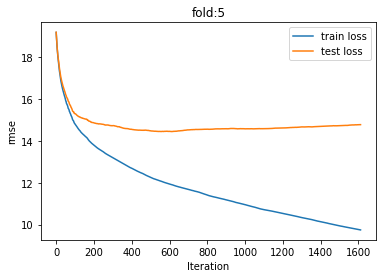

 - fold5_MAE : 14.440715
 - CV_MAE : 14.786700


In [ ]:
oof_valid_lgb_sub_printer, lgb_models_sub_printer = fit_lgb_oputuna(x=df_train_printer_x, y=df_train_printer_sub_y, cv=kf_cv,
                                      model_params=optuna_model_params, fit_params=oputuna_fit_params
                                     )

In [ ]:
#oof_valid_lgb_sub_printer, lgb_models_sub_printer
file_path = f'lgb_models_sub_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_sub_printer, f)

file_path = f'oof_valid_lgb_sub_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_sub_printer, f)


## 正味作業時間 ー グルア―　の学習

In [ ]:
"""
df_train_gluer_main = df_train_gluer.copy()
df_train_gluer_sub = df_train_gluer.copy()

df_main = df_train_gluer.drop(["付帯作業時間"], axis=1)
df_sub = df_train_gluer.drop(["正味作業時間"], axis=1)
df_train_gluer_corr = df_train_gluer.corr()
df_train_gluer_main_corr = df_main.corr()
df_train_gluer_sub_corr = df_sub.corr()
"""

In [ ]:
"""
df_train_gluer_main_corr_top20 = df_train_gluer_main_corr.loc[:, ['正味作業時間']].assign(abs_value=lambda d: np.abs(d['正味作業時間']))\
                    .sort_values('abs_value', ascending=False)\
                    .iloc[1:31, :].index.tolist()
df_train_gluer_main_corr_top20
"""

['数量1',
 '予備数量',
 '合計数量',
 '加工数量',
 '仕上数量',
 '受注数量',
 '営業担当者コード',
 '作業伝票チェックシート発行回数',
 '受注伝票発行回数',
 '実績数量',
 '版番号',
 '特練インキ発行年月日',
 '得意先子コード',
 '受注キャンセルフラグ',
 '部品仕様番号',
 '特練インキ発行回数',
 '受注キャンセル日',
 '頁数',
 '流用製品仕様コード',
 '納期詳細',
 '単位区分',
 '展開寸法厚さ',
 '作業伝票チェックシート発行年月日',
 '得意先親コード',
 '営業サンプル数量',
 '流用受注日',
 '作業伝票チェックシート発行済フラグ',
 '仕上寸法厚さ',
 '流用受注番号',
 '制作伝票発行回数']

In [ ]:
"""
tmp_list = df_train_gluer_main_corr_top20
tmp_list.append("正味作業時間")
tmp_top20  = df_train_gluer[tmp_list]
plt.figure(figsize=(16, 16))
tmp_top20_corr = tmp_top20.corr()
sns.heatmap(tmp_top20_corr, center=0)
"""

In [ ]:
"""
df_train_gluer_sub_corr_top20 = df_train_gluer_sub_corr.loc[:, ['付帯作業時間']].assign(abs_value=lambda d: np.abs(d['付帯作業時間']))\
                    .sort_values('abs_value', ascending=False)\
                    .iloc[1:31, :].index.tolist()
df_train_gluer_sub_corr_top20
"""

In [ ]:
df_main_gluer = df_train_gluer_main[df_train_gluer_main_corr_top20]
main_target = df_train_gluer[config.main_target]
kf_cv = list(kf.split(df_main_gluer))

In [ ]:
df_main_gluer

,数量1,予備数量,合計数量,加工数量,仕上数量,受注数量,営業担当者コード,作業伝票チェックシート発行回数,受注伝票発行回数,実績数量,版番号,特練インキ発行年月日,得意先子コード,受注キャンセルフラグ,部品仕様番号,特練インキ発行回数,受注キャンセル日,頁数,流用製品仕様コード,納期詳細,単位区分,展開寸法厚さ,作業伝票チェックシート発行年月日,得意先親コード,営業サンプル数量,流用受注日,作業伝票チェックシート発行済フラグ,仕上寸法厚さ,流用受注番号,制作伝票発行回数
333,2400.0,2400.0,2750.0,2400.0,2400.0,2400.0,3,1.0,17.0,0.0,14,42,2,1,1.0,0.0,181,1.0,204,5,0,0.0,30,4,10.0,178,1,0.0,536,0.0
341,3681.0,3681.0,4000.0,3691.0,3691.0,3571.0,6,0.0,24.0,0.0,14,42,1,1,1.0,0.0,181,0.0,39,1,2,0.0,1043,6,10.0,2,0,0.0,26,2.0
367,60000.0,60000.0,63000.0,60000.0,60000.0,60000.0,11,0.0,8.0,0.0,6,42,1,1,4.0,0.0,181,1.0,204,5,0,0.0,1043,20,5.0,178,0,0.0,536,0.0
375,2000.0,2000.0,2250.0,2000.0,2000.0,2000.0,12,0.0,19.0,0.0,14,42,4,1,1.0,0.0,181,1.0,204,5,4,0.0,1043,5,5.0,178,0,0.0,536,0.0
377,2000.0,2000.0,2300.0,2000.0,2000.0,2000.0,12,0.0,16.0,0.0,14,42,4,1,1.0,0.0,181,0.0,204,5,0,0.0,1043,5,5.0,178,0,0.0,536,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23244,2000.0,2000.0,2200.0,2000.0,2000.0,NaN,14,NaN,NaN,NaN,13,41,8,3,0.0,NaN,180,NaN,203,4,0,NaN,1042,28,NaN,177,2,NaN,535,NaN
23265,10000.0,10000.0,10600.0,10000.0,10000.0,NaN,14,NaN,NaN,NaN,13,41,8,3,0.0,NaN,180,NaN,203,4,0,NaN,1042,28,NaN,177,2,NaN,535,NaN
23274,3395.0,3395.0,3500.0,3025.0,3250.0,NaN,14,NaN,NaN,NaN,13,41,8,3,0.0,NaN,180,NaN,203,4,0,NaN,1042,28,NaN,177,2,NaN,535,NaN
23359,500.0,500.0,900.0,500.0,500.0,NaN,14,NaN,NaN,NaN,13,41,8,3,0.0,NaN,180,NaN,203,4,0,NaN,1042,28,NaN,177,2,NaN,535,NaN


[I 2022-12-17 18:37:14,385] A new study created in memory with name: no-name-267fcab2-7465-4c9d-8925-83a915104ba1


data_labels: ['作業日', '受注番号', '号機名', '号機コード', '数量1', '数量項目名1', '合計数量', '予備数量', '仕上数量', '連量', '加工数量', '台数', '製品仕様コード_x', 'カテゴリ名1', 'カテゴリ名2', '工程コード', '工程名', '部品区分', '部品区分名', '部品行番号', '部品仕様番号', '部品仕様コード', '表示順', '印刷前工程フラグ', '加工行番号', '加工順', '加工単位区分', '加工単位区分名', '協力会社親コード', '協力会社子コード', '協力会社コード', 'サイズ区分', 'サイズ区分名', 'サイズ幅', 'サイズ長さ', '抜型区分', '抜型区分名', 'ストリッパー区分', 'ストリッパー区分名', 'ブランキング区分', 'ブランキング区分名', '加工表裏指定区分', '加工表裏指定区分名', '単位区分_x', '単位区分名_x', '仕分区分', '仕分区分名', '間紙区分', '間紙区分名', '紙帯区分', '紙帯区分名', '予定組ラベルキー', '受注日', '製品仕様コード_y', '受注数量', '実績数量', '下版予定日', '流用受注番号', '流用受注日', '流用製品仕様コード', '頁数', 'キャンペーン番号', '受注キャンペーン番号', 'キャンペーンフラグ', '付合受注番号', '付合フラグ', '受注区分', '受注区分名', '納期', '納期詳細', '初回出荷日', '先方注文番号', '事業所親コード', '事業所子コード', '事業所コード', '部門コード', '営業担当者コード', '得意先親コード', '得意先子コード', '得意先コード', '版番号', 'ロット番号', '仕上寸法区分', '仕上寸法区分名', '仕上寸法幅', '仕上寸法長さ', '仕上寸法厚さ', '展開寸法区分', '展開寸法区分名', '展開寸法幅', '展開寸法長さ', '展開寸法厚さ', '製品区分', '製品区分名', 'リピート区分', 'リピート区分名', '仕様登録者コード', '単位区分_y', '単位区分名_y', '客先サンプル数量', '営業サンプル数量', '版区分', '

[I 2022-12-17 18:37:22,589] Trial 0 finished with value: 15.418884487518474 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 15.418884487518474.


Early stopping, best iteration is:
[733]	Train's l1: 9.82075	Test's l1: 15.4189
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:37:29,549] Trial 1 finished with value: 15.545433332084611 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 15.418884487518474.


Early stopping, best iteration is:
[465]	Train's l1: 11.082	Test's l1: 15.5454
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:37:35,961] Trial 2 finished with value: 15.463272716636503 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 15.418884487518474.


Early stopping, best iteration is:
[425]	Train's l1: 11.3114	Test's l1: 15.4633
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:37:39,497] Trial 3 finished with value: 15.310919539790502 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:37:44,458] Trial 4 finished with value: 15.397851477003673 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 15.310919539790502.


Early stopping, best iteration is:
[326]	Train's l1: 12.0145	Test's l1: 15.3979
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:37:50,317] Trial 5 finished with value: 15.408477933810957 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 15.310919539790502.


Early stopping, best iteration is:
[756]	Train's l1: 9.80423	Test's l1: 15.4085
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:37:55,869] Trial 6 finished with value: 15.375076980013274 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 15.310919539790502.


Early stopping, best iteration is:
[863]	Train's l1: 9.52632	Test's l1: 15.3751
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:37:59,535] Trial 7 finished with value: 15.310919539790502 and parameters: {'num_leaves': 96}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:03,125] Trial 8 finished with value: 15.310919539790502 and parameters: {'num_leaves': 40}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:06,868] Trial 9 finished with value: 15.310919539790502 and parameters: {'num_leaves': 178}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:10,540] Trial 10 finished with value: 15.310919539790502 and parameters: {'num_leaves': 135}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:14,258] Trial 11 finished with value: 15.310919539790502 and parameters: {'num_leaves': 124}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:17,930] Trial 12 finished with value: 15.310919539790502 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:21,520] Trial 13 finished with value: 15.310919539790502 and parameters: {'num_leaves': 69}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:25,238] Trial 14 finished with value: 15.310919539790502 and parameters: {'num_leaves': 158}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:28,712] Trial 15 finished with value: 15.407197425210786 and parameters: {'num_leaves': 25}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[388]	Train's l1: 11.908	Test's l1: 15.4072
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:32,377] Trial 16 finished with value: 15.310919539790502 and parameters: {'num_leaves': 35}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:36,050] Trial 17 finished with value: 15.310919539790502 and parameters: {'num_leaves': 253}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:39,646] Trial 18 finished with value: 15.310919539790502 and parameters: {'num_leaves': 81}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:43,207] Trial 19 finished with value: 15.310919539790502 and parameters: {'num_leaves': 73}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:45,165] Trial 20 finished with value: 15.889070008440697 and parameters: {'num_leaves': 7}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[662]	Train's l1: 13.2474	Test's l1: 15.8891
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:48,814] Trial 21 finished with value: 15.310919539790502 and parameters: {'num_leaves': 94}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:52,385] Trial 22 finished with value: 15.310919539790502 and parameters: {'num_leaves': 38}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:55,956] Trial 23 finished with value: 15.310919539790502 and parameters: {'num_leaves': 115}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:38:59,570] Trial 24 finished with value: 15.310919539790502 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:03,137] Trial 25 finished with value: 15.310919539790502 and parameters: {'num_leaves': 57}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:06,689] Trial 26 finished with value: 15.310919539790502 and parameters: {'num_leaves': 118}. Best is trial 7 with value: 15.310919539790502.


Early stopping, best iteration is:
[437]	Train's l1: 11.6261	Test's l1: 15.3109
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:10,590] Trial 27 finished with value: 15.427525987760498 and parameters: {'bagging_fraction': 0.6113641403490637, 'bagging_freq': 3}. Best is trial 27 with value: 15.427525987760498.


Early stopping, best iteration is:
[1071]	Train's l1: 10.9648	Test's l1: 15.4275
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:14,874] Trial 28 finished with value: 15.575504019466093 and parameters: {'bagging_fraction': 0.8700777163976001, 'bagging_freq': 2}. Best is trial 27 with value: 15.427525987760498.


Early stopping, best iteration is:
[596]	Train's l1: 11.18	Test's l1: 15.5755
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:19,752] Trial 29 finished with value: 15.489780594483546 and parameters: {'bagging_fraction': 0.7529797373181594, 'bagging_freq': 7}. Best is trial 27 with value: 15.427525987760498.


Early stopping, best iteration is:
[1190]	Train's l1: 9.85651	Test's l1: 15.4898
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:24,192] Trial 30 finished with value: 15.55121156179863 and parameters: {'bagging_fraction': 0.7279920034847511, 'bagging_freq': 5}. Best is trial 27 with value: 15.427525987760498.


Early stopping, best iteration is:
[1000]	Train's l1: 10.5363	Test's l1: 15.5512
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:28,462] Trial 31 finished with value: 15.522268752654883 and parameters: {'bagging_fraction': 0.6675556853278386, 'bagging_freq': 5}. Best is trial 27 with value: 15.427525987760498.


Early stopping, best iteration is:
[1060]	Train's l1: 10.7045	Test's l1: 15.5223
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:32,374] Trial 32 finished with value: 15.435100707532381 and parameters: {'bagging_fraction': 0.626386227246099, 'bagging_freq': 2}. Best is trial 27 with value: 15.427525987760498.


Early stopping, best iteration is:
[984]	Train's l1: 11.0826	Test's l1: 15.4351
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:36,959] Trial 33 finished with value: 15.453315831093734 and parameters: {'bagging_fraction': 0.9260270201267862, 'bagging_freq': 6}. Best is trial 27 with value: 15.427525987760498.


Early stopping, best iteration is:
[723]	Train's l1: 10.4729	Test's l1: 15.4533
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:40,851] Trial 34 finished with value: 15.453708390060582 and parameters: {'bagging_fraction': 0.6816110446848141, 'bagging_freq': 2}. Best is trial 27 with value: 15.427525987760498.


Early stopping, best iteration is:
[794]	Train's l1: 11.4239	Test's l1: 15.4537
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:47,728] Trial 35 finished with value: 15.432281122927222 and parameters: {'bagging_fraction': 0.5824125988726656, 'bagging_freq': 7}. Best is trial 27 with value: 15.427525987760498.


Early stopping, best iteration is:
[1190]	Train's l1: 10.9212	Test's l1: 15.4323
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:51,445] Trial 36 finished with value: 15.30416722285869 and parameters: {'bagging_fraction': 0.9512737709755997, 'bagging_freq': 7}. Best is trial 36 with value: 15.30416722285869.


Early stopping, best iteration is:
[371]	Train's l1: 12.0816	Test's l1: 15.3042
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:39:55,354] Trial 37 finished with value: 15.314183300414065 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 15.314183300414065.


Early stopping, best iteration is:
[328]	Train's l1: 12.3172	Test's l1: 15.3142
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:00,148] Trial 38 finished with value: 15.280210272821149 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 38 with value: 15.280210272821149.


Early stopping, best iteration is:
[649]	Train's l1: 10.6247	Test's l1: 15.2802
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:04,187] Trial 39 finished with value: 15.350457852853674 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 38 with value: 15.280210272821149.


Early stopping, best iteration is:
[323]	Train's l1: 12.29	Test's l1: 15.3505
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:07,881] Trial 40 finished with value: 15.31343582196687 and parameters: {'lambda_l1': 0.1183035106765414, 'lambda_l2': 3.5232916236657517e-07}. Best is trial 40 with value: 15.31343582196687.


Early stopping, best iteration is:
[322]	Train's l1: 12.3035	Test's l1: 15.3134
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:11,604] Trial 41 finished with value: 15.330656635951147 and parameters: {'lambda_l1': 1.5687390015253981, 'lambda_l2': 0.006955519892788254}. Best is trial 40 with value: 15.31343582196687.


Early stopping, best iteration is:
[322]	Train's l1: 12.3174	Test's l1: 15.3307
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:15,658] Trial 42 finished with value: 15.360658983839842 and parameters: {'lambda_l1': 0.033424084400888544, 'lambda_l2': 3.626530005411909e-06}. Best is trial 40 with value: 15.31343582196687.


Early stopping, best iteration is:
[434]	Train's l1: 11.666	Test's l1: 15.3607
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:20,436] Trial 43 finished with value: 15.280209788660498 and parameters: {'lambda_l1': 0.0010477217502473913, 'lambda_l2': 2.91843906100485e-06}. Best is trial 43 with value: 15.280209788660498.


Early stopping, best iteration is:
[649]	Train's l1: 10.6247	Test's l1: 15.2802
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:25,067] Trial 44 finished with value: 15.280210115740053 and parameters: {'lambda_l1': 0.0003441465624779377, 'lambda_l2': 2.7017783259919744e-08}. Best is trial 43 with value: 15.280209788660498.


Early stopping, best iteration is:
[649]	Train's l1: 10.6247	Test's l1: 15.2802
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:29,834] Trial 45 finished with value: 15.280209479864098 and parameters: {'lambda_l1': 0.0013759394593414796, 'lambda_l2': 0.0001514182874301415}. Best is trial 45 with value: 15.280209479864098.


Early stopping, best iteration is:
[649]	Train's l1: 10.6247	Test's l1: 15.2802
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:34,470] Trial 46 finished with value: 15.280207976752386 and parameters: {'lambda_l1': 0.0046660726191583915, 'lambda_l2': 3.0414749679460478e-05}. Best is trial 46 with value: 15.280207976752386.


Early stopping, best iteration is:
[649]	Train's l1: 10.6248	Test's l1: 15.2802
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:39,158] Trial 47 finished with value: 15.280209571787458 and parameters: {'lambda_l1': 0.0015127247461709055, 'lambda_l2': 1.2102577672436579e-05}. Best is trial 46 with value: 15.280207976752386.


Early stopping, best iteration is:
[649]	Train's l1: 10.6247	Test's l1: 15.2802
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:43,820] Trial 48 finished with value: 15.332220487062475 and parameters: {'lambda_l1': 4.705036008599053, 'lambda_l2': 3.245408125110654e-08}. Best is trial 46 with value: 15.280207976752386.


Early stopping, best iteration is:
[648]	Train's l1: 10.667	Test's l1: 15.3322
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:48,524] Trial 49 finished with value: 15.315735729850521 and parameters: {'lambda_l1': 1.6057501063334123e-05, 'lambda_l2': 0.059585770778090574}. Best is trial 46 with value: 15.280207976752386.


Early stopping, best iteration is:
[645]	Train's l1: 10.6479	Test's l1: 15.3157
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:53,123] Trial 50 finished with value: 15.280208523832956 and parameters: {'lambda_l1': 2.3154631876670203e-08, 'lambda_l2': 0.0016016110350473743}. Best is trial 46 with value: 15.280207976752386.


Early stopping, best iteration is:
[649]	Train's l1: 10.6248	Test's l1: 15.2802
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:40:57,324] Trial 51 finished with value: 15.305651612345304 and parameters: {'lambda_l1': 1.5640103723321025e-08, 'lambda_l2': 1.7415414987810962}. Best is trial 46 with value: 15.280207976752386.


Early stopping, best iteration is:
[489]	Train's l1: 11.4067	Test's l1: 15.3057
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:01,891] Trial 52 finished with value: 15.280209783372348 and parameters: {'lambda_l1': 1.6338143373527805e-06, 'lambda_l2': 0.0004497144893314512}. Best is trial 46 with value: 15.280207976752386.


Early stopping, best iteration is:
[649]	Train's l1: 10.6247	Test's l1: 15.2802
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:06,608] Trial 53 finished with value: 15.280209294071945 and parameters: {'lambda_l1': 1.0777649237394757e-08, 'lambda_l2': 0.0008946192293549963}. Best is trial 46 with value: 15.280207976752386.


Early stopping, best iteration is:
[649]	Train's l1: 10.6247	Test's l1: 15.2802
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:10,813] Trial 54 finished with value: 15.277303480814677 and parameters: {'lambda_l1': 2.242958056156925e-06, 'lambda_l2': 0.07927059795499791}. Best is trial 54 with value: 15.277303480814677.


Early stopping, best iteration is:
[489]	Train's l1: 11.413	Test's l1: 15.2773
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:14,945] Trial 55 finished with value: 15.259457726884207 and parameters: {'lambda_l1': 5.5294099641305406e-06, 'lambda_l2': 5.7041682368447475}. Best is trial 55 with value: 15.259457726884207.


Early stopping, best iteration is:
[489]	Train's l1: 11.5138	Test's l1: 15.2595
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:19,424] Trial 56 finished with value: 15.196038819178805 and parameters: {'lambda_l1': 5.374561751417487e-06, 'lambda_l2': 8.323881742376749}. Best is trial 56 with value: 15.196038819178805.


Early stopping, best iteration is:
[649]	Train's l1: 10.8381	Test's l1: 15.196
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:24,516] Trial 57 finished with value: 15.277290392674812 and parameters: {'lambda_l1': 3.4341119698453096e-05, 'lambda_l2': 1.6394630028764539}. Best is trial 56 with value: 15.196038819178805.


Early stopping, best iteration is:
[785]	Train's l1: 10.1226	Test's l1: 15.2773
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:29,110] Trial 58 finished with value: 15.23273865517001 and parameters: {'lambda_l1': 3.1325226118158176e-07, 'lambda_l2': 5.849360779314133}. Best is trial 56 with value: 15.196038819178805.


Early stopping, best iteration is:
[648]	Train's l1: 10.7476	Test's l1: 15.2327
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:32,970] Trial 59 finished with value: 15.313285441387636 and parameters: {'lambda_l1': 2.0510101369798514e-07, 'lambda_l2': 0.07256772543915684}. Best is trial 56 with value: 15.196038819178805.


Early stopping, best iteration is:
[368]	Train's l1: 12.0049	Test's l1: 15.3133
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:37,536] Trial 60 finished with value: 15.196038819178805 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 15.196038819178805.


Early stopping, best iteration is:
[649]	Train's l1: 10.8381	Test's l1: 15.196
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:42,092] Trial 61 finished with value: 15.196038819178805 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 15.196038819178805.


Early stopping, best iteration is:
[649]	Train's l1: 10.8381	Test's l1: 15.196
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:46,715] Trial 62 finished with value: 15.196038819178805 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 15.196038819178805.


Early stopping, best iteration is:
[649]	Train's l1: 10.8381	Test's l1: 15.196
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:51,377] Trial 63 finished with value: 15.196038819178805 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 15.196038819178805.


Early stopping, best iteration is:
[649]	Train's l1: 10.8381	Test's l1: 15.196
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:41:55,904] Trial 64 finished with value: 15.196038819178805 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 15.196038819178805.


Early stopping, best iteration is:
[649]	Train's l1: 10.8381	Test's l1: 15.196
▼▼▼▼▼　　　　　Fold 1　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 5.374561751417487e-06, 'lambda_l2': 8.323881742376749, 'num_leaves': 31, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 0.9512737709755997, 'bagging_freq': 7, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


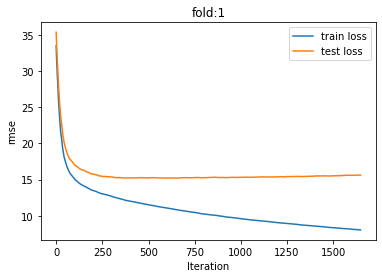

 - fold1_MAE : 15.196039


[I 2022-12-17 18:41:56,498] A new study created in memory with name: no-name-933fbfa9-3c38-4a10-8229-83f8b70f1363



★★★★★　　　　　Fold 2　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1279]	Train's l1: 8.61475	Test's l1: 14.4685


[I 2022-12-17 18:42:07,711] Trial 0 finished with value: 14.468452418402386 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 14.468452418402386.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:42:17,493] Trial 1 finished with value: 14.258883524723965 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1166]	Train's l1: 8.85577	Test's l1: 14.3816


[I 2022-12-17 18:42:26,452] Trial 2 finished with value: 14.381618680800287 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:42:33,926] Trial 3 finished with value: 14.263480155549335 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 14.258883524723965.


Early stopping, best iteration is:
[979]	Train's l1: 9.40197	Test's l1: 14.2635
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1238]	Train's l1: 8.79316	Test's l1: 14.3642


[I 2022-12-17 18:42:40,629] Trial 4 finished with value: 14.364156831786472 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:42:46,645] Trial 5 finished with value: 14.318249371511238 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 14.258883524723965.


Early stopping, best iteration is:
[769]	Train's l1: 10.1476	Test's l1: 14.3182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:42:54,682] Trial 6 finished with value: 14.482564142043431 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 14.258883524723965.


Early stopping, best iteration is:
[929]	Train's l1: 9.80829	Test's l1: 14.4826
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:43:04,563] Trial 7 finished with value: 14.258883524723965 and parameters: {'num_leaves': 119}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:43:14,353] Trial 8 finished with value: 14.258883524723965 and parameters: {'num_leaves': 136}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:43:24,199] Trial 9 finished with value: 14.258883524723965 and parameters: {'num_leaves': 35}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:43:34,157] Trial 10 finished with value: 14.258883524723965 and parameters: {'num_leaves': 166}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:43:44,019] Trial 11 finished with value: 14.258883524723965 and parameters: {'num_leaves': 90}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:43:53,870] Trial 12 finished with value: 14.258883524723965 and parameters: {'num_leaves': 240}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:44:03,395] Trial 13 finished with value: 14.258883524723965 and parameters: {'num_leaves': 174}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:44:09,261] Trial 14 finished with value: 14.278522289450121 and parameters: {'num_leaves': 12}. Best is trial 7 with value: 14.258883524723965.


Early stopping, best iteration is:
[1123]	Train's l1: 10.8535	Test's l1: 14.2785
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:44:18,912] Trial 15 finished with value: 14.258883524723965 and parameters: {'num_leaves': 217}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:44:28,717] Trial 16 finished with value: 14.258883524723965 and parameters: {'num_leaves': 186}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:44:38,398] Trial 17 finished with value: 14.258883524723965 and parameters: {'num_leaves': 81}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:44:48,282] Trial 18 finished with value: 14.258883524723965 and parameters: {'num_leaves': 120}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:44:58,200] Trial 19 finished with value: 14.258883524723965 and parameters: {'num_leaves': 129}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:45:08,106] Trial 20 finished with value: 14.258883524723965 and parameters: {'num_leaves': 79}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:45:18,047] Trial 21 finished with value: 14.258883524723965 and parameters: {'num_leaves': 150}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:45:27,778] Trial 22 finished with value: 14.258883524723965 and parameters: {'num_leaves': 103}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:45:37,583] Trial 23 finished with value: 14.258883524723965 and parameters: {'num_leaves': 54}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:45:47,453] Trial 24 finished with value: 14.258883524723965 and parameters: {'num_leaves': 151}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:46:00,400] Trial 25 finished with value: 14.258883524723965 and parameters: {'num_leaves': 114}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:46:10,089] Trial 26 finished with value: 14.258883524723965 and parameters: {'num_leaves': 47}. Best is trial 7 with value: 14.258883524723965.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:46:16,180] Trial 27 finished with value: 14.754427612076745 and parameters: {'bagging_fraction': 0.6496310171302104, 'bagging_freq': 7}. Best is trial 27 with value: 14.754427612076745.


Early stopping, best iteration is:
[895]	Train's l1: 11.3714	Test's l1: 14.7544
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:46:22,996] Trial 28 finished with value: 14.601577697340907 and parameters: {'bagging_fraction': 0.5768740456243131, 'bagging_freq': 4}. Best is trial 28 with value: 14.601577697340907.


Early stopping, best iteration is:
[1436]	Train's l1: 10.4203	Test's l1: 14.6016
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:46:28,010] Trial 29 finished with value: 14.637470014442894 and parameters: {'bagging_fraction': 0.6089764872861634, 'bagging_freq': 2}. Best is trial 28 with value: 14.601577697340907.


Early stopping, best iteration is:
[660]	Train's l1: 12.2053	Test's l1: 14.6375
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:46:37,181] Trial 30 finished with value: 14.427593142369368 and parameters: {'bagging_fraction': 0.9543863664975646, 'bagging_freq': 3}. Best is trial 30 with value: 14.427593142369368.


Early stopping, best iteration is:
[945]	Train's l1: 9.65825	Test's l1: 14.4276
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:46:43,946] Trial 31 finished with value: 14.528855875435125 and parameters: {'bagging_fraction': 0.5655207570382336, 'bagging_freq': 4}. Best is trial 30 with value: 14.427593142369368.


Early stopping, best iteration is:
[1375]	Train's l1: 10.5648	Test's l1: 14.5289
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:46:49,621] Trial 32 finished with value: 14.638289510917238 and parameters: {'bagging_fraction': 0.557067649481976, 'bagging_freq': 3}. Best is trial 30 with value: 14.427593142369368.


Early stopping, best iteration is:
[1035]	Train's l1: 11.3498	Test's l1: 14.6383
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1062]	Train's l1: 9.28145	Test's l1: 14.4855


[I 2022-12-17 18:46:59,490] Trial 33 finished with value: 14.48548795993307 and parameters: {'bagging_fraction': 0.9641105209012508, 'bagging_freq': 4}. Best is trial 30 with value: 14.427593142369368.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:47:07,143] Trial 34 finished with value: 14.397678948156914 and parameters: {'bagging_fraction': 0.9008217822275585, 'bagging_freq': 5}. Best is trial 34 with value: 14.397678948156914.


Early stopping, best iteration is:
[735]	Train's l1: 10.5805	Test's l1: 14.3977
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:47:14,904] Trial 35 finished with value: 14.47313924057268 and parameters: {'bagging_fraction': 0.8392425630489604, 'bagging_freq': 4}. Best is trial 34 with value: 14.397678948156914.


Early stopping, best iteration is:
[871]	Train's l1: 10.3646	Test's l1: 14.4731
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:47:22,618] Trial 36 finished with value: 14.435203642846316 and parameters: {'bagging_fraction': 0.7204014864694022, 'bagging_freq': 3}. Best is trial 34 with value: 14.397678948156914.


Early stopping, best iteration is:
[1173]	Train's l1: 10.1246	Test's l1: 14.4352
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1144]	Train's l1: 8.93686	Test's l1: 14.3284


[I 2022-12-17 18:47:31,722] Trial 37 finished with value: 14.328354618955489 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 14.328354618955489.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:47:40,958] Trial 38 finished with value: 14.33290869761112 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 14.328354618955489.


Early stopping, best iteration is:
[1042]	Train's l1: 9.25865	Test's l1: 14.3329
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:47:50,439] Trial 39 finished with value: 14.369095847067452 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 14.328354618955489.


Early stopping, best iteration is:
[1024]	Train's l1: 9.31224	Test's l1: 14.3691
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1081]	Train's l1: 9.10858	Test's l1: 14.369


[I 2022-12-17 18:47:59,371] Trial 40 finished with value: 14.36895788560852 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 14.328354618955489.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1035]	Train's l1: 9.31172	Test's l1: 14.4742


[I 2022-12-17 18:48:09,359] Trial 41 finished with value: 14.474151202132814 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 14.328354618955489.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1090]	Train's l1: 9.14982	Test's l1: 14.4207


[I 2022-12-17 18:48:18,926] Trial 42 finished with value: 14.420665999629696 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 14.328354618955489.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:48:28,801] Trial 43 finished with value: 14.258883517650224 and parameters: {'lambda_l1': 5.471800678142832e-06, 'lambda_l2': 1.0476586858966567e-08}. Best is trial 43 with value: 14.258883517650224.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:48:38,481] Trial 44 finished with value: 14.258883242182224 and parameters: {'lambda_l1': 1.206526227061634e-06, 'lambda_l2': 8.572891913745738e-05}. Best is trial 44 with value: 14.258883242182224.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1166]	Train's l1: 8.9582	Test's l1: 14.4048


[I 2022-12-17 18:48:48,105] Trial 45 finished with value: 14.40480439153341 and parameters: {'lambda_l1': 0.009099097365737859, 'lambda_l2': 3.4331434320029355}. Best is trial 44 with value: 14.258883242182224.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1045]	Train's l1: 9.2877	Test's l1: 14.4606


[I 2022-12-17 18:48:57,085] Trial 46 finished with value: 14.460603725478798 and parameters: {'lambda_l1': 3.4032679206241006, 'lambda_l2': 0.08096404769459489}. Best is trial 44 with value: 14.258883242182224.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:49:09,989] Trial 47 finished with value: 14.25888352404017 and parameters: {'lambda_l1': 9.334235448696548e-08, 'lambda_l2': 2.4874646851097405e-07}. Best is trial 44 with value: 14.258883242182224.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1065]	Train's l1: 9.18146	Test's l1: 14.3042


[I 2022-12-17 18:49:19,484] Trial 48 finished with value: 14.304212612007772 and parameters: {'lambda_l1': 0.03531772650193633, 'lambda_l2': 3.194588929277105e-07}. Best is trial 44 with value: 14.258883242182224.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 18:49:28,575] Trial 49 finished with value: 14.318395669253453 and parameters: {'lambda_l1': 0.0023532586768586394, 'lambda_l2': 1.502279533196996e-06}. Best is trial 44 with value: 14.258883242182224.


Early stopping, best iteration is:
[985]	Train's l1: 9.44818	Test's l1: 14.3184
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:49:38,388] Trial 50 finished with value: 14.258883519596068 and parameters: {'lambda_l1': 8.495097925325207e-08, 'lambda_l2': 1.740496666547263e-06}. Best is trial 44 with value: 14.258883242182224.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1074]	Train's l1: 9.17373	Test's l1: 14.3147


[I 2022-12-17 18:49:47,940] Trial 51 finished with value: 14.314670419560166 and parameters: {'lambda_l1': 0.014772250221368357, 'lambda_l2': 5.2388954372220495e-08}. Best is trial 44 with value: 14.258883242182224.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1058]	Train's l1: 9.20291	Test's l1: 14.4282


[I 2022-12-17 18:49:57,573] Trial 52 finished with value: 14.428200655450294 and parameters: {'lambda_l1': 7.930891297424259e-05, 'lambda_l2': 1.0004359887392424}. Best is trial 44 with value: 14.258883242182224.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95423	Test's l1: 14.2589


[I 2022-12-17 18:50:07,516] Trial 53 finished with value: 14.258880662799477 and parameters: {'lambda_l1': 7.290981774746889e-07, 'lambda_l2': 0.0008829516886441529}. Best is trial 53 with value: 14.258880662799477.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95422	Test's l1: 14.2589


[I 2022-12-17 18:50:17,448] Trial 54 finished with value: 14.258881589656193 and parameters: {'lambda_l1': 3.2837750648954184e-06, 'lambda_l2': 0.0005956390227824687}. Best is trial 53 with value: 14.258880662799477.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95425	Test's l1: 14.2589


[I 2022-12-17 18:50:27,495] Trial 55 finished with value: 14.258876494823824 and parameters: {'lambda_l1': 2.163083585120536e-05, 'lambda_l2': 0.002161506662151344}. Best is trial 55 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1078]	Train's l1: 9.18614	Test's l1: 14.2832


[I 2022-12-17 18:50:37,001] Trial 56 finished with value: 14.283211992972994 and parameters: {'lambda_l1': 1.0370187182120625e-08, 'lambda_l2': 0.003350977376626404}. Best is trial 55 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1099]	Train's l1: 9.07074	Test's l1: 14.3588


[I 2022-12-17 18:50:46,565] Trial 57 finished with value: 14.35876170928983 and parameters: {'lambda_l1': 8.48317214837142e-05, 'lambda_l2': 0.021886126745910957}. Best is trial 55 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95421	Test's l1: 14.2589


[I 2022-12-17 18:50:56,529] Trial 58 finished with value: 14.258883435281497 and parameters: {'lambda_l1': 2.0051772925745846e-05, 'lambda_l2': 2.031898684123788e-05}. Best is trial 55 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95424	Test's l1: 14.2589


[I 2022-12-17 18:51:06,469] Trial 59 finished with value: 14.258878198945975 and parameters: {'lambda_l1': 0.0005044088243008815, 'lambda_l2': 0.0014373354887295838}. Best is trial 55 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1030]	Train's l1: 9.30654	Test's l1: 14.2812


[I 2022-12-17 18:51:15,958] Trial 60 finished with value: 14.281236534624544 and parameters: {'lambda_l1': 0.0005438121804643712, 'lambda_l2': 0.01693950211412821}. Best is trial 55 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1083]	Train's l1: 9.14178	Test's l1: 14.3248


[I 2022-12-17 18:51:25,606] Trial 61 finished with value: 14.324812841263526 and parameters: {'lambda_l1': 0.4490044628415374, 'lambda_l2': 3.32456694404776e-05}. Best is trial 55 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1225]	Train's l1: 8.73623	Test's l1: 14.3153


[I 2022-12-17 18:51:35,929] Trial 62 finished with value: 14.315343339426953 and parameters: {'lambda_l1': 0.0007416545587839509, 'lambda_l2': 0.4328698958267472}. Best is trial 55 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95425	Test's l1: 14.2589


[I 2022-12-17 18:51:45,870] Trial 63 finished with value: 14.258876494823824 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95425	Test's l1: 14.2589


[I 2022-12-17 18:51:55,802] Trial 64 finished with value: 14.258876494823824 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95425	Test's l1: 14.2589


[I 2022-12-17 18:52:08,824] Trial 65 finished with value: 14.258876494823824 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95425	Test's l1: 14.2589


[I 2022-12-17 18:52:18,818] Trial 66 finished with value: 14.258876494823824 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 14.258876494823824.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	Train's l1: 8.95425	Test's l1: 14.2589


[I 2022-12-17 18:52:28,795] Trial 67 finished with value: 14.258876494823824 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 14.258876494823824.


▼▼▼▼▼　　　　　Fold 2　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 2.163083585120536e-05, 'lambda_l2': 0.002161506662151344, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


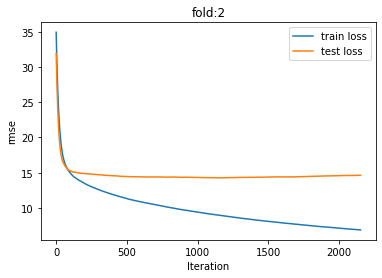

 - fold2_MAE : 14.258876


[I 2022-12-17 18:52:29,852] A new study created in memory with name: no-name-60fc2ea0-4635-41ba-a70f-fa673017944d



★★★★★　　　　　Fold 3　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1200]	Train's l1: 8.01797	Test's l1: 16.2019


[I 2022-12-17 18:52:36,317] Trial 0 finished with value: 16.201857029299855 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 16.201857029299855.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1155]	Train's l1: 8.13103	Test's l1: 16.1385


[I 2022-12-17 18:52:43,595] Trial 1 finished with value: 16.138484635088705 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 16.138484635088705.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1283]	Train's l1: 7.91135	Test's l1: 16.2311


[I 2022-12-17 18:52:49,277] Trial 2 finished with value: 16.231064820536947 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 16.138484635088705.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1361]	Train's l1: 7.51232	Test's l1: 15.9328


[I 2022-12-17 18:52:59,884] Trial 3 finished with value: 15.932811981184614 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 15.932811981184614.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:53:10,697] Trial 4 finished with value: 15.90409676609543 and parameters: {'feature_fraction': 1.0}. Best is trial 4 with value: 15.90409676609543.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1317]	Train's l1: 7.6241	Test's l1: 16.0903


[I 2022-12-17 18:53:19,272] Trial 5 finished with value: 16.09030210615283 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 15.90409676609543.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1200]	Train's l1: 7.92132	Test's l1: 16.1278


[I 2022-12-17 18:53:28,110] Trial 6 finished with value: 16.12775504884684 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 15.90409676609543.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:53:38,884] Trial 7 finished with value: 15.90409676609543 and parameters: {'num_leaves': 146}. Best is trial 7 with value: 15.90409676609543.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:53:49,827] Trial 8 finished with value: 15.90409676609543 and parameters: {'num_leaves': 134}. Best is trial 7 with value: 15.90409676609543.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:54:00,515] Trial 9 finished with value: 15.90409676609543 and parameters: {'num_leaves': 196}. Best is trial 7 with value: 15.90409676609543.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1142]	Train's l1: 8.16291	Test's l1: 15.8657


[I 2022-12-17 18:54:10,336] Trial 10 finished with value: 15.865726198204884 and parameters: {'num_leaves': 23}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:54:20,963] Trial 11 finished with value: 15.90409676609543 and parameters: {'num_leaves': 144}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:54:31,503] Trial 12 finished with value: 15.90409676609543 and parameters: {'num_leaves': 114}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:54:42,127] Trial 13 finished with value: 15.90409676609543 and parameters: {'num_leaves': 162}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:54:52,820] Trial 14 finished with value: 15.90409676609543 and parameters: {'num_leaves': 175}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:55:03,461] Trial 15 finished with value: 15.90409676609543 and parameters: {'num_leaves': 42}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:55:17,228] Trial 16 finished with value: 15.90409676609543 and parameters: {'num_leaves': 52}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 9.55464	Test's l1: 16.2578


[I 2022-12-17 18:55:25,491] Trial 17 finished with value: 16.25777670729528 and parameters: {'num_leaves': 5}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:55:36,294] Trial 18 finished with value: 15.90409676609543 and parameters: {'num_leaves': 249}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:55:46,947] Trial 19 finished with value: 15.90409676609543 and parameters: {'num_leaves': 86}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:55:57,759] Trial 20 finished with value: 15.90409676609543 and parameters: {'num_leaves': 212}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:56:08,473] Trial 21 finished with value: 15.90409676609543 and parameters: {'num_leaves': 96}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3237]	Train's l1: 7.83743	Test's l1: 15.9194


[I 2022-12-17 18:56:19,476] Trial 22 finished with value: 15.919358684882127 and parameters: {'num_leaves': 10}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:56:30,120] Trial 23 finished with value: 15.90409676609543 and parameters: {'num_leaves': 64}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:56:40,569] Trial 24 finished with value: 15.90409676609543 and parameters: {'num_leaves': 117}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:56:51,235] Trial 25 finished with value: 15.90409676609543 and parameters: {'num_leaves': 252}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1284]	Train's l1: 7.72057	Test's l1: 15.9041


[I 2022-12-17 18:57:01,672] Trial 26 finished with value: 15.90409676609543 and parameters: {'num_leaves': 30}. Best is trial 10 with value: 15.865726198204884.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1618]	Train's l1: 7.60196	Test's l1: 15.8853


[I 2022-12-17 18:57:13,100] Trial 27 finished with value: 15.885272921823422 and parameters: {'bagging_fraction': 0.8608603136158735, 'bagging_freq': 2}. Best is trial 27 with value: 15.885272921823422.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3951]	Train's l1: 7.66718	Test's l1: 16.0508


[I 2022-12-17 18:57:25,578] Trial 28 finished with value: 16.050759852137844 and parameters: {'bagging_fraction': 0.5071947298330125, 'bagging_freq': 3}. Best is trial 27 with value: 15.885272921823422.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1661]	Train's l1: 7.06376	Test's l1: 16.0267


[I 2022-12-17 18:57:38,143] Trial 29 finished with value: 16.02669167874196 and parameters: {'bagging_fraction': 0.9706716230710557, 'bagging_freq': 4}. Best is trial 27 with value: 15.885272921823422.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[4991]	Train's l1: 7.51821	Test's l1: 16.3424


[I 2022-12-17 18:57:50,129] Trial 30 finished with value: 16.342421687646425 and parameters: {'bagging_fraction': 0.45149907063050787, 'bagging_freq': 1}. Best is trial 27 with value: 15.885272921823422.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[4991]	Train's l1: 8.08357	Test's l1: 16.983


[I 2022-12-17 18:58:00,453] Trial 31 finished with value: 16.982986998234892 and parameters: {'bagging_fraction': 0.4201440079177908, 'bagging_freq': 7}. Best is trial 27 with value: 15.885272921823422.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 18:58:15,203] Trial 32 finished with value: 15.772204660150088 and parameters: {'bagging_fraction': 0.5488354069377698, 'bagging_freq': 3}. Best is trial 32 with value: 15.772204660150088.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2859]	Train's l1: 6.79483	Test's l1: 15.952


[I 2022-12-17 18:58:29,279] Trial 33 finished with value: 15.952036382698187 and parameters: {'bagging_fraction': 0.7202775517961852, 'bagging_freq': 4}. Best is trial 32 with value: 15.772204660150088.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2149]	Train's l1: 7.90374	Test's l1: 16.0648


[I 2022-12-17 18:58:40,590] Trial 34 finished with value: 16.06475655793556 and parameters: {'bagging_fraction': 0.6958537494330634, 'bagging_freq': 7}. Best is trial 32 with value: 15.772204660150088.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2855]	Train's l1: 7.43807	Test's l1: 15.886


[I 2022-12-17 18:58:53,097] Trial 35 finished with value: 15.885978027369633 and parameters: {'bagging_fraction': 0.6334482851106602, 'bagging_freq': 4}. Best is trial 32 with value: 15.772204660150088.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1378]	Train's l1: 8.0836	Test's l1: 15.8793


[I 2022-12-17 18:59:03,659] Trial 36 finished with value: 15.87931082345704 and parameters: {'bagging_fraction': 0.8567198777999174, 'bagging_freq': 2}. Best is trial 32 with value: 15.772204660150088.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2655]	Train's l1: 8.25631	Test's l1: 15.9643


[I 2022-12-17 18:59:13,811] Trial 37 finished with value: 15.96432391583032 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 15.96432391583032.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2655]	Train's l1: 8.25128	Test's l1: 15.9565


[I 2022-12-17 18:59:24,043] Trial 38 finished with value: 15.956523645278386 and parameters: {'feature_fraction': 0.92}. Best is trial 38 with value: 15.956523645278386.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3228]	Train's l1: 7.76221	Test's l1: 15.9422


[I 2022-12-17 18:59:36,280] Trial 39 finished with value: 15.942183328803694 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 39 with value: 15.942183328803694.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3228]	Train's l1: 7.78703	Test's l1: 15.8582


[I 2022-12-17 18:59:48,411] Trial 40 finished with value: 15.858196774990452 and parameters: {'lambda_l1': 5.230456009181185e-07, 'lambda_l2': 0.0034569431156646325}. Best is trial 40 with value: 15.858196774990452.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:00:00,881] Trial 41 finished with value: 15.772204738333812 and parameters: {'lambda_l1': 1.7948780430185486e-06, 'lambda_l2': 2.660328423258656e-05}. Best is trial 41 with value: 15.772204738333812.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3239]	Train's l1: 7.77681	Test's l1: 15.7846


[I 2022-12-17 19:00:13,114] Trial 42 finished with value: 15.784557420130202 and parameters: {'lambda_l1': 0.015139326131455922, 'lambda_l2': 5.45855805093422e-06}. Best is trial 41 with value: 15.772204738333812.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68592	Test's l1: 15.7806


[I 2022-12-17 19:00:25,498] Trial 43 finished with value: 15.78059100595023 and parameters: {'lambda_l1': 0.0033665505726195176, 'lambda_l2': 3.225121356864148e-08}. Best is trial 41 with value: 15.772204738333812.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2649]	Train's l1: 8.49024	Test's l1: 15.9102


[I 2022-12-17 19:00:35,605] Trial 44 finished with value: 15.910230075865877 and parameters: {'lambda_l1': 3.3807780082739463, 'lambda_l2': 9.609157330184237}. Best is trial 41 with value: 15.772204738333812.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:00:47,955] Trial 45 finished with value: 15.772204661084821 and parameters: {'lambda_l1': 4.113246569295555e-07, 'lambda_l2': 8.411551184440251e-08}. Best is trial 45 with value: 15.772204661084821.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68856	Test's l1: 15.7759


[I 2022-12-17 19:01:00,413] Trial 46 finished with value: 15.775890605214167 and parameters: {'lambda_l1': 0.002974459722029621, 'lambda_l2': 2.062700699921029e-06}. Best is trial 45 with value: 15.772204661084821.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:01:13,564] Trial 47 finished with value: 15.772204661057364 and parameters: {'lambda_l1': 2.737600169643999e-07, 'lambda_l2': 1.2914478998123567e-07}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3232]	Train's l1: 7.75979	Test's l1: 15.9497


[I 2022-12-17 19:01:28,039] Trial 48 finished with value: 15.949665076143761 and parameters: {'lambda_l1': 0.003441269145717278, 'lambda_l2': 0.26816835875237993}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3228]	Train's l1: 7.76257	Test's l1: 15.9186


[I 2022-12-17 19:01:39,982] Trial 49 finished with value: 15.918624562651285 and parameters: {'lambda_l1': 0.03629578632717281, 'lambda_l2': 7.06218283522948e-05}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2655]	Train's l1: 8.34181	Test's l1: 15.9


[I 2022-12-17 19:01:50,424] Trial 50 finished with value: 15.90004703072101 and parameters: {'lambda_l1': 2.1946523121197826e-08, 'lambda_l2': 0.005842930044729401}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:02:02,650] Trial 51 finished with value: 15.772204671354269 and parameters: {'lambda_l1': 1.8380941241709065e-05, 'lambda_l2': 4.4225645687113297e-08}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:02:15,589] Trial 52 finished with value: 15.772204661452811 and parameters: {'lambda_l1': 2.2036669902650445e-08, 'lambda_l2': 3.5387329508425423e-07}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:02:29,901] Trial 53 finished with value: 15.77220466747115 and parameters: {'lambda_l1': 1.2113938874217231e-05, 'lambda_l2': 1.349656737045987e-08}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:02:42,063] Trial 54 finished with value: 15.772204663201645 and parameters: {'lambda_l1': 4.1950751889572985e-07, 'lambda_l2': 6.236041852672515e-07}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68842	Test's l1: 15.7722


[I 2022-12-17 19:02:54,460] Trial 55 finished with value: 15.772205924860664 and parameters: {'lambda_l1': 7.576824446291004e-05, 'lambda_l2': 0.0004137357349310209}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:03:06,722] Trial 56 finished with value: 15.772204661256417 and parameters: {'lambda_l1': 2.028500790289497e-07, 'lambda_l2': 1.8275023239011644e-07}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:03:18,879] Trial 57 finished with value: 15.772204682687812 and parameters: {'lambda_l1': 4.3578250530490095e-06, 'lambda_l2': 6.925749846411644e-06}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68842	Test's l1: 15.7722


[I 2022-12-17 19:03:31,144] Trial 58 finished with value: 15.772205636766582 and parameters: {'lambda_l1': 0.00015300748771108761, 'lambda_l2': 0.0002977903243456344}. Best is trial 47 with value: 15.772204661057364.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:03:43,345] Trial 59 finished with value: 15.77220466057204 and parameters: {'lambda_l1': 6.129374402829007e-08, 'lambda_l2': 1.3444540157151492e-07}. Best is trial 59 with value: 15.77220466057204.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:03:55,783] Trial 60 finished with value: 15.772204660150088 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 15.772204660150088.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:04:08,246] Trial 61 finished with value: 15.772204660150088 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 15.772204660150088.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:04:24,184] Trial 62 finished with value: 15.772204660150088 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 15.772204660150088.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:04:36,775] Trial 63 finished with value: 15.772204660150088 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 15.772204660150088.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3297]	Train's l1: 7.68841	Test's l1: 15.7722


[I 2022-12-17 19:04:49,207] Trial 64 finished with value: 15.772204660150088 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 15.772204660150088.


▼▼▼▼▼　　　　　Fold 3　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 23, 'feature_fraction': 1.0, 'bagging_fraction': 0.5488354069377698, 'bagging_freq': 3, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


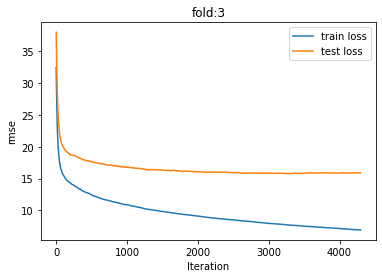

 - fold3_MAE : 15.772205


[I 2022-12-17 19:04:51,039] A new study created in memory with name: no-name-c2be4baa-f654-47ad-8ca5-2ee8c6f69b23



★★★★★　　　　　Fold 4　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:04:55,149] Trial 0 finished with value: 12.5556183976074 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 12.5556183976074.


Early stopping, best iteration is:
[562]	Train's l1: 11.5304	Test's l1: 12.5556
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:05:02,732] Trial 1 finished with value: 12.497356983673166 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 12.497356983673166.


Early stopping, best iteration is:
[599]	Train's l1: 11.0706	Test's l1: 12.4974
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:05:09,229] Trial 2 finished with value: 12.47624893502694 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 12.47624893502694.


Early stopping, best iteration is:
[680]	Train's l1: 10.771	Test's l1: 12.4762
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:05:14,423] Trial 3 finished with value: 12.616531862602036 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 12.47624893502694.


Early stopping, best iteration is:
[698]	Train's l1: 10.7785	Test's l1: 12.6165
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:05:22,209] Trial 4 finished with value: 12.54609816226924 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 12.47624893502694.


Early stopping, best iteration is:
[555]	Train's l1: 11.2564	Test's l1: 12.5461
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:05:28,543] Trial 5 finished with value: 12.465242355399145 and parameters: {'feature_fraction': 0.6}. Best is trial 5 with value: 12.465242355399145.


Early stopping, best iteration is:
[829]	Train's l1: 10.2232	Test's l1: 12.4652
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:05:35,800] Trial 6 finished with value: 12.458236788869817 and parameters: {'feature_fraction': 0.8}. Best is trial 6 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:05:43,039] Trial 7 finished with value: 12.458236788869817 and parameters: {'num_leaves': 71}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:05:50,256] Trial 8 finished with value: 12.458236788869817 and parameters: {'num_leaves': 78}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:05:57,560] Trial 9 finished with value: 12.458236788869817 and parameters: {'num_leaves': 221}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:06:04,778] Trial 10 finished with value: 12.458236788869817 and parameters: {'num_leaves': 237}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:06:12,088] Trial 11 finished with value: 12.458236788869817 and parameters: {'num_leaves': 202}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:06:19,434] Trial 12 finished with value: 12.458236788869817 and parameters: {'num_leaves': 84}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:06:24,561] Trial 13 finished with value: 12.599055121907348 and parameters: {'num_leaves': 11}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[972]	Train's l1: 11.7188	Test's l1: 12.5991
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:06:31,875] Trial 14 finished with value: 12.458236788869817 and parameters: {'num_leaves': 205}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:06:39,003] Trial 15 finished with value: 12.458236788869817 and parameters: {'num_leaves': 237}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:06:46,257] Trial 16 finished with value: 12.458236788869817 and parameters: {'num_leaves': 184}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:06:53,657] Trial 17 finished with value: 12.458236788869817 and parameters: {'num_leaves': 133}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:07:00,876] Trial 18 finished with value: 12.458236788869817 and parameters: {'num_leaves': 63}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:07:08,042] Trial 19 finished with value: 12.458236788869817 and parameters: {'num_leaves': 87}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:07:15,267] Trial 20 finished with value: 12.458236788869817 and parameters: {'num_leaves': 32}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:07:25,681] Trial 21 finished with value: 12.458236788869817 and parameters: {'num_leaves': 137}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:07:32,827] Trial 22 finished with value: 12.458236788869817 and parameters: {'num_leaves': 104}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:07:40,163] Trial 23 finished with value: 12.458236788869817 and parameters: {'num_leaves': 44}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:07:47,487] Trial 24 finished with value: 12.458236788869817 and parameters: {'num_leaves': 128}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:07:54,883] Trial 25 finished with value: 12.458236788869817 and parameters: {'num_leaves': 111}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:02,018] Trial 26 finished with value: 12.458236788869817 and parameters: {'num_leaves': 47}. Best is trial 7 with value: 12.458236788869817.


Early stopping, best iteration is:
[709]	Train's l1: 10.6556	Test's l1: 12.4582
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:08,297] Trial 27 finished with value: 12.652378230663226 and parameters: {'bagging_fraction': 0.7842298181537812, 'bagging_freq': 2}. Best is trial 27 with value: 12.652378230663226.


Early stopping, best iteration is:
[732]	Train's l1: 11.5091	Test's l1: 12.6524
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:14,777] Trial 28 finished with value: 12.449569976319028 and parameters: {'bagging_fraction': 0.8361957610934725, 'bagging_freq': 4}. Best is trial 28 with value: 12.449569976319028.


Early stopping, best iteration is:
[670]	Train's l1: 11.3477	Test's l1: 12.4496
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:19,350] Trial 29 finished with value: 12.631035053424114 and parameters: {'bagging_fraction': 0.5570245076058117, 'bagging_freq': 3}. Best is trial 28 with value: 12.449569976319028.


Early stopping, best iteration is:
[763]	Train's l1: 12.591	Test's l1: 12.631
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:24,719] Trial 30 finished with value: 12.687262216911869 and parameters: {'bagging_fraction': 0.6540671708780577, 'bagging_freq': 1}. Best is trial 28 with value: 12.449569976319028.


Early stopping, best iteration is:
[869]	Train's l1: 11.7961	Test's l1: 12.6873
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:31,520] Trial 31 finished with value: 12.564279618302859 and parameters: {'bagging_fraction': 0.8610486160492279, 'bagging_freq': 6}. Best is trial 28 with value: 12.449569976319028.


Early stopping, best iteration is:
[778]	Train's l1: 10.877	Test's l1: 12.5643
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:35,916] Trial 32 finished with value: 12.646423259371746 and parameters: {'bagging_fraction': 0.5619100210384429, 'bagging_freq': 6}. Best is trial 28 with value: 12.449569976319028.


Early stopping, best iteration is:
[773]	Train's l1: 12.5284	Test's l1: 12.6464
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:42,283] Trial 33 finished with value: 12.550409203717301 and parameters: {'bagging_fraction': 0.8785249561389955, 'bagging_freq': 4}. Best is trial 28 with value: 12.449569976319028.


Early stopping, best iteration is:
[644]	Train's l1: 11.3315	Test's l1: 12.5504
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:45,574] Trial 34 finished with value: 13.390102706411893 and parameters: {'bagging_fraction': 0.4635608476776947, 'bagging_freq': 7}. Best is trial 28 with value: 12.449569976319028.


Early stopping, best iteration is:
[630]	Train's l1: 14.0065	Test's l1: 13.3901
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:52,357] Trial 35 finished with value: 12.582138277457403 and parameters: {'bagging_fraction': 0.8578919245832355, 'bagging_freq': 6}. Best is trial 28 with value: 12.449569976319028.


Early stopping, best iteration is:
[769]	Train's l1: 10.9533	Test's l1: 12.5821
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:08:55,306] Trial 36 finished with value: 13.627902251953692 and parameters: {'bagging_fraction': 0.43293613468322495, 'bagging_freq': 7}. Best is trial 28 with value: 12.449569976319028.


Early stopping, best iteration is:
[525]	Train's l1: 14.57	Test's l1: 13.6279
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:09:01,899] Trial 37 finished with value: 12.481666951617258 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 12.481666951617258.


Early stopping, best iteration is:
[644]	Train's l1: 11.4649	Test's l1: 12.4817
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:09:09,114] Trial 38 finished with value: 12.50200454296173 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 12.481666951617258.


Early stopping, best iteration is:
[865]	Train's l1: 10.6842	Test's l1: 12.502
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:09:15,512] Trial 39 finished with value: 12.413652128336839 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 39 with value: 12.413652128336839.


Early stopping, best iteration is:
[668]	Train's l1: 11.3569	Test's l1: 12.4137
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:09:21,387] Trial 40 finished with value: 12.461177479318044 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 39 with value: 12.413652128336839.


Early stopping, best iteration is:
[667]	Train's l1: 11.3461	Test's l1: 12.4612
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:09:27,402] Trial 41 finished with value: 12.45372713175275 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 39 with value: 12.413652128336839.


Early stopping, best iteration is:
[644]	Train's l1: 11.5045	Test's l1: 12.4537
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:09:33,585] Trial 42 finished with value: 12.500045488943352 and parameters: {'feature_fraction': 0.784}. Best is trial 39 with value: 12.413652128336839.


Early stopping, best iteration is:
[638]	Train's l1: 11.5258	Test's l1: 12.5
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:09:39,948] Trial 43 finished with value: 12.411372381595285 and parameters: {'lambda_l1': 0.10877192402809138, 'lambda_l2': 7.575582992381468e-08}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[644]	Train's l1: 11.4896	Test's l1: 12.4114
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:09:46,376] Trial 44 finished with value: 12.462218871781657 and parameters: {'lambda_l1': 0.0003666874023969296, 'lambda_l2': 0.0010281091986266225}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3701	Test's l1: 12.4622
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:09:52,823] Trial 45 finished with value: 12.462215975245847 and parameters: {'lambda_l1': 1.5447999551113584e-05, 'lambda_l2': 0.002544820724516445}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3701	Test's l1: 12.4622
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:09:59,246] Trial 46 finished with value: 12.530435202827917 and parameters: {'lambda_l1': 5.746004199845025e-08, 'lambda_l2': 0.16482839677246847}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3453	Test's l1: 12.5304
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:10:05,703] Trial 47 finished with value: 12.440214608118906 and parameters: {'lambda_l1': 0.040971365043430026, 'lambda_l2': 4.227341884544218e-05}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[672]	Train's l1: 11.3609	Test's l1: 12.4402
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:10:12,108] Trial 48 finished with value: 12.43324178496849 and parameters: {'lambda_l1': 0.024246023137868118, 'lambda_l2': 6.576996874556386}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[667]	Train's l1: 11.4756	Test's l1: 12.4332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:10:18,644] Trial 49 finished with value: 12.423242316014305 and parameters: {'lambda_l1': 0.2317437788133873, 'lambda_l2': 0.0007308388681172548}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[690]	Train's l1: 11.3051	Test's l1: 12.4232
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:10:28,210] Trial 50 finished with value: 12.462209492956251 and parameters: {'lambda_l1': 1.1459751146205936e-07, 'lambda_l2': 0.005961461275768491}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3702	Test's l1: 12.4622
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:10:34,631] Trial 51 finished with value: 12.467894092437367 and parameters: {'lambda_l1': 0.014571904710687235, 'lambda_l2': 0.1987537448727717}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[672]	Train's l1: 11.3904	Test's l1: 12.4679
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:10:41,062] Trial 52 finished with value: 12.462220097166922 and parameters: {'lambda_l1': 9.250327414815384e-05, 'lambda_l2': 4.212565343930247e-07}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3701	Test's l1: 12.4622
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:10:47,492] Trial 53 finished with value: 12.453568371683218 and parameters: {'lambda_l1': 3.372700602477011, 'lambda_l2': 1.0368926194352419e-08}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3857	Test's l1: 12.4536
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:10:53,828] Trial 54 finished with value: 12.489574275537185 and parameters: {'lambda_l1': 6.56439700843766, 'lambda_l2': 1.5665764399059217e-05}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.373	Test's l1: 12.4896
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:11:00,275] Trial 55 finished with value: 12.508477274222042 and parameters: {'lambda_l1': 0.3106307379305055, 'lambda_l2': 1.2797061749198828e-06}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[666]	Train's l1: 11.3622	Test's l1: 12.5085
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:11:06,602] Trial 56 finished with value: 12.545944996545773 and parameters: {'lambda_l1': 0.003064483755348836, 'lambda_l2': 1.0095277302484984e-08}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[644]	Train's l1: 11.5166	Test's l1: 12.5459
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:11:12,872] Trial 57 finished with value: 12.463357339176776 and parameters: {'lambda_l1': 0.5403514983520583, 'lambda_l2': 5.770750312442787e-05}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[644]	Train's l1: 11.4874	Test's l1: 12.4634
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:11:19,204] Trial 58 finished with value: 12.413652125595162 and parameters: {'lambda_l1': 2.059639326261485e-06, 'lambda_l2': 5.434916653679984e-07}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3569	Test's l1: 12.4137
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:11:25,627] Trial 59 finished with value: 12.413652126356423 and parameters: {'lambda_l1': 1.798548322394204e-06, 'lambda_l2': 4.5657128216982826e-07}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3569	Test's l1: 12.4137
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:11:31,836] Trial 60 finished with value: 12.413652127315608 and parameters: {'lambda_l1': 2.3403446620250903e-06, 'lambda_l2': 1.0076093419666567e-07}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3569	Test's l1: 12.4137
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:11:38,112] Trial 61 finished with value: 12.462220839689618 and parameters: {'lambda_l1': 0.0007800291399728122, 'lambda_l2': 2.6474414623854365e-06}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3701	Test's l1: 12.4622
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:11:44,465] Trial 62 finished with value: 12.413652127884374 and parameters: {'lambda_l1': 1.2965432490099422e-08, 'lambda_l2': 8.058477806965535e-08}. Best is trial 43 with value: 12.411372381595285.


Early stopping, best iteration is:
[668]	Train's l1: 11.3569	Test's l1: 12.4137
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:11:50,806] Trial 63 finished with value: 12.411372381595285 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 12.411372381595285.


Early stopping, best iteration is:
[644]	Train's l1: 11.4896	Test's l1: 12.4114
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:11:57,242] Trial 64 finished with value: 12.411372381595285 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 12.411372381595285.


Early stopping, best iteration is:
[644]	Train's l1: 11.4896	Test's l1: 12.4114
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:12:03,487] Trial 65 finished with value: 12.411372381595285 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 12.411372381595285.


Early stopping, best iteration is:
[644]	Train's l1: 11.4896	Test's l1: 12.4114
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:12:09,765] Trial 66 finished with value: 12.411372381595285 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 12.411372381595285.


Early stopping, best iteration is:
[644]	Train's l1: 11.4896	Test's l1: 12.4114
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:12:16,090] Trial 67 finished with value: 12.411372381595285 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 12.411372381595285.


Early stopping, best iteration is:
[644]	Train's l1: 11.4896	Test's l1: 12.4114
▼▼▼▼▼　　　　　Fold 4　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.10877192402809138, 'lambda_l2': 7.575582992381468e-08, 'num_leaves': 31, 'feature_fraction': 0.8160000000000001, 'bagging_fraction': 0.8361957610934725, 'bagging_freq': 4, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


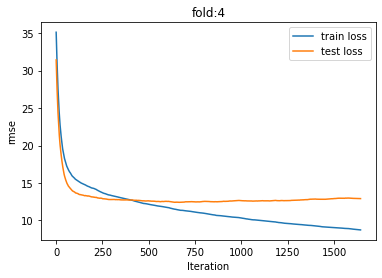

 - fold4_MAE : 12.411372


[I 2022-12-17 19:12:17,321] A new study created in memory with name: no-name-6c7b23e1-114b-4964-be66-97ea5b7f8019



★★★★★　　　　　Fold 5　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:12:23,746] Trial 0 finished with value: 14.736183125164287 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:12:30,897] Trial 1 finished with value: 14.743284557025627 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 14.736183125164287.


Early stopping, best iteration is:
[701]	Train's l1: 10.2387	Test's l1: 14.7433
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:12:35,610] Trial 2 finished with value: 14.948328317772182 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 14.736183125164287.


Early stopping, best iteration is:
[587]	Train's l1: 10.8442	Test's l1: 14.9483
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:12:41,567] Trial 3 finished with value: 14.78576173372384 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 14.736183125164287.


Early stopping, best iteration is:
[641]	Train's l1: 10.5241	Test's l1: 14.7858
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:12:50,125] Trial 4 finished with value: 14.818277877973106 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 14.736183125164287.


Early stopping, best iteration is:
[783]	Train's l1: 9.89955	Test's l1: 14.8183
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:12:54,124] Trial 5 finished with value: 15.079018522921865 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 14.736183125164287.


Early stopping, best iteration is:
[599]	Train's l1: 10.9494	Test's l1: 15.079
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:12:59,008] Trial 6 finished with value: 14.837551662834722 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 14.736183125164287.


Early stopping, best iteration is:
[520]	Train's l1: 11.1174	Test's l1: 14.8376
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:13:05,392] Trial 7 finished with value: 14.736183125164287 and parameters: {'num_leaves': 138}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:13:11,756] Trial 8 finished with value: 14.736183125164287 and parameters: {'num_leaves': 220}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:13:18,114] Trial 9 finished with value: 14.736183125164287 and parameters: {'num_leaves': 130}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:13:24,527] Trial 10 finished with value: 14.736183125164287 and parameters: {'num_leaves': 245}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:13:33,851] Trial 11 finished with value: 14.736183125164287 and parameters: {'num_leaves': 176}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:13:40,202] Trial 12 finished with value: 14.736183125164287 and parameters: {'num_leaves': 168}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:13:46,477] Trial 13 finished with value: 14.736183125164287 and parameters: {'num_leaves': 42}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:13:52,844] Trial 14 finished with value: 14.736183125164287 and parameters: {'num_leaves': 101}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:13:59,140] Trial 15 finished with value: 14.736183125164287 and parameters: {'num_leaves': 101}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:14:05,587] Trial 16 finished with value: 14.736183125164287 and parameters: {'num_leaves': 177}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:14:11,914] Trial 17 finished with value: 14.754845849940379 and parameters: {'num_leaves': 19}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[654]	Train's l1: 10.884	Test's l1: 14.7548
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:14:18,349] Trial 18 finished with value: 14.736183125164287 and parameters: {'num_leaves': 256}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:14:24,696] Trial 19 finished with value: 14.736183125164287 and parameters: {'num_leaves': 203}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:14:31,046] Trial 20 finished with value: 14.736183125164287 and parameters: {'num_leaves': 218}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:14:37,398] Trial 21 finished with value: 14.736183125164287 and parameters: {'num_leaves': 135}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:14:43,729] Trial 22 finished with value: 14.736183125164287 and parameters: {'num_leaves': 70}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:14:50,062] Trial 23 finished with value: 14.736183125164287 and parameters: {'num_leaves': 214}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:14:56,486] Trial 24 finished with value: 14.736183125164287 and parameters: {'num_leaves': 133}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:15:02,807] Trial 25 finished with value: 14.736183125164287 and parameters: {'num_leaves': 55}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:15:09,212] Trial 26 finished with value: 14.736183125164287 and parameters: {'num_leaves': 160}. Best is trial 7 with value: 14.736183125164287.


Early stopping, best iteration is:
[467]	Train's l1: 11.4118	Test's l1: 14.7362
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:15:16,125] Trial 27 finished with value: 14.564851643691485 and parameters: {'bagging_fraction': 0.882269245966407, 'bagging_freq': 2}. Best is trial 27 with value: 14.564851643691485.


Early stopping, best iteration is:
[599]	Train's l1: 11.0592	Test's l1: 14.5649
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:15:23,533] Trial 28 finished with value: 14.889340543788148 and parameters: {'bagging_fraction': 0.9765878735083178, 'bagging_freq': 3}. Best is trial 27 with value: 14.564851643691485.


Early stopping, best iteration is:
[577]	Train's l1: 10.8537	Test's l1: 14.8893
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:15:29,262] Trial 29 finished with value: 14.798512053852168 and parameters: {'bagging_fraction': 0.6438357474562003, 'bagging_freq': 1}. Best is trial 27 with value: 14.564851643691485.


Early stopping, best iteration is:
[962]	Train's l1: 10.899	Test's l1: 14.7985
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:15:35,877] Trial 30 finished with value: 14.509581899773798 and parameters: {'bagging_fraction': 0.5603261282577868, 'bagging_freq': 3}. Best is trial 30 with value: 14.509581899773798.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:15:42,179] Trial 31 finished with value: 14.777357244998933 and parameters: {'bagging_fraction': 0.7331186691515901, 'bagging_freq': 4}. Best is trial 30 with value: 14.509581899773798.


Early stopping, best iteration is:
[803]	Train's l1: 10.9798	Test's l1: 14.7774
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:15:48,771] Trial 32 finished with value: 14.554817516997392 and parameters: {'bagging_fraction': 0.8562037713681379, 'bagging_freq': 7}. Best is trial 30 with value: 14.509581899773798.


Early stopping, best iteration is:
[596]	Train's l1: 11.2078	Test's l1: 14.5548
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:15:55,016] Trial 33 finished with value: 14.736837629274802 and parameters: {'bagging_fraction': 0.5962099648418091, 'bagging_freq': 3}. Best is trial 30 with value: 14.509581899773798.


Early stopping, best iteration is:
[1116]	Train's l1: 10.8777	Test's l1: 14.7368
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:16:02,115] Trial 34 finished with value: 14.937902551454602 and parameters: {'bagging_fraction': 0.7103526410277861, 'bagging_freq': 1}. Best is trial 30 with value: 14.509581899773798.


Early stopping, best iteration is:
[1109]	Train's l1: 10.2391	Test's l1: 14.9379
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:16:08,854] Trial 35 finished with value: 14.696261003048724 and parameters: {'bagging_fraction': 0.9230203714095032, 'bagging_freq': 5}. Best is trial 30 with value: 14.509581899773798.


Early stopping, best iteration is:
[514]	Train's l1: 11.3026	Test's l1: 14.6963
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:16:15,549] Trial 36 finished with value: 14.629725738365819 and parameters: {'bagging_fraction': 0.9266906888877817, 'bagging_freq': 4}. Best is trial 30 with value: 14.509581899773798.


Early stopping, best iteration is:
[474]	Train's l1: 11.5517	Test's l1: 14.6297
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:16:21,409] Trial 37 finished with value: 14.524996804693194 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 14.524996804693194.


Early stopping, best iteration is:
[1065]	Train's l1: 11.1644	Test's l1: 14.525
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:16:30,055] Trial 38 finished with value: 14.655233195746948 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 14.524996804693194.


Early stopping, best iteration is:
[1065]	Train's l1: 11.1631	Test's l1: 14.6552
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:16:35,775] Trial 39 finished with value: 14.613126453900342 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 14.524996804693194.


Early stopping, best iteration is:
[1065]	Train's l1: 11.1959	Test's l1: 14.6131
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:16:41,881] Trial 40 finished with value: 14.679766351750311 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 14.524996804693194.


Early stopping, best iteration is:
[1065]	Train's l1: 11.2007	Test's l1: 14.6798
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:16:49,110] Trial 41 finished with value: 14.559182906765875 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 14.524996804693194.


Early stopping, best iteration is:
[1434]	Train's l1: 10.3984	Test's l1: 14.5592
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:16:54,664] Trial 42 finished with value: 14.543694378627201 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 14.524996804693194.


Early stopping, best iteration is:
[1065]	Train's l1: 11.1782	Test's l1: 14.5437
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:17:01,664] Trial 43 finished with value: 14.509581705246083 and parameters: {'lambda_l1': 1.7665804289469507e-08, 'lambda_l2': 3.399541539415714e-05}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:17:08,058] Trial 44 finished with value: 14.51937919814672 and parameters: {'lambda_l1': 0.0026854028335553215, 'lambda_l2': 0.00031194869622528786}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1284]	Train's l1: 10.7195	Test's l1: 14.5194
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:17:14,998] Trial 45 finished with value: 14.50958189705172 and parameters: {'lambda_l1': 2.2334181107533485e-06, 'lambda_l2': 3.2160771215326584e-07}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:17:21,898] Trial 46 finished with value: 14.509581898838704 and parameters: {'lambda_l1': 5.073155102580985e-08, 'lambda_l2': 9.279586428017872e-08}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:17:28,768] Trial 47 finished with value: 14.509581891925482 and parameters: {'lambda_l1': 1.5203109994741156e-05, 'lambda_l2': 1.0637583040763593e-08}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:17:34,566] Trial 48 finished with value: 14.636666443409327 and parameters: {'lambda_l1': 0.20143486616732673, 'lambda_l2': 0.03060742164791872}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1065]	Train's l1: 11.1877	Test's l1: 14.6367
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:17:41,365] Trial 49 finished with value: 14.509581845229237 and parameters: {'lambda_l1': 9.085290478175638e-05, 'lambda_l2': 1.7145373643871012e-07}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:17:47,802] Trial 50 finished with value: 14.519380545192597 and parameters: {'lambda_l1': 0.004392291963769629, 'lambda_l2': 1.8838380254516038e-05}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1284]	Train's l1: 10.7195	Test's l1: 14.5194
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:17:54,378] Trial 51 finished with value: 14.519378783769408 and parameters: {'lambda_l1': 3.3303233997041804e-07, 'lambda_l2': 0.00040225417793408294}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1284]	Train's l1: 10.7195	Test's l1: 14.5194
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:18:01,268] Trial 52 finished with value: 14.607986291272958 and parameters: {'lambda_l1': 2.229583185393031e-05, 'lambda_l2': 0.10935684715815161}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4117	Test's l1: 14.608
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:18:07,661] Trial 53 finished with value: 14.538724435895169 and parameters: {'lambda_l1': 1.0849993575112308e-08, 'lambda_l2': 7.391777274153636}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1326]	Train's l1: 10.7452	Test's l1: 14.5387
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:18:14,442] Trial 54 finished with value: 14.618968882384868 and parameters: {'lambda_l1': 1.5629249890370598, 'lambda_l2': 3.675895375804265e-06}. Best is trial 43 with value: 14.509581705246083.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4134	Test's l1: 14.619
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:18:21,204] Trial 55 finished with value: 14.509581639581645 and parameters: {'lambda_l1': 0.00035220797165566684, 'lambda_l2': 8.60704083863185e-06}. Best is trial 55 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:18:27,530] Trial 56 finished with value: 14.519380321760696 and parameters: {'lambda_l1': 0.0013304423359652832, 'lambda_l2': 6.7943717083111e-05}. Best is trial 55 with value: 14.509581639581645.


Early stopping, best iteration is:
[1284]	Train's l1: 10.7195	Test's l1: 14.5194
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:18:34,292] Trial 57 finished with value: 14.601822594002162 and parameters: {'lambda_l1': 0.03679871717771245, 'lambda_l2': 0.0033087408703840423}. Best is trial 55 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.3899	Test's l1: 14.6018
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:18:40,930] Trial 58 finished with value: 14.509581884407973 and parameters: {'lambda_l1': 1.0421286478689393e-06, 'lambda_l2': 2.616101723923099e-06}. Best is trial 55 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:18:47,708] Trial 59 finished with value: 14.509581711210464 and parameters: {'lambda_l1': 0.00027438328290941416, 'lambda_l2': 4.547108862233673e-06}. Best is trial 55 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:18:54,538] Trial 60 finished with value: 14.601822828251063 and parameters: {'lambda_l1': 0.03654812810244005, 'lambda_l2': 0.0032939410248406845}. Best is trial 55 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.3899	Test's l1: 14.6018
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:19:01,140] Trial 61 finished with value: 14.521957406706784 and parameters: {'lambda_l1': 4.9411119946626005, 'lambda_l2': 5.215485252504871e-05}. Best is trial 55 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4259	Test's l1: 14.522
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:19:07,842] Trial 62 finished with value: 14.509581888184018 and parameters: {'lambda_l1': 1.2427958120667728e-05, 'lambda_l2': 8.948466222189556e-07}. Best is trial 55 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:19:14,601] Trial 63 finished with value: 14.509581639581645 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:19:21,307] Trial 64 finished with value: 14.509581639581645 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:19:31,000] Trial 65 finished with value: 14.509581639581645 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:19:37,735] Trial 66 finished with value: 14.509581639581645 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 19:19:44,398] Trial 67 finished with value: 14.509581639581645 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 14.509581639581645.


Early stopping, best iteration is:
[1434]	Train's l1: 10.4068	Test's l1: 14.5096
▼▼▼▼▼　　　　　Fold 5　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.00035220797165566684, 'lambda_l2': 8.60704083863185e-06, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.5603261282577868, 'bagging_freq': 3, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


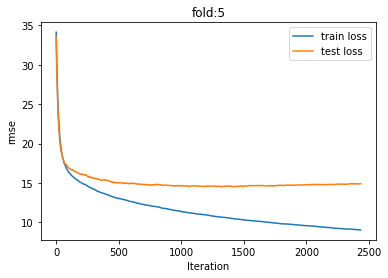

 - fold5_MAE : 14.509582
 - CV_MAE : 14.429809


In [ ]:
kf_cv = list(kf.split(df_train_gluer_x))
oof_valid_lgb_main_gluer, lgb_models_main_gluer = fit_lgb_oputuna(x=df_train_gluer_x, y=df_train_gluer_main_y, cv=kf_cv,
                                      model_params=optuna_model_params, fit_params=oputuna_fit_params
                                     )

In [ ]:
file_path = f'oof_valid_lgb_main_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_main_gluer, f)

file_path = f'lgb_models_main_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_main_gluer, f)

## 付帯作業時間 ー グルア―　の学習

In [ ]:
"""
df_train_printer_x = df_train_printer.drop(["index","正味作業時間","付帯作業時間"], axis=1)
df_train_printer_main_y = df_train_printer["正味作業時間"]
df_train_printer_sub_y = df_train_printer["付帯作業時間"]

df_train_gluer_x = df_train_gluer.drop(["index","正味作業時間","付帯作業時間"], axis=1)
df_train_gluer_main_y = df_train_gluer["正味作業時間"]
df_train_gluer_sub_y = df_train_gluer["付帯作業時間"]

df_test_printer = df_test_printer.drop(["正味作業時間","付帯作業時間"], axis=1)
df_test_gluer = df_test_gluer.drop(["正味作業時間","付帯作業時間"], axis=1)
"""

In [ ]:
df_sub_gluer = df_train_gluer_sub[df_train_gluer_sub_corr_top20]
sub_target = df_train_gluer[config.sub_target]
kf_cv = list(kf.split(df_sub_gluer))

[I 2022-12-17 17:32:03,413] A new study created in memory with name: no-name-5335035f-2135-4290-b0a7-16f681ddf931


data_labels: ['作業日', '受注番号', '号機名', '号機コード', '数量1', '数量項目名1', '合計数量', '予備数量', '仕上数量', '連量', '加工数量', '台数', '製品仕様コード_x', 'カテゴリ名1', 'カテゴリ名2', '工程コード', '工程名', '部品区分', '部品区分名', '部品行番号', '部品仕様番号', '部品仕様コード', '表示順', '印刷前工程フラグ', '加工行番号', '加工順', '加工単位区分', '加工単位区分名', '協力会社親コード', '協力会社子コード', '協力会社コード', 'サイズ区分', 'サイズ区分名', 'サイズ幅', 'サイズ長さ', '抜型区分', '抜型区分名', 'ストリッパー区分', 'ストリッパー区分名', 'ブランキング区分', 'ブランキング区分名', '加工表裏指定区分', '加工表裏指定区分名', '単位区分_x', '単位区分名_x', '仕分区分', '仕分区分名', '間紙区分', '間紙区分名', '紙帯区分', '紙帯区分名', '予定組ラベルキー', '受注日', '製品仕様コード_y', '受注数量', '実績数量', '下版予定日', '流用受注番号', '流用受注日', '流用製品仕様コード', '頁数', 'キャンペーン番号', '受注キャンペーン番号', 'キャンペーンフラグ', '付合受注番号', '付合フラグ', '受注区分', '受注区分名', '納期', '納期詳細', '初回出荷日', '先方注文番号', '事業所親コード', '事業所子コード', '事業所コード', '部門コード', '営業担当者コード', '得意先親コード', '得意先子コード', '得意先コード', '版番号', 'ロット番号', '仕上寸法区分', '仕上寸法区分名', '仕上寸法幅', '仕上寸法長さ', '仕上寸法厚さ', '展開寸法区分', '展開寸法区分名', '展開寸法幅', '展開寸法長さ', '展開寸法厚さ', '製品区分', '製品区分名', 'リピート区分', 'リピート区分名', '仕様登録者コード', '単位区分_y', '単位区分名_y', '客先サンプル数量', '営業サンプル数量', '版区分', '

[I 2022-12-17 17:32:06,979] Trial 0 finished with value: 13.167781307252687 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 13.167781307252687.


Early stopping, best iteration is:
[27]	Train's l1: 13.2914	Test's l1: 13.1678
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:11,728] Trial 1 finished with value: 13.16867344751448 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 13.167781307252687.


Early stopping, best iteration is:
[24]	Train's l1: 13.3893	Test's l1: 13.1687
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:14,828] Trial 2 finished with value: 13.172612461028171 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 13.167781307252687.


Early stopping, best iteration is:
[31]	Train's l1: 13.216	Test's l1: 13.1726
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:18,673] Trial 3 finished with value: 13.18150687257758 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 13.167781307252687.


Early stopping, best iteration is:
[27]	Train's l1: 13.2977	Test's l1: 13.1815
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:20,985] Trial 4 finished with value: 13.16918622077616 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 13.167781307252687.


Early stopping, best iteration is:
[30]	Train's l1: 13.3134	Test's l1: 13.1692
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:25,085] Trial 5 finished with value: 13.16323858032572 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 13.16323858032572.


Early stopping, best iteration is:
[24]	Train's l1: 13.3818	Test's l1: 13.1632
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:27,779] Trial 6 finished with value: 13.141006971299113 and parameters: {'feature_fraction': 0.5}. Best is trial 6 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:30,536] Trial 7 finished with value: 13.141006971299113 and parameters: {'num_leaves': 221}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:33,201] Trial 8 finished with value: 13.141006971299113 and parameters: {'num_leaves': 190}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:35,927] Trial 9 finished with value: 13.141006971299113 and parameters: {'num_leaves': 180}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:38,685] Trial 10 finished with value: 13.141006971299113 and parameters: {'num_leaves': 194}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:41,353] Trial 11 finished with value: 13.141006971299113 and parameters: {'num_leaves': 83}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:44,036] Trial 12 finished with value: 13.141006971299113 and parameters: {'num_leaves': 133}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:46,709] Trial 13 finished with value: 13.141006971299113 and parameters: {'num_leaves': 196}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:49,486] Trial 14 finished with value: 13.141006971299113 and parameters: {'num_leaves': 213}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:52,182] Trial 15 finished with value: 13.141006971299113 and parameters: {'num_leaves': 256}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:54,797] Trial 16 finished with value: 13.141006971299113 and parameters: {'num_leaves': 29}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:32:57,471] Trial 17 finished with value: 13.141006971299113 and parameters: {'num_leaves': 254}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:00,219] Trial 18 finished with value: 13.141006971299113 and parameters: {'num_leaves': 143}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:02,881] Trial 19 finished with value: 13.141006971299113 and parameters: {'num_leaves': 169}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:05,524] Trial 20 finished with value: 13.141006971299113 and parameters: {'num_leaves': 96}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:08,228] Trial 21 finished with value: 13.141006971299113 and parameters: {'num_leaves': 234}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:10,934] Trial 22 finished with value: 13.141006971299113 and parameters: {'num_leaves': 158}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:13,575] Trial 23 finished with value: 13.141006971299113 and parameters: {'num_leaves': 219}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:16,225] Trial 24 finished with value: 13.141006971299113 and parameters: {'num_leaves': 229}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:18,883] Trial 25 finished with value: 13.141006971299113 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2163	Test's l1: 13.141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:21,532] Trial 26 finished with value: 13.153941117855812 and parameters: {'num_leaves': 23}. Best is trial 7 with value: 13.141006971299113.


Early stopping, best iteration is:
[31]	Train's l1: 13.2245	Test's l1: 13.1539
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:23,037] Trial 27 finished with value: 13.28916432568969 and parameters: {'bagging_fraction': 0.4391913810878759, 'bagging_freq': 4}. Best is trial 27 with value: 13.28916432568969.


Early stopping, best iteration is:
[68]	Train's l1: 13.2544	Test's l1: 13.2892
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:25,360] Trial 28 finished with value: 13.188302675192327 and parameters: {'bagging_fraction': 0.7339482338724468, 'bagging_freq': 3}. Best is trial 28 with value: 13.188302675192327.


Early stopping, best iteration is:
[33]	Train's l1: 13.299	Test's l1: 13.1883
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:26,882] Trial 29 finished with value: 13.249266803331283 and parameters: {'bagging_fraction': 0.4423169203573381, 'bagging_freq': 3}. Best is trial 28 with value: 13.188302675192327.


Early stopping, best iteration is:
[53]	Train's l1: 13.3473	Test's l1: 13.2493
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:29,438] Trial 30 finished with value: 13.132454320618688 and parameters: {'bagging_fraction': 0.775828349728032, 'bagging_freq': 2}. Best is trial 30 with value: 13.132454320618688.


Early stopping, best iteration is:
[32]	Train's l1: 13.2587	Test's l1: 13.1325
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:31,699] Trial 31 finished with value: 13.150432063674034 and parameters: {'bagging_fraction': 0.709761505372982, 'bagging_freq': 1}. Best is trial 30 with value: 13.132454320618688.


Early stopping, best iteration is:
[73]	Train's l1: 12.8541	Test's l1: 13.1504
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:34,151] Trial 32 finished with value: 13.187043093653571 and parameters: {'bagging_fraction': 0.7803962623290767, 'bagging_freq': 4}. Best is trial 30 with value: 13.132454320618688.


Early stopping, best iteration is:
[31]	Train's l1: 13.3313	Test's l1: 13.187
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:36,306] Trial 33 finished with value: 13.179803911198707 and parameters: {'bagging_fraction': 0.6860191365331689, 'bagging_freq': 7}. Best is trial 30 with value: 13.132454320618688.


Early stopping, best iteration is:
[34]	Train's l1: 13.352	Test's l1: 13.1798
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:37,979] Trial 34 finished with value: 13.281569780087048 and parameters: {'bagging_fraction': 0.4948338357632329, 'bagging_freq': 3}. Best is trial 30 with value: 13.132454320618688.


Early stopping, best iteration is:
[57]	Train's l1: 13.2592	Test's l1: 13.2816
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:40,501] Trial 35 finished with value: 13.110613143574042 and parameters: {'bagging_fraction': 0.914169592086158, 'bagging_freq': 1}. Best is trial 35 with value: 13.110613143574042.


Early stopping, best iteration is:
[35]	Train's l1: 13.1089	Test's l1: 13.1106
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:42,702] Trial 36 finished with value: 13.161544907624032 and parameters: {'bagging_fraction': 0.7358706111020747, 'bagging_freq': 1}. Best is trial 35 with value: 13.110613143574042.


Early stopping, best iteration is:
[39]	Train's l1: 13.2028	Test's l1: 13.1615
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:44,993] Trial 37 finished with value: 13.118016166026575 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 13.118016166026575.


Early stopping, best iteration is:
[37]	Train's l1: 13.1176	Test's l1: 13.118
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:47,397] Trial 38 finished with value: 13.108155547617502 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 38 with value: 13.108155547617502.


Early stopping, best iteration is:
[37]	Train's l1: 13.0959	Test's l1: 13.1082
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:50,167] Trial 39 finished with value: 13.114061284340062 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 38 with value: 13.108155547617502.


Early stopping, best iteration is:
[31]	Train's l1: 13.195	Test's l1: 13.1141
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:52,959] Trial 40 finished with value: 13.114548199940163 and parameters: {'feature_fraction': 0.516}. Best is trial 38 with value: 13.108155547617502.


Early stopping, best iteration is:
[34]	Train's l1: 13.1188	Test's l1: 13.1145
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:55,562] Trial 41 finished with value: 13.091675678829908 and parameters: {'feature_fraction': 0.484}. Best is trial 41 with value: 13.091675678829908.


Early stopping, best iteration is:
[33]	Train's l1: 13.1835	Test's l1: 13.0917
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:33:58,455] Trial 42 finished with value: 13.128845111153892 and parameters: {'feature_fraction': 0.58}. Best is trial 41 with value: 13.091675678829908.


Early stopping, best iteration is:
[29]	Train's l1: 13.2821	Test's l1: 13.1288
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:00,991] Trial 43 finished with value: 13.095889443685087 and parameters: {'lambda_l1': 2.81724220524865e-07, 'lambda_l2': 0.35791546161405796}. Best is trial 43 with value: 13.095889443685087.


Early stopping, best iteration is:
[31]	Train's l1: 13.2289	Test's l1: 13.0959
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:03,562] Trial 44 finished with value: 13.085561150289266 and parameters: {'lambda_l1': 0.04930459221439096, 'lambda_l2': 0.05812203061006987}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1807	Test's l1: 13.0856
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:06,062] Trial 45 finished with value: 13.091675810677648 and parameters: {'lambda_l1': 1.1094053960857635e-05, 'lambda_l2': 0.0002520153307460044}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1835	Test's l1: 13.0917
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:08,636] Trial 46 finished with value: 13.09167630612559 and parameters: {'lambda_l1': 0.0013516604057386297, 'lambda_l2': 0.00027170124028938155}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1835	Test's l1: 13.0917
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:11,204] Trial 47 finished with value: 13.08811259612632 and parameters: {'lambda_l1': 0.015219231767427987, 'lambda_l2': 0.0006788035007377701}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1815	Test's l1: 13.0881
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:13,819] Trial 48 finished with value: 13.091675686641928 and parameters: {'lambda_l1': 1.9983221499740734e-05, 'lambda_l2': 1.8417155941873109e-06}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1835	Test's l1: 13.0917
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:16,389] Trial 49 finished with value: 13.09167574400539 and parameters: {'lambda_l1': 0.0001791125577371445, 'lambda_l2': 1.186944415978027e-06}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1835	Test's l1: 13.0917
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:18,916] Trial 50 finished with value: 13.10476296809378 and parameters: {'lambda_l1': 6.476728261680299e-07, 'lambda_l2': 2.109344019167236}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[32]	Train's l1: 13.2153	Test's l1: 13.1048
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:21,496] Trial 51 finished with value: 13.09167580051877 and parameters: {'lambda_l1': 1.7905380975345804e-06, 'lambda_l2': 0.00023951938033300779}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1835	Test's l1: 13.0917
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:24,055] Trial 52 finished with value: 13.088592768033179 and parameters: {'lambda_l1': 4.3385350189277645, 'lambda_l2': 1.6340492897143113e-08}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[38]	Train's l1: 13.0797	Test's l1: 13.0886
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:26,593] Trial 53 finished with value: 13.097516804536076 and parameters: {'lambda_l1': 0.35548485262970814, 'lambda_l2': 0.052945115688108314}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1817	Test's l1: 13.0975
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:29,152] Trial 54 finished with value: 13.086136064928057 and parameters: {'lambda_l1': 0.017284387485231163, 'lambda_l2': 0.01238112858111209}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1805	Test's l1: 13.0861
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:31,745] Trial 55 finished with value: 13.08662516024799 and parameters: {'lambda_l1': 0.041100732823249636, 'lambda_l2': 0.017835205926319927}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1808	Test's l1: 13.0866
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:34,309] Trial 56 finished with value: 13.089217845221452 and parameters: {'lambda_l1': 0.0026983233626434906, 'lambda_l2': 0.012060108440443494}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[35]	Train's l1: 13.1408	Test's l1: 13.0892
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:36,795] Trial 57 finished with value: 13.128276651093524 and parameters: {'lambda_l1': 0.4998121217145108, 'lambda_l2': 4.9480249214848975}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.2179	Test's l1: 13.1283
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:39,334] Trial 58 finished with value: 13.088108655315914 and parameters: {'lambda_l1': 1.6616148776813574e-08, 'lambda_l2': 0.0038981534377941804}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1815	Test's l1: 13.0881
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:41,789] Trial 59 finished with value: 13.113432137442413 and parameters: {'lambda_l1': 8.936767287819489, 'lambda_l2': 0.22636371821928353}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[31]	Train's l1: 13.2392	Test's l1: 13.1134
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:44,426] Trial 60 finished with value: 13.09603523746197 and parameters: {'lambda_l1': 0.0775344885834225, 'lambda_l2': 0.29455132532012285}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[35]	Train's l1: 13.1455	Test's l1: 13.096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:46,960] Trial 61 finished with value: 13.091675820365241 and parameters: {'lambda_l1': 0.00036477332081039207, 'lambda_l2': 1.916102419375204e-05}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1835	Test's l1: 13.0917
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:49,606] Trial 62 finished with value: 13.088110919169361 and parameters: {'lambda_l1': 0.007978064025204262, 'lambda_l2': 0.00255130018152126}. Best is trial 44 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1815	Test's l1: 13.0881
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:52,214] Trial 63 finished with value: 13.085561150289266 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1807	Test's l1: 13.0856
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:54,838] Trial 64 finished with value: 13.085561150289266 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1807	Test's l1: 13.0856
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:57,374] Trial 65 finished with value: 13.085561150289266 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1807	Test's l1: 13.0856
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:34:59,907] Trial 66 finished with value: 13.085561150289266 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1807	Test's l1: 13.0856
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:02,473] Trial 67 finished with value: 13.085561150289266 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 13.085561150289266.


Early stopping, best iteration is:
[33]	Train's l1: 13.1807	Test's l1: 13.0856
▼▼▼▼▼　　　　　Fold 1　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.04930459221439096, 'lambda_l2': 0.05812203061006987, 'num_leaves': 31, 'feature_fraction': 0.484, 'bagging_fraction': 0.914169592086158, 'bagging_freq': 1, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


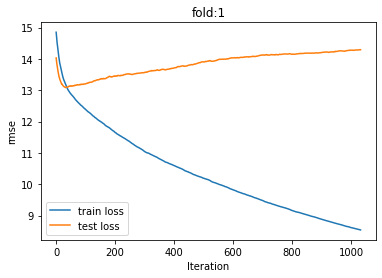

 - fold1_MAE : 13.085561


[I 2022-12-17 17:35:02,703] A new study created in memory with name: no-name-9c3034a2-fc6f-42b3-8986-f36a2aa408a0



★★★★★　　　　　Fold 2　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:06,645] Trial 0 finished with value: 13.438389046308346 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 13.438389046308346.


Early stopping, best iteration is:
[139]	Train's l1: 11.793	Test's l1: 13.4384
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:09,399] Trial 1 finished with value: 13.378862354533116 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 13.378862354533116.


Early stopping, best iteration is:
[191]	Train's l1: 11.5485	Test's l1: 13.3789
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:12,749] Trial 2 finished with value: 13.354138249958803 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:20,554] Trial 3 finished with value: 13.36528124999345 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 13.354138249958803.


Early stopping, best iteration is:
[139]	Train's l1: 11.7499	Test's l1: 13.3653
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:24,807] Trial 4 finished with value: 13.375056749855426 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 13.354138249958803.


Early stopping, best iteration is:
[130]	Train's l1: 11.829	Test's l1: 13.3751
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:28,344] Trial 5 finished with value: 13.372832535677084 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 13.354138249958803.


Early stopping, best iteration is:
[139]	Train's l1: 11.8208	Test's l1: 13.3728
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:33,330] Trial 6 finished with value: 13.420591292598537 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 13.354138249958803.


Early stopping, best iteration is:
[134]	Train's l1: 11.7841	Test's l1: 13.4206
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:36,575] Trial 7 finished with value: 13.354138249958803 and parameters: {'num_leaves': 153}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:39,708] Trial 8 finished with value: 13.354138249958803 and parameters: {'num_leaves': 151}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:42,848] Trial 9 finished with value: 13.354138249958803 and parameters: {'num_leaves': 40}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:46,011] Trial 10 finished with value: 13.354138249958803 and parameters: {'num_leaves': 27}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:49,227] Trial 11 finished with value: 13.354138249958803 and parameters: {'num_leaves': 84}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:52,412] Trial 12 finished with value: 13.354138249958803 and parameters: {'num_leaves': 83}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:55,568] Trial 13 finished with value: 13.354138249958803 and parameters: {'num_leaves': 54}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:35:58,712] Trial 14 finished with value: 13.367038470398889 and parameters: {'num_leaves': 24}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[191]	Train's l1: 11.4796	Test's l1: 13.367
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:01,937] Trial 15 finished with value: 13.354138249958803 and parameters: {'num_leaves': 146}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:05,091] Trial 16 finished with value: 13.354138249958803 and parameters: {'num_leaves': 109}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:08,368] Trial 17 finished with value: 13.354138249958803 and parameters: {'num_leaves': 223}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:11,563] Trial 18 finished with value: 13.354138249958803 and parameters: {'num_leaves': 165}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:14,778] Trial 19 finished with value: 13.354138249958803 and parameters: {'num_leaves': 181}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:18,025] Trial 20 finished with value: 13.354138249958803 and parameters: {'num_leaves': 216}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:21,221] Trial 21 finished with value: 13.354138249958803 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:24,389] Trial 22 finished with value: 13.354138249958803 and parameters: {'num_leaves': 126}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:27,565] Trial 23 finished with value: 13.354138249958803 and parameters: {'num_leaves': 146}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:30,787] Trial 24 finished with value: 13.354138249958803 and parameters: {'num_leaves': 254}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:33,881] Trial 25 finished with value: 13.354138249958803 and parameters: {'num_leaves': 110}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:37,042] Trial 26 finished with value: 13.354138249958803 and parameters: {'num_leaves': 198}. Best is trial 7 with value: 13.354138249958803.


Early stopping, best iteration is:
[195]	Train's l1: 11.4226	Test's l1: 13.3541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:39,097] Trial 27 finished with value: 13.427320371727525 and parameters: {'bagging_fraction': 0.4238810527295613, 'bagging_freq': 1}. Best is trial 27 with value: 13.427320371727525.


Early stopping, best iteration is:
[302]	Train's l1: 12.3242	Test's l1: 13.4273
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:42,118] Trial 28 finished with value: 13.420263888084113 and parameters: {'bagging_fraction': 0.9190921187954961, 'bagging_freq': 7}. Best is trial 28 with value: 13.420263888084113.


Early stopping, best iteration is:
[137]	Train's l1: 12.0329	Test's l1: 13.4203
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:44,354] Trial 29 finished with value: 13.29906368660361 and parameters: {'bagging_fraction': 0.6487171487376547, 'bagging_freq': 1}. Best is trial 29 with value: 13.29906368660361.


Early stopping, best iteration is:
[177]	Train's l1: 12.2509	Test's l1: 13.2991
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:46,880] Trial 30 finished with value: 13.368645514832254 and parameters: {'bagging_fraction': 0.7181550444444947, 'bagging_freq': 5}. Best is trial 29 with value: 13.29906368660361.


Early stopping, best iteration is:
[160]	Train's l1: 12.1996	Test's l1: 13.3686
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:49,520] Trial 31 finished with value: 13.28947407348912 and parameters: {'bagging_fraction': 0.6881464835494905, 'bagging_freq': 6}. Best is trial 31 with value: 13.28947407348912.


Early stopping, best iteration is:
[217]	Train's l1: 11.9511	Test's l1: 13.2895
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:51,551] Trial 32 finished with value: 13.360087274094614 and parameters: {'bagging_fraction': 0.4221139956820331, 'bagging_freq': 2}. Best is trial 31 with value: 13.28947407348912.


Early stopping, best iteration is:
[398]	Train's l1: 12.0667	Test's l1: 13.3601
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:53,289] Trial 33 finished with value: 13.466346987056012 and parameters: {'bagging_fraction': 0.4105242100032563, 'bagging_freq': 7}. Best is trial 31 with value: 13.28947407348912.


Early stopping, best iteration is:
[304]	Train's l1: 12.397	Test's l1: 13.4663
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:54,994] Trial 34 finished with value: 13.399751193712502 and parameters: {'bagging_fraction': 0.4296552750032879, 'bagging_freq': 7}. Best is trial 31 with value: 13.28947407348912.


Early stopping, best iteration is:
[236]	Train's l1: 12.4891	Test's l1: 13.3998
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:36:57,898] Trial 35 finished with value: 13.318556663415196 and parameters: {'bagging_fraction': 0.8505224685500763, 'bagging_freq': 4}. Best is trial 31 with value: 13.28947407348912.


Early stopping, best iteration is:
[124]	Train's l1: 12.2179	Test's l1: 13.3186
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:01,152] Trial 36 finished with value: 13.41799736324074 and parameters: {'bagging_fraction': 0.9417118577950481, 'bagging_freq': 3}. Best is trial 31 with value: 13.28947407348912.


Early stopping, best iteration is:
[125]	Train's l1: 12.0489	Test's l1: 13.418
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:03,903] Trial 37 finished with value: 13.321527268652169 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 13.321527268652169.


Early stopping, best iteration is:
[192]	Train's l1: 12.0435	Test's l1: 13.3215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:06,544] Trial 38 finished with value: 13.284982909176284 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 38 with value: 13.284982909176284.


Early stopping, best iteration is:
[194]	Train's l1: 12.0309	Test's l1: 13.285
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:09,147] Trial 39 finished with value: 13.275848565203091 and parameters: {'feature_fraction': 0.516}. Best is trial 39 with value: 13.275848565203091.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:11,547] Trial 40 finished with value: 13.306438631915599 and parameters: {'feature_fraction': 0.42}. Best is trial 39 with value: 13.275848565203091.


Early stopping, best iteration is:
[218]	Train's l1: 11.9666	Test's l1: 13.3064
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:13,893] Trial 41 finished with value: 13.284813113112465 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 39 with value: 13.275848565203091.


Early stopping, best iteration is:
[183]	Train's l1: 12.1306	Test's l1: 13.2848
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:16,338] Trial 42 finished with value: 13.304318042111635 and parameters: {'feature_fraction': 0.484}. Best is trial 39 with value: 13.275848565203091.


Early stopping, best iteration is:
[191]	Train's l1: 12.0525	Test's l1: 13.3043
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:18,962] Trial 43 finished with value: 13.275848565281876 and parameters: {'lambda_l1': 2.1983855787912157e-07, 'lambda_l2': 5.533413300505797e-07}. Best is trial 43 with value: 13.275848565281876.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:21,639] Trial 44 finished with value: 13.284724540044824 and parameters: {'lambda_l1': 0.3350925011925117, 'lambda_l2': 0.026122339737877337}. Best is trial 43 with value: 13.275848565281876.


Early stopping, best iteration is:
[215]	Train's l1: 11.9306	Test's l1: 13.2847
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:24,255] Trial 45 finished with value: 13.275848565128909 and parameters: {'lambda_l1': 1.296801273286062e-05, 'lambda_l2': 3.914692594130857e-06}. Best is trial 45 with value: 13.275848565128909.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:26,826] Trial 46 finished with value: 13.316673324502576 and parameters: {'lambda_l1': 0.4048316380794831, 'lambda_l2': 9.911910278364614}. Best is trial 45 with value: 13.275848565128909.


Early stopping, best iteration is:
[215]	Train's l1: 12.0512	Test's l1: 13.3167
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:29,435] Trial 47 finished with value: 13.275848565245266 and parameters: {'lambda_l1': 1.5599677822144483e-08, 'lambda_l2': 3.0023309000500875e-06}. Best is trial 45 with value: 13.275848565128909.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:32,120] Trial 48 finished with value: 13.27584856536017 and parameters: {'lambda_l1': 2.2234862951788706e-05, 'lambda_l2': 1.0321851948108966e-07}. Best is trial 45 with value: 13.275848565128909.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:34,734] Trial 49 finished with value: 13.275848565229174 and parameters: {'lambda_l1': 2.2410432071559122e-07, 'lambda_l2': 1.9394016555953024e-07}. Best is trial 45 with value: 13.275848565128909.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:37,333] Trial 50 finished with value: 13.272182405280866 and parameters: {'lambda_l1': 0.1637878276101393, 'lambda_l2': 0.002762596127434977}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9465	Test's l1: 13.2722
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:39,919] Trial 51 finished with value: 13.275848563260668 and parameters: {'lambda_l1': 1.0924309620493251e-05, 'lambda_l2': 1.5584345881012208e-05}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:42,585] Trial 52 finished with value: 13.275848563594103 and parameters: {'lambda_l1': 1.019543748722329e-05, 'lambda_l2': 8.602969038085052e-06}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:45,101] Trial 53 finished with value: 13.319696751813504 and parameters: {'lambda_l1': 9.806555221521755, 'lambda_l2': 0.005445108371393321}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[171]	Train's l1: 12.1742	Test's l1: 13.3197
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:47,741] Trial 54 finished with value: 13.275848394526388 and parameters: {'lambda_l1': 0.0033735560202955116, 'lambda_l2': 0.00033136397219625134}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:50,433] Trial 55 finished with value: 13.275848288529215 and parameters: {'lambda_l1': 0.005630569153325923, 'lambda_l2': 0.0005059745997980535}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:53,123] Trial 56 finished with value: 13.272192314934365 and parameters: {'lambda_l1': 0.002812678779633562, 'lambda_l2': 0.07185356423856754}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9467	Test's l1: 13.2722
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:55,758] Trial 57 finished with value: 13.312784446691127 and parameters: {'lambda_l1': 0.015521489983643435, 'lambda_l2': 0.19433240752319964}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9557	Test's l1: 13.3128
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:37:58,287] Trial 58 finished with value: 13.342533756041691 and parameters: {'lambda_l1': 0.0003436337859934355, 'lambda_l2': 1.0423055823598293}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[189]	Train's l1: 12.1065	Test's l1: 13.3425
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:00,815] Trial 59 finished with value: 13.284301891237591 and parameters: {'lambda_l1': 0.21729663709944824, 'lambda_l2': 0.004448224393760275}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[184]	Train's l1: 12.0654	Test's l1: 13.2843
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:03,357] Trial 60 finished with value: 13.27275978639011 and parameters: {'lambda_l1': 3.767665898328789, 'lambda_l2': 0.09618488605140259}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[189]	Train's l1: 12.075	Test's l1: 13.2728
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:05,953] Trial 61 finished with value: 13.275848544947918 and parameters: {'lambda_l1': 0.0005455709518716596, 'lambda_l2': 1.1962884344675565e-08}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9532	Test's l1: 13.2758
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:08,588] Trial 62 finished with value: 13.30854272251917 and parameters: {'lambda_l1': 0.037704525876727624, 'lambda_l2': 0.0028772953177359584}. Best is trial 50 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.952	Test's l1: 13.3085
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:11,273] Trial 63 finished with value: 13.272182405280866 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9465	Test's l1: 13.2722
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:13,903] Trial 64 finished with value: 13.272182405280866 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9465	Test's l1: 13.2722
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:16,466] Trial 65 finished with value: 13.272182405280866 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9465	Test's l1: 13.2722
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:19,069] Trial 66 finished with value: 13.272182405280866 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9465	Test's l1: 13.2722
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:21,643] Trial 67 finished with value: 13.272182405280866 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 13.272182405280866.


Early stopping, best iteration is:
[215]	Train's l1: 11.9465	Test's l1: 13.2722
▼▼▼▼▼　　　　　Fold 2　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.1637878276101393, 'lambda_l2': 0.002762596127434977, 'num_leaves': 31, 'feature_fraction': 0.516, 'bagging_fraction': 0.6881464835494905, 'bagging_freq': 6, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


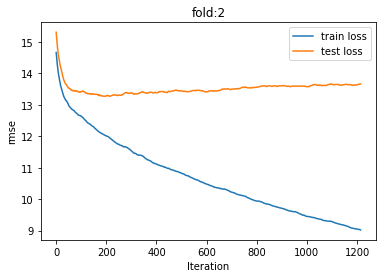

 - fold2_MAE : 13.272182


[I 2022-12-17 17:38:21,902] A new study created in memory with name: no-name-635d829b-7b28-4e44-a7ac-cd8404c6c282



★★★★★　　　　　Fold 3　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:24,789] Trial 0 finished with value: 13.515944008265912 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 13.515944008265912.


Early stopping, best iteration is:
[268]	Train's l1: 11.1669	Test's l1: 13.5159
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:28,537] Trial 1 finished with value: 13.429738921701166 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 13.429738921701166.


Early stopping, best iteration is:
[256]	Train's l1: 11.0275	Test's l1: 13.4297
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:32,802] Trial 2 finished with value: 13.402825581165128 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 13.402825581165128.


Early stopping, best iteration is:
[77]	Train's l1: 12.4065	Test's l1: 13.4028
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:36,873] Trial 3 finished with value: 13.37966658227147 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:40,294] Trial 4 finished with value: 13.46422669012302 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 13.37966658227147.


Early stopping, best iteration is:
[316]	Train's l1: 10.7596	Test's l1: 13.4642
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:47,647] Trial 5 finished with value: 13.402601943556377 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 13.37966658227147.


Early stopping, best iteration is:
[91]	Train's l1: 12.2515	Test's l1: 13.4026
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:52,037] Trial 6 finished with value: 13.404205451346268 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 13.37966658227147.


Early stopping, best iteration is:
[183]	Train's l1: 11.5034	Test's l1: 13.4042
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:38:56,188] Trial 7 finished with value: 13.37966658227147 and parameters: {'num_leaves': 177}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:00,323] Trial 8 finished with value: 13.37966658227147 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:04,472] Trial 9 finished with value: 13.37966658227147 and parameters: {'num_leaves': 150}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:08,639] Trial 10 finished with value: 13.37966658227147 and parameters: {'num_leaves': 64}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:12,900] Trial 11 finished with value: 13.37966658227147 and parameters: {'num_leaves': 163}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:17,098] Trial 12 finished with value: 13.37966658227147 and parameters: {'num_leaves': 156}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:21,308] Trial 13 finished with value: 13.37966658227147 and parameters: {'num_leaves': 161}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:25,492] Trial 14 finished with value: 13.37966658227147 and parameters: {'num_leaves': 133}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:29,783] Trial 15 finished with value: 13.37966658227147 and parameters: {'num_leaves': 199}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:34,072] Trial 16 finished with value: 13.37966658227147 and parameters: {'num_leaves': 216}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:38,334] Trial 17 finished with value: 13.37966658227147 and parameters: {'num_leaves': 254}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:42,484] Trial 18 finished with value: 13.37966658227147 and parameters: {'num_leaves': 68}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:44,905] Trial 19 finished with value: 13.435854805993733 and parameters: {'num_leaves': 10}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[151]	Train's l1: 12.5891	Test's l1: 13.4359
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:49,143] Trial 20 finished with value: 13.37966658227147 and parameters: {'num_leaves': 200}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:53,358] Trial 21 finished with value: 13.37966658227147 and parameters: {'num_leaves': 102}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:39:57,623] Trial 22 finished with value: 13.37966658227147 and parameters: {'num_leaves': 246}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:01,861] Trial 23 finished with value: 13.37966658227147 and parameters: {'num_leaves': 189}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:06,061] Trial 24 finished with value: 13.37966658227147 and parameters: {'num_leaves': 99}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:10,303] Trial 25 finished with value: 13.37966658227147 and parameters: {'num_leaves': 255}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:14,548] Trial 26 finished with value: 13.37966658227147 and parameters: {'num_leaves': 228}. Best is trial 7 with value: 13.37966658227147.


Early stopping, best iteration is:
[120]	Train's l1: 11.9765	Test's l1: 13.3797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:18,063] Trial 27 finished with value: 13.291056633107788 and parameters: {'bagging_fraction': 0.5853249737968937, 'bagging_freq': 5}. Best is trial 27 with value: 13.291056633107788.


Early stopping, best iteration is:
[458]	Train's l1: 11.2759	Test's l1: 13.2911
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:21,538] Trial 28 finished with value: 13.305681318637573 and parameters: {'bagging_fraction': 0.5796203191443507, 'bagging_freq': 7}. Best is trial 27 with value: 13.291056633107788.


Early stopping, best iteration is:
[469]	Train's l1: 11.2868	Test's l1: 13.3057
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:24,559] Trial 29 finished with value: 13.374459768140994 and parameters: {'bagging_fraction': 0.4431750230528859, 'bagging_freq': 6}. Best is trial 27 with value: 13.291056633107788.


Early stopping, best iteration is:
[667]	Train's l1: 11.4311	Test's l1: 13.3745
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:28,443] Trial 30 finished with value: 13.313189013566166 and parameters: {'bagging_fraction': 0.8748349565554332, 'bagging_freq': 1}. Best is trial 27 with value: 13.291056633107788.


Early stopping, best iteration is:
[159]	Train's l1: 11.8725	Test's l1: 13.3132
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:32,419] Trial 31 finished with value: 13.26088945522988 and parameters: {'bagging_fraction': 0.5929712963560705, 'bagging_freq': 7}. Best is trial 31 with value: 13.26088945522988.


Early stopping, best iteration is:
[635]	Train's l1: 10.7691	Test's l1: 13.2609
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:35,628] Trial 32 finished with value: 13.367996142759525 and parameters: {'bagging_fraction': 0.6728901346955665, 'bagging_freq': 1}. Best is trial 31 with value: 13.26088945522988.


Early stopping, best iteration is:
[206]	Train's l1: 11.9916	Test's l1: 13.368
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:38,307] Trial 33 finished with value: 13.476125165242637 and parameters: {'bagging_fraction': 0.42169278347501105, 'bagging_freq': 4}. Best is trial 31 with value: 13.26088945522988.


Early stopping, best iteration is:
[534]	Train's l1: 11.7709	Test's l1: 13.4761
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:41,030] Trial 34 finished with value: 13.345192735409348 and parameters: {'bagging_fraction': 0.40440288024483756, 'bagging_freq': 1}. Best is trial 31 with value: 13.26088945522988.


Early stopping, best iteration is:
[433]	Train's l1: 12.0525	Test's l1: 13.3452
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:44,661] Trial 35 finished with value: 13.210606751787795 and parameters: {'bagging_fraction': 0.5922601043070324, 'bagging_freq': 5}. Best is trial 35 with value: 13.210606751787795.


Early stopping, best iteration is:
[455]	Train's l1: 11.268	Test's l1: 13.2106
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:49,370] Trial 36 finished with value: 13.276371660868982 and parameters: {'bagging_fraction': 0.941651352877966, 'bagging_freq': 2}. Best is trial 35 with value: 13.210606751787795.


Early stopping, best iteration is:
[184]	Train's l1: 11.5693	Test's l1: 13.2764
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:53,162] Trial 37 finished with value: 13.285523934765978 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 13.285523934765978.


Early stopping, best iteration is:
[454]	Train's l1: 11.2868	Test's l1: 13.2855
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:40:56,480] Trial 38 finished with value: 13.26421166053619 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 38 with value: 13.26421166053619.


Early stopping, best iteration is:
[453]	Train's l1: 11.2748	Test's l1: 13.2642
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:00,064] Trial 39 finished with value: 13.28996503456258 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 38 with value: 13.26421166053619.


Early stopping, best iteration is:
[454]	Train's l1: 11.2739	Test's l1: 13.29
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:03,487] Trial 40 finished with value: 13.244855488148385 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 40 with value: 13.244855488148385.


Early stopping, best iteration is:
[456]	Train's l1: 11.2688	Test's l1: 13.2449
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:06,950] Trial 41 finished with value: 13.264721800584399 and parameters: {'feature_fraction': 0.784}. Best is trial 40 with value: 13.244855488148385.


Early stopping, best iteration is:
[455]	Train's l1: 11.274	Test's l1: 13.2647
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:10,509] Trial 42 finished with value: 13.252471523058304 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 40 with value: 13.244855488148385.


Early stopping, best iteration is:
[455]	Train's l1: 11.2856	Test's l1: 13.2525
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:14,170] Trial 43 finished with value: 13.210606750903592 and parameters: {'lambda_l1': 1.004671267845747e-05, 'lambda_l2': 5.605344282499664e-07}. Best is trial 43 with value: 13.210606750903592.


Early stopping, best iteration is:
[455]	Train's l1: 11.268	Test's l1: 13.2106
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:17,674] Trial 44 finished with value: 13.210606734772377 and parameters: {'lambda_l1': 1.7446684496777619e-06, 'lambda_l2': 1.6408417022062196e-05}. Best is trial 44 with value: 13.210606734772377.


Early stopping, best iteration is:
[455]	Train's l1: 11.268	Test's l1: 13.2106
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:21,227] Trial 45 finished with value: 13.254022072719765 and parameters: {'lambda_l1': 0.0011706432288445846, 'lambda_l2': 6.794023762360751e-06}. Best is trial 44 with value: 13.210606734772377.


Early stopping, best iteration is:
[460]	Train's l1: 11.2723	Test's l1: 13.254
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:24,773] Trial 46 finished with value: 13.231398086386394 and parameters: {'lambda_l1': 0.0005591742016869982, 'lambda_l2': 0.0023980323247164864}. Best is trial 44 with value: 13.210606734772377.


Early stopping, best iteration is:
[455]	Train's l1: 11.2765	Test's l1: 13.2314
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:28,272] Trial 47 finished with value: 13.278054099749408 and parameters: {'lambda_l1': 0.3768766559829406, 'lambda_l2': 0.00011384227614355794}. Best is trial 44 with value: 13.210606734772377.


Early stopping, best iteration is:
[455]	Train's l1: 11.26	Test's l1: 13.2781
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:31,799] Trial 48 finished with value: 13.254022475719022 and parameters: {'lambda_l1': 0.00025051812462094066, 'lambda_l2': 9.430286730426088e-08}. Best is trial 44 with value: 13.210606734772377.


Early stopping, best iteration is:
[460]	Train's l1: 11.2723	Test's l1: 13.254
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:35,308] Trial 49 finished with value: 13.232504305422479 and parameters: {'lambda_l1': 1.6992050935894372, 'lambda_l2': 0.002293753857781844}. Best is trial 44 with value: 13.210606734772377.


Early stopping, best iteration is:
[454]	Train's l1: 11.2684	Test's l1: 13.2325
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:38,796] Trial 50 finished with value: 13.218910892256558 and parameters: {'lambda_l1': 4.5727596635157754e-05, 'lambda_l2': 0.006880590757036246}. Best is trial 44 with value: 13.210606734772377.


Early stopping, best iteration is:
[456]	Train's l1: 11.2793	Test's l1: 13.2189
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:42,301] Trial 51 finished with value: 13.201447622515028 and parameters: {'lambda_l1': 0.00012069414275979022, 'lambda_l2': 0.3061718328684912}. Best is trial 51 with value: 13.201447622515028.


Early stopping, best iteration is:
[453]	Train's l1: 11.2855	Test's l1: 13.2014
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:45,868] Trial 52 finished with value: 13.231397673448376 and parameters: {'lambda_l1': 0.0033677266934167664, 'lambda_l2': 0.00229399074913957}. Best is trial 51 with value: 13.201447622515028.


Early stopping, best iteration is:
[455]	Train's l1: 11.2765	Test's l1: 13.2314
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:49,364] Trial 53 finished with value: 13.277711344837705 and parameters: {'lambda_l1': 1.0319430675342326e-08, 'lambda_l2': 5.663837819660722}. Best is trial 51 with value: 13.201447622515028.


Early stopping, best iteration is:
[457]	Train's l1: 11.3419	Test's l1: 13.2777
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:52,810] Trial 54 finished with value: 13.266544175065846 and parameters: {'lambda_l1': 2.9019642168882427e-07, 'lambda_l2': 6.1475087228635745}. Best is trial 51 with value: 13.201447622515028.


Early stopping, best iteration is:
[455]	Train's l1: 11.3269	Test's l1: 13.2665
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:56,328] Trial 55 finished with value: 13.188408084231616 and parameters: {'lambda_l1': 7.392089677775082e-07, 'lambda_l2': 0.32233214266871124}. Best is trial 55 with value: 13.188408084231616.


Early stopping, best iteration is:
[455]	Train's l1: 11.2633	Test's l1: 13.1884
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:41:59,828] Trial 56 finished with value: 13.20156646417183 and parameters: {'lambda_l1': 7.708177108208601e-08, 'lambda_l2': 0.164909634145174}. Best is trial 55 with value: 13.188408084231616.


Early stopping, best iteration is:
[452]	Train's l1: 11.2904	Test's l1: 13.2016
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:03,373] Trial 57 finished with value: 13.247430168304879 and parameters: {'lambda_l1': 0.12554587611244414, 'lambda_l2': 0.23314925247705767}. Best is trial 55 with value: 13.188408084231616.


Early stopping, best iteration is:
[455]	Train's l1: 11.277	Test's l1: 13.2474
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:06,918] Trial 58 finished with value: 13.263737219020207 and parameters: {'lambda_l1': 0.010720831379406893, 'lambda_l2': 0.1245417421671279}. Best is trial 55 with value: 13.188408084231616.


Early stopping, best iteration is:
[456]	Train's l1: 11.246	Test's l1: 13.2637
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:13,523] Trial 59 finished with value: 13.216407242777617 and parameters: {'lambda_l1': 7.832321071250692e-06, 'lambda_l2': 0.6327895653965518}. Best is trial 55 with value: 13.188408084231616.


Early stopping, best iteration is:
[455]	Train's l1: 11.2628	Test's l1: 13.2164
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:17,036] Trial 60 finished with value: 13.2160627564412 and parameters: {'lambda_l1': 3.978194074836823e-07, 'lambda_l2': 0.026129051844517963}. Best is trial 55 with value: 13.188408084231616.


Early stopping, best iteration is:
[455]	Train's l1: 11.273	Test's l1: 13.2161
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:20,522] Trial 61 finished with value: 13.19956866435201 and parameters: {'lambda_l1': 3.277983076692759e-05, 'lambda_l2': 1.2252641798315218}. Best is trial 55 with value: 13.188408084231616.


Early stopping, best iteration is:
[455]	Train's l1: 11.2823	Test's l1: 13.1996
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:24,005] Trial 62 finished with value: 13.275189603344252 and parameters: {'lambda_l1': 1.2803371718012111e-08, 'lambda_l2': 4.664258345106709}. Best is trial 55 with value: 13.188408084231616.


Early stopping, best iteration is:
[457]	Train's l1: 11.3193	Test's l1: 13.2752
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:27,554] Trial 63 finished with value: 13.188408084231616 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 13.188408084231616.


Early stopping, best iteration is:
[455]	Train's l1: 11.2633	Test's l1: 13.1884
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:31,041] Trial 64 finished with value: 13.188408084231616 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 13.188408084231616.


Early stopping, best iteration is:
[455]	Train's l1: 11.2633	Test's l1: 13.1884
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:34,547] Trial 65 finished with value: 13.188408084231616 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 13.188408084231616.


Early stopping, best iteration is:
[455]	Train's l1: 11.2633	Test's l1: 13.1884
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:38,037] Trial 66 finished with value: 13.188408084231616 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 13.188408084231616.


Early stopping, best iteration is:
[455]	Train's l1: 11.2633	Test's l1: 13.1884
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:41,536] Trial 67 finished with value: 13.188408084231616 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 13.188408084231616.


Early stopping, best iteration is:
[455]	Train's l1: 11.2633	Test's l1: 13.1884
▼▼▼▼▼　　　　　Fold 3　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 7.392089677775082e-07, 'lambda_l2': 0.32233214266871124, 'num_leaves': 31, 'feature_fraction': 0.8, 'bagging_fraction': 0.5922601043070324, 'bagging_freq': 5, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


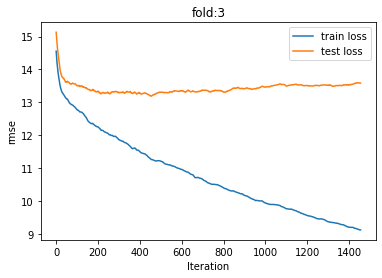

[I 2022-12-17 17:42:41,863] A new study created in memory with name: no-name-5cd8948d-2b76-4914-8920-39805ac8eaca


 - fold3_MAE : 13.188408

★★★★★　　　　　Fold 4　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:45,994] Trial 0 finished with value: 13.069782702543021 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 13.069782702543021.


Early stopping, best iteration is:
[86]	Train's l1: 12.4776	Test's l1: 13.0698
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:48,871] Trial 1 finished with value: 13.067881921728567 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 13.067881921728567.


Early stopping, best iteration is:
[79]	Train's l1: 12.5947	Test's l1: 13.0679
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:53,326] Trial 2 finished with value: 13.089045485807414 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 13.067881921728567.


Early stopping, best iteration is:
[86]	Train's l1: 12.4832	Test's l1: 13.089
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:42:56,951] Trial 3 finished with value: 13.073351340145196 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 13.067881921728567.


Early stopping, best iteration is:
[55]	Train's l1: 12.8436	Test's l1: 13.0734
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:00,679] Trial 4 finished with value: 13.014654627026804 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 13.014654627026804.


Early stopping, best iteration is:
[232]	Train's l1: 11.4028	Test's l1: 13.0147
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:03,161] Trial 5 finished with value: 13.008629844908105 and parameters: {'feature_fraction': 0.4}. Best is trial 5 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:08,016] Trial 6 finished with value: 13.04554675461294 and parameters: {'feature_fraction': 1.0}. Best is trial 5 with value: 13.008629844908105.


Early stopping, best iteration is:
[99]	Train's l1: 12.3497	Test's l1: 13.0455
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:10,494] Trial 7 finished with value: 13.008629844908105 and parameters: {'num_leaves': 219}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:13,034] Trial 8 finished with value: 13.008629844908105 and parameters: {'num_leaves': 213}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:15,156] Trial 9 finished with value: 13.029587976766226 and parameters: {'num_leaves': 18}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[79]	Train's l1: 12.7475	Test's l1: 13.0296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:17,683] Trial 10 finished with value: 13.008629844908105 and parameters: {'num_leaves': 138}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:20,078] Trial 11 finished with value: 13.008629844908105 and parameters: {'num_leaves': 60}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:22,507] Trial 12 finished with value: 13.008629844908105 and parameters: {'num_leaves': 55}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:24,141] Trial 13 finished with value: 13.079683168784895 and parameters: {'num_leaves': 12}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[79]	Train's l1: 12.981	Test's l1: 13.0797
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:26,546] Trial 14 finished with value: 13.008629844908105 and parameters: {'num_leaves': 105}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:28,981] Trial 15 finished with value: 13.008629844908105 and parameters: {'num_leaves': 88}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:31,423] Trial 16 finished with value: 13.008629844908105 and parameters: {'num_leaves': 102}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:33,917] Trial 17 finished with value: 13.008629844908105 and parameters: {'num_leaves': 254}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:36,353] Trial 18 finished with value: 13.008629844908105 and parameters: {'num_leaves': 221}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:38,842] Trial 19 finished with value: 13.008629844908105 and parameters: {'num_leaves': 181}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:41,290] Trial 20 finished with value: 13.008629844908105 and parameters: {'num_leaves': 172}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:43,748] Trial 21 finished with value: 13.008629844908105 and parameters: {'num_leaves': 218}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:46,258] Trial 22 finished with value: 13.008629844908105 and parameters: {'num_leaves': 256}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:48,801] Trial 23 finished with value: 13.008629844908105 and parameters: {'num_leaves': 178}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:51,282] Trial 24 finished with value: 13.008629844908105 and parameters: {'num_leaves': 212}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:53,764] Trial 25 finished with value: 13.008629844908105 and parameters: {'num_leaves': 252}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:56,253] Trial 26 finished with value: 13.008629844908105 and parameters: {'num_leaves': 168}. Best is trial 7 with value: 13.008629844908105.


Early stopping, best iteration is:
[85]	Train's l1: 12.5508	Test's l1: 13.0086
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:43:58,836] Trial 27 finished with value: 12.985344290188863 and parameters: {'bagging_fraction': 0.5035852115932895, 'bagging_freq': 5}. Best is trial 27 with value: 12.985344290188863.


Early stopping, best iteration is:
[845]	Train's l1: 11.1488	Test's l1: 12.9853
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:01,541] Trial 28 finished with value: 12.924161741640999 and parameters: {'bagging_fraction': 0.4858039034056574, 'bagging_freq': 3}. Best is trial 28 with value: 12.924161741640999.


Early stopping, best iteration is:
[882]	Train's l1: 11.1094	Test's l1: 12.9242
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:04,371] Trial 29 finished with value: 13.005931569129869 and parameters: {'bagging_fraction': 0.9505130537048021, 'bagging_freq': 1}. Best is trial 28 with value: 12.924161741640999.


Early stopping, best iteration is:
[270]	Train's l1: 11.3995	Test's l1: 13.0059
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:06,612] Trial 30 finished with value: 13.053997890980302 and parameters: {'bagging_fraction': 0.6762828959545955, 'bagging_freq': 1}. Best is trial 28 with value: 12.924161741640999.


Early stopping, best iteration is:
[317]	Train's l1: 11.8453	Test's l1: 13.054
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:09,393] Trial 31 finished with value: 13.072535536024938 and parameters: {'bagging_fraction': 0.7714040457384728, 'bagging_freq': 3}. Best is trial 28 with value: 12.924161741640999.


Early stopping, best iteration is:
[330]	Train's l1: 11.4734	Test's l1: 13.0725
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:12,571] Trial 32 finished with value: 13.010093239607912 and parameters: {'bagging_fraction': 0.9503434910422193, 'bagging_freq': 2}. Best is trial 28 with value: 12.924161741640999.


Early stopping, best iteration is:
[220]	Train's l1: 11.6886	Test's l1: 13.0101
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:15,207] Trial 33 finished with value: 13.029805776880158 and parameters: {'bagging_fraction': 0.7048896489114111, 'bagging_freq': 3}. Best is trial 28 with value: 12.924161741640999.


Early stopping, best iteration is:
[339]	Train's l1: 11.6479	Test's l1: 13.0298
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:18,570] Trial 34 finished with value: 12.989251344044977 and parameters: {'bagging_fraction': 0.9462518886356656, 'bagging_freq': 3}. Best is trial 28 with value: 12.924161741640999.


Early stopping, best iteration is:
[322]	Train's l1: 11.1559	Test's l1: 12.9893
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:21,695] Trial 35 finished with value: 12.963006008087216 and parameters: {'bagging_fraction': 0.4921977343580795, 'bagging_freq': 7}. Best is trial 28 with value: 12.924161741640999.


Early stopping, best iteration is:
[1190]	Train's l1: 10.5576	Test's l1: 12.963
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:24,730] Trial 36 finished with value: 12.845146358269577 and parameters: {'bagging_fraction': 0.4173872853508229, 'bagging_freq': 7}. Best is trial 36 with value: 12.845146358269577.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:27,942] Trial 37 finished with value: 12.88330967886982 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 12.88330967886982.


Early stopping, best iteration is:
[1477]	Train's l1: 10.6868	Test's l1: 12.8833
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:31,107] Trial 38 finished with value: 12.86861785217761 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 38 with value: 12.86861785217761.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6445	Test's l1: 12.8686
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:34,430] Trial 39 finished with value: 12.888679812727998 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 38 with value: 12.86861785217761.


Early stopping, best iteration is:
[1477]	Train's l1: 10.6484	Test's l1: 12.8887
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:37,485] Trial 40 finished with value: 12.927879397630326 and parameters: {'lambda_l1': 1.6945737753074859, 'lambda_l2': 0.06905293175680956}. Best is trial 40 with value: 12.927879397630326.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6686	Test's l1: 12.9279
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:40,536] Trial 41 finished with value: 12.845146355570117 and parameters: {'lambda_l1': 5.149322414257562e-08, 'lambda_l2': 1.9743116578508346e-06}. Best is trial 41 with value: 12.845146355570117.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:43,638] Trial 42 finished with value: 12.880454237383908 and parameters: {'lambda_l1': 1.097793236567703, 'lambda_l2': 5.602359005331122e-06}. Best is trial 41 with value: 12.845146355570117.


Early stopping, best iteration is:
[1502]	Train's l1: 10.6847	Test's l1: 12.8805
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:46,746] Trial 43 finished with value: 12.845146330696071 and parameters: {'lambda_l1': 3.4148469721115586e-05, 'lambda_l2': 4.7135862355685745e-06}. Best is trial 43 with value: 12.845146330696071.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:49,144] Trial 44 finished with value: 12.89467766683344 and parameters: {'lambda_l1': 5.4607849604574276e-08, 'lambda_l2': 0.009355987334162036}. Best is trial 43 with value: 12.845146330696071.


Early stopping, best iteration is:
[924]	Train's l1: 11.4402	Test's l1: 12.8947
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:52,317] Trial 45 finished with value: 12.845146348762773 and parameters: {'lambda_l1': 1.858014001487026e-06, 'lambda_l2': 4.544365712324658e-06}. Best is trial 43 with value: 12.845146330696071.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:55,410] Trial 46 finished with value: 12.845146145720532 and parameters: {'lambda_l1': 0.0004280362098823436, 'lambda_l2': 2.2279707153179396e-06}. Best is trial 46 with value: 12.845146145720532.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:44:58,512] Trial 47 finished with value: 12.8451463583542 and parameters: {'lambda_l1': 1.9855437680137164e-08, 'lambda_l2': 4.604908682781674e-08}. Best is trial 46 with value: 12.845146145720532.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:00,379] Trial 48 finished with value: 12.880966788921077 and parameters: {'lambda_l1': 0.1359946945088885, 'lambda_l2': 2.9209922057855405e-07}. Best is trial 46 with value: 12.845146145720532.


Early stopping, best iteration is:
[553]	Train's l1: 12.0608	Test's l1: 12.881
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:03,418] Trial 49 finished with value: 12.908868855570088 and parameters: {'lambda_l1': 9.167910983938137, 'lambda_l2': 0.00023577620806864802}. Best is trial 46 with value: 12.845146145720532.


Early stopping, best iteration is:
[1505]	Train's l1: 10.7278	Test's l1: 12.9089
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:06,488] Trial 50 finished with value: 12.882787158339728 and parameters: {'lambda_l1': 0.0049597049361655154, 'lambda_l2': 5.570380817124758}. Best is trial 46 with value: 12.845146145720532.


Early stopping, best iteration is:
[1504]	Train's l1: 10.7182	Test's l1: 12.8828
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:09,577] Trial 51 finished with value: 12.845146055799605 and parameters: {'lambda_l1': 8.595188845078022e-05, 'lambda_l2': 0.0001230363069547914}. Best is trial 51 with value: 12.845146055799605.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:12,703] Trial 52 finished with value: 12.84514546487219 and parameters: {'lambda_l1': 0.0009190338785321732, 'lambda_l2': 0.00021222759922146745}. Best is trial 52 with value: 12.84514546487219.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:15,846] Trial 53 finished with value: 12.845144762982846 and parameters: {'lambda_l1': 0.0018287588675832567, 'lambda_l2': 0.0003358892270706453}. Best is trial 53 with value: 12.845144762982846.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:18,213] Trial 54 finished with value: 12.894679154050195 and parameters: {'lambda_l1': 0.010291307040193255, 'lambda_l2': 0.006029728037462934}. Best is trial 53 with value: 12.845144762982846.


Early stopping, best iteration is:
[924]	Train's l1: 11.4402	Test's l1: 12.8947
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:20,594] Trial 55 finished with value: 12.894684444738601 and parameters: {'lambda_l1': 0.005571068169044983, 'lambda_l2': 0.0024753247631162595}. Best is trial 53 with value: 12.845144762982846.


Early stopping, best iteration is:
[924]	Train's l1: 11.4401	Test's l1: 12.8947
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:23,755] Trial 56 finished with value: 12.88569491355196 and parameters: {'lambda_l1': 2.5869675821275283e-06, 'lambda_l2': 0.37156910321775133}. Best is trial 53 with value: 12.845144762982846.


Early stopping, best iteration is:
[1504]	Train's l1: 10.6863	Test's l1: 12.8857
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:26,867] Trial 57 finished with value: 12.845145866312818 and parameters: {'lambda_l1': 0.000718411334579006, 'lambda_l2': 6.854761918430773e-05}. Best is trial 53 with value: 12.845144762982846.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:29,961] Trial 58 finished with value: 12.845144725539713 and parameters: {'lambda_l1': 7.888039793612924e-06, 'lambda_l2': 0.0007660114463138521}. Best is trial 58 with value: 12.845144725539713.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:35,434] Trial 59 finished with value: 12.894686987309157 and parameters: {'lambda_l1': 3.3512950559820593e-06, 'lambda_l2': 0.0014261124582990235}. Best is trial 58 with value: 12.845144725539713.


Early stopping, best iteration is:
[924]	Train's l1: 11.4401	Test's l1: 12.8947
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:38,496] Trial 60 finished with value: 12.845144725539713 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 12.845144725539713.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:41,573] Trial 61 finished with value: 12.845144725539713 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 12.845144725539713.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:44,711] Trial 62 finished with value: 12.845144725539713 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 12.845144725539713.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:47,776] Trial 63 finished with value: 12.845144725539713 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 12.845144725539713.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:50,923] Trial 64 finished with value: 12.845144725539713 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 12.845144725539713.


Early stopping, best iteration is:
[1505]	Train's l1: 10.6504	Test's l1: 12.8451
▼▼▼▼▼　　　　　Fold 4　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 7.888039793612924e-06, 'lambda_l2': 0.0007660114463138521, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.4173872853508229, 'bagging_freq': 7, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


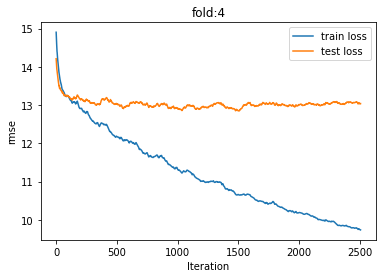

 - fold4_MAE : 12.845145


[I 2022-12-17 17:45:51,643] A new study created in memory with name: no-name-7807b752-c473-40f8-8479-667ca91275d5



★★★★★　　　　　Fold 5　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:55,619] Trial 0 finished with value: 13.67557872030007 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 13.67557872030007.


Early stopping, best iteration is:
[42]	Train's l1: 12.7356	Test's l1: 13.6756
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:45:58,739] Trial 1 finished with value: 13.680321166757976 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 13.67557872030007.


Early stopping, best iteration is:
[46]	Train's l1: 12.684	Test's l1: 13.6803
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:03,405] Trial 2 finished with value: 13.63315704604016 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:07,718] Trial 3 finished with value: 13.661684457757248 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 13.63315704604016.


Early stopping, best iteration is:
[41]	Train's l1: 12.73	Test's l1: 13.6617
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:10,016] Trial 4 finished with value: 13.787715162403693 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 13.63315704604016.


Early stopping, best iteration is:
[44]	Train's l1: 12.7892	Test's l1: 13.7877
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:12,760] Trial 5 finished with value: 13.727877126219216 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 13.63315704604016.


Early stopping, best iteration is:
[46]	Train's l1: 12.6988	Test's l1: 13.7279
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:16,374] Trial 6 finished with value: 13.694398111304704 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 13.63315704604016.


Early stopping, best iteration is:
[45]	Train's l1: 12.7141	Test's l1: 13.6944
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:20,993] Trial 7 finished with value: 13.63315704604016 and parameters: {'num_leaves': 32}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:25,649] Trial 8 finished with value: 13.63315704604016 and parameters: {'num_leaves': 192}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:30,218] Trial 9 finished with value: 13.63315704604016 and parameters: {'num_leaves': 161}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:34,821] Trial 10 finished with value: 13.63315704604016 and parameters: {'num_leaves': 80}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:39,437] Trial 11 finished with value: 13.63315704604016 and parameters: {'num_leaves': 75}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:44,064] Trial 12 finished with value: 13.63315704604016 and parameters: {'num_leaves': 30}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:48,736] Trial 13 finished with value: 13.63315704604016 and parameters: {'num_leaves': 59}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:53,330] Trial 14 finished with value: 13.63315704604016 and parameters: {'num_leaves': 155}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:46:57,344] Trial 15 finished with value: 13.648455040561448 and parameters: {'num_leaves': 19}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[37]	Train's l1: 12.8592	Test's l1: 13.6485
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:01,969] Trial 16 finished with value: 13.63315704604016 and parameters: {'num_leaves': 106}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:06,627] Trial 17 finished with value: 13.63315704604016 and parameters: {'num_leaves': 232}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:11,245] Trial 18 finished with value: 13.63315704604016 and parameters: {'num_leaves': 206}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:15,864] Trial 19 finished with value: 13.63315704604016 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:20,520] Trial 20 finished with value: 13.63315704604016 and parameters: {'num_leaves': 247}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:25,023] Trial 21 finished with value: 13.63315704604016 and parameters: {'num_leaves': 126}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:29,736] Trial 22 finished with value: 13.63315704604016 and parameters: {'num_leaves': 164}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:34,350] Trial 23 finished with value: 13.63315704604016 and parameters: {'num_leaves': 105}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:38,961] Trial 24 finished with value: 13.63315704604016 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:40,653] Trial 25 finished with value: 13.914342320356699 and parameters: {'num_leaves': 5}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[48]	Train's l1: 13.3566	Test's l1: 13.9143
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:45,271] Trial 26 finished with value: 13.63315704604016 and parameters: {'num_leaves': 104}. Best is trial 7 with value: 13.63315704604016.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:50,341] Trial 27 finished with value: 13.640673526946216 and parameters: {'bagging_fraction': 0.9713118779035108, 'bagging_freq': 5}. Best is trial 27 with value: 13.640673526946216.


Early stopping, best iteration is:
[48]	Train's l1: 12.6298	Test's l1: 13.6407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:53,630] Trial 28 finished with value: 13.801896100479073 and parameters: {'bagging_fraction': 0.6756881476805301, 'bagging_freq': 1}. Best is trial 27 with value: 13.640673526946216.


Early stopping, best iteration is:
[45]	Train's l1: 12.8828	Test's l1: 13.8019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:47:57,667] Trial 29 finished with value: 13.737131642612292 and parameters: {'bagging_fraction': 0.8019210533547496, 'bagging_freq': 5}. Best is trial 27 with value: 13.640673526946216.


Early stopping, best iteration is:
[38]	Train's l1: 12.9028	Test's l1: 13.7371
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:00,584] Trial 30 finished with value: 13.85217600221422 and parameters: {'bagging_fraction': 0.5747017389232294, 'bagging_freq': 1}. Best is trial 27 with value: 13.640673526946216.


Early stopping, best iteration is:
[41]	Train's l1: 13.0503	Test's l1: 13.8522
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:05,490] Trial 31 finished with value: 13.704781045136798 and parameters: {'bagging_fraction': 0.931054646171848, 'bagging_freq': 2}. Best is trial 27 with value: 13.640673526946216.


Early stopping, best iteration is:
[46]	Train's l1: 12.6365	Test's l1: 13.7048
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:10,131] Trial 32 finished with value: 13.738482806003633 and parameters: {'bagging_fraction': 0.9121072920235714, 'bagging_freq': 6}. Best is trial 27 with value: 13.640673526946216.


Early stopping, best iteration is:
[47]	Train's l1: 12.6736	Test's l1: 13.7385
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:14,129] Trial 33 finished with value: 13.749840695965517 and parameters: {'bagging_fraction': 0.7910787634807075, 'bagging_freq': 6}. Best is trial 27 with value: 13.640673526946216.


Early stopping, best iteration is:
[50]	Train's l1: 12.7726	Test's l1: 13.7498
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:16,852] Trial 34 finished with value: 13.920815327305194 and parameters: {'bagging_fraction': 0.5015036721930399, 'bagging_freq': 6}. Best is trial 27 with value: 13.640673526946216.


Early stopping, best iteration is:
[70]	Train's l1: 12.9007	Test's l1: 13.9208
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:21,330] Trial 35 finished with value: 13.740817501748053 and parameters: {'bagging_fraction': 0.8665945954697889, 'bagging_freq': 7}. Best is trial 27 with value: 13.640673526946216.


Early stopping, best iteration is:
[43]	Train's l1: 12.7548	Test's l1: 13.7408
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:24,554] Trial 36 finished with value: 13.79026660159664 and parameters: {'bagging_fraction': 0.5948238374271659, 'bagging_freq': 6}. Best is trial 27 with value: 13.640673526946216.


Early stopping, best iteration is:
[72]	Train's l1: 12.7251	Test's l1: 13.7903
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:29,007] Trial 37 finished with value: 13.634854028553152 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 13.634854028553152.


Early stopping, best iteration is:
[41]	Train's l1: 12.7356	Test's l1: 13.6349
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:33,791] Trial 38 finished with value: 13.636117129479619 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 13.634854028553152.


Early stopping, best iteration is:
[43]	Train's l1: 12.6809	Test's l1: 13.6361
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:38,258] Trial 39 finished with value: 13.648512121371267 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 13.634854028553152.


Early stopping, best iteration is:
[41]	Train's l1: 12.7263	Test's l1: 13.6485
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:42,960] Trial 40 finished with value: 13.628863276825381 and parameters: {'lambda_l1': 0.21277997278106225, 'lambda_l2': 1.0233444633271002e-08}. Best is trial 40 with value: 13.628863276825381.


Early stopping, best iteration is:
[40]	Train's l1: 12.7379	Test's l1: 13.6289
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:47,637] Trial 41 finished with value: 13.665587011116333 and parameters: {'lambda_l1': 8.073344250046535e-06, 'lambda_l2': 9.26916213211972}. Best is trial 40 with value: 13.628863276825381.


Early stopping, best iteration is:
[47]	Train's l1: 12.6758	Test's l1: 13.6656
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:55,409] Trial 42 finished with value: 13.637966720557483 and parameters: {'lambda_l1': 0.974345822053521, 'lambda_l2': 0.28352594099213946}. Best is trial 40 with value: 13.628863276825381.


Early stopping, best iteration is:
[39]	Train's l1: 12.7496	Test's l1: 13.638
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:48:59,997] Trial 43 finished with value: 13.625877938557593 and parameters: {'lambda_l1': 3.0114955610639697e-07, 'lambda_l2': 0.3317469598114197}. Best is trial 43 with value: 13.625877938557593.


Early stopping, best iteration is:
[41]	Train's l1: 12.7213	Test's l1: 13.6259
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:04,572] Trial 44 finished with value: 13.641485897547467 and parameters: {'lambda_l1': 1.0680473034353857e-06, 'lambda_l2': 0.883388309719867}. Best is trial 43 with value: 13.625877938557593.


Early stopping, best iteration is:
[39]	Train's l1: 12.757	Test's l1: 13.6415
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:09,051] Trial 45 finished with value: 13.633157046126394 and parameters: {'lambda_l1': 1.9889949259531124e-07, 'lambda_l2': 2.3892708304196862e-08}. Best is trial 43 with value: 13.625877938557593.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:13,572] Trial 46 finished with value: 13.625995142349671 and parameters: {'lambda_l1': 0.39691129017744836, 'lambda_l2': 0.13397901002905138}. Best is trial 43 with value: 13.625877938557593.


Early stopping, best iteration is:
[41]	Train's l1: 12.7197	Test's l1: 13.626
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:18,076] Trial 47 finished with value: 13.638022811719912 and parameters: {'lambda_l1': 1.5737297092003888, 'lambda_l2': 0.12375319640614726}. Best is trial 43 with value: 13.625877938557593.


Early stopping, best iteration is:
[39]	Train's l1: 12.7494	Test's l1: 13.638
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:22,572] Trial 48 finished with value: 13.628164982272715 and parameters: {'lambda_l1': 0.10101289575071222, 'lambda_l2': 0.05034627703854684}. Best is trial 43 with value: 13.625877938557593.


Early stopping, best iteration is:
[40]	Train's l1: 12.7377	Test's l1: 13.6282
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:26,969] Trial 49 finished with value: 13.644898203038666 and parameters: {'lambda_l1': 5.699351163986561, 'lambda_l2': 0.0011260100670938144}. Best is trial 43 with value: 13.625877938557593.


Early stopping, best iteration is:
[42]	Train's l1: 12.7151	Test's l1: 13.6449
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:31,390] Trial 50 finished with value: 13.633157050724941 and parameters: {'lambda_l1': 1.1742731528974615e-08, 'lambda_l2': 8.763455989242022e-06}. Best is trial 43 with value: 13.625877938557593.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:35,897] Trial 51 finished with value: 13.633158246896684 and parameters: {'lambda_l1': 0.0016660772510465943, 'lambda_l2': 0.0011711000013464375}. Best is trial 43 with value: 13.625877938557593.


Early stopping, best iteration is:
[42]	Train's l1: 12.7008	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:40,291] Trial 52 finished with value: 13.621510761874765 and parameters: {'lambda_l1': 0.0010044457528346504, 'lambda_l2': 0.006331592643468858}. Best is trial 52 with value: 13.621510761874765.


Early stopping, best iteration is:
[39]	Train's l1: 12.7481	Test's l1: 13.6215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:44,751] Trial 53 finished with value: 13.633157168580796 and parameters: {'lambda_l1': 0.0003144970204296629, 'lambda_l2': 3.108545666840399e-05}. Best is trial 52 with value: 13.621510761874765.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:49,236] Trial 54 finished with value: 13.621512474499854 and parameters: {'lambda_l1': 0.00013371400517551413, 'lambda_l2': 0.008063801755781147}. Best is trial 52 with value: 13.621510761874765.


Early stopping, best iteration is:
[39]	Train's l1: 12.7481	Test's l1: 13.6215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:53,659] Trial 55 finished with value: 13.621514107540893 and parameters: {'lambda_l1': 0.0007050909958695614, 'lambda_l2': 0.00928796861352431}. Best is trial 52 with value: 13.621510761874765.


Early stopping, best iteration is:
[39]	Train's l1: 12.7481	Test's l1: 13.6215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:49:58,176] Trial 56 finished with value: 13.633159718321975 and parameters: {'lambda_l1': 0.007832464051172413, 'lambda_l2': 6.500062324662883e-05}. Best is trial 52 with value: 13.621510761874765.


Early stopping, best iteration is:
[42]	Train's l1: 12.7008	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:50:02,654] Trial 57 finished with value: 13.63315707090388 and parameters: {'lambda_l1': 6.705714828820137e-05, 'lambda_l2': 4.314753399187329e-06}. Best is trial 52 with value: 13.621510761874765.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:50:07,119] Trial 58 finished with value: 13.621517691923996 and parameters: {'lambda_l1': 0.01853974862087535, 'lambda_l2': 0.006925237541720142}. Best is trial 52 with value: 13.621510761874765.


Early stopping, best iteration is:
[39]	Train's l1: 12.7481	Test's l1: 13.6215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:50:11,576] Trial 59 finished with value: 13.633157054354108 and parameters: {'lambda_l1': 2.2019318886645443e-05, 'lambda_l2': 6.529998566523876e-07}. Best is trial 52 with value: 13.621510761874765.


Early stopping, best iteration is:
[42]	Train's l1: 12.7007	Test's l1: 13.6332
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:50:16,179] Trial 60 finished with value: 13.621510761874765 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 13.621510761874765.


Early stopping, best iteration is:
[39]	Train's l1: 12.7481	Test's l1: 13.6215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:50:20,756] Trial 61 finished with value: 13.621510761874765 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 13.621510761874765.


Early stopping, best iteration is:
[39]	Train's l1: 12.7481	Test's l1: 13.6215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:50:25,247] Trial 62 finished with value: 13.621510761874765 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 13.621510761874765.


Early stopping, best iteration is:
[39]	Train's l1: 12.7481	Test's l1: 13.6215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:50:29,824] Trial 63 finished with value: 13.621510761874765 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 13.621510761874765.


Early stopping, best iteration is:
[39]	Train's l1: 12.7481	Test's l1: 13.6215
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-17 17:50:34,328] Trial 64 finished with value: 13.621510761874765 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 13.621510761874765.


Early stopping, best iteration is:
[39]	Train's l1: 12.7481	Test's l1: 13.6215
▼▼▼▼▼　　　　　Fold 5　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.035, 'random_state': 1026, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.0010044457528346504, 'lambda_l2': 0.006331592643468858, 'num_leaves': 31, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


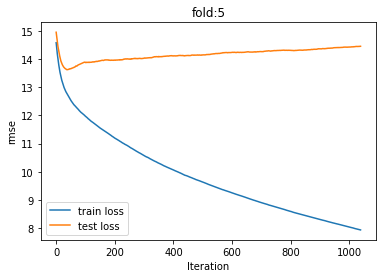

 - fold5_MAE : 13.621511
 - CV_MAE : 13.202532


In [ ]:
kf_cv = list(kf.split(df_train_gluer_x))
oof_valid_lgb_sub_gluer, lgb_models_sub_gluer = fit_lgb_oputuna(x=df_train_gluer_x, y=df_train_gluer_sub_y, cv=kf_cv,
                                      model_params=optuna_model_params, fit_params=oputuna_fit_params
                                     )

In [ ]:
file_path = f'lgb_models_sub_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_sub_gluer, f)

file_path = f'oof_valid_lgb_sub_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_sub_gluer, f)

In [ ]:
#%cd "/content/drive/MyDrive/マナビDX_Quest/PBL05/data/models-bk"
%cd "/content/drive/MyDrive/マナビDX_Quest/PBL05/data"

/content/drive/MyDrive/マナビDX_Quest/PBL05/data


In [ ]:
!pwd

/content/drive/MyDrive/マナビDX_Quest/PBL05/data/models


In [ ]:
"""
file_path = f'oof_valid_lgb_main_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_main_printer, f)

file_path = f'lgb_models_main_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_main_printer, f)

file_path = f'lgb_models_sub_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_sub_printer, f)

file_path = f'oof_valid_lgb_sub_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_sub_printer, f)

file_path = f'oof_valid_lgb_main_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_main_gluer, f)

file_path = f'lgb_models_main_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_main_gluer, f)

file_path = f'lgb_models_sub_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_sub_gluer, f)

file_path = f'oof_valid_lgb_sub_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_sub_gluer, f)
"""

import pickle, os

model_path="lgb_models_main_printer.pkl"
lgb_models_main_printer = pickle.load(open(model_path, 'rb'))

model_path="lgb_models_sub_printer.pkl"
lgb_models_sub_printer = pickle.load(open(model_path, 'rb'))

model_path="lgb_models_main_gluer.pkl"
lgb_models_main_gluer = pickle.load(open(model_path, 'rb'))

model_path="lgb_models_sub_gluer.pkl"
lgb_models_sub_gluer = pickle.load(open(model_path, 'rb'))


model_path="oof_valid_lgb_main_printer.pkl"
oof_valid_lgb_main_printer = pickle.load(open(model_path, 'rb'))

model_path="oof_valid_lgb_sub_printer.pkl"
oof_valid_lgb_sub_printer = pickle.load(open(model_path, 'rb'))

model_path="oof_valid_lgb_main_gluer.pkl"
oof_valid_lgb_main_gluer = pickle.load(open(model_path, 'rb'))

model_path="oof_valid_lgb_sub_gluer.pkl"
oof_valid_lgb_sub_gluer = pickle.load(open(model_path, 'rb'))



In [ ]:
df_main.info(max_cols=300)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 333 to 23123
Data columns (total 143 columns):
 #    Column             Non-Null Count  Dtype         
---   ------             --------------  -----         
 0    作業日                2466 non-null   datetime64[ns]
 1    受注番号               2466 non-null   object        
 2    号機名                2466 non-null   object        
 3    正味作業時間             2466 non-null   int64         
 4    号機コード              2466 non-null   float64       
 5    数量1                2466 non-null   float64       
 6    数量項目名1             2466 non-null   object        
 7    数量2                2466 non-null   float64       
 8    数量項目名2             2466 non-null   object        
 9    数量3                2466 non-null   float64       
 10   数量項目名3             2466 non-null   object        
 11   数量4                2466 non-null   float64       
 12   数量項目名4             2466 non-null   object        
 13   合計数量               2466 non-null   int64   

In [ ]:
def visualize_importance(models, feat_train_df, file_name):
    
    feature_importance_df = pd.DataFrame()

    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0,
                                          ignore_index=True
                                         )
    
    mean_feature_importance = feature_importance_df.groupby('column').mean().sort_values('feature_importance', ascending=False)
    mean_feature_importance.to_csv(os.path.join(Output_Model, f'feature_importance_{file_name}.csv'), index=True)
    
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]
    
    fig, ax = plt.subplots(figsize=(12, max(8, len(order) * 0.25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h'
                 )
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

In [ ]:
Output_Model = "/content/drive/MyDrive/マナビDX_Quest/PBL05/data/model"

In [ ]:
"""
file_path = f'oof_valid_lgb_main_printer.pkl'
file_path = f'lgb_models_main_printer.pkl'
file_path = f'lgb_models_sub_printer.pkl'
file_path = f'oof_valid_lgb_sub_printer.pkl'
file_path = f'oof_valid_lgb_main_gluer.pkl'
file_path = f'lgb_models_main_gluer.pkl'
file_path = f'lgb_models_sub_gluer.pkl'
file_path = f'oof_valid_lgb_sub_gluer.pkl'

df_main_printer
df_sub_printer
df_main_gluer
df_sub_gluer

"""

In [ ]:
import japanize_matplotlib
import seaborn as sns

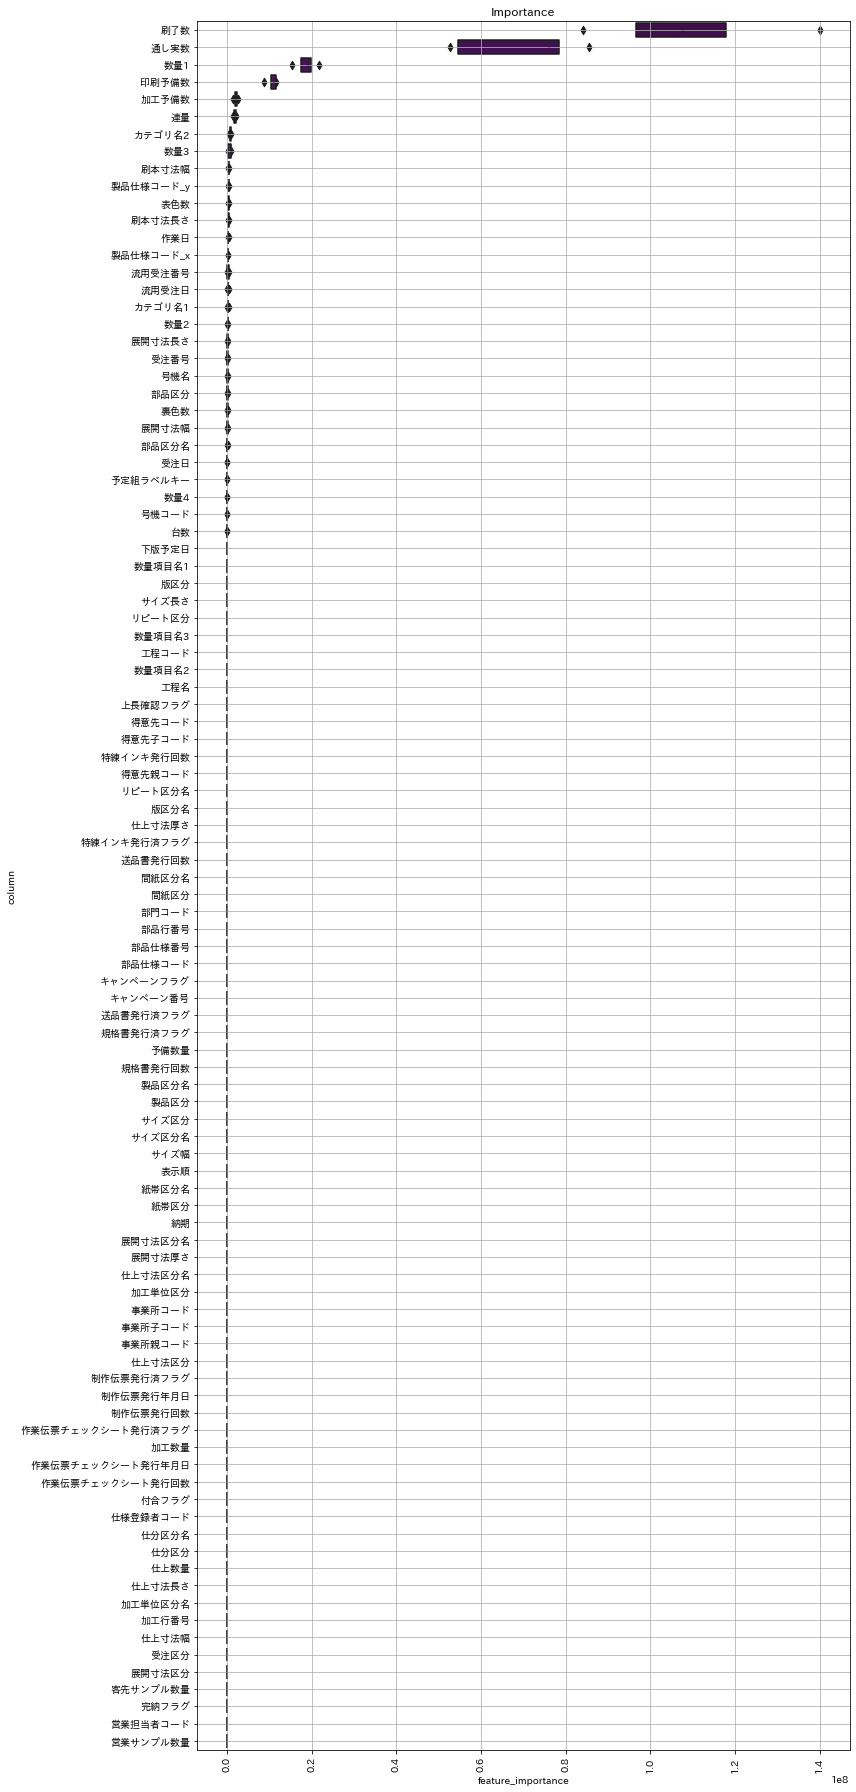

In [ ]:
_ = visualize_importance(lgb_models_main_printer, df_train_printer_x, 'lgb_models_main_printer')

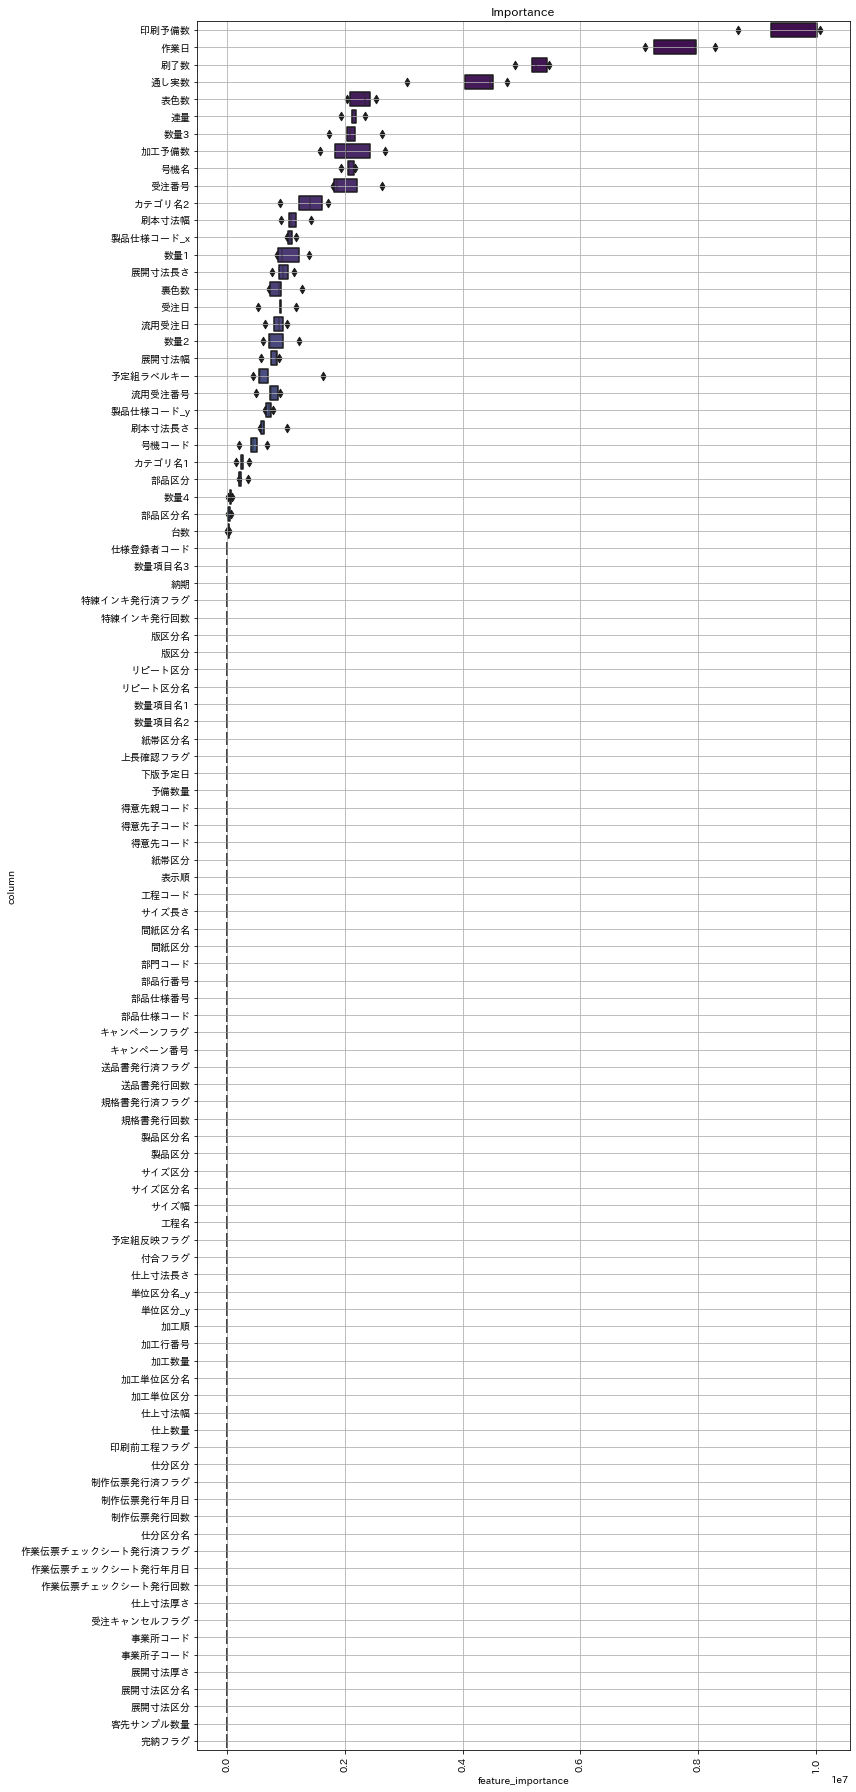

In [ ]:
_ = visualize_importance(lgb_models_sub_printer, df_train_printer_x, 'lgb_models_sub_printer')

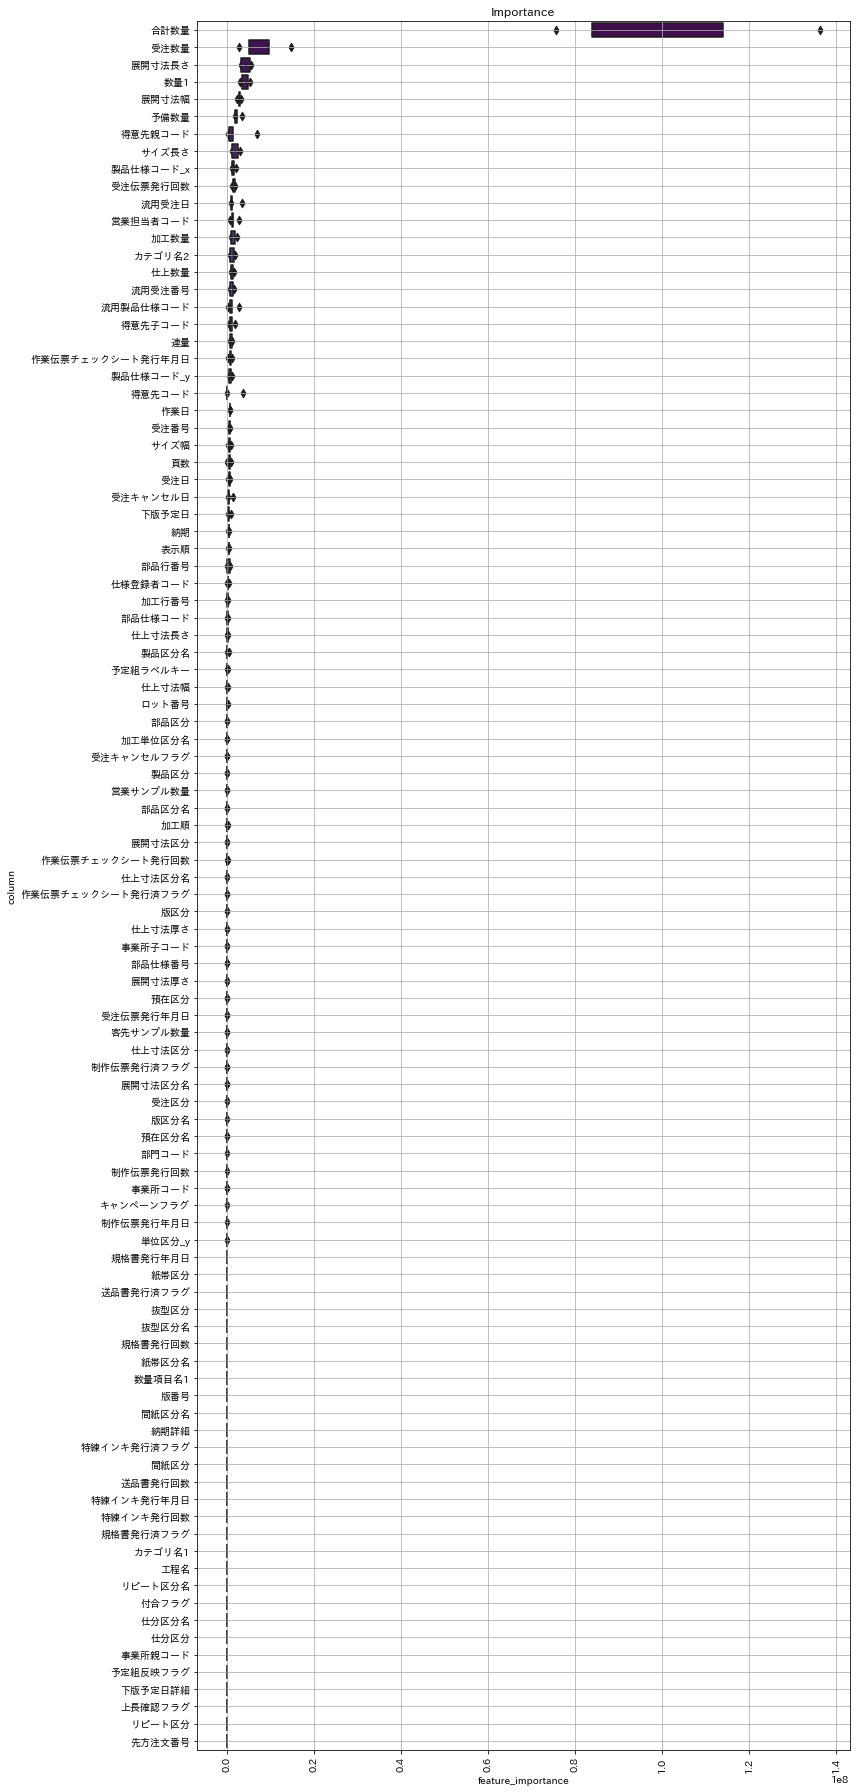

In [ ]:
_ = visualize_importance(lgb_models_main_gluer, df_train_gluer_x, 'lgb_models_main_gluer')

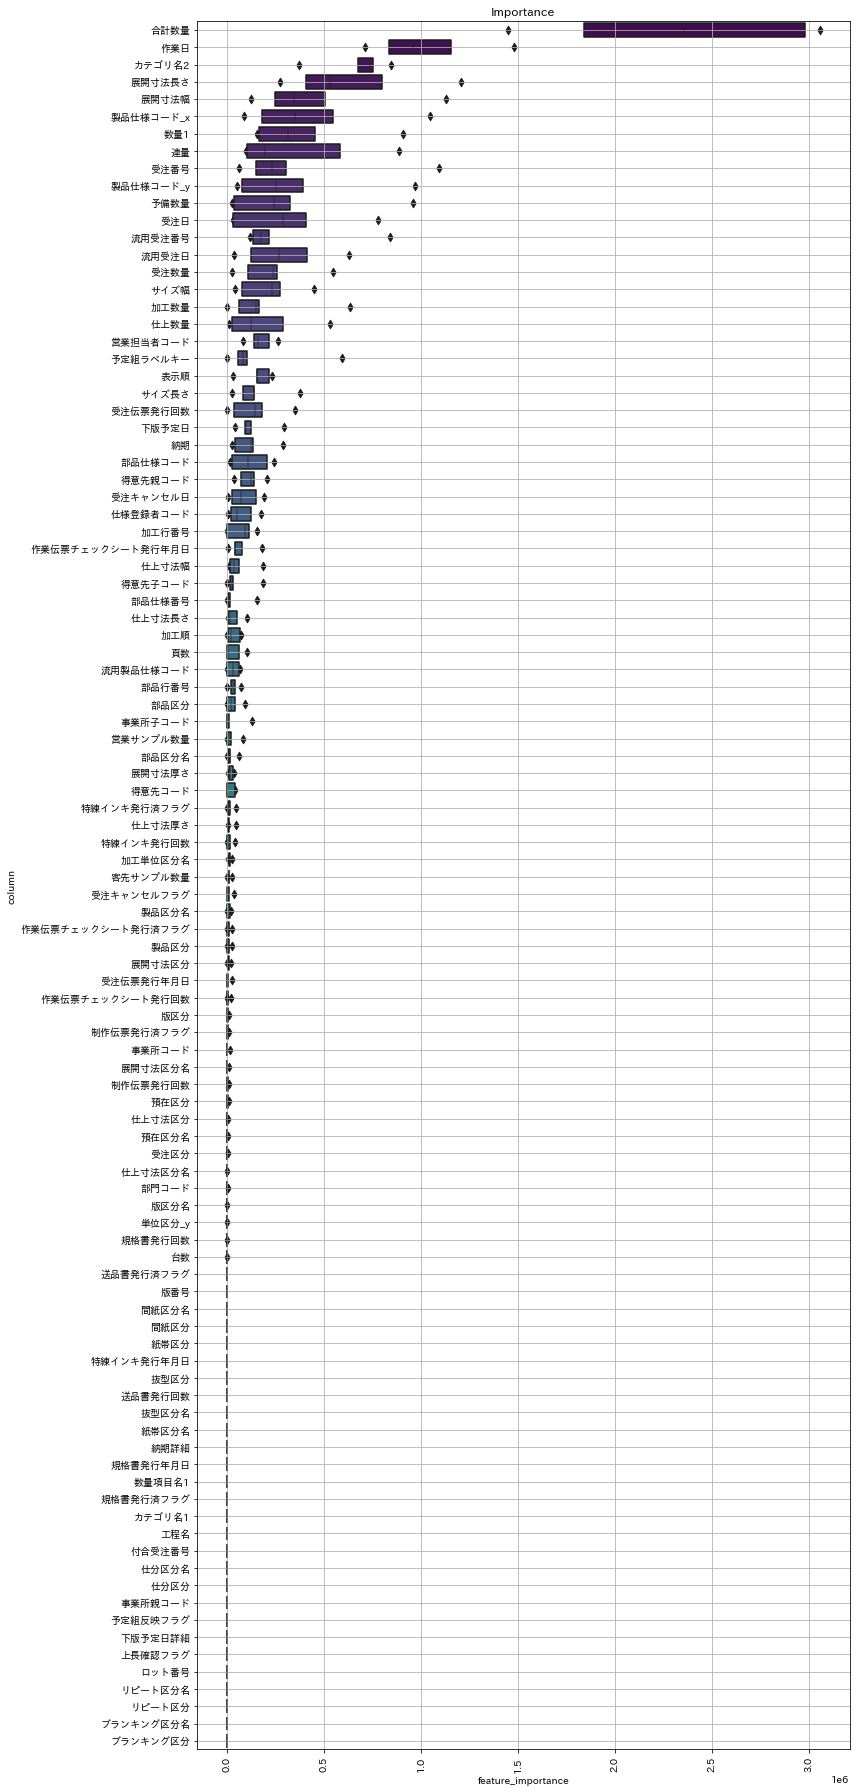

In [ ]:
_ = visualize_importance(lgb_models_sub_gluer, df_train_gluer_x, 'lgb_models_sub_printer')

In [ ]:
%cd "/content/drive/MyDrive/マナビDX_Quest/PBL05/data"

/content/drive/MyDrive/マナビDX_Quest/PBL05/data


In [ ]:
df_actual_test["作業日"] = pd.to_datetime(df_actual_test['作業日'])
df_actual_test


,index,受注番号,号機名,作業日
0,0,B20013240,2号機,2020-08-01
1,1,B20013068,6号機,2020-08-01
2,2,B20014058,8号機,2020-08-01
3,3,B20013916,8号機,2020-08-01
4,4,B20012626,6号機,2020-08-01
...,...,...,...,...
5978,5978,B21002688,2号機,2021-02-16
5979,5979,B21002824,2号機,2021-02-16
5980,5980,B20023934,2号機,2021-02-16
5981,5981,B21002915,2号機,2021-02-16


In [ ]:
df_test

,作業日,受注番号,号機名,正味作業時間,付帯作業時間,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,数量項目名4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,協力会社親コード,協力会社子コード,協力会社コード,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,抜型区分,抜型区分名,抜型納入日,ストリッパー区分,ストリッパー区分名,ブランキング区分,ブランキング区分名,加工表裏指定区分,加工表裏指定区分名,単位区分,単位区分名,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー,受注日,受注数量,実績数量,下版予定日,流用受注番号,流用受注日,流用製品仕様コード,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合受注番号,付合フラグ,受注区分,受注区分名,納期,納期詳細,初回出荷日,先方注文番号,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,版番号,ロット番号,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,客先サンプル数量,営業サンプル数量,版区分,版区分名,預在区分,預在区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行年月日,特練インキ発行回数,規格書発行済フラグ,規格書発行年月日,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行年月日,送品書発行回数,予定組反映フラグ,下版予定日詳細,受注キャンセル日,リピート区分単位区分名,index,Machine
0,502,9691,0,NaN,NaN,11.0,1400.0,3,1.0,1,4.0,1,0.0,0,1400.0,1400.0,0.0,0.0,0.0,1.0,848.0,960.0,440.0,112.0,3019,1,1,0,0,5.0,5.0,325.0,475.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,1,1,1,1,0,0.0,0.0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,11189,244,NaN,NaN,251,535,177,203,NaN,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,NaN,NaN,NaN,6,0,NaN,NaN,NaN,4,0,5,0,37,NaN,NaN,8,0,3,0,3,3,2,2,36,NaN,3,195,NaN,2,41,NaN,2,8,NaN,2,1042,NaN,1,0,NaN,2,3,180,0,0.0,2号機
1,502,9608,2,NaN,NaN,13.0,5000.0,3,1.0,1,0.0,1,0.0,0,5000.0,5000.0,0.0,44.5,0.0,1.0,4500.0,4600.0,400.0,100.0,3435,3,14,0,0,1.0,0.0,625.0,880.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,1,1,1,1,0,0.0,0.0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,11092,244,NaN,NaN,251,535,177,203,NaN,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,NaN,NaN,NaN,6,0,NaN,NaN,NaN,4,0,5,0,37,NaN,NaN,8,0,3,0,3,3,2,2,36,NaN,3,195,NaN,2,41,NaN,2,8,NaN,2,1042,NaN,1,0,NaN,2,3,180,0,1.0,6号機
2,502,10033,4,NaN,NaN,15.0,2000.0,3,4.0,1,0.0,1,0.0,0,2000.0,2000.0,0.0,35.0,0.0,1.0,1500.0,1700.0,300.0,200.0,1769,3,14,0,0,2.0,2.0,625.0,880.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,1,1,1,1,0,0.0,0.0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,11573,244,NaN,NaN,251,535,177,203,NaN,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,NaN,NaN,NaN,6,0,NaN,NaN,NaN,4,0,5,0,37,NaN,NaN,8,0,3,0,3,3,2,2,36,NaN,3,195,NaN,2,41,NaN,2,8,NaN,2,1042,NaN,1,0,NaN,2,3,180,0,2.0,8号機
3,502,9983,4,NaN,NaN,15.0,2000.0,3,5.0,1,0.0,1,0.0,0,2000.0,2000.0,0.0,200.0,0.0,1.0,1362.0,1428.0,572.0,66.0,3365,3,0,0,0,2.0,3.0,392.0,544.0,1,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,1,1,1,1,0,0.0,0.0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,11522,244,NaN,NaN,251,535,177,203,NaN,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,NaN,NaN,NaN,6,0,NaN,NaN,NaN,4,0,5,0,37,NaN,NaN,8,0,3,0,3,3,2,2,36,NaN,3,195,NaN,2,41,NaN,2,8,NaN,2,1042,NaN,1,0,NaN,2,3,180,0,3.0,8号機
4,502,9402,2,NaN,NaN,13.0,900.0,3,0.0,1,2.0,1,0.0,0,900.0,900.0,0.0,35.0,0.0,1.0,0.0,0.0,0.0,0.0,4897,3,14,0,0,1.0,1.0,625.0,880.0,16,13,0.0,0.0,465,-999.0,1,0.0,-999.0,0,0,1,1,1,1,0,0.0,0.0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,10846,244,NaN,NaN,251,535,177,203,NaN,8,8,3,3,3,6,0,259,4,21,88,3,6,8,10,14,28,8,33,13,145,4,0,NaN,NaN,NaN,6,0,NaN,NaN,NaN,4,0,5,0,37,NaN,NaN,8,0,3,0,3,3,2,2,36,NaN,3,195,NaN,2,41,NaN,2,8,NaN,2,1042,NaN,1,0,NaN,2,3,180,0,4.0,6号機
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,662,14836,0,NaN,NaN,11.0,550.0,3,2.0,1,2.0,1,0.0,0,550.0,5

In [ ]:
"""
printer_list = ['2号機', '4号機', '6号機', '7号機', '8号機']
df_train_printer = df_train[df_train["Machine"].isin(printer_list)]
df_train_printer = df_train_printer.drop(["Machine"], axis=1)

df_train_gluer = df_train[df_train["Machine"]=="グルアー"]
df_train_gluer = df_train_gluer.drop(["Machine"], axis=1)

df_test_printer = df_test[df_test["Machine"].isin(printer_list)]
df_test_printer = df_test_printer.drop(["Machine"], axis=1)

df_test_gluer = df_test[df_test["Machine"]=="グルアー"]
df_test_gluer = df_test_gluer.drop(["Machine"], axis=1)

file_path = f'oof_valid_lgb_main_printer.pkl'
file_path = f'lgb_models_main_printer.pkl'
file_path = f'lgb_models_sub_printer.pkl'
file_path = f'oof_valid_lgb_sub_printer.pkl'
file_path = f'oof_valid_lgb_main_gluer.pkl'
file_path = f'lgb_models_main_gluer.pkl'
file_path = f'lgb_models_sub_gluer.pkl'
file_path = f'oof_valid_lgb_sub_gluer.pkl'
"""

In [ ]:
printer_list = ['2号機', '4号機', '6号機', '7号機', '8号機']
df_test['index'] = df_test.index
df_test_printer_index = df_test[df_test["Machine"].isin(printer_list)]
df_test_printer_index = df_test_printer_index.drop(["Machine"], axis=1)
df_test_printer = df_test_printer_index.drop(["index"], axis=1)

df_test_gluer_index = df_test[df_test["Machine"]=="グルアー"]
df_test_gluer_index = df_test_gluer_index.drop(["Machine"], axis=1)
df_test_gluer = df_test_gluer_index.drop(["index"], axis=1)

In [ ]:
"""
df_main_printer_test = df_test_printer[df_train_printer_main_corr_top20]
df_sub__printer_test = df_test_printer[df_train_printer_sub_corr_top20]
df_main_gluer_test = df_test_gluer[df_train_printer_main_corr_top20]
df_sub_gluer_test = df_test_gluer[df_train_printer_sub_corr_top20]
"""

In [ ]:
import scipy
def predict_test(models, df):
    out = np.array([model.predict(df) for model in models])
    #out = np.mean(out, axis=0)
    
    
    # トリム平均を算出
    out = scipy.stats.trim_mean(out, 0.2, axis=0)
    print("out.shape:", out.shape)
    
    return out
    

In [ ]:
#check distribution of train and test_pred data
def plot_prediction_distribution(y_true, y_pred, y_test):
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.histplot(y_test, label='Test Predict', ax=ax, color='black', stat='density')
    sns.histplot(y_pred, label='Out Of Fold', ax=ax, color='C1', stat='density', alpha=0.5)
    sns.histplot(y_true, label='True Value', ax=ax, color='blue', stat='density', alpha=0.5)
    ax.legend()
    ax.grid()

In [ ]:
df_test_printer

,作業日,受注番号,号機名,正味作業時間,付帯作業時間,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード_x,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー,受注日,製品仕様コード_y,受注数量,下版予定日,流用受注番号,流用受注日,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合フラグ,受注区分,受注区分名,納期,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,単位区分_y,単位区分名_y,客先サンプル数量,営業サンプル数量,版区分,版区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行回数,規格書発行済フラグ,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行回数,予定組反映フラグ,index,Machine
0,246,7194,0,NaN,NaN,11.0,92,0,3,0,11,0,3,NaN,1,1,NaN,1,1,848.0,960.0,440.0,112.0,118552.0,1,1,21.0,0,5.0,5.0,325.0,475.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,7239,193,2845,NaN,1,3440,557,1,1,1,NaN,NaN,1,0,1,1,1,1,1,NaN,NaN,NaN,1,1,0,1,1,1,1,0,1,335,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0,2号機
1,246,7113,2,NaN,NaN,13.0,450,0,3,0,1,0,3,NaN,1,1,44.5,1,1,4500.0,4600.0,400.0,100.0,120432.0,3,14,21.0,0,1.0,0.0,625.0,880.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,7158,191,3260,NaN,1,3440,557,1,1,1,NaN,NaN,1,0,1,1,1,1,1,NaN,NaN,NaN,1,1,0,1,1,1,1,0,313,181,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,6号機
2,246,7528,4,NaN,NaN,15.0,193,0,12,0,1,0,3,NaN,1,1,35.0,1,1,1500.0,1700.0,300.0,200.0,114989.0,3,14,21.0,0,2.0,2.0,625.0,880.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,7574,202,1614,NaN,1,3112,419,1,1,1,NaN,NaN,1,0,1,1,1,1,1,NaN,NaN,NaN,1,1,0,1,1,1,1,0,210,106,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,2,8号機
3,246,7479,4,NaN,NaN,15.0,193,0,14,0,1,0,3,NaN,1,1,200.0,1,1,1362.0,1428.0,572.0,66.0,120117.0,3,0,21.0,0,2.0,3.0,392.0,544.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,7525,201,3190,NaN,1,3100,413,1,1,1,NaN,NaN,1,0,1,1,1,1,1,NaN,NaN,NaN,1,1,0,1,1,1,1,0,383,474,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,3,8号機
4,246,6913,2,NaN,NaN,13.0,603,0,1,0,7,0,3,NaN,1,1,35.0,1,1,NaN,NaN,NaN,NaN,92310.0,3,14,21.0,0,1.0,1.0,625.0,880.0,13,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,6957,187,4701,NaN,1,3106,416,1,1,1,NaN,NaN,1,0,1,1,1,1,1,NaN,NaN,NaN,1,1,0,1,1,1,1,0,0,0,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,4,6号機
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,400,12174,0,NaN,NaN,11.0,471,0,8,0,7,0,3,NaN,1,1,7.0,1,1,167.0,350.0,200.0,183.0,116495.0,3,9,21.0,0,4.0,0.0,550.0,400.0,0,13,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,12241,333,2279,NaN,1,3440,557,1,1,1,NaN,NaN,1,0,1,1,1,1,1,NaN,NaN,NaN,1,1,0,1,1,1,1,0,65,202,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,5978,2号機
5979,400,12204,0,NaN,NaN,11.0,571,0,3,0,1,0,3,NaN,1,1,35.0,1,1,167.0,400.0,400.0,233.0,116192.0,3,17,21.0,0,4.0,1.0,548.0,398.0,13,27,NaN,1,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,NaN,0,NaN,0,NaN,0,12271,334,2043,NaN,1,3440,557,1,1,1,NaN,NaN,1,0,1,1,1,1,1,NaN,NaN,NaN,1,1,0,1,1,1,1,0,60,455,1,1,0,1,0,1,1,0,1,1,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,5979,2号機
5980,400,11244,0,NaN,NaN,11.0,50,0,14,0,1,0,3,NaN

In [ ]:
"""
pred_main_printer = predict_test(lgb_models_main_printer, df_main_printer_test)
pred_sub_printer = predict_test(lgb_models_sub_printer, df_sub__printer_test)
pred_main_glue = predict_test(lgb_models_main_gluer, df_main_gluer_test)
pred_sub_glue = predict_test(lgb_models_sub_gluer, df_sub_gluer_test)
"""
pred_main_printer = predict_test(lgb_models_main_printer, df_test_printer[df_train_printer_x.columns])
pred_sub_printer = predict_test(lgb_models_sub_printer, df_test_printer[df_train_printer_x.columns])
pred_main_glue = predict_test(lgb_models_main_gluer, df_test_gluer[df_train_gluer_x.columns])
pred_sub_glue = predict_test(lgb_models_sub_gluer, df_test_gluer[df_train_gluer_x.columns])

out.shape: (4927,)
out.shape: (4927,)
out.shape: (1056,)
out.shape: (1056,)


In [ ]:
df_test_printer_index = df_test_printer[["受注番号","index"]]
df_test_gluer_index = df_test_gluer[["受注番号","index"]]

In [ ]:
pred_main_printer_index = df_test_printer["index"]
df_test_printer["index"]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
5978   NaN
5979   NaN
5980   NaN
5981   NaN
5982   NaN
Name: index, Length: 5983, dtype: float64

In [ ]:
df_test_printer_index["正味作業時間"] = pred_main_printer
df_test_printer_index["付帯作業時間"] = pred_sub_printer
df_pred_main_printer = df_test_printer_index[["index","正味作業時間","付帯作業時間"]]
df_pred_main_printer

df_test_gluer_index["正味作業時間"] = pred_main_glue
df_test_gluer_index["付帯作業時間"] = pred_sub_glue
df_pred_main_gluer = df_test_gluer_index[["index","正味作業時間","付帯作業時間"]]
df_pred_main_gluer

,index,正味作業時間,付帯作業時間
9,9,49.574469,32.657275
14,14,32.160986,30.185874
20,20,26.165482,28.035628
28,28,27.117610,27.404417
29,29,52.664119,27.355620
...,...,...,...
5954,5954,30.127602,25.096263
5956,5956,35.658680,26.620386
5957,5957,33.234847,25.903250
5959,5959,37.847741,28.380787


In [ ]:
df_pred_main_printer

,index,正味作業時間,付帯作業時間
0,0,13.494872,59.942489
1,1,41.287869,20.877456
2,2,15.796305,25.922547
3,3,15.266874,57.426958
4,4,7.084459,10.704231
...,...,...,...
5978,5978,3.714623,28.770892
5979,5979,5.577948,21.360003
5980,5980,12.338450,50.138308
5981,5981,21.007509,19.797050


In [ ]:
df_pred_main_gluer

,index,正味作業時間,付帯作業時間
9,9,49.574469,32.657275
14,14,32.160986,30.185874
20,20,26.165482,28.035628
28,28,27.117610,27.404417
29,29,52.664119,27.355620
...,...,...,...
5954,5954,30.127602,25.096263
5956,5956,35.658680,26.620386
5957,5957,33.234847,25.903250
5959,5959,37.847741,28.380787


In [ ]:
pd.set_option('max_rows', 100)

In [ ]:
df_pred_main_printer.head(15)

,index,正味作業時間,付帯作業時間
0,0,11.279592,59.591825
1,1,33.538937,21.429054
2,2,14.864959,27.085443
3,3,10.851447,61.272753
4,4,12.149530,11.401499
5,5,52.678908,17.297904
6,6,11.811352,63.729218
7,7,4.948242,35.658223
8,8,14.164792,56.056367
10,10,14.833359,36.447255


In [ ]:
df_pred_main_gluer.head(15)

,index,正味作業時間,付帯作業時間
9,9,49.574469,32.657275
14,14,32.160986,30.185874
20,20,26.165482,28.035628
28,28,27.117610,27.404417
29,29,52.664119,27.355620
33,33,42.455621,33.438323
34,34,29.891349,27.094462
84,84,32.563594,29.643521
86,86,29.453470,26.159405
87,87,37.976710,31.923056


In [ ]:
df_pred = pd.concat([df_pred_main_printer, df_pred_main_gluer], axis=0)
df_pred = df_pred.sort_values("index")
df_pred.head(20)

,index,正味作業時間,付帯作業時間
0,0,11.279592,59.591825
1,1,33.538937,21.429054
2,2,14.864959,27.085443
3,3,10.851447,61.272753
4,4,12.149530,11.401499
5,5,52.678908,17.297904
6,6,11.811352,63.729218
7,7,4.948242,35.658223
8,8,14.164792,56.056367
9,9,49.574469,32.657275


In [ ]:
"""
printer_list = ['2号機', '4号機', '6号機', '7号機', '8号機']
df_train_printer = df_train[df_train["Machine"].isin(printer_list)]
df_train_printer = df_train_printer.drop(["Machine"], axis=1)

df_train_gluer = df_train[df_train["Machine"]=="グルアー"]
df_train_gluer = df_train_gluer.drop(["Machine"], axis=1)

df_test_printer = df_test[df_test["Machine"].isin(printer_list)]
df_test_printer = df_test_printer.drop(["Machine"], axis=1)

df_test_gluer = df_test[df_test["Machine"]=="グルアー"]
df_test_gluer = df_test_gluer.drop(["Machine"], axis=1)

df_main_printer
df_sub_printer
df_main_gluer
df_sub_gluer

file_path = f'oof_valid_lgb_main_printer.pkl'
file_path = f'lgb_models_main_printer.pkl'
file_path = f'lgb_models_sub_printer.pkl'
file_path = f'oof_valid_lgb_sub_printer.pkl'
file_path = f'oof_valid_lgb_main_gluer.pkl'
file_path = f'lgb_models_main_gluer.pkl'
file_path = f'lgb_models_sub_gluer.pkl'
file_path = f'oof_valid_lgb_sub_gluer.pkl'

pred_main_printer = predict_test(lgb_models_main_printer, df_main_printer_test)
pred_sub_printer = predict_test(lgb_models_sub_printer, df_sub__printer_test)
pred_main_glue = predict_test(lgb_models_main_gluer, df_main_gluer_test)
pred_sub_glue = predict_test(lgb_models_sub_gluer, df_sub_gluer_test)
"""

In [ ]:
df_main_printer

,合計数量,予備数量,数量1,刷了数,通し実数,加工予備数,印刷予備数,号機名,号機コード,刷本寸法幅,裏色数,カテゴリ名1,数量3,部品区分名,表色数,製品仕様コード,作業日,台数,連量,予定組ラベルキー,受注番号,数量2,部品区分,刷本寸法長さ,流用受注番号,受注キャンセル日,流用受注日,ロット番号,流用製品仕様コード,先方注文番号
9824,50.0,250.0,250.0,0.0,0.0,0.0,0.0,1,12.0,0.0,0.0,0,1.0,14,0.0,1183,189,1.0,0.0,1725,1725,0.0,2,0.0,536,181,178,146,204,89
10565,750.0,750.0,750.0,450.0,300.0,150.0,300.0,3,14.0,950.0,0.0,3,2.0,13,4.0,264,318,1.0,27.5,1860,1860,2.0,1,650.0,535,180,177,145,203,88
10567,750.0,750.0,750.0,450.0,300.0,150.0,300.0,3,14.0,950.0,0.0,3,2.0,13,4.0,266,318,1.0,27.5,1862,1861,2.0,1,650.0,535,180,177,145,203,88
12574,2500.0,2500.0,2500.0,2100.0,2003.0,97.0,400.0,4,15.0,939.0,4.0,3,0.0,13,4.0,1123,319,1.0,48.5,2222,2220,8.0,1,636.0,535,180,177,145,203,88
12900,2000.0,2000.0,2000.0,1000.0,1000.0,0.0,1000.0,2,13.0,788.0,1.0,3,0.0,13,1.0,151,258,1.0,45.0,2277,2275,4.0,1,544.0,535,180,177,145,203,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23705,2000.0,2000.0,2000.0,1700.0,1501.0,199.0,300.0,3,14.0,788.0,0.0,3,1.0,13,5.0,3414,497,2.0,135.0,11410,9887,4.0,1,544.0,535,180,177,145,203,88
23706,800.0,800.0,800.0,400.0,334.0,66.0,400.0,0,11.0,640.0,1.0,3,0.0,13,4.0,804,499,1.0,15.5,11456,9927,1.0,1,468.0,535,180,177,145,203,88
23707,600.0,600.0,600.0,200.0,32.0,168.0,400.0,3,14.0,800.0,1.0,3,0.0,13,5.0,2485,501,1.0,35.0,11460,9931,1.0,1,548.0,535,180,177,145,203,88
23708,300.0,300.0,300.0,15.0,5.0,10.0,285.0,1,12.0,940.0,0.0,3,0.0,13,4.0,3526,500,3.0,16.0,11491,9955,4.0,21,640.0,535,180,177,145,203,88


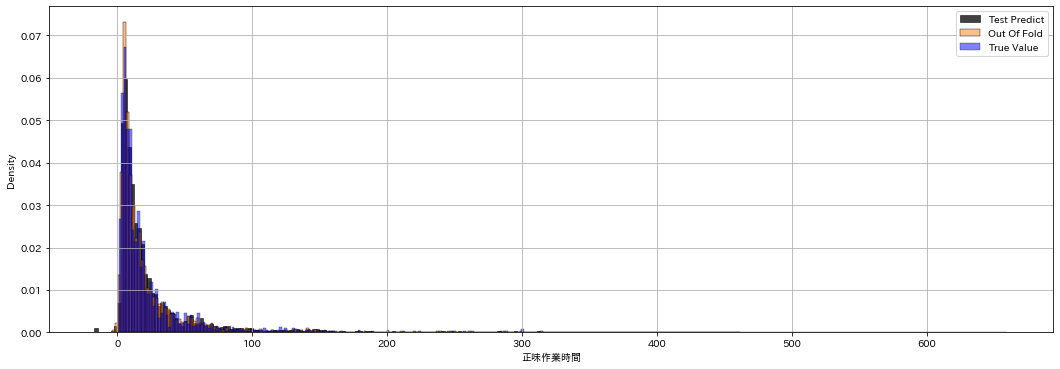

In [ ]:
plot_prediction_distribution(df_train_printer[config.main_target], oof_valid_lgb_main_printer, pred_main_printer)

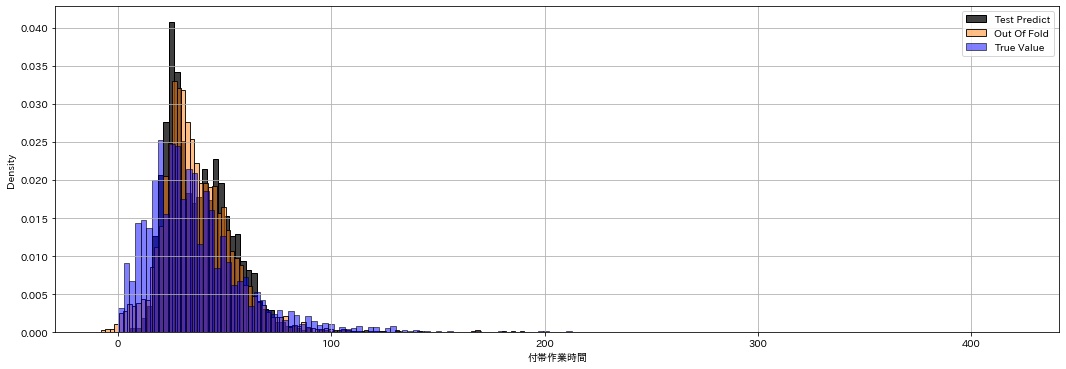

In [ ]:
plot_prediction_distribution(df_train_printer[config.sub_target], oof_valid_lgb_sub_printer, pred_sub_printer)

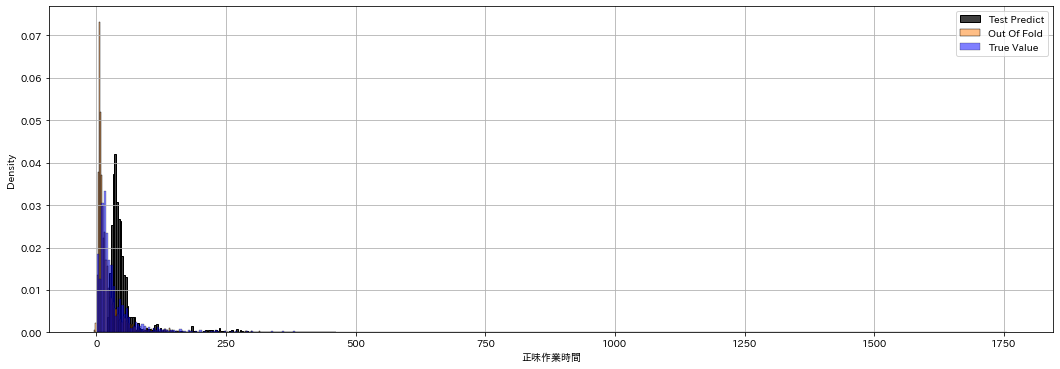

In [ ]:
plot_prediction_distribution(df_train_gluer[config.main_target], oof_valid_lgb_main_printer, pred_main_glue)

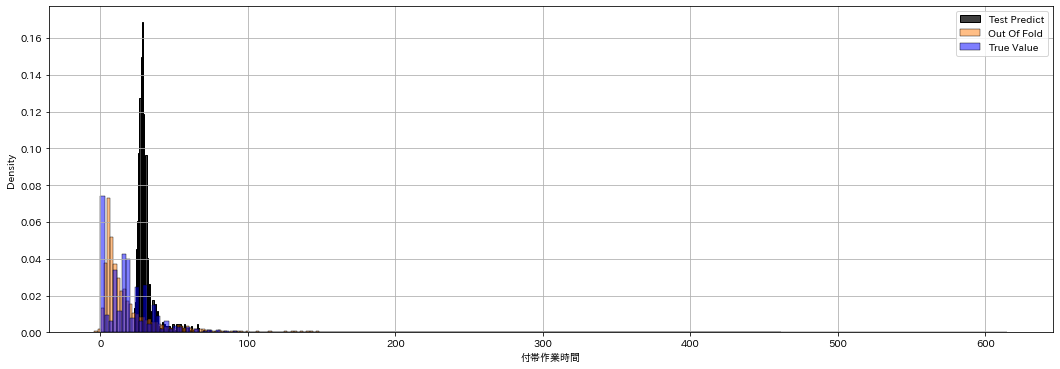

In [ ]:
plot_prediction_distribution(df_train_gluer[config.sub_target], oof_valid_lgb_main_printer, pred_sub_glue)

In [ ]:
pred_test2 = predict_test(lgb_models2, df_sub_test)

out.shape: (5983,)


In [ ]:
"""
df_test_printer_index["正味作業時間"] = pred_main_printer
df_test_printer_index["付帯作業時間"] = pred_sub_printer
"""
submission = pd.read_csv('/content/drive/MyDrive/マナビDX_Quest/PBL05/data/sample_submit.csv', header=None)
submission.iloc[:, 1] = df_pred["正味作業時間"]
submission.iloc[:, 2] = df_pred["付帯作業時間"]
submission

,0,1,2
0,0,11.279592,59.591825
1,1,33.538937,21.429054
2,2,14.864959,27.085443
3,3,10.851447,61.272753
4,4,12.149530,11.401499
...,...,...,...
5978,5978,3.247579,26.561197
5979,5979,6.195826,21.080824
5980,5980,9.492040,47.889938
5981,5981,16.494143,17.631190


In [ ]:
submission[submission[1] < 0]

,0,1,2
303,303,-1.663472,49.273590
642,642,-1.584916,44.855208
2130,2130,-0.334213,44.455982
2600,2600,-0.334213,44.455982
3060,3060,-0.334213,44.455982
3362,3362,-16.920975,14.905353
3464,3464,-1.971486,24.338850
3560,3560,-16.659655,15.001276
3587,3587,-3.943777,69.970310
3590,3590,-1.473576,44.844213


In [ ]:
submission[submission[2] < 0]

,0,1,2


In [ ]:
submit = submission.copy()
submit.loc[submit[1]<0,1]=0
submit.loc[submit[2]<0,2]=0

In [ ]:
submit[submit[1] < 0]

,0,1,2


In [ ]:
submit[submit[2] < 0]

,0,1,2


In [ ]:
submit.to_csv("/content/drive/MyDrive/マナビDX_Quest/PBL05/submit/submission11.csv", index=False, header=False)

In [ ]:
oof_valid_lgb1, lgb_models1 = fit_lgb_oputuna(x=df_main, y=df_main[config.main_target], cv=kf_cv,
                                      model_params=optuna_model_params, fit_params=oputuna_fit_params
                                     )

[I 2022-12-05 05:29:36,623] A new study created in memory with name: no-name-5053ea2f-e57c-48ef-906b-060ba1ad82d7
[W 2022-12-05 05:29:36,668] Trial 0 failed because of the following error: TypeError("float() argument must be a string or a number, not 'Timestamp'")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/usr/local/lib/python3.7/dist-packages/optuna/integration/_lightgbm_tuner/optimize.py", line 248, in __call__
    booster = lgb.train(self.lgbm_params, train_set, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1001, in construct
    categorical_feature=se

data_labels: ['作業日', '受注番号', '号機名', '正味作業時間', '号機コード', '数量1', '数量項目名1', '数量2', '数量項目名2', '数量3', '数量項目名3', '数量4', '数量項目名4', '合計数量', '予備数量', '仕上数量', '連量', '加工数量', '台数', '通し実数', '刷了数', '印刷予備数', '加工予備数', '製品仕様コード_x', 'カテゴリ名1', 'カテゴリ名2', '工程コード', '工程名', '表色数', '裏色数', '刷本寸法長さ', '刷本寸法幅', '部品区分', '部品区分名', '部品行番号', '部品仕様番号', '部品仕様コード', '表示順', '印刷前工程フラグ', '加工行番号', '加工順', '加工単位区分', '加工単位区分名', '協力会社親コード', '協力会社子コード', '協力会社コード', 'サイズ区分', 'サイズ区分名', 'サイズ幅', 'サイズ長さ', '抜型区分', '抜型区分名', '抜型納入日', 'ストリッパー区分', 'ストリッパー区分名', 'ブランキング区分', 'ブランキング区分名', '加工表裏指定区分', '加工表裏指定区分名', '単位区分_x', '単位区分名_x', '仕分区分', '仕分区分名', '間紙区分', '間紙区分名', '紙帯区分', '紙帯区分名', '予定組ラベルキー', '受注日', '製品仕様コード_y', '受注数量', '実績数量', '下版予定日', '流用受注番号', '流用受注日', '流用製品仕様コード', '頁数', 'キャンペーン番号', '受注キャンペーン番号', 'キャンペーンフラグ', '付合受注番号', '付合フラグ', '受注区分', '受注区分名', '納期', '納期詳細', '初回出荷日', '先方注文番号', '事業所親コード', '事業所子コード', '事業所コード', '部門コード', '営業担当者コード', '得意先親コード', '得意先子コード', '得意先コード', '版番号', 'ロット番号', '仕上寸法区分', '仕上寸法区分名', '仕上寸法幅', '仕上寸法長さ', '仕上寸法厚さ', '展開寸法区分', '展開寸法区分

TypeError: ignored

In [ ]:
df_temp[df_temp["受注番号"]=="B19019643"]

,index,作業日,受注番号,号機名,正味作業時間,付帯作業時間,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,数量項目名4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード_x,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,協力会社親コード,協力会社子コード,協力会社コード,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,抜型番号,抜型区分,抜型区分名,抜型納入日,ストリッパー区分,ストリッパー区分名,ブランキング区分,ブランキング区分名,加工表裏指定区分,加工表裏指定区分名,単位区分_x,単位区分名_x,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー,受注日,製品仕様コード_y,受注数量,実績数量,下版予定日,流用受注番号,流用受注日,流用製品仕様コード,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合受注番号,付合フラグ,受注区分,受注区分名,納期,納期詳細,初回出荷日,先方注文番号,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,版番号,ロット番号,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,単位区分_y,単位区分名_y,客先サンプル数量,営業サンプル数量,版区分,版区分名,預在区分,預在区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行年月日,特練インキ発行回数,規格書発行済フラグ,規格書発行年月日,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行年月日,送品書発行回数,最終売上日,予定組反映フラグ,下版予定日詳細,受注キャンセル日
14171,69472,2019-10-14,B19019643,7号機,0,66.0,14.0,NaN,NaN,« NULL »,NaN,« NULL »,NaN,« NULL »,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4500.0,4750.0,450.0,250.0,113543.0,タック紙、タックフィルム,NaN,21.0,印刷（一般）,4.0,0.0,544.0,788.0,1.0,本体,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B190196430010021,2019/10/03 0:00:00,113543,NaN,NaN,NaN,b19019487,2019/10/02 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
base_train

,受注番号,受注日,製品仕様コード,受注数量,実績数量,下版予定日,流用受注番号,流用受注日,流用製品仕様コード,頁数,キャンペーン番号,受注キャンペーン番号,キャンペーンフラグ,付合受注番号,付合フラグ,受注区分,受注区分名,納期,納期詳細,初回出荷日,先方注文番号,事業所親コード,事業所子コード,事業所コード,部門コード,営業担当者コード,得意先親コード,得意先子コード,得意先コード,版番号,ロット番号,仕上寸法区分,仕上寸法区分名,仕上寸法幅,仕上寸法長さ,仕上寸法厚さ,展開寸法区分,展開寸法区分名,展開寸法幅,展開寸法長さ,展開寸法厚さ,製品区分,製品区分名,リピート区分,リピート区分名,仕様登録者コード,単位区分,単位区分名,客先サンプル数量,営業サンプル数量,版区分,版区分名,預在区分,預在区分名,上長確認フラグ,受注キャンセルフラグ,完納フラグ,受注伝票発行済フラグ,受注伝票発行年月日,受注伝票発行回数,制作伝票発行済フラグ,制作伝票発行年月日,制作伝票発行回数,特練インキ発行済フラグ,特練インキ発行年月日,特練インキ発行回数,規格書発行済フラグ,規格書発行年月日,規格書発行回数,作業伝票チェックシート発行済フラグ,作業伝票チェックシート発行年月日,作業伝票チェックシート発行回数,送品書発行済フラグ,送品書発行年月日,送品書発行回数,最終売上日,予定組反映フラグ,下版予定日詳細,受注キャンセル日
0,230432-00,2018-10-29 00:00:00,090663,44000.0,0,2018-11-09 00:00:00,218257-00,2018-01-26 00:00:00,« NULL »,0,« NULL »,« NULL »,0.0,« NULL »,0.0,1,一般,2018-12-10 00:00:00,« NULL »,« NULL »,« NULL »,00000,000,000,1010,1153.0,6001.0,4.0,06001-004,1618HC,« NULL »,« NULL »,« NULL »,202,31,0,« NULL »,« NULL »,202,123,« NULL »,« NULL »,« NULL »,1,有,1098,1,枚,13,20,1,新版,0,無,1.0,0.0,0.0,1.0,2020-04-27 09:39:40,23.0,0.0,« NULL »,0.0,0.0,« NULL »,0.0,0.0,« NULL »,0.0,1.0,2018-11-07 16:27:29,1.0,0.0,« NULL »,0.0,« NULL »,1.0,« NULL »,« NULL »
1,233827-00,2018-10-18 00:00:00,094066,215.0,0,2018-11-01 00:00:00,230477-00,2018-08-02 00:00:00,« NULL »,1,CP000356,CP000356,1.0,« NULL »,0.0,1,一般,2018-11-13 00:00:00,0,2018-11-09 00:00:00,« NULL »,00000,006,006,1040,1183.0,21076.0,0.0,21076-000,« NULL »,« NULL »,5,Ａ４,297,210,0,« NULL »,« NULL »,0,0,« NULL »,2,POP,0,無,1357,1,枚,0,5,1,新版,0,無,1.0,0.0,0.0,1.0,2020-04-27 09:39:40,25.0,1.0,2018-10-18 15:04:13,2.0,0.0,« NULL »,0.0,0.0,« NULL »,0.0,1.0,2018-11-01 18:11:54,1.0,0.0,« NULL »,0.0,« NULL »,1.0,« NULL »,« NULL »
2,233881-00,2018-10-26 00:00:00,102141,15324.0,0,2018-11-06 00:00:00,« NULL »,« NULL »,« NULL »,28,cp000358,cp000358,1.0,« NULL »,0.0,1,一般,2018-11-20 00:00:00,0,« NULL »,« NULL »,00000,006,006,1040,1183.0,21076.0,0.0,21076-000,« NULL »,« NULL »,999,その他,220,148,0,« NULL »,« NULL »,0,0,« NULL »,0,製品,0,無,« NULL »,3,冊,0,20,1,新版,0,無,1.0,0.0,0.0,1.0,2020-04-27 09:39:40,47.0,1.0,2018-10-26 15:15:09,1.0,0.0,« NULL »,0.0,1.0,2018-11-30 14:32:36,1.0,1.0,2018-11-06 13:26:53,1.0,0.0,« NULL »,0.0,« NULL »,1.0,« NULL »,« NULL »
3,B18000030,2018-12-07 00:00:00,059576,8000.0,0,2018-12-11 00:00:00,199403-00,2018-09-18 00:00:00,059576,0,CP000269,CP000269,1.0,« NULL »,0.0,1,一般,2018-12-21 00:00:00,0,« NULL »,« NULL »,00000,006,006,1040,1133.0,52023.0,1.0,52023-001,« NULL »,« NULL »,« NULL »,« NULL »,210,149,0,« NULL »,« NULL »,0,0,« NULL »,0,製品,1,有,1215,1,枚,0,10,2,改版,0,無,1.0,0.0,0.0,1.0,2020-05-13 19:47:52,38.0,1.0,2018-09-27 15:17:36,1.0,0.0,« NULL »,0.0,1.0,2020-06-15 11:02:26,3.0,1.0,2018-12-11 15:52:26,1.0,0.0,« NULL »,0.0,« NULL »,1.0,« NULL »,« NULL »
4,B18000038,2018-12-07 00:00:00,090068,1500.0,1000,2018-12-13 00:00:00,229842-00,2018-09-18 00:00:00,090068,6,CP000269,CP000269,1.0,« NULL »,0.0,1,一般,2018-12-21 00:00:00,« NULL »,« NULL »,« NULL »,00000,006,006,1040,1133.0,52023.0,1.0,52023-001,« NULL »,« NULL »,« NULL »,« NULL »,515,364,0,« NULL »,« NULL »,0,0,« NULL »,0,製品,1,有,1215,5,Ｓ,0,20,2,改版,0,無,1.0,0.0,0.0,1.0,2020-07-08 17:36:18,51.0,1.0,2018-09-27 15:21:43,1.0,0.0,« NULL »,0.0,1.0,2020-06-17 14:58:39,4.0,1.0,2018-12-13 22:48:01,1.0,0.0,« NULL »,0.0,« NULL »,1.0,« NULL »,« NULL »
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16908,b20005629,2020/03/16 0:00:00,113543,NaN,NaN,NaN,B19025115,2019/12/18 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16909,b20007995,2020/05/18 0:00:00,1097

In [ ]:
processing_train

,受注番号,号機名,号機コード,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,数量4,数量項目名4,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,製品仕様コード,カテゴリ名1,カテゴリ名2,工程コード,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分,部品区分名,部品行番号,部品仕様番号,部品仕様コード,表示順,印刷前工程フラグ,加工行番号,加工順,加工単位区分,加工単位区分名,協力会社親コード,協力会社子コード,協力会社コード,サイズ区分,サイズ区分名,サイズ幅,サイズ長さ,抜型番号,抜型区分,抜型区分名,抜型納入日,ストリッパー区分,ストリッパー区分名,ブランキング区分,ブランキング区分名,加工表裏指定区分,加工表裏指定区分名,単位区分,単位区分名,仕分区分,仕分区分名,間紙区分,間紙区分名,紙帯区分,紙帯区分名,予定組ラベルキー
0,B19013887,グルアー,37,1165.0,枚数,NaN,NaN,NaN,NaN,NaN,NaN,1100.0,200.0,1000.0,27.5,900.0,NaN,NaN,NaN,NaN,NaN,101892.0,平判,NaN,34.0,貼り,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B190138870010334
1,B19013888,グルアー,37,1300.0,枚数,NaN,NaN,NaN,NaN,NaN,NaN,1100.0,200.0,1000.0,27.5,900.0,NaN,NaN,NaN,NaN,NaN,101902.0,平判,NaN,34.0,貼り,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B190138880010334
2,B19019361,グルアー,37,2000,枚数,« NULL »,NaN,« NULL »,NaN,« NULL »,NaN,2400.0,400.0,2000.0,23.5,2000.0,NaN,NaN,NaN,NaN,NaN,93374.0,平判,コートボール,34.0,貼り,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B190193610020734
3,B19019371,グルアー,37,10000,枚数,« NULL »,NaN,« NULL »,NaN,« NULL »,NaN,9600.0,1600.0,9000.0,27.0,8000.0,NaN,NaN,NaN,NaN,NaN,102849.0,平判,特抄,34.0,貼り,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B190193710010734
4,B19019377,グルアー,37,4050,枚数,« NULL »,NaN,« NULL »,NaN,« NULL »,NaN,3500.0,900.0,3300.0,27.0,2600.0,NaN,NaN,NaN,NaN,NaN,102834.0,平判,特抄,34.0,貼り,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B190193770041534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22090,b18002027,PP貼り,39,641,枚数,« NULL »,NaN,« NULL »,NaN,« NULL »,NaN,600.0,327,500,NaN,273,2,NaN,NaN,NaN,NaN,101400.0,NaN,NaN,35.0,表面加工,NaN,NaN,NaN,NaN,0,本体①,1.0,01,101400-01,2.0,0.0,2.0,2.0,0.0,部品単位,« NULL »,« NULL »,« NULL »,25,四六半才,788,544,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,2,表裏,« NULL »,« NULL »,0.0,無,0.0,無,0.0,無,b180020270010235
22091,b18002027,アセンブリ,60,« NULL »,NaN,« NULL »,NaN,« NULL »,NaN,« NULL »,NaN,273.0,0,278,NaN,273,1,NaN,NaN,NaN,NaN,101400.0,NaN,NaN,53.0,アセンブリ,NaN,NaN,NaN,NaN,0,本体①,2.0,02,101400-02,7.0,0.0,7.0,7.0,0.0,部品単位,« NULL »,« NULL »,« NULL »,999,その他,320,250,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,0.0,無,0.0,無,0.0,無,b180020270020753
22092,b19015842,検査,45,« NULL »,NaN,« NULL »,NaN,« NULL »,NaN,« NULL »,NaN,50020.0,0,50020,NaN,50020,1,NaN,NaN,NaN,NaN,92438.0,NaN,NaN,41.0,検査,NaN,NaN,NaN,NaN,0,本体①,1.0,01,092438-01,3.0,0.0,3.0,3.0,0.0,部品単位,« NULL »,« NULL »,« NULL »,999,その他,42,120,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,0.0,無,0.0,無,0.0,無,b190158420010341
22093,b19015861,断裁1(能書・チャート),23,106979,個数,« NULL »,NaN,« NULL »,NaN,« NULL »,NaN,100500.0,0,100500,NaN,100500,1,NaN,NaN,NaN,NaN,94033.0,NaN,NaN,31.0,断裁,NaN,NaN,NaN,NaN,0,本体①,999.0,« NULL »,094033-,2.0,0.0,2.0,2.0,1.0,製品単位,« NULL »,« NULL »,« NULL »,999,その他,297,613,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,« NULL »,0.0,無,0.0,無,0.0,無,b190158619990231
